# CIFAR100 classification with EfficientNetV2L from scratch ( not using ImageNet weights)
* **EfficientNet V2L has about 118 milion parameters!**
* **TPU Distributed Training with Keras-3 and jax as its backend**

In [1]:
# Installing tensorflow-cpu to avoid tensorflow using TPUs
!pip install -q -U tensorflow-cpu

!pip install --upgrade -q keras


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# if you face OOM, uncomment this line bellow
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

## Setting Keras DataParallel strategy for distributed training

In [3]:
import keras

devices = keras.distribution.list_devices()
print(f'Available devices:{devices}')

data_parallel = keras.distribution.DataParallel(devices=devices)

# Or you can choose to create DataParallel with a 1D `DeviceMesh`.
mesh_1d = keras.distribution.DeviceMesh(
    shape=(8, ), axis_names=["data"], devices=devices
)
data_parallel = keras.distribution.DataParallel(device_mesh=mesh_1d)

# Set the global distribution.
keras.distribution.set_distribution(data_parallel)

E0000 00:00:1738430226.289800      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


Available devices:['tpu:0', 'tpu:1', 'tpu:2', 'tpu:3', 'tpu:4', 'tpu:5', 'tpu:6', 'tpu:7']


In [4]:
import numpy as np

import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetV2L

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 32 * len(devices)

## Mixed Precision Computation for lower memory usage and higher training speed

In [5]:
# using these two bad boys can increase the training step by over 200% in Keras3 + JAX + training loop from scratch
keras.config.set_dtype_policy("mixed_float16")
keras.mixed_precision.set_global_policy("mixed_float16")

## Reproduction

In [6]:
keras.utils.set_random_seed(0)

## Downloading dataset

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
NUM_CLASSES = 100
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

        0/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

     8192/169001437 ━━━━━━━━━━━━━━━━━━━━ 31:15 11us/step

    40960/169001437 ━━━━━━━━━━━━━━━━━━━━ 12:32 4us/step 

    98304/169001437 ━━━━━━━━━━━━━━━━━━━━ 7:50 3us/step 

   212992/169001437 ━━━━━━━━━━━━━━━━━━━━ 4:49 2us/step

   442368/169001437 ━━━━━━━━━━━━━━━━━━━━ 2:54 1us/step

   909312/169001437 ━━━━━━━━━━━━━━━━━━━━ 1:41 1us/step

  1826816/169001437 ━━━━━━━━━━━━━━━━━━━━ 58s 0us/step 

  3678208/169001437 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

  6815744/169001437 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

  9945088/169001437 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

 13025280/169001437 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 16007168/169001437 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 16326656/169001437 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

 19177472/169001437 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

 21348352/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 22536192/169001437 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

 24985600/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 25681920/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 28450816/169001437 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 30531584/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 31891456/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 34013184/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 35176448/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 37666816/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 38445056/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

 40804352/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 41713664/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 44285952/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 46039040/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 47579136/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 49250304/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

 50855936/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 52625408/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 54181888/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 56393728/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 57319424/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 59998208/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 60579840/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 61218816/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 61800448/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 64937984/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 67141632/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 70270976/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

 73392128/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 76111872/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 76800000/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 79601664/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 81780736/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 82984960/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 85860352/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 87719936/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 89186304/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

 91742208/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 92315648/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 95174656/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 95559680/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 98500608/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

100007936/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

101638144/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

103424000/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

104849408/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

107438080/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

107954176/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

110952448/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

111575040/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

114163712/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

117178368/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

117374976/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

120397824/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

122322944/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

123584512/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

126656512/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

128327680/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

129818624/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

132907008/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

133963776/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

136077312/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

138313728/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

139337728/169001437 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

141852672/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

142581760/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

145424384/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

147357696/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

148840448/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

150962176/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

152002560/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

154583040/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

155197440/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

157515776/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

158359552/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

161054720/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

161505280/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

164315136/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

165093376/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

167600128/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

168820736/169001437 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [8]:
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 100)


In [9]:
import tensorflow as tf

# Create TensorFlow datasets
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [10]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

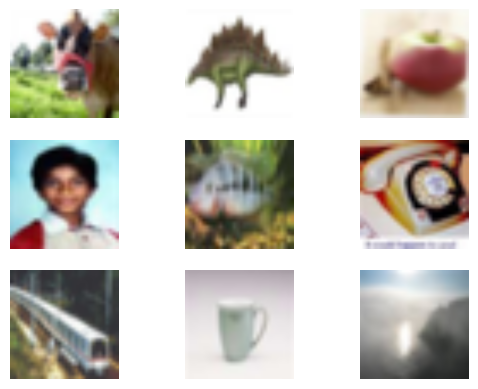

In [11]:
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))

    plt.axis("off")

In [12]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

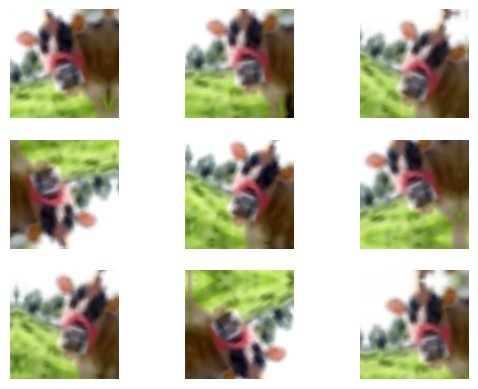

In [13]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.axis("off")

## Data Augmentation

In [14]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label


def input_preprocess_test(image, label):
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

## Model Creataion

In [15]:
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

def get_model():
    model = EfficientNetV2L(
    include_top=False,
    weights=None, # Training from scratch
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    model.trainable = True


    classifier = Sequential([
                             model,
                             GlobalAveragePooling2D(),
                             Dropout(0.1),
                             Dense(NUM_CLASSES, activation = 'softmax')])
    
    
    return classifier

In [16]:
model = get_model()

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'],
              jit_compile = True #Default is True, but here i wanted to show you that we use JIT compilation
             )

In [17]:
model.summary(show_trainable = True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ efficientnetv2-l            │ (None, 7, 7, 1280)    │ 117,746,8… │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 100)           │    128,100 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 117,874,948 (449.66 MB)

 Trainable params: 117,362,372 (447.70 MB)

 Non-trainable params: 512,576 (1.96 MB)

## Training the model

In [18]:
history = model.fit(ds_train, validation_data = ds_test, epochs = 100)

Epoch 1/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 14:42:29 273s/step - accuracy: 0.0156 - loss: 4.6539

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:00:56 19s/step - accuracy: 0.0146 - loss: 4.6678  

  3/195 ━━━━━━━━━━━━━━━━━━━━ 30:52 10s/step - accuracy: 0.0141 - loss: 4.6770  

  4/195 ━━━━━━━━━━━━━━━━━━━━ 20:51 7s/step - accuracy: 0.0133 - loss: 4.6885 

  5/195 ━━━━━━━━━━━━━━━━━━━━ 15:51 5s/step - accuracy: 0.0126 - loss: 4.6987

  6/195 ━━━━━━━━━━━━━━━━━━━━ 12:50 4s/step - accuracy: 0.0122 - loss: 4.7053

  7/195 ━━━━━━━━━━━━━━━━━━━━ 10:50 3s/step - accuracy: 0.0119 - loss: 4.7119

  8/195 ━━━━━━━━━━━━━━━━━━━━ 9:24 3s/step - accuracy: 0.0119 - loss: 4.7160 

  9/195 ━━━━━━━━━━━━━━━━━━━━ 8:19 3s/step - accuracy: 0.0121 - loss: 4.7193

 10/195 ━━━━━━━━━━━━━━━━━━━━ 7:29 2s/step - accuracy: 0.0122 - loss: 4.7209

 12/195 ━━━━━━━━━━━━━━━━━━━━ 6:15 2s/step - accuracy: 0.0123 - loss: 4.7204

 14/195 ━━━━━━━━━━━━━━━━━━━━ 5:24 2s/step - accuracy: 0.0126 - loss: 4.7191

 15/195 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.0127 - loss: 4.7184

 16/195 ━━━━━━━━━━━━━━━━━━━━ 4:47 2s/step - accuracy: 0.0128 - loss: 4.7184

 17/195 ━━━━━━━━━━━━━━━━━━━━ 4:31 2s/step - accuracy: 0.0130 - loss: 4.7178

 21/195 ━━━━━━━━━━━━━━━━━━━━ 3:45 1s/step - accuracy: 0.0137 - loss: 4.7153

 23/195 ━━━━━━━━━━━━━━━━━━━━ 3:28 1s/step - accuracy: 0.0139 - loss: 4.7153

 19/195 ━━━━━━━━━━━━━━━━━━━━ 4:06 1s/step - accuracy: 0.0133 - loss: 4.7153

 26/195 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 0.0142 - loss: 4.7144

 24/195 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.0140 - loss: 4.7134

 22/195 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.0138 - loss: 4.7144

 27/195 ━━━━━━━━━━━━━━━━━━━━ 3:01 1s/step - accuracy: 0.0143 - loss: 4.7124

 30/195 ━━━━━━━━━━━━━━━━━━━━ 2:46 1s/step - accuracy: 0.0146 - loss: 4.7113

 32/195 ━━━━━━━━━━━━━━━━━━━━ 2:37 966ms/step - accuracy: 0.0148 - loss: 4.7113

 33/195 ━━━━━━━━━━━━━━━━━━━━ 2:33 947ms/step - accuracy: 0.0149 - loss: 4.7091

 34/195 ━━━━━━━━━━━━━━━━━━━━ 2:29 930ms/step - accuracy: 0.0150 - loss: 4.7079

 35/195 ━━━━━━━━━━━━━━━━━━━━ 2:26 913ms/step - accuracy: 0.0152 - loss: 4.7079

 36/195 ━━━━━━━━━━━━━━━━━━━━ 2:22 897ms/step - accuracy: 0.0153 - loss: 4.7055

 37/195 ━━━━━━━━━━━━━━━━━━━━ 2:19 883ms/step - accuracy: 0.0154 - loss: 4.7043

 38/195 ━━━━━━━━━━━━━━━━━━━━ 2:16 869ms/step - accuracy: 0.0155 - loss: 4.7019

 39/195 ━━━━━━━━━━━━━━━━━━━━ 2:13 856ms/step - accuracy: 0.0156 - loss: 4.6985

 40/195 ━━━━━━━━━━━━━━━━━━━━ 2:10 843ms/step - accuracy: 0.0157 - loss: 4.6964

 42/195 ━━━━━━━━━━━━━━━━━━━━ 2:05 820ms/step - accuracy: 0.0159 - loss: 4.6935

 44/195 ━━━━━━━━━━━━━━━━━━━━ 2:00 799ms/step - accuracy: 0.0160 - loss: 4.6895

 43/195 ━━━━━━━━━━━━━━━━━━━━ 2:02 809ms/step - accuracy: 0.0160 - loss: 4.6895

 45/195 ━━━━━━━━━━━━━━━━━━━━ 1:58 789ms/step - accuracy: 0.0161 - loss: 4.6886

 48/195 ━━━━━━━━━━━━━━━━━━━━ 1:52 762ms/step - accuracy: 0.0164 - loss: 4.6866

 51/195 ━━━━━━━━━━━━━━━━━━━━ 1:46 738ms/step - accuracy: 0.0166 - loss: 4.6838

 53/195 ━━━━━━━━━━━━━━━━━━━━ 1:42 724ms/step - accuracy: 0.0167 - loss: 4.6838

 55/195 ━━━━━━━━━━━━━━━━━━━━ 1:39 711ms/step - accuracy: 0.0169 - loss: 4.6820

 56/195 ━━━━━━━━━━━━━━━━━━━━ 1:37 705ms/step - accuracy: 0.0169 - loss: 4.6820

 58/195 ━━━━━━━━━━━━━━━━━━━━ 1:34 693ms/step - accuracy: 0.0170 - loss: 4.6820

 61/195 ━━━━━━━━━━━━━━━━━━━━ 1:30 677ms/step - accuracy: 0.0172 - loss: 4.6811

 62/195 ━━━━━━━━━━━━━━━━━━━━ 1:29 672ms/step - accuracy: 0.0172 - loss: 4.6793

 63/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 667ms/step - accuracy: 0.0173 - loss: 4.6793

 64/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 662ms/step - accuracy: 0.0173 - loss: 4.6775

 66/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 653ms/step - accuracy: 0.0174 - loss: 4.6767

 67/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 649ms/step - accuracy: 0.0174 - loss: 4.6750

 68/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 644ms/step - accuracy: 0.0175 - loss: 4.6734

 69/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 640ms/step - accuracy: 0.0175 - loss: 4.6718

 70/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 636ms/step - accuracy: 0.0176 - loss: 4.6703

 71/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 633ms/step - accuracy: 0.0176 - loss: 4.6681

 73/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 625ms/step - accuracy: 0.0177 - loss: 4.6653

 72/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 629ms/step - accuracy: 0.0176 - loss: 4.6667

 74/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 622ms/step - accuracy: 0.0177 - loss: 4.6640

 76/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 615ms/step - accuracy: 0.0178 - loss: 4.6627

 79/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 605ms/step - accuracy: 0.0179 - loss: 4.6615

 81/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 599ms/step - accuracy: 0.0179 - loss: 4.6602

 80/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 602ms/step - accuracy: 0.0179 - loss: 4.6609

 83/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 594ms/step - accuracy: 0.0180 - loss: 4.6596

 88/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 581ms/step - accuracy: 0.0181 - loss: 4.6590

 90/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 576ms/step - accuracy: 0.0181 - loss: 4.6584

 92/195 ━━━━━━━━━━━━━━━━━━━━ 58s 571ms/step - accuracy: 0.0182 - loss: 4.6579 

 93/195 ━━━━━━━━━━━━━━━━━━━━ 58s 569ms/step - accuracy: 0.0182 - loss: 4.6573

 94/195 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.0182 - loss: 4.6573

 95/195 ━━━━━━━━━━━━━━━━━━━━ 56s 565ms/step - accuracy: 0.0183 - loss: 4.6567

 96/195 ━━━━━━━━━━━━━━━━━━━━ 55s 563ms/step - accuracy: 0.0183 - loss: 4.6561

 97/195 ━━━━━━━━━━━━━━━━━━━━ 54s 561ms/step - accuracy: 0.0183 - loss: 4.6555

 98/195 ━━━━━━━━━━━━━━━━━━━━ 54s 559ms/step - accuracy: 0.0183 - loss: 4.6538

 99/195 ━━━━━━━━━━━━━━━━━━━━ 53s 557ms/step - accuracy: 0.0184 - loss: 4.6533

100/195 ━━━━━━━━━━━━━━━━━━━━ 52s 555ms/step - accuracy: 0.0184 - loss: 4.6522

101/195 ━━━━━━━━━━━━━━━━━━━━ 51s 553ms/step - accuracy: 0.0184 - loss: 4.6505

102/195 ━━━━━━━━━━━━━━━━━━━━ 51s 551ms/step - accuracy: 0.0184 - loss: 4.6500

103/195 ━━━━━━━━━━━━━━━━━━━━ 50s 549ms/step - accuracy: 0.0185 - loss: 4.6483

105/195 ━━━━━━━━━━━━━━━━━━━━ 49s 546ms/step - accuracy: 0.0185 - loss: 4.6461

109/195 ━━━━━━━━━━━━━━━━━━━━ 46s 539ms/step - accuracy: 0.0186 - loss: 4.6449

107/195 ━━━━━━━━━━━━━━━━━━━━ 47s 543ms/step - accuracy: 0.0186 - loss: 4.6455

110/195 ━━━━━━━━━━━━━━━━━━━━ 45s 538ms/step - accuracy: 0.0186 - loss: 4.6438

112/195 ━━━━━━━━━━━━━━━━━━━━ 44s 535ms/step - accuracy: 0.0187 - loss: 4.6438

114/195 ━━━━━━━━━━━━━━━━━━━━ 43s 532ms/step - accuracy: 0.0187 - loss: 4.6433

116/195 ━━━━━━━━━━━━━━━━━━━━ 41s 529ms/step - accuracy: 0.0188 - loss: 4.6427

120/195 ━━━━━━━━━━━━━━━━━━━━ 39s 523ms/step - accuracy: 0.0189 - loss: 4.6416

119/195 ━━━━━━━━━━━━━━━━━━━━ 39s 525ms/step - accuracy: 0.0188 - loss: 4.6416

121/195 ━━━━━━━━━━━━━━━━━━━━ 38s 522ms/step - accuracy: 0.0189 - loss: 4.6416

122/195 ━━━━━━━━━━━━━━━━━━━━ 38s 521ms/step - accuracy: 0.0189 - loss: 4.6406

124/195 ━━━━━━━━━━━━━━━━━━━━ 36s 518ms/step - accuracy: 0.0189 - loss: 4.6406

125/195 ━━━━━━━━━━━━━━━━━━━━ 36s 517ms/step - accuracy: 0.0190 - loss: 4.6396

126/195 ━━━━━━━━━━━━━━━━━━━━ 35s 516ms/step - accuracy: 0.0190 - loss: 4.6396

127/195 ━━━━━━━━━━━━━━━━━━━━ 35s 515ms/step - accuracy: 0.0190 - loss: 4.6391

128/195 ━━━━━━━━━━━━━━━━━━━━ 34s 514ms/step - accuracy: 0.0190 - loss: 4.6377

129/195 ━━━━━━━━━━━━━━━━━━━━ 33s 513ms/step - accuracy: 0.0191 - loss: 4.6369

130/195 ━━━━━━━━━━━━━━━━━━━━ 33s 511ms/step - accuracy: 0.0191 - loss: 4.6364

131/195 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - accuracy: 0.0191 - loss: 4.6352

133/195 ━━━━━━━━━━━━━━━━━━━━ 31s 508ms/step - accuracy: 0.0192 - loss: 4.6341

132/195 ━━━━━━━━━━━━━━━━━━━━ 32s 509ms/step - accuracy: 0.0191 - loss: 4.6349

134/195 ━━━━━━━━━━━━━━━━━━━━ 30s 507ms/step - accuracy: 0.0192 - loss: 4.6334

136/195 ━━━━━━━━━━━━━━━━━━━━ 29s 505ms/step - accuracy: 0.0192 - loss: 4.6324

139/195 ━━━━━━━━━━━━━━━━━━━━ 28s 502ms/step - accuracy: 0.0193 - loss: 4.6314

140/195 ━━━━━━━━━━━━━━━━━━━━ 27s 501ms/step - accuracy: 0.0193 - loss: 4.6314

137/195 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - accuracy: 0.0192 - loss: 4.6317

141/195 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.0193 - loss: 4.6311

143/195 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.0193 - loss: 4.6308

149/195 ━━━━━━━━━━━━━━━━━━━━ 22s 493ms/step - accuracy: 0.0194 - loss: 4.6305

147/195 ━━━━━━━━━━━━━━━━━━━━ 23s 495ms/step - accuracy: 0.0194 - loss: 4.6302

148/195 ━━━━━━━━━━━━━━━━━━━━ 23s 494ms/step - accuracy: 0.0194 - loss: 4.6305

151/195 ━━━━━━━━━━━━━━━━━━━━ 21s 491ms/step - accuracy: 0.0195 - loss: 4.6299

152/195 ━━━━━━━━━━━━━━━━━━━━ 21s 490ms/step - accuracy: 0.0195 - loss: 4.6299

153/195 ━━━━━━━━━━━━━━━━━━━━ 20s 490ms/step - accuracy: 0.0195 - loss: 4.6296

154/195 ━━━━━━━━━━━━━━━━━━━━ 20s 489ms/step - accuracy: 0.0195 - loss: 4.6290

155/195 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - accuracy: 0.0195 - loss: 4.6287

156/195 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - accuracy: 0.0196 - loss: 4.6287

157/195 ━━━━━━━━━━━━━━━━━━━━ 18s 487ms/step - accuracy: 0.0196 - loss: 4.6282

159/195 ━━━━━━━━━━━━━━━━━━━━ 17s 485ms/step - accuracy: 0.0196 - loss: 4.6266

160/195 ━━━━━━━━━━━━━━━━━━━━ 16s 484ms/step - accuracy: 0.0196 - loss: 4.6261

161/195 ━━━━━━━━━━━━━━━━━━━━ 16s 484ms/step - accuracy: 0.0196 - loss: 4.6256

162/195 ━━━━━━━━━━━━━━━━━━━━ 16s 487ms/step - accuracy: 0.0197 - loss: 4.6254

165/195 ━━━━━━━━━━━━━━━━━━━━ 14s 481ms/step - accuracy: 0.0197 - loss: 4.6247

166/195 ━━━━━━━━━━━━━━━━━━━━ 13s 480ms/step - accuracy: 0.0197 - loss: 4.6242

167/195 ━━━━━━━━━━━━━━━━━━━━ 13s 479ms/step - accuracy: 0.0197 - loss: 4.6240

168/195 ━━━━━━━━━━━━━━━━━━━━ 12s 479ms/step - accuracy: 0.0197 - loss: 4.6237

169/195 ━━━━━━━━━━━━━━━━━━━━ 12s 478ms/step - accuracy: 0.0197 - loss: 4.6233

170/195 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.0197 - loss: 4.6230

172/195 ━━━━━━━━━━━━━━━━━━━━ 10s 476ms/step - accuracy: 0.0198 - loss: 4.6230

173/195 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step - accuracy: 0.0198 - loss: 4.6228

174/195 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - accuracy: 0.0198 - loss: 4.6228 

175/195 ━━━━━━━━━━━━━━━━━━━━ 9s 474ms/step - accuracy: 0.0198 - loss: 4.6226

177/195 ━━━━━━━━━━━━━━━━━━━━ 8s 473ms/step - accuracy: 0.0198 - loss: 4.6226

179/195 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step - accuracy: 0.0198 - loss: 4.6224

180/195 ━━━━━━━━━━━━━━━━━━━━ 7s 471ms/step - accuracy: 0.0198 - loss: 4.6219

181/195 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.0199 - loss: 4.6219

182/195 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - accuracy: 0.0199 - loss: 4.6214

183/195 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - accuracy: 0.0199 - loss: 4.6214

187/195 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.0199 - loss: 4.6205

184/195 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.0199 - loss: 4.6212

186/195 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - accuracy: 0.0199 - loss: 4.6208

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.0199 - loss: 4.6197

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.0199 - loss: 4.6199

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.0200 - loss: 4.6197

190/195 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 0.0199 - loss: 4.6197

195/195 ━━━━━━━━━━━━━━━━━━━━ 401s 662ms/step - accuracy: 0.0200 - loss: 4.6194 - val_accuracy: 0.0199 - val_loss: 4.4683


Epoch 2/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 901ms/step - accuracy: 0.0273 - loss: 4.5393

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 359ms/step - accuracy: 0.0264 - loss: 4.5358

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 363ms/step - accuracy: 0.0271 - loss: 4.5399

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 365ms/step - accuracy: 0.0272 - loss: 4.5432

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 366ms/step - accuracy: 0.0269 - loss: 4.5475

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 366ms/step - accuracy: 0.0265 - loss: 4.5500

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 366ms/step - accuracy: 0.0259 - loss: 4.5522

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.0254 - loss: 4.5530

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.0251 - loss: 4.5541

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.0248 - loss: 4.5549

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.0246 - loss: 4.5556

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 367ms/step - accuracy: 0.0237 - loss: 4.5567

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 367ms/step - accuracy: 0.0229 - loss: 4.5567

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 367ms/step - accuracy: 0.0231 - loss: 4.5567

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 367ms/step - accuracy: 0.0227 - loss: 4.5567

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.0217 - loss: 4.5566

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.0225 - loss: 4.5567

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.0215 - loss: 4.5564

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.0214 - loss: 4.5564

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 367ms/step - accuracy: 0.0213 - loss: 4.5564

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.0212 - loss: 4.5562

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.0216 - loss: 4.5564

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.0212 - loss: 4.5559

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.0211 - loss: 4.5556 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.0210 - loss: 4.5550

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.0210 - loss: 4.5547

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.0209 - loss: 4.5547

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.0209 - loss: 4.5540

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.0209 - loss: 4.5536

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.0209 - loss: 4.5529

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.0209 - loss: 4.5520

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.0209 - loss: 4.5511

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.0209 - loss: 4.5502

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.0209 - loss: 4.5493

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.0210 - loss: 4.5481

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.0210 - loss: 4.5469

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.0210 - loss: 4.5461

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.0210 - loss: 4.5461

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.0211 - loss: 4.5453

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.0211 - loss: 4.5457

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.0211 - loss: 4.5445

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.0212 - loss: 4.5438

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.0212 - loss: 4.5438

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.0213 - loss: 4.5438

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.0213 - loss: 4.5433

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.0214 - loss: 4.5429

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.0214 - loss: 4.5425

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.0214 - loss: 4.5425

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.0215 - loss: 4.5413

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.0215 - loss: 4.5400

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 371ms/step - accuracy: 0.0216 - loss: 4.5392

 70/195 ━━━━━━━━━━━━━━━━━━━━ 47s 377ms/step - accuracy: 0.0215 - loss: 4.5396

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0216 - loss: 4.5384

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0217 - loss: 4.5375

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0217 - loss: 4.5364

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.0217 - loss: 4.5356

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.0218 - loss: 4.5341

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.0218 - loss: 4.5341

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.0218 - loss: 4.5344

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.0219 - loss: 4.5334

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.0219 - loss: 4.5330

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.0219 - loss: 4.5334

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.0220 - loss: 4.5327

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.0221 - loss: 4.5327

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.0221 - loss: 4.5320

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.0221 - loss: 4.5317

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.0222 - loss: 4.5317

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0222 - loss: 4.5310

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0222 - loss: 4.5307

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0222 - loss: 4.5307

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.0222 - loss: 4.5300

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.0223 - loss: 4.5294

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0223 - loss: 4.5288

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0223 - loss: 4.5281

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0223 - loss: 4.5272

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.0223 - loss: 4.5265

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.0224 - loss: 4.5252

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.0224 - loss: 4.5249

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.0225 - loss: 4.5236

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.0226 - loss: 4.5236

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.0226 - loss: 4.5230

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.0227 - loss: 4.5230

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0228 - loss: 4.5223

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0227 - loss: 4.5223

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0228 - loss: 4.5220

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.0228 - loss: 4.5216

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.0228 - loss: 4.5210

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.0228 - loss: 4.5207

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.0229 - loss: 4.5197

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.0229 - loss: 4.5191

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0229 - loss: 4.5185

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0229 - loss: 4.5179

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0230 - loss: 4.5172

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0230 - loss: 4.5160

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0230 - loss: 4.5166

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0231 - loss: 4.5150

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0232 - loss: 4.5141

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0233 - loss: 4.5138

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0235 - loss: 4.5135

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0234 - loss: 4.5131

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0235 - loss: 4.5128

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0235 - loss: 4.5128

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0236 - loss: 4.5125

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0236 - loss: 4.5118

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0236 - loss: 4.5115

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0236 - loss: 4.5109

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0237 - loss: 4.5099

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0237 - loss: 4.5096

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0237 - loss: 4.5085

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0237 - loss: 4.5079

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0238 - loss: 4.5072

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0238 - loss: 4.5065

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0239 - loss: 4.5044 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0238 - loss: 4.5047

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0239 - loss: 4.5044 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0239 - loss: 4.5040

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0240 - loss: 4.5036

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0239 - loss: 4.5036

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0240 - loss: 4.5036

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0240 - loss: 4.5033

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0242 - loss: 4.5026

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0242 - loss: 4.5022

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0243 - loss: 4.5018

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0243 - loss: 4.5015

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0245 - loss: 4.4997

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0244 - loss: 4.4997

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0245 - loss: 4.4993

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0245 - loss: 4.4993

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0244 - loss: 4.4993

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.0246 - loss: 4.4989 - val_accuracy: 0.0516 - val_loss: 4.2073


Epoch 3/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:56 910ms/step - accuracy: 0.0508 - loss: 4.2676

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.0527 - loss: 4.2522

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.0512 - loss: 4.2494

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.0501 - loss: 4.2486

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.0503 - loss: 4.2508

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.0502 - loss: 4.2489

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.0501 - loss: 4.2474

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.0497 - loss: 4.2464

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.0493 - loss: 4.2441

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.0492 - loss: 4.2430

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.0489 - loss: 4.2393

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.0490 - loss: 4.2358

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.0490 - loss: 4.2366

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.0493 - loss: 4.2342

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.0491 - loss: 4.2342

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.0494 - loss: 4.2335

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.0502 - loss: 4.2312

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.0506 - loss: 4.2304

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.0507 - loss: 4.2304

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.0508 - loss: 4.2304

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.0511 - loss: 4.2288 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.0511 - loss: 4.2296

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.0512 - loss: 4.2272 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.0511 - loss: 4.2264 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.0513 - loss: 4.2264

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.0513 - loss: 4.2257

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.0513 - loss: 4.2242

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.0514 - loss: 4.2229

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.0514 - loss: 4.2215

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.0515 - loss: 4.2194

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.0515 - loss: 4.2187

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.0516 - loss: 4.2174

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.0516 - loss: 4.2155

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.0518 - loss: 4.2132

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.0518 - loss: 4.2138

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.0519 - loss: 4.2127

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.0519 - loss: 4.2115

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.0519 - loss: 4.2121

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.0520 - loss: 4.2105

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.0521 - loss: 4.2105

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.0521 - loss: 4.2105

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.0522 - loss: 4.2095

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.0522 - loss: 4.2085

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.0523 - loss: 4.2075

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.0523 - loss: 4.2075

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.0523 - loss: 4.2075

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.0524 - loss: 4.2064

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.0524 - loss: 4.2048

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.0524 - loss: 4.2043

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.0525 - loss: 4.2033

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0525 - loss: 4.2012

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0526 - loss: 4.2006

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.0527 - loss: 4.1984

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.0527 - loss: 4.1973

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.0531 - loss: 4.1933

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.0530 - loss: 4.1938

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.0528 - loss: 4.1963

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.0533 - loss: 4.1929

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.0535 - loss: 4.1929

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.0534 - loss: 4.1929

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0539 - loss: 4.1919

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0539 - loss: 4.1914

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.0540 - loss: 4.1904

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0541 - loss: 4.1904

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0541 - loss: 4.1889

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0542 - loss: 4.1879

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.0542 - loss: 4.1874

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.0543 - loss: 4.1863

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.0544 - loss: 4.1853

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.0544 - loss: 4.1843

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.0545 - loss: 4.1832

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.0546 - loss: 4.1812

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.0547 - loss: 4.1796

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.0550 - loss: 4.1775

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.0548 - loss: 4.1775

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.0551 - loss: 4.1765

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.0551 - loss: 4.1765

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.0552 - loss: 4.1760

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0554 - loss: 4.1760

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0554 - loss: 4.1760

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.0555 - loss: 4.1760

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.0556 - loss: 4.1749

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.0557 - loss: 4.1744

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.0557 - loss: 4.1739

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0558 - loss: 4.1734

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0559 - loss: 4.1734

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0559 - loss: 4.1729

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0560 - loss: 4.1713

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0561 - loss: 4.1708

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0561 - loss: 4.1698

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0562 - loss: 4.1682

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0562 - loss: 4.1677

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0564 - loss: 4.1651

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0565 - loss: 4.1635

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0566 - loss: 4.1635

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0566 - loss: 4.1630

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0568 - loss: 4.1620

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0568 - loss: 4.1615

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0569 - loss: 4.1610

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0572 - loss: 4.1605

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0573 - loss: 4.1605

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0571 - loss: 4.1605

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0572 - loss: 4.1600

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0574 - loss: 4.1595

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0575 - loss: 4.1595

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0575 - loss: 4.1590

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0576 - loss: 4.1585

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0576 - loss: 4.1575

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0577 - loss: 4.1570

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0577 - loss: 4.1565

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0578 - loss: 4.1551

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0578 - loss: 4.1541

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0579 - loss: 4.1531

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0580 - loss: 4.1526 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0580 - loss: 4.1511

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0581 - loss: 4.1496

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0582 - loss: 4.1486

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0581 - loss: 4.1491

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0583 - loss: 4.1486

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0583 - loss: 4.1482

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0585 - loss: 4.1472

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0585 - loss: 4.1467

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0586 - loss: 4.1467

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0586 - loss: 4.1467

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0588 - loss: 4.1457

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0588 - loss: 4.1457

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0590 - loss: 4.1448

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0591 - loss: 4.1448

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0593 - loss: 4.1438

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0592 - loss: 4.1438

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0594 - loss: 4.1434

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.0595 - loss: 4.1429 - val_accuracy: 0.0994 - val_loss: 3.8328


Epoch 4/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:57 915ms/step - accuracy: 0.1016 - loss: 3.9185

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 388ms/step - accuracy: 0.0938 - loss: 3.9047

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.0907 - loss: 3.8977

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.0890 - loss: 3.8974

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.0890 - loss: 3.8980

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.0890 - loss: 3.8962

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.0890 - loss: 3.8945

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.0887 - loss: 3.8937

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.0889 - loss: 3.8935

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.0891 - loss: 3.8925

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.0894 - loss: 3.8911

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.0896 - loss: 3.8908

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.0898 - loss: 3.8901

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.0901 - loss: 3.8891

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.0902 - loss: 3.8886

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.0910 - loss: 3.8878

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.0907 - loss: 3.8882

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.0912 - loss: 3.8870

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.0908 - loss: 3.8873

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.0913 - loss: 3.8870

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.0914 - loss: 3.8866

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.0914 - loss: 3.8866

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.0915 - loss: 3.8861

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.0917 - loss: 3.8857

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.0917 - loss: 3.8857 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.0918 - loss: 3.8852

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.0918 - loss: 3.8838

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.0918 - loss: 3.8833

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.0919 - loss: 3.8829

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.0919 - loss: 3.8825

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.0919 - loss: 3.8815

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.0919 - loss: 3.8806

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.0920 - loss: 3.8797

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.0920 - loss: 3.8789

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.0921 - loss: 3.8781

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.0922 - loss: 3.8771

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.0922 - loss: 3.8771

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.0923 - loss: 3.8760

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.0924 - loss: 3.8760

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.0925 - loss: 3.8757

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.0926 - loss: 3.8750

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.0926 - loss: 3.8750

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.0928 - loss: 3.8744

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.0930 - loss: 3.8744

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.0929 - loss: 3.8744

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.0931 - loss: 3.8741

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.0932 - loss: 3.8737

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.0932 - loss: 3.8734

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.0933 - loss: 3.8727

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.0934 - loss: 3.8727

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.0934 - loss: 3.8723

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.0935 - loss: 3.8719

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.0935 - loss: 3.8708

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.0936 - loss: 3.8704

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.0936 - loss: 3.8693

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.0937 - loss: 3.8689

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0938 - loss: 3.8673

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0938 - loss: 3.8681

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.0939 - loss: 3.8664

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.0942 - loss: 3.8649

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 372ms/step - accuracy: 0.0941 - loss: 3.8653

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.0940 - loss: 3.8653

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.0940 - loss: 3.8656

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.0942 - loss: 3.8649

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.0944 - loss: 3.8645

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.0945 - loss: 3.8638

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.0947 - loss: 3.8638

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.0946 - loss: 3.8638

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.0948 - loss: 3.8635

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.0949 - loss: 3.8632

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.0950 - loss: 3.8625

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.0951 - loss: 3.8622

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0953 - loss: 3.8618

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.0952 - loss: 3.8618

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0953 - loss: 3.8611

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.0954 - loss: 3.8604

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.0955 - loss: 3.8597

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.0955 - loss: 3.8589

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0956 - loss: 3.8582

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0957 - loss: 3.8565

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.0959 - loss: 3.8554

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.0957 - loss: 3.8557

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.0960 - loss: 3.8546

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.0961 - loss: 3.8533

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.0961 - loss: 3.8533

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.0962 - loss: 3.8533

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.0964 - loss: 3.8525

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.0968 - loss: 3.8525

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.0966 - loss: 3.8525

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.0966 - loss: 3.8521

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.0969 - loss: 3.8521

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.0968 - loss: 3.8521

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.0970 - loss: 3.8513

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.0970 - loss: 3.8509

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0972 - loss: 3.8505

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.0973 - loss: 3.8505

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.0973 - loss: 3.8497

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.0974 - loss: 3.8493

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.0975 - loss: 3.8489

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.0975 - loss: 3.8481

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.0976 - loss: 3.8473

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0977 - loss: 3.8465

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0978 - loss: 3.8444

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.0978 - loss: 3.8456

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0979 - loss: 3.8431

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0980 - loss: 3.8423

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0981 - loss: 3.8423

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0983 - loss: 3.8410

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0982 - loss: 3.8419

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0984 - loss: 3.8410

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0985 - loss: 3.8410

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0987 - loss: 3.8406

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0988 - loss: 3.8402

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0988 - loss: 3.8402

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0991 - loss: 3.8397

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0992 - loss: 3.8389

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0993 - loss: 3.8381

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0994 - loss: 3.8377

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0995 - loss: 3.8373

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0996 - loss: 3.8369

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0996 - loss: 3.8361

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0997 - loss: 3.8353

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0998 - loss: 3.8345

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0998 - loss: 3.8338

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0999 - loss: 3.8326

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1000 - loss: 3.8319

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1001 - loss: 3.8311

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1002 - loss: 3.8308

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1002 - loss: 3.8308

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1004 - loss: 3.8293 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1005 - loss: 3.8293 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1003 - loss: 3.8297 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1007 - loss: 3.8293

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1008 - loss: 3.8285

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1008 - loss: 3.8285

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1010 - loss: 3.8285

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1010 - loss: 3.8285

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1011 - loss: 3.8282

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1011 - loss: 3.8274

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1012 - loss: 3.8271

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1013 - loss: 3.8271

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1013 - loss: 3.8264

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.1014 - loss: 3.8253

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1015 - loss: 3.8246

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1017 - loss: 3.8242

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1016 - loss: 3.8242

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1018 - loss: 3.8239

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1018 - loss: 3.8239

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.1020 - loss: 3.8235 - val_accuracy: 0.1453 - val_loss: 3.5466


Epoch 5/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 892ms/step - accuracy: 0.1094 - loss: 3.7658

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 385ms/step - accuracy: 0.1113 - loss: 3.7037

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.1102 - loss: 3.6810

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.1120 - loss: 3.6751

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.1140 - loss: 3.6650

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.1167 - loss: 3.6570

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.1188 - loss: 3.6496

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.1204 - loss: 3.6453

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.1220 - loss: 3.6408

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.1233 - loss: 3.6396

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.1251 - loss: 3.6353

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.1267 - loss: 3.6331

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.1260 - loss: 3.6338

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.1273 - loss: 3.6326

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.1286 - loss: 3.6312

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.1282 - loss: 3.6316

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.1292 - loss: 3.6309

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.1303 - loss: 3.6301

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.1299 - loss: 3.6301

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.1306 - loss: 3.6298

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.1301 - loss: 3.6301

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.1307 - loss: 3.6293

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.1308 - loss: 3.6293

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.1310 - loss: 3.6288 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.1311 - loss: 3.6282

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.1311 - loss: 3.6276

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.1313 - loss: 3.6276

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.1314 - loss: 3.6270

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.1315 - loss: 3.6254

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.1316 - loss: 3.6248

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.1317 - loss: 3.6230

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.1318 - loss: 3.6218

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.1319 - loss: 3.6207

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.1321 - loss: 3.6186

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.1324 - loss: 3.6167

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.1325 - loss: 3.6167

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.1326 - loss: 3.6167

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.1330 - loss: 3.6158

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.1336 - loss: 3.6144

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.1329 - loss: 3.6153

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.1328 - loss: 3.6158

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.1338 - loss: 3.6141

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.1340 - loss: 3.6137

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.1341 - loss: 3.6137

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.1342 - loss: 3.6128

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.1344 - loss: 3.6117

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 373ms/step - accuracy: 0.1345 - loss: 3.6113

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.1349 - loss: 3.6105

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.1350 - loss: 3.6098

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.1351 - loss: 3.6090

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.1351 - loss: 3.6078

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.1352 - loss: 3.6070

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.1353 - loss: 3.6062

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.1354 - loss: 3.6058

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.1356 - loss: 3.6042

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.1355 - loss: 3.6046

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.1357 - loss: 3.6031

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.1358 - loss: 3.6027

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.1360 - loss: 3.6016

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.1361 - loss: 3.6010

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.1362 - loss: 3.6013

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.1365 - loss: 3.6007

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.1364 - loss: 3.6007

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.1367 - loss: 3.6003

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.1366 - loss: 3.6003

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.1368 - loss: 3.6003

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.1368 - loss: 3.6003

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.1370 - loss: 3.6000

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.1369 - loss: 3.6000

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.1370 - loss: 3.5993

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.1371 - loss: 3.5993

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.1372 - loss: 3.5987

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.1372 - loss: 3.5987

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.1373 - loss: 3.5983

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.1373 - loss: 3.5977

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.1374 - loss: 3.5970

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.1375 - loss: 3.5959

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.1375 - loss: 3.5956

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.1376 - loss: 3.5949

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.1377 - loss: 3.5942

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.1377 - loss: 3.5935

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.1379 - loss: 3.5925

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.1378 - loss: 3.5925

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.1380 - loss: 3.5921

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.1380 - loss: 3.5921

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.1382 - loss: 3.5914

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.1384 - loss: 3.5904

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.1385 - loss: 3.5907

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.1387 - loss: 3.5900

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.1387 - loss: 3.5897

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.1388 - loss: 3.5897

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.1390 - loss: 3.5897

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.1390 - loss: 3.5890

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.1392 - loss: 3.5887

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.1392 - loss: 3.5883

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.1394 - loss: 3.5876

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.1395 - loss: 3.5873

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1395 - loss: 3.5863

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1396 - loss: 3.5859

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1397 - loss: 3.5852

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1398 - loss: 3.5830

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1401 - loss: 3.5812

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1400 - loss: 3.5819

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1401 - loss: 3.5812

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1403 - loss: 3.5802

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1405 - loss: 3.5798

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1405 - loss: 3.5802

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1404 - loss: 3.5802

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1408 - loss: 3.5795

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1406 - loss: 3.5802

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1409 - loss: 3.5795

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1411 - loss: 3.5795

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1407 - loss: 3.5798

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1412 - loss: 3.5789

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1413 - loss: 3.5785

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1414 - loss: 3.5782

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1415 - loss: 3.5782

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1416 - loss: 3.5779

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1417 - loss: 3.5773

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1417 - loss: 3.5770

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1418 - loss: 3.5767

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1419 - loss: 3.5757

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1419 - loss: 3.5751

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1420 - loss: 3.5748

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1421 - loss: 3.5736 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1422 - loss: 3.5726 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1422 - loss: 3.5729 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1424 - loss: 3.5717

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1425 - loss: 3.5714

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1426 - loss: 3.5711

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1428 - loss: 3.5702

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1427 - loss: 3.5708

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1430 - loss: 3.5702

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1426 - loss: 3.5708

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1430 - loss: 3.5702

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.1432 - loss: 3.5696

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1431 - loss: 3.5699

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1433 - loss: 3.5693

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1434 - loss: 3.5693

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.1433 - loss: 3.5696

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1438 - loss: 3.5684

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1437 - loss: 3.5681

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1436 - loss: 3.5681

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1438 - loss: 3.5681

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.1439 - loss: 3.5678 - val_accuracy: 0.1853 - val_loss: 3.3366


Epoch 6/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 879ms/step - accuracy: 0.1367 - loss: 3.5145

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.1465 - loss: 3.4903

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.1484 - loss: 3.4558

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.1494 - loss: 3.4477

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.1533 - loss: 3.4365

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.1558 - loss: 3.4279

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.1573 - loss: 3.4179

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.1587 - loss: 3.4120

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.1598 - loss: 3.4082

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.1605 - loss: 3.4056

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.1613 - loss: 3.4025

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.1626 - loss: 3.3994

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.1635 - loss: 3.3981

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.1647 - loss: 3.3981

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.1668 - loss: 3.3965

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.1652 - loss: 3.3974

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.1672 - loss: 3.3960

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.1676 - loss: 3.3960

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.1680 - loss: 3.3960

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.1687 - loss: 3.3953

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.1690 - loss: 3.3953

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.1699 - loss: 3.3949

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.1696 - loss: 3.3949

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.1702 - loss: 3.3940 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.1704 - loss: 3.3940

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.1705 - loss: 3.3935

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.1707 - loss: 3.3928

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.1709 - loss: 3.3924

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.1711 - loss: 3.3919

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.1712 - loss: 3.3905

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.1714 - loss: 3.3895

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.1716 - loss: 3.3890

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.1717 - loss: 3.3882

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.1719 - loss: 3.3869

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.1721 - loss: 3.3862

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.1727 - loss: 3.3849

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.1731 - loss: 3.3846

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.1734 - loss: 3.3843

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.1736 - loss: 3.3843

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.1733 - loss: 3.3843

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.1737 - loss: 3.3838

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.1742 - loss: 3.3836

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.1744 - loss: 3.3834

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.1748 - loss: 3.3829

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.1748 - loss: 3.3829

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.1749 - loss: 3.3829

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.1750 - loss: 3.3826

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.1751 - loss: 3.3820

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.1752 - loss: 3.3815

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.1753 - loss: 3.3810

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.1754 - loss: 3.3802

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 373ms/step - accuracy: 0.1755 - loss: 3.3802

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.1758 - loss: 3.3793

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.1759 - loss: 3.3790

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.1761 - loss: 3.3774

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.1760 - loss: 3.3780

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.1763 - loss: 3.3763

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.1762 - loss: 3.3765

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.1766 - loss: 3.3757

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.1765 - loss: 3.3763

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.1767 - loss: 3.3755

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.1768 - loss: 3.3757

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.1770 - loss: 3.3757

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.1771 - loss: 3.3755

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.1773 - loss: 3.3750

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.1774 - loss: 3.3752

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.1776 - loss: 3.3750

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.1777 - loss: 3.3745

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.1777 - loss: 3.3743

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.1779 - loss: 3.3741

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.1779 - loss: 3.3738

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.1780 - loss: 3.3734

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.1780 - loss: 3.3729

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.1781 - loss: 3.3724

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.1782 - loss: 3.3716

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.1782 - loss: 3.3713

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.1784 - loss: 3.3702

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.1784 - loss: 3.3697

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.1785 - loss: 3.3686

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.1785 - loss: 3.3692

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.1787 - loss: 3.3683

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.1788 - loss: 3.3681

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.1790 - loss: 3.3675

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.1790 - loss: 3.3678

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.1792 - loss: 3.3672

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.1793 - loss: 3.3675

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.1793 - loss: 3.3669

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.1792 - loss: 3.3669

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.1794 - loss: 3.3666

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.1795 - loss: 3.3666

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.1796 - loss: 3.3661

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.1796 - loss: 3.3661

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.1797 - loss: 3.3655

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.1797 - loss: 3.3655

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.1798 - loss: 3.3647

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.1799 - loss: 3.3641

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.1799 - loss: 3.3635

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.1800 - loss: 3.3626

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1800 - loss: 3.3623

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1801 - loss: 3.3611

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1801 - loss: 3.3617

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1802 - loss: 3.3605

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1803 - loss: 3.3602

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1804 - loss: 3.3596

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1807 - loss: 3.3587

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1806 - loss: 3.3587

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1806 - loss: 3.3587

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1809 - loss: 3.3587

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1808 - loss: 3.3587

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1810 - loss: 3.3582

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1810 - loss: 3.3582

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1811 - loss: 3.3579

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1812 - loss: 3.3579

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1813 - loss: 3.3576

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1814 - loss: 3.3574

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1814 - loss: 3.3568

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1815 - loss: 3.3566

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1815 - loss: 3.3566

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1816 - loss: 3.3560

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1816 - loss: 3.3552

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1817 - loss: 3.3547

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1817 - loss: 3.3544

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1817 - loss: 3.3539

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1818 - loss: 3.3529

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1818 - loss: 3.3526

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1819 - loss: 3.3526

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1820 - loss: 3.3515 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1821 - loss: 3.3512

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1822 - loss: 3.3510

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1824 - loss: 3.3504

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1823 - loss: 3.3507

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1825 - loss: 3.3504

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1827 - loss: 3.3499

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1828 - loss: 3.3496

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1831 - loss: 3.3486

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1833 - loss: 3.3481

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1832 - loss: 3.3478

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1833 - loss: 3.3478

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1834 - loss: 3.3478

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.1834 - loss: 3.3476 - val_accuracy: 0.2245 - val_loss: 3.1188


Epoch 7/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 895ms/step - accuracy: 0.2109 - loss: 3.3199

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.2139 - loss: 3.3104

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.2129 - loss: 3.2952

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.2131 - loss: 3.2740

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.2144 - loss: 3.2653

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.2147 - loss: 3.2565

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.2149 - loss: 3.2475

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.2145 - loss: 3.2355

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.2143 - loss: 3.2302

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2136 - loss: 3.2213

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.2137 - loss: 3.2263

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2135 - loss: 3.2182

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.2130 - loss: 3.2108

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.2133 - loss: 3.2119

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.2136 - loss: 3.2119

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.2123 - loss: 3.2088

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.2127 - loss: 3.2108

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.2119 - loss: 3.2088

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.2117 - loss: 3.2088

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.2115 - loss: 3.2078

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.2115 - loss: 3.2068

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2115 - loss: 3.2058 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2115 - loss: 3.2058 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2115 - loss: 3.2048

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2115 - loss: 3.2038

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2115 - loss: 3.2028

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2115 - loss: 3.2011

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2115 - loss: 3.1984

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2116 - loss: 3.1967

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2116 - loss: 3.1950

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2116 - loss: 3.1934

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2117 - loss: 3.1904

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2117 - loss: 3.1919

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2118 - loss: 3.1880

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2119 - loss: 3.1874

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2120 - loss: 3.1863

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.2124 - loss: 3.1854

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.2123 - loss: 3.1851

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.2126 - loss: 3.1851

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.2128 - loss: 3.1847

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2130 - loss: 3.1847

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.2132 - loss: 3.1839

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.2133 - loss: 3.1835

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.2134 - loss: 3.1831

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2134 - loss: 3.1823

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.2135 - loss: 3.1823

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2135 - loss: 3.1820

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2136 - loss: 3.1813

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2136 - loss: 3.1810

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2137 - loss: 3.1800

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2137 - loss: 3.1794

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2138 - loss: 3.1788

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2138 - loss: 3.1782

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2138 - loss: 3.1773

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.2140 - loss: 3.1758

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2139 - loss: 3.1764

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.2140 - loss: 3.1758

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2141 - loss: 3.1753

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2141 - loss: 3.1756

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2140 - loss: 3.1756

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2142 - loss: 3.1752

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.2143 - loss: 3.1752

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2144 - loss: 3.1749

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2144 - loss: 3.1749

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2144 - loss: 3.1747

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2144 - loss: 3.1749

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.2145 - loss: 3.1749

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2145 - loss: 3.1747

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2145 - loss: 3.1745

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2146 - loss: 3.1741

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2146 - loss: 3.1739

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2146 - loss: 3.1735

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2146 - loss: 3.1733

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2147 - loss: 3.1729

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2147 - loss: 3.1725

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2148 - loss: 3.1718

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2148 - loss: 3.1714

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.2149 - loss: 3.1705

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.2148 - loss: 3.1707

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2150 - loss: 3.1696

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.2151 - loss: 3.1692

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2151 - loss: 3.1692

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.2151 - loss: 3.1690

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.2152 - loss: 3.1690

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.2153 - loss: 3.1685

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2155 - loss: 3.1681

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2156 - loss: 3.1681

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2157 - loss: 3.1681

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2156 - loss: 3.1683

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2157 - loss: 3.1678

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2157 - loss: 3.1678

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2158 - loss: 3.1676

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2159 - loss: 3.1670

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2159 - loss: 3.1663

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2160 - loss: 3.1661

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2160 - loss: 3.1657

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2160 - loss: 3.1647

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2161 - loss: 3.1641

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2161 - loss: 3.1645

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2162 - loss: 3.1636

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2163 - loss: 3.1623

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2165 - loss: 3.1621

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2166 - loss: 3.1616

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.2168 - loss: 3.1616

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2166 - loss: 3.1616

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2169 - loss: 3.1612

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2170 - loss: 3.1610

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2170 - loss: 3.1610

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2170 - loss: 3.1608

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2171 - loss: 3.1608

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2171 - loss: 3.1604

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2171 - loss: 3.1602

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2172 - loss: 3.1598

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2172 - loss: 3.1594

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2172 - loss: 3.1590

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2173 - loss: 3.1586 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2173 - loss: 3.1582

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2173 - loss: 3.1575

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2174 - loss: 3.1567

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2175 - loss: 3.1559

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2175 - loss: 3.1561

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2177 - loss: 3.1555

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2176 - loss: 3.1555

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2177 - loss: 3.1553

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2178 - loss: 3.1553

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2182 - loss: 3.1547

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2182 - loss: 3.1545

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2182 - loss: 3.1545

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2183 - loss: 3.1545

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.2183 - loss: 3.1543 - val_accuracy: 0.2499 - val_loss: 2.9894


Epoch 8/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 889ms/step - accuracy: 0.2305 - loss: 3.0444

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.2344 - loss: 3.0536

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.2305 - loss: 3.0520

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.2275 - loss: 3.0524

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.2273 - loss: 3.0500

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.2272 - loss: 3.0474

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.2266 - loss: 3.0418

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.2266 - loss: 3.0346

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.2280 - loss: 3.0291

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2284 - loss: 3.0276

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2288 - loss: 3.0266

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.2314 - loss: 3.0225

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.2297 - loss: 3.0240

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.2331 - loss: 3.0205

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.2328 - loss: 3.0212

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.2339 - loss: 3.0205

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.2336 - loss: 3.0205

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.2350 - loss: 3.0191

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.2342 - loss: 3.0191

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2353 - loss: 3.0183 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2351 - loss: 3.0183 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2356 - loss: 3.0167

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2358 - loss: 3.0167

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2360 - loss: 3.0150

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2363 - loss: 3.0132

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2365 - loss: 3.0106

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2368 - loss: 3.0098

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2370 - loss: 3.0062

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2372 - loss: 3.0054

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2377 - loss: 3.0024

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2387 - loss: 2.9986

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2389 - loss: 2.9986

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.2398 - loss: 2.9975

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.2404 - loss: 2.9970

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.2406 - loss: 2.9970

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2408 - loss: 2.9960

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2412 - loss: 2.9960

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2410 - loss: 2.9965

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.2418 - loss: 2.9960

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.2421 - loss: 2.9950

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2423 - loss: 2.9945

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2424 - loss: 2.9945

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2426 - loss: 2.9931

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.2427 - loss: 2.9922

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.2429 - loss: 2.9914

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2430 - loss: 2.9909

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2432 - loss: 2.9901

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2433 - loss: 2.9893

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2437 - loss: 2.9877

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2438 - loss: 2.9865

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 372ms/step - accuracy: 0.2442 - loss: 2.9856

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2447 - loss: 2.9853

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2449 - loss: 2.9853

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.2455 - loss: 2.9851

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2452 - loss: 2.9851

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2457 - loss: 2.9851

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2451 - loss: 2.9851

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2454 - loss: 2.9848

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2461 - loss: 2.9843

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2458 - loss: 2.9845

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2463 - loss: 2.9839

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.2462 - loss: 2.9839

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.2464 - loss: 2.9836

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.2465 - loss: 2.9834

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.2465 - loss: 2.9829

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2466 - loss: 2.9825

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2467 - loss: 2.9820

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2468 - loss: 2.9813

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2469 - loss: 2.9810

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2472 - loss: 2.9791

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2471 - loss: 2.9799

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2473 - loss: 2.9789

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2474 - loss: 2.9789

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2477 - loss: 2.9781

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.2476 - loss: 2.9778

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2478 - loss: 2.9776

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2479 - loss: 2.9776

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.2482 - loss: 2.9773

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.2484 - loss: 2.9768

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.2485 - loss: 2.9768

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.2486 - loss: 2.9766

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.2486 - loss: 2.9761

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2487 - loss: 2.9761

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2488 - loss: 2.9758

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2488 - loss: 2.9753

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2489 - loss: 2.9746

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2489 - loss: 2.9743

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2490 - loss: 2.9739

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2491 - loss: 2.9734

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2491 - loss: 2.9729

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2492 - loss: 2.9722

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2492 - loss: 2.9724

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2493 - loss: 2.9715

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2494 - loss: 2.9715

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2495 - loss: 2.9710

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2495 - loss: 2.9708

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2497 - loss: 2.9706

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2496 - loss: 2.9708

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2499 - loss: 2.9701

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2498 - loss: 2.9701

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2498 - loss: 2.9701

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2500 - loss: 2.9701

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2500 - loss: 2.9699

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2501 - loss: 2.9697

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2502 - loss: 2.9697

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2502 - loss: 2.9695

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2503 - loss: 2.9695

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2503 - loss: 2.9691

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.2504 - loss: 2.9689

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2505 - loss: 2.9685

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2505 - loss: 2.9679

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2505 - loss: 2.9675

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2506 - loss: 2.9673

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2506 - loss: 2.9669

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2507 - loss: 2.9664

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2507 - loss: 2.9662

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2508 - loss: 2.9659

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2509 - loss: 2.9654

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2508 - loss: 2.9657

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2509 - loss: 2.9657

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2510 - loss: 2.9652 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2512 - loss: 2.9649

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2511 - loss: 2.9647

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2511 - loss: 2.9647

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2512 - loss: 2.9646

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2513 - loss: 2.9646

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2513 - loss: 2.9646

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.2515 - loss: 2.9645

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2515 - loss: 2.9642

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.2515 - loss: 2.9642

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.2516 - loss: 2.9642

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2516 - loss: 2.9641

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2516 - loss: 2.9640

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2517 - loss: 2.9639

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2518 - loss: 2.9635

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2517 - loss: 2.9635

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2518 - loss: 2.9634

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2518 - loss: 2.9634

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.2519 - loss: 2.9633 - val_accuracy: 0.2747 - val_loss: 2.8432


Epoch 9/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 867ms/step - accuracy: 0.2812 - loss: 2.9412

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.2764 - loss: 2.9759

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.2719 - loss: 2.9893

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.2701 - loss: 2.9754

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.2686 - loss: 2.9690

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.2672 - loss: 2.9648

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.2669 - loss: 2.9509

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.2666 - loss: 2.9425

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.2668 - loss: 2.9334

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.2672 - loss: 2.9309

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2678 - loss: 2.9227

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2677 - loss: 2.9264

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.2681 - loss: 2.9172

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.2683 - loss: 2.9155

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.2683 - loss: 2.9075

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.2687 - loss: 2.9105

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.2681 - loss: 2.9060

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.2682 - loss: 2.9075

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.2683 - loss: 2.9060

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.2683 - loss: 2.9060

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.2684 - loss: 2.9031

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.2686 - loss: 2.9031

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2688 - loss: 2.9031 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.2690 - loss: 2.9016

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2692 - loss: 2.8987

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2693 - loss: 2.8973

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.2695 - loss: 2.8946

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2697 - loss: 2.8934

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.2699 - loss: 2.8897

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2700 - loss: 2.8885

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2702 - loss: 2.8850

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2705 - loss: 2.8819

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.2704 - loss: 2.8840

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.2707 - loss: 2.8799

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2711 - loss: 2.8756

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2712 - loss: 2.8756

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.2714 - loss: 2.8748

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.2720 - loss: 2.8733

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.2715 - loss: 2.8740

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2728 - loss: 2.8720

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.2725 - loss: 2.8726

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.2729 - loss: 2.8720

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.2726 - loss: 2.8720

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.2733 - loss: 2.8714

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.2732 - loss: 2.8714

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2737 - loss: 2.8696

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.2735 - loss: 2.8707

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2738 - loss: 2.8684

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.2739 - loss: 2.8679

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.2741 - loss: 2.8684

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2742 - loss: 2.8675

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2743 - loss: 2.8661

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.2744 - loss: 2.8652

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2745 - loss: 2.8643

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2746 - loss: 2.8635

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.2747 - loss: 2.8626

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2747 - loss: 2.8618

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2748 - loss: 2.8606

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.2749 - loss: 2.8599

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.2750 - loss: 2.8593

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.2751 - loss: 2.8590

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2753 - loss: 2.8581

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.2752 - loss: 2.8587

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.2756 - loss: 2.8575

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2755 - loss: 2.8581

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.2756 - loss: 2.8575

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.2755 - loss: 2.8575

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2757 - loss: 2.8572

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2757 - loss: 2.8572

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.2758 - loss: 2.8572

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2762 - loss: 2.8569

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.2761 - loss: 2.8569

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.2762 - loss: 2.8566

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2763 - loss: 2.8563

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2764 - loss: 2.8560

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.2764 - loss: 2.8554

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2765 - loss: 2.8547

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2765 - loss: 2.8537

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.2766 - loss: 2.8534

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2767 - loss: 2.8523

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.2767 - loss: 2.8517

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.2769 - loss: 2.8496

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2772 - loss: 2.8479

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.2772 - loss: 2.8479

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.2771 - loss: 2.8485

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.2775 - loss: 2.8479

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.2773 - loss: 2.8479

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.2778 - loss: 2.8469

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.2777 - loss: 2.8469

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2781 - loss: 2.8469

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.2780 - loss: 2.8465

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.2782 - loss: 2.8465

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2784 - loss: 2.8459

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2784 - loss: 2.8459

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.2785 - loss: 2.8455

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2786 - loss: 2.8448

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2786 - loss: 2.8438

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2787 - loss: 2.8435

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2787 - loss: 2.8428

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2788 - loss: 2.8418

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2789 - loss: 2.8411

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2790 - loss: 2.8397

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2792 - loss: 2.8384

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2794 - loss: 2.8378

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2793 - loss: 2.8375

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2797 - loss: 2.8371

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2796 - loss: 2.8371

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2798 - loss: 2.8365

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2798 - loss: 2.8368

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.2800 - loss: 2.8362

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2803 - loss: 2.8362

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2803 - loss: 2.8362

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2804 - loss: 2.8359

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2804 - loss: 2.8356

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2805 - loss: 2.8353

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2805 - loss: 2.8344

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2806 - loss: 2.8341

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2807 - loss: 2.8335

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2807 - loss: 2.8326

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2808 - loss: 2.8323 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2808 - loss: 2.8317

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2809 - loss: 2.8308

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2810 - loss: 2.8296

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2811 - loss: 2.8288

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2814 - loss: 2.8280

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2812 - loss: 2.8282

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2811 - loss: 2.8291

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.2816 - loss: 2.8277

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2823 - loss: 2.8266

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2819 - loss: 2.8269

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2821 - loss: 2.8266

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2823 - loss: 2.8266

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2822 - loss: 2.8266

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.2824 - loss: 2.8263 - val_accuracy: 0.3164 - val_loss: 2.6642


Epoch 10/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 876ms/step - accuracy: 0.3164 - loss: 2.7421

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.3076 - loss: 2.7494

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.3023 - loss: 2.7424

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.3014 - loss: 2.7401

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.2999 - loss: 2.7380

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.2988 - loss: 2.7326

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.2986 - loss: 2.7196

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.2982 - loss: 2.7180

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.2989 - loss: 2.7157

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2997 - loss: 2.7148

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.2999 - loss: 2.7137

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.3003 - loss: 2.7127

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3005 - loss: 2.7110

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.3001 - loss: 2.7091

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.3003 - loss: 2.7091

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3008 - loss: 2.7091

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3005 - loss: 2.7091

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3012 - loss: 2.7082

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3014 - loss: 2.7082

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3016 - loss: 2.7073 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3018 - loss: 2.7054

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3020 - loss: 2.7043

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3022 - loss: 2.7033

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3024 - loss: 2.7013

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3026 - loss: 2.7002

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3028 - loss: 2.6981

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3030 - loss: 2.6959

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3032 - loss: 2.6924

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3034 - loss: 2.6915

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3036 - loss: 2.6885

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3038 - loss: 2.6866

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3040 - loss: 2.6841

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3047 - loss: 2.6817

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3051 - loss: 2.6810

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3055 - loss: 2.6797

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3049 - loss: 2.6804

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3061 - loss: 2.6791

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3053 - loss: 2.6804

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3065 - loss: 2.6785

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3067 - loss: 2.6785

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3069 - loss: 2.6785

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3063 - loss: 2.6785

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3070 - loss: 2.6785

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3075 - loss: 2.6785

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3078 - loss: 2.6780

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3079 - loss: 2.6774

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3081 - loss: 2.6763

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3082 - loss: 2.6758

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.3083 - loss: 2.6753

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.3084 - loss: 2.6744

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3085 - loss: 2.6731

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3086 - loss: 2.6727

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3088 - loss: 2.6723

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3089 - loss: 2.6715

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3090 - loss: 2.6707

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3091 - loss: 2.6699

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3092 - loss: 2.6691

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.3095 - loss: 2.6675

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.3095 - loss: 2.6675

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.3097 - loss: 2.6667

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.3098 - loss: 2.6667

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.3102 - loss: 2.6667

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3102 - loss: 2.6664

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3104 - loss: 2.6664

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3105 - loss: 2.6662

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3106 - loss: 2.6659

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3106 - loss: 2.6659

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3107 - loss: 2.6657

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3107 - loss: 2.6654

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3108 - loss: 2.6649

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3109 - loss: 2.6647

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3109 - loss: 2.6644

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3110 - loss: 2.6639

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3110 - loss: 2.6634

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3111 - loss: 2.6625

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3111 - loss: 2.6620

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3112 - loss: 2.6611

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.3113 - loss: 2.6609

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3112 - loss: 2.6609

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.3114 - loss: 2.6603

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.3115 - loss: 2.6597

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.3117 - loss: 2.6592

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3118 - loss: 2.6592

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3121 - loss: 2.6587

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3121 - loss: 2.6581

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.3123 - loss: 2.6578

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.3123 - loss: 2.6578

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3124 - loss: 2.6576

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3125 - loss: 2.6573

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3125 - loss: 2.6567

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3126 - loss: 2.6565

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3127 - loss: 2.6557

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3127 - loss: 2.6554

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3128 - loss: 2.6549

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3129 - loss: 2.6544

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3129 - loss: 2.6535

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3130 - loss: 2.6527

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3131 - loss: 2.6527

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3133 - loss: 2.6522

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3136 - loss: 2.6511

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3138 - loss: 2.6511

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3137 - loss: 2.6511

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.3140 - loss: 2.6508

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3141 - loss: 2.6503

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3142 - loss: 2.6501

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3143 - loss: 2.6498

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3144 - loss: 2.6496

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3145 - loss: 2.6493

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3145 - loss: 2.6491

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3146 - loss: 2.6491

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3147 - loss: 2.6484

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3147 - loss: 2.6479

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3148 - loss: 2.6474

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3148 - loss: 2.6467

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3149 - loss: 2.6465

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3150 - loss: 2.6458

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3151 - loss: 2.6451

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3153 - loss: 2.6446 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3152 - loss: 2.6451

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3154 - loss: 2.6441

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3156 - loss: 2.6441

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3155 - loss: 2.6441

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3159 - loss: 2.6436

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3160 - loss: 2.6433

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3160 - loss: 2.6433

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3161 - loss: 2.6431

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3162 - loss: 2.6426

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.3163 - loss: 2.6419

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3162 - loss: 2.6426

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3164 - loss: 2.6414

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3166 - loss: 2.6409

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3166 - loss: 2.6409

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3165 - loss: 2.6409

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3169 - loss: 2.6407

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.3169 - loss: 2.6405 - val_accuracy: 0.3627 - val_loss: 2.4340


Epoch 11/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 879ms/step - accuracy: 0.3750 - loss: 2.5411

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.3721 - loss: 2.5392

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.3622 - loss: 2.5685

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.3556 - loss: 2.5691

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3526 - loss: 2.5665

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3507 - loss: 2.5607

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3497 - loss: 2.5523

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3486 - loss: 2.5480

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3478 - loss: 2.5450

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3468 - loss: 2.5436

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.3458 - loss: 2.5418

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3445 - loss: 2.5393

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.3450 - loss: 2.5408

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3439 - loss: 2.5384

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3436 - loss: 2.5365

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3427 - loss: 2.5355

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3433 - loss: 2.5365

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.3414 - loss: 2.5325

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.3419 - loss: 2.5346

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3416 - loss: 2.5313

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3414 - loss: 2.5325

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3417 - loss: 2.5325

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3420 - loss: 2.5313

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3419 - loss: 2.5313

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3421 - loss: 2.5302

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3422 - loss: 2.5279 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3423 - loss: 2.5279

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3426 - loss: 2.5259

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3428 - loss: 2.5259

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3429 - loss: 2.5249

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3431 - loss: 2.5228

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3432 - loss: 2.5208

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3433 - loss: 2.5187

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3434 - loss: 2.5156

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3435 - loss: 2.5136

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3437 - loss: 2.5126

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3438 - loss: 2.5106

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3443 - loss: 2.5074

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3440 - loss: 2.5074

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3444 - loss: 2.5066

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3446 - loss: 2.5066

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3452 - loss: 2.5045

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3449 - loss: 2.5045

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3454 - loss: 2.5032

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3458 - loss: 2.5038

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.3462 - loss: 2.5020

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3464 - loss: 2.5020

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3467 - loss: 2.5002

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3466 - loss: 2.5002

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3468 - loss: 2.5002

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3469 - loss: 2.4996

 68/195 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.3470 - loss: 2.4991

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3472 - loss: 2.4986

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3473 - loss: 2.4976

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3474 - loss: 2.4967

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3475 - loss: 2.4958

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3476 - loss: 2.4950

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3477 - loss: 2.4942

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3478 - loss: 2.4929

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3479 - loss: 2.4922

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.3481 - loss: 2.4902

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3480 - loss: 2.4915

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.3483 - loss: 2.4899

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.3484 - loss: 2.4893

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.3482 - loss: 2.4896

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.3486 - loss: 2.4890

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.3487 - loss: 2.4885

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.3485 - loss: 2.4890

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3490 - loss: 2.4885

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3489 - loss: 2.4882

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3489 - loss: 2.4885

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3490 - loss: 2.4882

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3493 - loss: 2.4876

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3493 - loss: 2.4873

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3494 - loss: 2.4873

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3494 - loss: 2.4871

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3495 - loss: 2.4868

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3496 - loss: 2.4865

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3496 - loss: 2.4865

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3497 - loss: 2.4859

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3497 - loss: 2.4852

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.3498 - loss: 2.4846

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.3499 - loss: 2.4840

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.3499 - loss: 2.4834

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.3500 - loss: 2.4821

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.3502 - loss: 2.4813

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3503 - loss: 2.4813

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3504 - loss: 2.4806

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3503 - loss: 2.4811

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3505 - loss: 2.4803

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.3507 - loss: 2.4801

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3506 - loss: 2.4803

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.3508 - loss: 2.4801

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3508 - loss: 2.4798

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3509 - loss: 2.4798

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3510 - loss: 2.4793

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3510 - loss: 2.4793

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3511 - loss: 2.4789

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3511 - loss: 2.4787

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3512 - loss: 2.4787

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3512 - loss: 2.4783

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3513 - loss: 2.4776

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3513 - loss: 2.4774

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3514 - loss: 2.4769

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3514 - loss: 2.4765

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3515 - loss: 2.4758

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3516 - loss: 2.4751

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3516 - loss: 2.4749

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3518 - loss: 2.4742

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3517 - loss: 2.4747

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.3519 - loss: 2.4738

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3519 - loss: 2.4738

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3520 - loss: 2.4736

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3520 - loss: 2.4736

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3521 - loss: 2.4736

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3521 - loss: 2.4736

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3523 - loss: 2.4734

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3523 - loss: 2.4732

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3524 - loss: 2.4730

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3525 - loss: 2.4725

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3525 - loss: 2.4723

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3526 - loss: 2.4723

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3526 - loss: 2.4721

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3526 - loss: 2.4715

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3527 - loss: 2.4711

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3527 - loss: 2.4707

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3528 - loss: 2.4703

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3528 - loss: 2.4699

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3529 - loss: 2.4695 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3531 - loss: 2.4683

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3530 - loss: 2.4685

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3532 - loss: 2.4681

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3533 - loss: 2.4679

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3532 - loss: 2.4681

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3535 - loss: 2.4677

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3534 - loss: 2.4675

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3535 - loss: 2.4675

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3535 - loss: 2.4673

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3536 - loss: 2.4673

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3537 - loss: 2.4669

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3538 - loss: 2.4667

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3538 - loss: 2.4667

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3540 - loss: 2.4660

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3539 - loss: 2.4660

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.3541 - loss: 2.4658 - val_accuracy: 0.3937 - val_loss: 2.3048


Epoch 12/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 898ms/step - accuracy: 0.3828 - loss: 2.4228

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.3828 - loss: 2.4192

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.3772 - loss: 2.4259

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.3717 - loss: 2.4279

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3704 - loss: 2.4279

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3692 - loss: 2.4265

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3686 - loss: 2.4189

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3682 - loss: 2.4106

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3681 - loss: 2.4089

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.3686 - loss: 2.4036

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.3685 - loss: 2.4020

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3687 - loss: 2.4002

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3686 - loss: 2.3972

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3688 - loss: 2.3972

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.3685 - loss: 2.3938

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3685 - loss: 2.3949

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3685 - loss: 2.3927

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.3684 - loss: 2.3914

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3687 - loss: 2.3914

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3690 - loss: 2.3888

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3688 - loss: 2.3888

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3691 - loss: 2.3888

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3692 - loss: 2.3875

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3696 - loss: 2.3862

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3700 - loss: 2.3862 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3702 - loss: 2.3824

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3704 - loss: 2.3812

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3706 - loss: 2.3787

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3708 - loss: 2.3776

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3710 - loss: 2.3754

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3713 - loss: 2.3730

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3714 - loss: 2.3709

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3718 - loss: 2.3659

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3722 - loss: 2.3634

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3720 - loss: 2.3634

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3724 - loss: 2.3626

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3731 - loss: 2.3604

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3734 - loss: 2.3604

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3737 - loss: 2.3598

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3739 - loss: 2.3604

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.3744 - loss: 2.3591

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3742 - loss: 2.3591

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.3745 - loss: 2.3591

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3746 - loss: 2.3585

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3746 - loss: 2.3580

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3747 - loss: 2.3575

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3748 - loss: 2.3560

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3749 - loss: 2.3556

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3749 - loss: 2.3549

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.3750 - loss: 2.3543

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.3750 - loss: 2.3537

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3752 - loss: 2.3527

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3753 - loss: 2.3513

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3752 - loss: 2.3519

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3755 - loss: 2.3503

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3754 - loss: 2.3507

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3755 - loss: 2.3503

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 371ms/step - accuracy: 0.3757 - loss: 2.3500

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3762 - loss: 2.3498

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.3757 - loss: 2.3500

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.3762 - loss: 2.3498

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.3761 - loss: 2.3498

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.3763 - loss: 2.3496

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3764 - loss: 2.3493

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.3764 - loss: 2.3491

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3765 - loss: 2.3489

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3765 - loss: 2.3488

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.3765 - loss: 2.3484

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3766 - loss: 2.3478

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.3766 - loss: 2.3476

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3767 - loss: 2.3472

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3767 - loss: 2.3465

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.3768 - loss: 2.3460

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3768 - loss: 2.3456

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3768 - loss: 2.3452

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.3769 - loss: 2.3447

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.3769 - loss: 2.3443

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.3771 - loss: 2.3441

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.3772 - loss: 2.3438

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3774 - loss: 2.3436

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.3773 - loss: 2.3438

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.3773 - loss: 2.3436

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.3775 - loss: 2.3436

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.3775 - loss: 2.3434

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3777 - loss: 2.3432

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3776 - loss: 2.3436

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.3777 - loss: 2.3431

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.3778 - loss: 2.3429

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3779 - loss: 2.3429

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3779 - loss: 2.3428

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.3780 - loss: 2.3425

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3780 - loss: 2.3424

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.3780 - loss: 2.3423

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3781 - loss: 2.3421

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3781 - loss: 2.3418

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.3781 - loss: 2.3418

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3782 - loss: 2.3416

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3782 - loss: 2.3413

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3783 - loss: 2.3407

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3782 - loss: 2.3409

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3783 - loss: 2.3407

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3784 - loss: 2.3405

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3785 - loss: 2.3404

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3786 - loss: 2.3403

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3787 - loss: 2.3402

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3787 - loss: 2.3400

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3787 - loss: 2.3400

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3787 - loss: 2.3399

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3788 - loss: 2.3398

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3788 - loss: 2.3397

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3788 - loss: 2.3397

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3788 - loss: 2.3396

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3789 - loss: 2.3395

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3789 - loss: 2.3394

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3789 - loss: 2.3394

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3789 - loss: 2.3393

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3789 - loss: 2.3392

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3790 - loss: 2.3391 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3790 - loss: 2.3391 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3790 - loss: 2.3391 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3791 - loss: 2.3390

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3791 - loss: 2.3390

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3790 - loss: 2.3390

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3791 - loss: 2.3390

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3792 - loss: 2.3389

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3792 - loss: 2.3389

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.3792 - loss: 2.3389

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3792 - loss: 2.3389

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3792 - loss: 2.3389

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3793 - loss: 2.3388

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3793 - loss: 2.3386

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3793 - loss: 2.3388

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.3793 - loss: 2.3388

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3794 - loss: 2.3385

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3794 - loss: 2.3385

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3794 - loss: 2.3386

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3794 - loss: 2.3385

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3794 - loss: 2.3385

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.3795 - loss: 2.3385 - val_accuracy: 0.4187 - val_loss: 2.1755


Epoch 13/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.3789 - loss: 2.4142

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.3818 - loss: 2.3881

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.3813 - loss: 2.3643

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.3792 - loss: 2.3579

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3798 - loss: 2.3483

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3799 - loss: 2.3395

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.3806 - loss: 2.3250

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3805 - loss: 2.3214

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3807 - loss: 2.3125

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.3812 - loss: 2.3087

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.3826 - loss: 2.3019

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3839 - loss: 2.2956

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.3845 - loss: 2.2940

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3849 - loss: 2.2924

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3854 - loss: 2.2893

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.3857 - loss: 2.2909

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.3867 - loss: 2.2876

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3876 - loss: 2.2841

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.3879 - loss: 2.2858

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3884 - loss: 2.2841

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.3882 - loss: 2.2858

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.3890 - loss: 2.2807

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3900 - loss: 2.2790

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.3904 - loss: 2.2774

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3907 - loss: 2.2774

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3911 - loss: 2.2743

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.3914 - loss: 2.2727

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3918 - loss: 2.2727

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3921 - loss: 2.2667

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.3924 - loss: 2.2640

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3927 - loss: 2.2626

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.3930 - loss: 2.2590

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3933 - loss: 2.2565

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3936 - loss: 2.2543

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.3938 - loss: 2.2543

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.3943 - loss: 2.2512

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3948 - loss: 2.2490

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.3950 - loss: 2.2471

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3957 - loss: 2.2461

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.3955 - loss: 2.2461

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.3962 - loss: 2.2452

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.3970 - loss: 2.2435

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.3977 - loss: 2.2435

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3982 - loss: 2.2418

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.3985 - loss: 2.2396

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 372ms/step - accuracy: 0.3988 - loss: 2.2389

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3992 - loss: 2.2375

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.3993 - loss: 2.2369

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3995 - loss: 2.2350

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3996 - loss: 2.2338

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.3998 - loss: 2.2327

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.3999 - loss: 2.2310

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4001 - loss: 2.2299

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4004 - loss: 2.2276

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4005 - loss: 2.2267

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4007 - loss: 2.2267

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4008 - loss: 2.2258

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4011 - loss: 2.2258

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4017 - loss: 2.2246

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4012 - loss: 2.2254

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4015 - loss: 2.2254

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4018 - loss: 2.2246

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4016 - loss: 2.2246

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4022 - loss: 2.2242

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4024 - loss: 2.2234

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4025 - loss: 2.2234

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4026 - loss: 2.2234

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4027 - loss: 2.2234

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4028 - loss: 2.2227

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4029 - loss: 2.2227

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4030 - loss: 2.2223

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4030 - loss: 2.2215

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4031 - loss: 2.2215

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4032 - loss: 2.2207

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4033 - loss: 2.2199

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4034 - loss: 2.2187

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4035 - loss: 2.2184

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4036 - loss: 2.2176

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4038 - loss: 2.2157

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4037 - loss: 2.2168

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4039 - loss: 2.2149

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4040 - loss: 2.2149

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4042 - loss: 2.2146

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4041 - loss: 2.2146

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.4045 - loss: 2.2135

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4048 - loss: 2.2132

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4051 - loss: 2.2125

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4047 - loss: 2.2125

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4054 - loss: 2.2118

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4053 - loss: 2.2118

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4055 - loss: 2.2115

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4056 - loss: 2.2115

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4057 - loss: 2.2112

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4058 - loss: 2.2105

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4059 - loss: 2.2105

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4060 - loss: 2.2099

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4061 - loss: 2.2092

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4061 - loss: 2.2086

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4062 - loss: 2.2077

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4063 - loss: 2.2073

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4065 - loss: 2.2055

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4065 - loss: 2.2058

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4066 - loss: 2.2053

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4069 - loss: 2.2044

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4070 - loss: 2.2041

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4073 - loss: 2.2039

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4072 - loss: 2.2039

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4075 - loss: 2.2036

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4076 - loss: 2.2033

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4078 - loss: 2.2031

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4078 - loss: 2.2028

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4079 - loss: 2.2023

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4080 - loss: 2.2020

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4080 - loss: 2.2020

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4081 - loss: 2.2015

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4082 - loss: 2.2010

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4082 - loss: 2.2005

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4083 - loss: 2.2000

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4084 - loss: 2.1998 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4084 - loss: 2.1993

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4085 - loss: 2.1987

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4085 - loss: 2.1985

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4087 - loss: 2.1977

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4088 - loss: 2.1975

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4088 - loss: 2.1975

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4091 - loss: 2.1969

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4090 - loss: 2.1971

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4091 - loss: 2.1969

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4092 - loss: 2.1967

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4096 - loss: 2.1961

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4095 - loss: 2.1965

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4097 - loss: 2.1959

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4097 - loss: 2.1959

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4096 - loss: 2.1959

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4098 - loss: 2.1957

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.4099 - loss: 2.1955 - val_accuracy: 0.4260 - val_loss: 2.1381


Epoch 14/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 890ms/step - accuracy: 0.4453 - loss: 2.1895

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 389ms/step - accuracy: 0.4355 - loss: 2.1844

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 376ms/step - accuracy: 0.4288 - loss: 2.1941

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.4249 - loss: 2.1932

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.4226 - loss: 2.1873

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.4204 - loss: 2.1834

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.4197 - loss: 2.1765

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.4191 - loss: 2.1693

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.4190 - loss: 2.1671

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.4189 - loss: 2.1647

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.4193 - loss: 2.1630

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.4197 - loss: 2.1602

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.4206 - loss: 2.1570

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.4203 - loss: 2.1570

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.4211 - loss: 2.1537

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.4212 - loss: 2.1537

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.4212 - loss: 2.1537

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.4212 - loss: 2.1537

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.4215 - loss: 2.1523

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.4213 - loss: 2.1523

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.4216 - loss: 2.1495

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4218 - loss: 2.1495

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4222 - loss: 2.1480

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.4224 - loss: 2.1495

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.4229 - loss: 2.1466

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.4234 - loss: 2.1437

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4236 - loss: 2.1424

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4239 - loss: 2.1424

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4242 - loss: 2.1396

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4245 - loss: 2.1356

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4247 - loss: 2.1343

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4250 - loss: 2.1316

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4252 - loss: 2.1292

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4255 - loss: 2.1269

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4257 - loss: 2.1245

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4262 - loss: 2.1213

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4267 - loss: 2.1192

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4265 - loss: 2.1192

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.4273 - loss: 2.1161

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4282 - loss: 2.1161

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4284 - loss: 2.1161

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4286 - loss: 2.1152

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4290 - loss: 2.1152

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.4295 - loss: 2.1133

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.4297 - loss: 2.1124

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4299 - loss: 2.1115

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4301 - loss: 2.1115

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4303 - loss: 2.1106

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4306 - loss: 2.1088

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4305 - loss: 2.1097

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4308 - loss: 2.1063

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4310 - loss: 2.1055

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4312 - loss: 2.1040

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4314 - loss: 2.1025

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 371ms/step - accuracy: 0.4318 - loss: 2.1004

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 376ms/step - accuracy: 0.4316 - loss: 2.1004

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4320 - loss: 2.1004

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4322 - loss: 2.0983

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4326 - loss: 2.0970

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4324 - loss: 2.0970

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4328 - loss: 2.0957

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4330 - loss: 2.0946

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4335 - loss: 2.0936

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4333 - loss: 2.0946

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4338 - loss: 2.0925

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4340 - loss: 2.0925

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4341 - loss: 2.0925

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4343 - loss: 2.0920

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4349 - loss: 2.0911

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4350 - loss: 2.0911

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4347 - loss: 2.0911

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4353 - loss: 2.0911

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4354 - loss: 2.0902

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4355 - loss: 2.0897

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4356 - loss: 2.0893

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4357 - loss: 2.0893

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4359 - loss: 2.0884

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4360 - loss: 2.0875

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4361 - loss: 2.0863

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4362 - loss: 2.0858

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4363 - loss: 2.0845

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4364 - loss: 2.0837

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4366 - loss: 2.0820

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4368 - loss: 2.0816

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4373 - loss: 2.0808

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4372 - loss: 2.0808

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.4380 - loss: 2.0792

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4381 - loss: 2.0792

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.4379 - loss: 2.0796

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4383 - loss: 2.0792

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4382 - loss: 2.0788

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4385 - loss: 2.0784

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4385 - loss: 2.0784

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4386 - loss: 2.0780

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4387 - loss: 2.0769

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4388 - loss: 2.0761

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4389 - loss: 2.0758

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4390 - loss: 2.0750

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4391 - loss: 2.0740

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4392 - loss: 2.0736

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4394 - loss: 2.0719

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4395 - loss: 2.0713

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4397 - loss: 2.0697

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4399 - loss: 2.0694

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4398 - loss: 2.0694

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4403 - loss: 2.0691

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4405 - loss: 2.0688

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4402 - loss: 2.0691

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4406 - loss: 2.0682

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4408 - loss: 2.0682

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4410 - loss: 2.0682

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4410 - loss: 2.0674

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4412 - loss: 2.0671

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4413 - loss: 2.0668

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4413 - loss: 2.0668

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4414 - loss: 2.0663

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4414 - loss: 2.0654

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4415 - loss: 2.0652

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4416 - loss: 2.0647

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4416 - loss: 2.0641

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4417 - loss: 2.0636

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4418 - loss: 2.0628

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4418 - loss: 2.0631

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4419 - loss: 2.0623

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4422 - loss: 2.0618

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4421 - loss: 2.0618

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4422 - loss: 2.0611

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4424 - loss: 2.0611

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4423 - loss: 2.0608

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4427 - loss: 2.0608

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4426 - loss: 2.0608

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4429 - loss: 2.0601

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4428 - loss: 2.0601

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4428 - loss: 2.0601

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4429 - loss: 2.0598

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4430 - loss: 2.0598

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4432 - loss: 2.0586

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4434 - loss: 2.0584

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4433 - loss: 2.0584

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4433 - loss: 2.0581

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4435 - loss: 2.0581

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.4436 - loss: 2.0579 - val_accuracy: 0.4656 - val_loss: 1.9651


Epoch 15/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 872ms/step - accuracy: 0.4453 - loss: 1.9964

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.4512 - loss: 1.9964

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.4540 - loss: 1.9893

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.4557 - loss: 1.9827

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4576 - loss: 1.9783

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4580 - loss: 1.9763

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4585 - loss: 1.9723

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4586 - loss: 1.9692

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4589 - loss: 1.9678

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4592 - loss: 1.9683

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.4595 - loss: 1.9697

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.4598 - loss: 1.9707

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.4599 - loss: 1.9709

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.4596 - loss: 1.9708

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.4598 - loss: 1.9708

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.4591 - loss: 1.9705

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.4591 - loss: 1.9694

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4590 - loss: 1.9700

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4591 - loss: 1.9694

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.4592 - loss: 1.9688

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.4590 - loss: 1.9688

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.4595 - loss: 1.9682 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.4594 - loss: 1.9682

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.4597 - loss: 1.9676 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.4599 - loss: 1.9676

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4601 - loss: 1.9669

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4603 - loss: 1.9658

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4605 - loss: 1.9647

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4607 - loss: 1.9638

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4609 - loss: 1.9633

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4611 - loss: 1.9611

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4614 - loss: 1.9597

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4613 - loss: 1.9607

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4616 - loss: 1.9586

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4623 - loss: 1.9562

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4619 - loss: 1.9557

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4621 - loss: 1.9562

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.4626 - loss: 1.9552

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4625 - loss: 1.9547

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.4632 - loss: 1.9542

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4636 - loss: 1.9538

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4639 - loss: 1.9538

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4644 - loss: 1.9538

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.4645 - loss: 1.9529

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4642 - loss: 1.9529

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4649 - loss: 1.9524

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4648 - loss: 1.9524

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4653 - loss: 1.9507

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4651 - loss: 1.9516

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4654 - loss: 1.9507

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4659 - loss: 1.9496

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 372ms/step - accuracy: 0.4657 - loss: 1.9496

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4660 - loss: 1.9492

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4661 - loss: 1.9485

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4662 - loss: 1.9474

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4663 - loss: 1.9471

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4665 - loss: 1.9465

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4666 - loss: 1.9455

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4667 - loss: 1.9449

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4670 - loss: 1.9435

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4669 - loss: 1.9442

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4672 - loss: 1.9435

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4671 - loss: 1.9433

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4673 - loss: 1.9430

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4672 - loss: 1.9430

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.4675 - loss: 1.9428

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4677 - loss: 1.9426

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4677 - loss: 1.9424

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4681 - loss: 1.9422

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4682 - loss: 1.9419

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4682 - loss: 1.9415

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4683 - loss: 1.9413

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4684 - loss: 1.9413

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4684 - loss: 1.9409

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4685 - loss: 1.9407

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4685 - loss: 1.9402

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4686 - loss: 1.9397

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4686 - loss: 1.9392

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4687 - loss: 1.9386

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4688 - loss: 1.9383

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4689 - loss: 1.9374

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4688 - loss: 1.9378

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4690 - loss: 1.9370

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.4691 - loss: 1.9370

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4692 - loss: 1.9368

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4693 - loss: 1.9366

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4696 - loss: 1.9362

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.4694 - loss: 1.9362

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4697 - loss: 1.9362

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4698 - loss: 1.9359

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4696 - loss: 1.9362

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4697 - loss: 1.9357

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4699 - loss: 1.9355

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4699 - loss: 1.9353

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4700 - loss: 1.9353

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4701 - loss: 1.9352

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4702 - loss: 1.9345

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4702 - loss: 1.9345

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4703 - loss: 1.9340

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4704 - loss: 1.9337

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4704 - loss: 1.9334

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4705 - loss: 1.9330

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4705 - loss: 1.9325

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4706 - loss: 1.9322

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4709 - loss: 1.9315

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4710 - loss: 1.9314

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4711 - loss: 1.9311

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4712 - loss: 1.9311

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4713 - loss: 1.9311

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4714 - loss: 1.9309

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4715 - loss: 1.9308

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4715 - loss: 1.9308

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4716 - loss: 1.9308

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4716 - loss: 1.9306

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4717 - loss: 1.9304

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4718 - loss: 1.9303

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4718 - loss: 1.9300

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4718 - loss: 1.9299

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4719 - loss: 1.9296

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4719 - loss: 1.9294

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4720 - loss: 1.9292

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4720 - loss: 1.9289

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4721 - loss: 1.9286

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4721 - loss: 1.9283 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4722 - loss: 1.9278

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4722 - loss: 1.9277

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4723 - loss: 1.9277

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4723 - loss: 1.9274

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4724 - loss: 1.9273

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4724 - loss: 1.9271

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4726 - loss: 1.9271

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4726 - loss: 1.9271

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4725 - loss: 1.9271

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4727 - loss: 1.9270

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4727 - loss: 1.9268

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4728 - loss: 1.9268

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4729 - loss: 1.9264

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4729 - loss: 1.9264

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4730 - loss: 1.9263

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4731 - loss: 1.9260

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4731 - loss: 1.9260

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.4732 - loss: 1.9258 - val_accuracy: 0.4848 - val_loss: 1.9051


Epoch 16/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:47 865ms/step - accuracy: 0.4766 - loss: 1.8990

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.4844 - loss: 1.8754

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.4848 - loss: 1.8753

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.4849 - loss: 1.8764

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4847 - loss: 1.8774

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4843 - loss: 1.8758

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4845 - loss: 1.8736

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4845 - loss: 1.8727

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4852 - loss: 1.8735

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4859 - loss: 1.8762

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.4863 - loss: 1.8771

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.4865 - loss: 1.8781

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.4867 - loss: 1.8788

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.4865 - loss: 1.8792

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.4868 - loss: 1.8792

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.4862 - loss: 1.8792

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.4852 - loss: 1.8783

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.4852 - loss: 1.8783

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.4854 - loss: 1.8790

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.4852 - loss: 1.8779

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4853 - loss: 1.8779

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.4852 - loss: 1.8779

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.4855 - loss: 1.8776

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.4859 - loss: 1.8764 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4861 - loss: 1.8764

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4862 - loss: 1.8757

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.4863 - loss: 1.8752

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4864 - loss: 1.8743

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.4865 - loss: 1.8732

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4866 - loss: 1.8719

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4867 - loss: 1.8712

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.4868 - loss: 1.8701

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4869 - loss: 1.8682

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.4871 - loss: 1.8670

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4876 - loss: 1.8647

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.4873 - loss: 1.8653

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.4878 - loss: 1.8641

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.4877 - loss: 1.8647

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.4882 - loss: 1.8630

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.4880 - loss: 1.8635

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.4881 - loss: 1.8635

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4884 - loss: 1.8630

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.4885 - loss: 1.8624

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4888 - loss: 1.8624

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.4889 - loss: 1.8624

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.4890 - loss: 1.8613

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4892 - loss: 1.8609

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4893 - loss: 1.8604

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.4894 - loss: 1.8604

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4895 - loss: 1.8595

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4896 - loss: 1.8590

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.4897 - loss: 1.8582

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4897 - loss: 1.8578

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.4898 - loss: 1.8566

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4899 - loss: 1.8562

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.4900 - loss: 1.8554

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4902 - loss: 1.8531

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.4903 - loss: 1.8531

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.4906 - loss: 1.8520

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.4907 - loss: 1.8516

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.4909 - loss: 1.8513

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 371ms/step - accuracy: 0.4913 - loss: 1.8509

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.4913 - loss: 1.8509

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4915 - loss: 1.8503

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4915 - loss: 1.8503

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.4916 - loss: 1.8500

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4917 - loss: 1.8496

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4917 - loss: 1.8494

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.4918 - loss: 1.8488

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4918 - loss: 1.8485

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4919 - loss: 1.8479

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.4919 - loss: 1.8474

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4920 - loss: 1.8468

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.4920 - loss: 1.8462

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4921 - loss: 1.8447

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.4922 - loss: 1.8442

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.4923 - loss: 1.8433

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.4925 - loss: 1.8424

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.4927 - loss: 1.8419

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4930 - loss: 1.8419

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4929 - loss: 1.8419

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4933 - loss: 1.8414

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.4930 - loss: 1.8414

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.4931 - loss: 1.8414

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4932 - loss: 1.8414

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.4934 - loss: 1.8408

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4934 - loss: 1.8405

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.4935 - loss: 1.8405

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4936 - loss: 1.8402

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4937 - loss: 1.8397

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.4937 - loss: 1.8392

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4938 - loss: 1.8390

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.4939 - loss: 1.8385

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4939 - loss: 1.8380

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4940 - loss: 1.8375

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4941 - loss: 1.8366

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.4941 - loss: 1.8368

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4942 - loss: 1.8358

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4943 - loss: 1.8356

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4945 - loss: 1.8349

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4944 - loss: 1.8353

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4947 - loss: 1.8347

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4949 - loss: 1.8344

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4949 - loss: 1.8344

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4950 - loss: 1.8340

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4951 - loss: 1.8340

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4952 - loss: 1.8336

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4953 - loss: 1.8332

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4955 - loss: 1.8330

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4954 - loss: 1.8330

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4955 - loss: 1.8326

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4956 - loss: 1.8320

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4957 - loss: 1.8315

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4957 - loss: 1.8313

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4958 - loss: 1.8310

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4958 - loss: 1.8304

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4959 - loss: 1.8296

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4960 - loss: 1.8294

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4961 - loss: 1.8286 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4962 - loss: 1.8284

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4963 - loss: 1.8282

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4965 - loss: 1.8280

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4964 - loss: 1.8280

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4967 - loss: 1.8280

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4966 - loss: 1.8279

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4967 - loss: 1.8275

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4968 - loss: 1.8275

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4969 - loss: 1.8273

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4969 - loss: 1.8271

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4970 - loss: 1.8260

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4972 - loss: 1.8260

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4971 - loss: 1.8260

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4972 - loss: 1.8260

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4973 - loss: 1.8260

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.4973 - loss: 1.8258 - val_accuracy: 0.4867 - val_loss: 1.9049


Epoch 17/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 875ms/step - accuracy: 0.4922 - loss: 1.7355

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.4932 - loss: 1.7616

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.4941 - loss: 1.7779

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.4949 - loss: 1.7790

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.4968 - loss: 1.7841

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4982 - loss: 1.7825

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.4984 - loss: 1.7796

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4983 - loss: 1.7772

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.4982 - loss: 1.7764

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.4997 - loss: 1.7785

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.4993 - loss: 1.7783

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.5004 - loss: 1.7792

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.5010 - loss: 1.7792

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.5022 - loss: 1.7789

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.5020 - loss: 1.7788

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.5020 - loss: 1.7784

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5022 - loss: 1.7788

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5021 - loss: 1.7784

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5021 - loss: 1.7784

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5020 - loss: 1.7779

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5019 - loss: 1.7779

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5021 - loss: 1.7773

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.5021 - loss: 1.7773

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5024 - loss: 1.7768 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5025 - loss: 1.7755 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5027 - loss: 1.7748

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5029 - loss: 1.7742

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5031 - loss: 1.7742

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5033 - loss: 1.7735

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5035 - loss: 1.7716

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5037 - loss: 1.7709

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5038 - loss: 1.7688

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5040 - loss: 1.7673

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5042 - loss: 1.7658

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5044 - loss: 1.7642

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5046 - loss: 1.7620

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5050 - loss: 1.7613

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5057 - loss: 1.7590

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5062 - loss: 1.7575

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.5082 - loss: 1.7555

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5075 - loss: 1.7555

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.5073 - loss: 1.7561

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5085 - loss: 1.7542

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5087 - loss: 1.7542

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5089 - loss: 1.7518

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5091 - loss: 1.7518

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5095 - loss: 1.7508

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5096 - loss: 1.7503

 69/195 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.5101 - loss: 1.7503

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.5099 - loss: 1.7503

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5103 - loss: 1.7493

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5105 - loss: 1.7483

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5106 - loss: 1.7469

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5107 - loss: 1.7464

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5109 - loss: 1.7455

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5110 - loss: 1.7441

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5111 - loss: 1.7433

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5114 - loss: 1.7418

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5115 - loss: 1.7412

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5118 - loss: 1.7408

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5120 - loss: 1.7406

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5123 - loss: 1.7403

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5126 - loss: 1.7397

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5124 - loss: 1.7403

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5129 - loss: 1.7397

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5128 - loss: 1.7397

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5132 - loss: 1.7392

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5134 - loss: 1.7390

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5133 - loss: 1.7390

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5134 - loss: 1.7384

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5135 - loss: 1.7382

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5136 - loss: 1.7379

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5137 - loss: 1.7379

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5137 - loss: 1.7374

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5138 - loss: 1.7369

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5139 - loss: 1.7361

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5140 - loss: 1.7356

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5140 - loss: 1.7351

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5141 - loss: 1.7344

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5143 - loss: 1.7339

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5142 - loss: 1.7341

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5145 - loss: 1.7329

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5144 - loss: 1.7336

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5146 - loss: 1.7324

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5147 - loss: 1.7324

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5151 - loss: 1.7318

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5150 - loss: 1.7318

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5152 - loss: 1.7314

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5153 - loss: 1.7314

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5155 - loss: 1.7314

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5157 - loss: 1.7311

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5157 - loss: 1.7309

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5158 - loss: 1.7307

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5159 - loss: 1.7307

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5160 - loss: 1.7305

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5160 - loss: 1.7302

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5161 - loss: 1.7298

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5162 - loss: 1.7291

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5163 - loss: 1.7289

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5164 - loss: 1.7285

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5164 - loss: 1.7280

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5167 - loss: 1.7267

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5166 - loss: 1.7267

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5167 - loss: 1.7263

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5169 - loss: 1.7263

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5168 - loss: 1.7263

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5170 - loss: 1.7259

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5173 - loss: 1.7258

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5171 - loss: 1.7258

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5170 - loss: 1.7258

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5175 - loss: 1.7254

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5176 - loss: 1.7254

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5178 - loss: 1.7252

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5178 - loss: 1.7252

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5179 - loss: 1.7250

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5180 - loss: 1.7246

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5180 - loss: 1.7244

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5181 - loss: 1.7244

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5182 - loss: 1.7240

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5182 - loss: 1.7237

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5183 - loss: 1.7235

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5183 - loss: 1.7231

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5184 - loss: 1.7226

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5185 - loss: 1.7224

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5186 - loss: 1.7217 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5185 - loss: 1.7220 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5187 - loss: 1.7213

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5189 - loss: 1.7208

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5189 - loss: 1.7206

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5190 - loss: 1.7204

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5192 - loss: 1.7200

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5194 - loss: 1.7200

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5193 - loss: 1.7198

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5195 - loss: 1.7197

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5196 - loss: 1.7197

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5196 - loss: 1.7197

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5197 - loss: 1.7193

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5199 - loss: 1.7188

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5200 - loss: 1.7188

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5200 - loss: 1.7188

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.5201 - loss: 1.7186 - val_accuracy: 0.5070 - val_loss: 1.8510


Epoch 18/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 889ms/step - accuracy: 0.5430 - loss: 1.5975

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.5400 - loss: 1.6111

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.5367 - loss: 1.6139

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.5368 - loss: 1.6075

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.5388 - loss: 1.6087

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.5401 - loss: 1.6051

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.5404 - loss: 1.6028

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.5406 - loss: 1.6029

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.5410 - loss: 1.6037

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.5415 - loss: 1.6065

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.5423 - loss: 1.6084

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.5427 - loss: 1.6100

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.5431 - loss: 1.6128

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.5431 - loss: 1.6120

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.5432 - loss: 1.6147

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.5431 - loss: 1.6141

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5420 - loss: 1.6154

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5423 - loss: 1.6147

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5426 - loss: 1.6147

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5412 - loss: 1.6155

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5410 - loss: 1.6155

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.5417 - loss: 1.6154

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5410 - loss: 1.6158

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.5409 - loss: 1.6158

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.5409 - loss: 1.6159

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5410 - loss: 1.6159 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5411 - loss: 1.6159

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5411 - loss: 1.6161

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5412 - loss: 1.6161

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5414 - loss: 1.6163

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5414 - loss: 1.6163

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5415 - loss: 1.6161

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5416 - loss: 1.6159

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5416 - loss: 1.6155

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5416 - loss: 1.6151

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5417 - loss: 1.6146

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5420 - loss: 1.6132

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5418 - loss: 1.6139

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5420 - loss: 1.6130

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5422 - loss: 1.6130

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5425 - loss: 1.6125

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5427 - loss: 1.6123

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5426 - loss: 1.6123

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5430 - loss: 1.6121

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5431 - loss: 1.6121

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5432 - loss: 1.6116

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5433 - loss: 1.6114

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5433 - loss: 1.6112

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5434 - loss: 1.6110

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5435 - loss: 1.6108

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5436 - loss: 1.6105

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5436 - loss: 1.6101

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 375ms/step - accuracy: 0.5438 - loss: 1.6094

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5437 - loss: 1.6097

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.5438 - loss: 1.6094

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5439 - loss: 1.6092

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5440 - loss: 1.6087

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5441 - loss: 1.6077

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5442 - loss: 1.6074

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5444 - loss: 1.6070

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5443 - loss: 1.6071

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5445 - loss: 1.6069

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5446 - loss: 1.6066

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5447 - loss: 1.6066

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5449 - loss: 1.6066

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5449 - loss: 1.6063

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5450 - loss: 1.6062

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5451 - loss: 1.6061

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5451 - loss: 1.6060

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5452 - loss: 1.6060

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5452 - loss: 1.6058

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5453 - loss: 1.6057

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5453 - loss: 1.6055

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5453 - loss: 1.6054

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5454 - loss: 1.6053

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5455 - loss: 1.6050

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5455 - loss: 1.6049

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5455 - loss: 1.6049

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5456 - loss: 1.6048

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5457 - loss: 1.6047

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5457 - loss: 1.6047

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5458 - loss: 1.6047

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5459 - loss: 1.6046

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5459 - loss: 1.6046

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5459 - loss: 1.6046

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5459 - loss: 1.6045

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5460 - loss: 1.6045

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5460 - loss: 1.6044

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5460 - loss: 1.6043

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5460 - loss: 1.6043

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5461 - loss: 1.6042

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5461 - loss: 1.6042

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5461 - loss: 1.6040

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5461 - loss: 1.6040

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5462 - loss: 1.6037

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5463 - loss: 1.6035

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5462 - loss: 1.6036

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5462 - loss: 1.6035

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5463 - loss: 1.6034

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5464 - loss: 1.6033

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5463 - loss: 1.6034

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5463 - loss: 1.6034

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5463 - loss: 1.6033

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5464 - loss: 1.6033

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5465 - loss: 1.6032

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5465 - loss: 1.6032

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5465 - loss: 1.6032

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5466 - loss: 1.6031

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5466 - loss: 1.6031

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5466 - loss: 1.6031

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5466 - loss: 1.6030

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5467 - loss: 1.6029

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5467 - loss: 1.6029

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5467 - loss: 1.6028

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5467 - loss: 1.6026

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5468 - loss: 1.6025

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5468 - loss: 1.6024

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5468 - loss: 1.6023

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5468 - loss: 1.6021

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5468 - loss: 1.6020

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5469 - loss: 1.6019 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5469 - loss: 1.6017 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5469 - loss: 1.6017

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5470 - loss: 1.6015

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5470 - loss: 1.6015

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5470 - loss: 1.6015

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5471 - loss: 1.6013

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5471 - loss: 1.6013

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5472 - loss: 1.6011

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5472 - loss: 1.6011

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5472 - loss: 1.6010

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5472 - loss: 1.6010

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5473 - loss: 1.6010

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5473 - loss: 1.6010

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5473 - loss: 1.6009

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.5473 - loss: 1.6008 - val_accuracy: 0.5197 - val_loss: 1.7817


Epoch 19/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:47 862ms/step - accuracy: 0.5508 - loss: 1.6591

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.5449 - loss: 1.6823

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.5373 - loss: 1.6904

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.5331 - loss: 1.6985

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.5307 - loss: 1.7067

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.5292 - loss: 1.7051

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.5281 - loss: 1.6962

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.5266 - loss: 1.6896

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.5260 - loss: 1.6835

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.5265 - loss: 1.6802

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.5265 - loss: 1.6796

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.5273 - loss: 1.6763

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.5279 - loss: 1.6727

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.5279 - loss: 1.6713

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.5280 - loss: 1.6713

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5279 - loss: 1.6713

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5282 - loss: 1.6679

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5284 - loss: 1.6679

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5286 - loss: 1.6679

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5294 - loss: 1.6660

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5291 - loss: 1.6679

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5303 - loss: 1.6643 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5307 - loss: 1.6643

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5312 - loss: 1.6608

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5316 - loss: 1.6591

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5320 - loss: 1.6574

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5324 - loss: 1.6541

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5329 - loss: 1.6494

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5333 - loss: 1.6479

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5340 - loss: 1.6403

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5344 - loss: 1.6372

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5351 - loss: 1.6315

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5348 - loss: 1.6343

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5362 - loss: 1.6261

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5358 - loss: 1.6274

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5369 - loss: 1.6237

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5366 - loss: 1.6261

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5373 - loss: 1.6237

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5376 - loss: 1.6237

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.5387 - loss: 1.6214

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.5404 - loss: 1.6203

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.5390 - loss: 1.6214

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5418 - loss: 1.6191

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5413 - loss: 1.6203

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5421 - loss: 1.6181

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5424 - loss: 1.6150

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5426 - loss: 1.6140

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5429 - loss: 1.6113

 69/195 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.5437 - loss: 1.6105

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.5434 - loss: 1.6105

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5441 - loss: 1.6096

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5443 - loss: 1.6072

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5448 - loss: 1.6041

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5445 - loss: 1.6048

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5452 - loss: 1.6012

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5450 - loss: 1.6019

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5454 - loss: 1.5998

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5458 - loss: 1.5978

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5460 - loss: 1.5978

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5464 - loss: 1.5972

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5467 - loss: 1.5965

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5471 - loss: 1.5952

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5473 - loss: 1.5952

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5476 - loss: 1.5946

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5474 - loss: 1.5946

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5480 - loss: 1.5935

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5481 - loss: 1.5923

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5485 - loss: 1.5917

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5486 - loss: 1.5917

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5488 - loss: 1.5912

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5491 - loss: 1.5906

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5492 - loss: 1.5901

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5494 - loss: 1.5895

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5495 - loss: 1.5884

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5497 - loss: 1.5874

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5498 - loss: 1.5863

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5500 - loss: 1.5853

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5501 - loss: 1.5844

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5502 - loss: 1.5839

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5504 - loss: 1.5830

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5508 - loss: 1.5825

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.5507 - loss: 1.5830

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5509 - loss: 1.5825

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5513 - loss: 1.5816

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5512 - loss: 1.5811

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5515 - loss: 1.5803

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.5517 - loss: 1.5803

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.5519 - loss: 1.5798

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5521 - loss: 1.5789

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5524 - loss: 1.5789

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5525 - loss: 1.5781

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5526 - loss: 1.5777

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5528 - loss: 1.5773

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5530 - loss: 1.5769

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5532 - loss: 1.5766

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5533 - loss: 1.5759

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5534 - loss: 1.5752

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5535 - loss: 1.5745

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5536 - loss: 1.5736

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5537 - loss: 1.5733

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5538 - loss: 1.5721

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5541 - loss: 1.5721

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5544 - loss: 1.5712

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5545 - loss: 1.5712

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5546 - loss: 1.5712

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5548 - loss: 1.5706

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5549 - loss: 1.5703

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5551 - loss: 1.5703

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5553 - loss: 1.5701

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5554 - loss: 1.5701

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5556 - loss: 1.5698

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5556 - loss: 1.5693

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5557 - loss: 1.5693

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5558 - loss: 1.5688

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5559 - loss: 1.5683

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5560 - loss: 1.5678

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5561 - loss: 1.5673

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5562 - loss: 1.5671

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5562 - loss: 1.5666

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5564 - loss: 1.5656

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5566 - loss: 1.5649

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5565 - loss: 1.5649

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5566 - loss: 1.5649

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5569 - loss: 1.5645

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5567 - loss: 1.5649

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5570 - loss: 1.5643 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5569 - loss: 1.5643

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5572 - loss: 1.5641

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5573 - loss: 1.5639

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5574 - loss: 1.5637

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5575 - loss: 1.5634

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5576 - loss: 1.5634

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5577 - loss: 1.5632

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5578 - loss: 1.5630

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5579 - loss: 1.5626

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5583 - loss: 1.5608

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5585 - loss: 1.5608

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5586 - loss: 1.5608

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5587 - loss: 1.5608

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.5587 - loss: 1.5606 - val_accuracy: 0.5272 - val_loss: 1.7464


Epoch 20/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:56 912ms/step - accuracy: 0.5312 - loss: 1.5681

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.5400 - loss: 1.5827

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.5401 - loss: 1.5719

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.5426 - loss: 1.5633

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.5458 - loss: 1.5499

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.5478 - loss: 1.5455

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.5500 - loss: 1.5380

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.5515 - loss: 1.5319

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.5533 - loss: 1.5256

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.5552 - loss: 1.5231

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.5578 - loss: 1.5191

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.5603 - loss: 1.5158

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.5591 - loss: 1.5176

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.5620 - loss: 1.5149

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.5627 - loss: 1.5139

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5638 - loss: 1.5129

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.5642 - loss: 1.5139

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.5649 - loss: 1.5118

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5662 - loss: 1.5118

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.5645 - loss: 1.5118

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.5658 - loss: 1.5118

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5674 - loss: 1.5106

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.5681 - loss: 1.5085

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.5677 - loss: 1.5095

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5689 - loss: 1.5085 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5692 - loss: 1.5075 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.5685 - loss: 1.5085

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.5696 - loss: 1.5054 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5700 - loss: 1.5044 

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5704 - loss: 1.5044

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.5708 - loss: 1.5035

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5711 - loss: 1.5016

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5715 - loss: 1.4997

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5718 - loss: 1.4968

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5721 - loss: 1.4958

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.5724 - loss: 1.4939

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5727 - loss: 1.4920

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5732 - loss: 1.4876

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.5729 - loss: 1.4885

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.5738 - loss: 1.4867

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.5745 - loss: 1.4850

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.5747 - loss: 1.4842

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.5758 - loss: 1.4825

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.5767 - loss: 1.4809

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5771 - loss: 1.4802

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5773 - loss: 1.4794

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.5775 - loss: 1.4787

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5777 - loss: 1.4780

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5779 - loss: 1.4780

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.5781 - loss: 1.4773

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5782 - loss: 1.4767

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5784 - loss: 1.4749

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5786 - loss: 1.4743

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5788 - loss: 1.4726

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.5789 - loss: 1.4715

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.5792 - loss: 1.4690

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.5798 - loss: 1.4675

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5800 - loss: 1.4670

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.5801 - loss: 1.4665

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5807 - loss: 1.4655

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.5803 - loss: 1.4655

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5813 - loss: 1.4651

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.5811 - loss: 1.4646

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.5814 - loss: 1.4646

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5818 - loss: 1.4637

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5819 - loss: 1.4637

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.5820 - loss: 1.4633

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5822 - loss: 1.4629

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5823 - loss: 1.4621

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.5824 - loss: 1.4621

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5825 - loss: 1.4614

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.5826 - loss: 1.4606

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5827 - loss: 1.4599

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5828 - loss: 1.4592

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.5829 - loss: 1.4582

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5830 - loss: 1.4575

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5833 - loss: 1.4563

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.5832 - loss: 1.4563

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.5834 - loss: 1.4557

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5838 - loss: 1.4554

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.5839 - loss: 1.4551

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5840 - loss: 1.4548

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5841 - loss: 1.4548

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.5842 - loss: 1.4546

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.5845 - loss: 1.4538

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5847 - loss: 1.4535

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.5848 - loss: 1.4530

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5850 - loss: 1.4530

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.5850 - loss: 1.4527

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5851 - loss: 1.4522

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5852 - loss: 1.4516

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5853 - loss: 1.4514

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5853 - loss: 1.4509

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.5854 - loss: 1.4503

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5855 - loss: 1.4493

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5857 - loss: 1.4489

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5859 - loss: 1.4486

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5859 - loss: 1.4484

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5861 - loss: 1.4482

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5863 - loss: 1.4481

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5863 - loss: 1.4479

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5865 - loss: 1.4477

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5865 - loss: 1.4477

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5866 - loss: 1.4477

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5866 - loss: 1.4474

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5867 - loss: 1.4474

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5867 - loss: 1.4471

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5868 - loss: 1.4471

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5868 - loss: 1.4467

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5869 - loss: 1.4465

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5869 - loss: 1.4461

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5869 - loss: 1.4459

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5870 - loss: 1.4456

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5871 - loss: 1.4451

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5873 - loss: 1.4444

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5872 - loss: 1.4443

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5874 - loss: 1.4438 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5874 - loss: 1.4441 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5874 - loss: 1.4440

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5876 - loss: 1.4437

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5875 - loss: 1.4438

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5879 - loss: 1.4435

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5877 - loss: 1.4435

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5878 - loss: 1.4434

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5879 - loss: 1.4434

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5878 - loss: 1.4434

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5880 - loss: 1.4432

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5880 - loss: 1.4431

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5880 - loss: 1.4428

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5882 - loss: 1.4420

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5881 - loss: 1.4427

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5884 - loss: 1.4420

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5884 - loss: 1.4420

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5882 - loss: 1.4420

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5884 - loss: 1.4420

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5885 - loss: 1.4419

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.5885 - loss: 1.4418 - val_accuracy: 0.5377 - val_loss: 1.7044


Epoch 21/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 905ms/step - accuracy: 0.5742 - loss: 1.3710

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 442ms/step - accuracy: 0.5830 - loss: 1.3931

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 406ms/step - accuracy: 0.5866 - loss: 1.4006

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 393ms/step - accuracy: 0.5889 - loss: 1.4069

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 387ms/step - accuracy: 0.5914 - loss: 1.4067

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 386ms/step - accuracy: 0.5924 - loss: 1.4044

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 380ms/step - accuracy: 0.5929 - loss: 1.4026

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 378ms/step - accuracy: 0.5929 - loss: 1.4006

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 376ms/step - accuracy: 0.5940 - loss: 1.3995

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.5949 - loss: 1.3998

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.5960 - loss: 1.4002

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 373ms/step - accuracy: 0.5965 - loss: 1.4002

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.5971 - loss: 1.4000

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.5973 - loss: 1.3998

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.5976 - loss: 1.3995

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.5977 - loss: 1.3998

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.5980 - loss: 1.3995

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.5982 - loss: 1.3995

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.5983 - loss: 1.3986

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.5985 - loss: 1.3986

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.5986 - loss: 1.3983 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.5987 - loss: 1.3983

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.5989 - loss: 1.3977

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.5990 - loss: 1.3972

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.5991 - loss: 1.3959

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.5992 - loss: 1.3955

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.5994 - loss: 1.3945

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.5995 - loss: 1.3936

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5998 - loss: 1.3912

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6001 - loss: 1.3881

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.5999 - loss: 1.3902

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.6005 - loss: 1.3871

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6006 - loss: 1.3871

 46/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6003 - loss: 1.3881

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.6010 - loss: 1.3866

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.6012 - loss: 1.3860

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.6020 - loss: 1.3855

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.6017 - loss: 1.3855

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.6021 - loss: 1.3855

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.6026 - loss: 1.3851

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.6027 - loss: 1.3841

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6028 - loss: 1.3841

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6029 - loss: 1.3837

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6030 - loss: 1.3833

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6031 - loss: 1.3815

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6032 - loss: 1.3805

 70/195 ━━━━━━━━━━━━━━━━━━━━ 47s 377ms/step - accuracy: 0.6035 - loss: 1.3802

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.6037 - loss: 1.3799

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6038 - loss: 1.3792

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6039 - loss: 1.3778

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6040 - loss: 1.3771

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6041 - loss: 1.3765

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.6042 - loss: 1.3758

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6041 - loss: 1.3758

 81/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.6044 - loss: 1.3751

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.6043 - loss: 1.3754

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.6044 - loss: 1.3745

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.6045 - loss: 1.3745

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.6048 - loss: 1.3745

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.6046 - loss: 1.3745

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.6049 - loss: 1.3738

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6051 - loss: 1.3735

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6052 - loss: 1.3733

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6053 - loss: 1.3733

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6054 - loss: 1.3730

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6055 - loss: 1.3724

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6056 - loss: 1.3719

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6056 - loss: 1.3711

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6057 - loss: 1.3708

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6057 - loss: 1.3702

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6058 - loss: 1.3694

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6059 - loss: 1.3688

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6059 - loss: 1.3683

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6060 - loss: 1.3680

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6062 - loss: 1.3672

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6060 - loss: 1.3675

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6061 - loss: 1.3675

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6064 - loss: 1.3664

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6065 - loss: 1.3664

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6065 - loss: 1.3662

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6063 - loss: 1.3664

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6067 - loss: 1.3662

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6068 - loss: 1.3656

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6069 - loss: 1.3659

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6070 - loss: 1.3656

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6071 - loss: 1.3654

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6071 - loss: 1.3648

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6072 - loss: 1.3648

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6072 - loss: 1.3646

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6073 - loss: 1.3641

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6073 - loss: 1.3636

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6074 - loss: 1.3630

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6075 - loss: 1.3628

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6075 - loss: 1.3623

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6077 - loss: 1.3613

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6077 - loss: 1.3609

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6078 - loss: 1.3605

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6079 - loss: 1.3603

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6079 - loss: 1.3601

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6081 - loss: 1.3599

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6081 - loss: 1.3599

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6083 - loss: 1.3597

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6083 - loss: 1.3595

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6083 - loss: 1.3593

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6084 - loss: 1.3591

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6086 - loss: 1.3589

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6086 - loss: 1.3587

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6086 - loss: 1.3580

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6087 - loss: 1.3577

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6087 - loss: 1.3573

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6087 - loss: 1.3571

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6088 - loss: 1.3566

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6089 - loss: 1.3559

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6088 - loss: 1.3562

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6089 - loss: 1.3557

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6090 - loss: 1.3549

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6089 - loss: 1.3553

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6091 - loss: 1.3546 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6091 - loss: 1.3547

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6092 - loss: 1.3546

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6093 - loss: 1.3544

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6094 - loss: 1.3542

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6095 - loss: 1.3542

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6095 - loss: 1.3540

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6096 - loss: 1.3537

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6096 - loss: 1.3535

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6097 - loss: 1.3533

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6097 - loss: 1.3531

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6099 - loss: 1.3522

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6098 - loss: 1.3529

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6100 - loss: 1.3519

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6100 - loss: 1.3521

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6101 - loss: 1.3521

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6101 - loss: 1.3519

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.6101 - loss: 1.3517 - val_accuracy: 0.5371 - val_loss: 1.7342


Epoch 22/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:57 916ms/step - accuracy: 0.6250 - loss: 1.3518

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:23 435ms/step - accuracy: 0.6221 - loss: 1.3398

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 402ms/step - accuracy: 0.6196 - loss: 1.3639

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 390ms/step - accuracy: 0.6173 - loss: 1.3687

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 385ms/step - accuracy: 0.6151 - loss: 1.3729

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.6141 - loss: 1.3719

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 379ms/step - accuracy: 0.6133 - loss: 1.3702

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 376ms/step - accuracy: 0.6135 - loss: 1.3658

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 374ms/step - accuracy: 0.6134 - loss: 1.3632

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.6135 - loss: 1.3642

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 374ms/step - accuracy: 0.6133 - loss: 1.3618

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.6138 - loss: 1.3587

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.6136 - loss: 1.3607

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.6138 - loss: 1.3587

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.6139 - loss: 1.3581

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.6139 - loss: 1.3581

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.6139 - loss: 1.3573

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.6140 - loss: 1.3573

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.6142 - loss: 1.3564

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.6145 - loss: 1.3555

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.6146 - loss: 1.3555

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.6148 - loss: 1.3555

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.6149 - loss: 1.3529 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.6151 - loss: 1.3529

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.6152 - loss: 1.3512

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.6153 - loss: 1.3486

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.6155 - loss: 1.3470

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.6157 - loss: 1.3462

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.6159 - loss: 1.3435

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.6160 - loss: 1.3418

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.6164 - loss: 1.3383

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6167 - loss: 1.3354

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6169 - loss: 1.3339

 46/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6171 - loss: 1.3339

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6176 - loss: 1.3325

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6178 - loss: 1.3325

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.6182 - loss: 1.3318

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.6184 - loss: 1.3311

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.6188 - loss: 1.3305

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.6193 - loss: 1.3305

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.6191 - loss: 1.3305

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.6196 - loss: 1.3298

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.6197 - loss: 1.3293

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.6199 - loss: 1.3283

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6201 - loss: 1.3278

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6203 - loss: 1.3270

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6203 - loss: 1.3270

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6204 - loss: 1.3264

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6205 - loss: 1.3259

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.6205 - loss: 1.3251

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6206 - loss: 1.3248

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6206 - loss: 1.3245

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6206 - loss: 1.3242

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6206 - loss: 1.3242

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6206 - loss: 1.3242

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.6206 - loss: 1.3240

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.6206 - loss: 1.3240

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.6206 - loss: 1.3239

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6206 - loss: 1.3239

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6206 - loss: 1.3237

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6205 - loss: 1.3237

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6205 - loss: 1.3236

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6205 - loss: 1.3236

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6205 - loss: 1.3235

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6204 - loss: 1.3235

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6204 - loss: 1.3233

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.6204 - loss: 1.3233

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6204 - loss: 1.3231

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6204 - loss: 1.3230

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6203 - loss: 1.3227

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6203 - loss: 1.3224

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6203 - loss: 1.3221

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6203 - loss: 1.3219

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6203 - loss: 1.3212

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6203 - loss: 1.3214

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6203 - loss: 1.3209

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6203 - loss: 1.3208

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6204 - loss: 1.3208

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6204 - loss: 1.3203

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6204 - loss: 1.3205

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6205 - loss: 1.3203

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6204 - loss: 1.3202

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6205 - loss: 1.3202

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6205 - loss: 1.3198

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6205 - loss: 1.3198

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6206 - loss: 1.3195

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6206 - loss: 1.3195

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6206 - loss: 1.3191

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6206 - loss: 1.3189

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6207 - loss: 1.3184

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6207 - loss: 1.3183

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6207 - loss: 1.3180

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6207 - loss: 1.3176

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6208 - loss: 1.3172

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6208 - loss: 1.3166

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6208 - loss: 1.3165

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6208 - loss: 1.3163

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6209 - loss: 1.3161

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6209 - loss: 1.3156

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6210 - loss: 1.3155

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6211 - loss: 1.3156

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6211 - loss: 1.3153

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6211 - loss: 1.3153

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6212 - loss: 1.3153

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6212 - loss: 1.3149

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6213 - loss: 1.3148

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6213 - loss: 1.3148

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6213 - loss: 1.3146

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6214 - loss: 1.3143

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6214 - loss: 1.3139

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6214 - loss: 1.3136

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6215 - loss: 1.3132

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6215 - loss: 1.3128

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6215 - loss: 1.3124

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6215 - loss: 1.3117

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6216 - loss: 1.3113

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6217 - loss: 1.3107

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6217 - loss: 1.3103

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6218 - loss: 1.3103 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6218 - loss: 1.3100

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6219 - loss: 1.3100

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6220 - loss: 1.3098

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6219 - loss: 1.3100

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6220 - loss: 1.3096

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6222 - loss: 1.3094

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6222 - loss: 1.3092

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6222 - loss: 1.3092

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6223 - loss: 1.3090

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6224 - loss: 1.3086

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6225 - loss: 1.3082

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6227 - loss: 1.3075

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6226 - loss: 1.3075

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6226 - loss: 1.3075

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.6228 - loss: 1.3071 - val_accuracy: 0.5464 - val_loss: 1.7267


Epoch 23/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 886ms/step - accuracy: 0.6055 - loss: 1.2697

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:25 445ms/step - accuracy: 0.6104 - loss: 1.2848

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 406ms/step - accuracy: 0.6174 - loss: 1.2851

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 393ms/step - accuracy: 0.6203 - loss: 1.2769

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 387ms/step - accuracy: 0.6236 - loss: 1.2761

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 383ms/step - accuracy: 0.6257 - loss: 1.2709

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 381ms/step - accuracy: 0.6266 - loss: 1.2694

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 379ms/step - accuracy: 0.6272 - loss: 1.2656

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 378ms/step - accuracy: 0.6280 - loss: 1.2607

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.6291 - loss: 1.2565

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 376ms/step - accuracy: 0.6286 - loss: 1.2575

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 375ms/step - accuracy: 0.6296 - loss: 1.2548

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.6312 - loss: 1.2512

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 373ms/step - accuracy: 0.6316 - loss: 1.2512

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.6326 - loss: 1.2501

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 372ms/step - accuracy: 0.6330 - loss: 1.2501

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.6335 - loss: 1.2501

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.6328 - loss: 1.2501

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.6338 - loss: 1.2488

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.6337 - loss: 1.2488

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.6333 - loss: 1.2495

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.6345 - loss: 1.2481

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.6349 - loss: 1.2481

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.6352 - loss: 1.2467 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.6354 - loss: 1.2467

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.6356 - loss: 1.2454

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.6359 - loss: 1.2447

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.6361 - loss: 1.2435

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.6363 - loss: 1.2417

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.6366 - loss: 1.2412

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.6368 - loss: 1.2400

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.6370 - loss: 1.2388

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.6372 - loss: 1.2367

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.6374 - loss: 1.2353

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6376 - loss: 1.2347

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.6382 - loss: 1.2329

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.6384 - loss: 1.2316

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6391 - loss: 1.2304

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6389 - loss: 1.2304

 54/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.6397 - loss: 1.2304

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.6395 - loss: 1.2298

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.6403 - loss: 1.2292

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.6399 - loss: 1.2298

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.6409 - loss: 1.2286

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.6411 - loss: 1.2280

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.6415 - loss: 1.2280

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.6417 - loss: 1.2270

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6418 - loss: 1.2270

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6420 - loss: 1.2259

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.6422 - loss: 1.2249

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6424 - loss: 1.2249

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6425 - loss: 1.2240

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.6427 - loss: 1.2231

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 374ms/step - accuracy: 0.6428 - loss: 1.2227

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6431 - loss: 1.2218

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6432 - loss: 1.2210

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.6434 - loss: 1.2201

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6436 - loss: 1.2193

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6435 - loss: 1.2189

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.6438 - loss: 1.2185

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.6440 - loss: 1.2173

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.6443 - loss: 1.2173

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.6444 - loss: 1.2166

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.6447 - loss: 1.2166

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.6448 - loss: 1.2166

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.6449 - loss: 1.2163

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.6450 - loss: 1.2163

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.6451 - loss: 1.2159

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.6454 - loss: 1.2153

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.6453 - loss: 1.2153

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.6455 - loss: 1.2153

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.6456 - loss: 1.2149

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.6457 - loss: 1.2146

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6458 - loss: 1.2140

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6459 - loss: 1.2140

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6460 - loss: 1.2137

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.6461 - loss: 1.2128

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6461 - loss: 1.2125

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6462 - loss: 1.2116

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6463 - loss: 1.2112

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6464 - loss: 1.2100

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6465 - loss: 1.2097

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6466 - loss: 1.2094

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6467 - loss: 1.2094

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6468 - loss: 1.2088

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6470 - loss: 1.2085

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6474 - loss: 1.2079

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6476 - loss: 1.2079

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6472 - loss: 1.2079

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6476 - loss: 1.2074

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6479 - loss: 1.2071

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6478 - loss: 1.2071

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6480 - loss: 1.2068

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6481 - loss: 1.2065

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6481 - loss: 1.2065

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6482 - loss: 1.2057

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6483 - loss: 1.2054

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6484 - loss: 1.2050

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6484 - loss: 1.2043

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6486 - loss: 1.2036

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6485 - loss: 1.2041

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6487 - loss: 1.2030

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6487 - loss: 1.2030

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6489 - loss: 1.2023

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6489 - loss: 1.2023

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6490 - loss: 1.2023

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6491 - loss: 1.2019

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6492 - loss: 1.2019

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6493 - loss: 1.2016

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6494 - loss: 1.2017

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6495 - loss: 1.2016

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6496 - loss: 1.2012

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6497 - loss: 1.2012

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6498 - loss: 1.2011

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6498 - loss: 1.2009

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6499 - loss: 1.2007

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6499 - loss: 1.2004

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6500 - loss: 1.2004

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6500 - loss: 1.2001

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6501 - loss: 1.1998

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6501 - loss: 1.1995

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6501 - loss: 1.1992

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6502 - loss: 1.1984

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6503 - loss: 1.1981

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6505 - loss: 1.1976

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6504 - loss: 1.1978

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6506 - loss: 1.1973

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6507 - loss: 1.1970 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6508 - loss: 1.1970 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6507 - loss: 1.1970

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6509 - loss: 1.1967

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6510 - loss: 1.1967

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6511 - loss: 1.1964

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6511 - loss: 1.1963

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6511 - loss: 1.1961

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6512 - loss: 1.1961

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6512 - loss: 1.1958

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6513 - loss: 1.1957

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6514 - loss: 1.1946

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6513 - loss: 1.1952

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6514 - loss: 1.1944

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6517 - loss: 1.1944

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6515 - loss: 1.1944

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.6518 - loss: 1.1942 - val_accuracy: 0.5434 - val_loss: 1.7344


Epoch 24/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 879ms/step - accuracy: 0.6680 - loss: 1.0695

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.6631 - loss: 1.1261

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.6591 - loss: 1.1708

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.6589 - loss: 1.1781

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.6601 - loss: 1.1837

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6602 - loss: 1.1846

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.6602 - loss: 1.1813

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6599 - loss: 1.1803

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6595 - loss: 1.1788

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.6593 - loss: 1.1775

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6594 - loss: 1.1776

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.6596 - loss: 1.1773

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6600 - loss: 1.1763

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.6605 - loss: 1.1754

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.6598 - loss: 1.1768

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.6604 - loss: 1.1743

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.6602 - loss: 1.1743

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.6601 - loss: 1.1743

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6602 - loss: 1.1736

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6604 - loss: 1.1728

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.6603 - loss: 1.1728

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.6606 - loss: 1.1721

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6607 - loss: 1.1721 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.6609 - loss: 1.1721

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6612 - loss: 1.1715

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6613 - loss: 1.1693

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.6614 - loss: 1.1670

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6615 - loss: 1.1663

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.6617 - loss: 1.1649

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6618 - loss: 1.1625

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.6619 - loss: 1.1617

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6621 - loss: 1.1585

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6622 - loss: 1.1564

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6625 - loss: 1.1538

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.6623 - loss: 1.1551

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.6629 - loss: 1.1526

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.6626 - loss: 1.1526

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.6628 - loss: 1.1526

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6633 - loss: 1.1521

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.6636 - loss: 1.1510

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.6632 - loss: 1.1521

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.6637 - loss: 1.1510

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6640 - loss: 1.1510

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6641 - loss: 1.1510

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6642 - loss: 1.1501

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6645 - loss: 1.1496

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6646 - loss: 1.1487

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6647 - loss: 1.1487

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6648 - loss: 1.1483

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6648 - loss: 1.1479

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6649 - loss: 1.1472

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6650 - loss: 1.1465

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6650 - loss: 1.1455

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6651 - loss: 1.1451

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6651 - loss: 1.1444

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6653 - loss: 1.1424

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6652 - loss: 1.1424

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6654 - loss: 1.1419

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6655 - loss: 1.1413

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6655 - loss: 1.1413

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6654 - loss: 1.1416

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6656 - loss: 1.1407

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6660 - loss: 1.1407

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6659 - loss: 1.1407

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6660 - loss: 1.1405

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6661 - loss: 1.1400

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6661 - loss: 1.1400

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6661 - loss: 1.1395

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6662 - loss: 1.1392

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6662 - loss: 1.1386

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6662 - loss: 1.1383

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6663 - loss: 1.1378

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6663 - loss: 1.1371

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6663 - loss: 1.1368

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6663 - loss: 1.1358

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6664 - loss: 1.1355

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6664 - loss: 1.1348

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6665 - loss: 1.1336

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6665 - loss: 1.1341

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6666 - loss: 1.1334

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6668 - loss: 1.1334

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6669 - loss: 1.1332

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6671 - loss: 1.1327

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6671 - loss: 1.1327

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6670 - loss: 1.1327

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6672 - loss: 1.1325

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6673 - loss: 1.1321

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6673 - loss: 1.1321

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6673 - loss: 1.1318

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6674 - loss: 1.1313

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6674 - loss: 1.1308

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6675 - loss: 1.1306

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6675 - loss: 1.1301

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6675 - loss: 1.1299

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6676 - loss: 1.1296

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6677 - loss: 1.1285

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6677 - loss: 1.1281

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6678 - loss: 1.1278

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6678 - loss: 1.1279

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6679 - loss: 1.1278

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6679 - loss: 1.1276

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6680 - loss: 1.1275

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6681 - loss: 1.1275

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6681 - loss: 1.1275

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6682 - loss: 1.1273

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6682 - loss: 1.1273

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6682 - loss: 1.1272

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6682 - loss: 1.1270

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6683 - loss: 1.1267

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6683 - loss: 1.1265

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6683 - loss: 1.1262

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6683 - loss: 1.1259

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6684 - loss: 1.1254

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6684 - loss: 1.1253

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6684 - loss: 1.1246

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6685 - loss: 1.1242 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6685 - loss: 1.1245

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6685 - loss: 1.1238 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6686 - loss: 1.1234

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6686 - loss: 1.1232

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6687 - loss: 1.1227

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6687 - loss: 1.1229

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6688 - loss: 1.1229

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6689 - loss: 1.1224

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6688 - loss: 1.1226

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6690 - loss: 1.1224

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6691 - loss: 1.1221

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6691 - loss: 1.1221

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6692 - loss: 1.1216

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6692 - loss: 1.1216

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.6693 - loss: 1.1215 - val_accuracy: 0.5577 - val_loss: 1.7234


Epoch 25/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 868ms/step - accuracy: 0.6758 - loss: 0.9987

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 415ms/step - accuracy: 0.6680 - loss: 1.0375

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 396ms/step - accuracy: 0.6658 - loss: 1.0840

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.6654 - loss: 1.0965

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.6648 - loss: 1.0939

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.6656 - loss: 1.0914

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.6663 - loss: 1.0869

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.6666 - loss: 1.0824

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.6672 - loss: 1.0813

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.6681 - loss: 1.0804

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.6701 - loss: 1.0802

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.6691 - loss: 1.0804

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.6710 - loss: 1.0802

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.6731 - loss: 1.0796

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.6722 - loss: 1.0802

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.6743 - loss: 1.0796

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.6740 - loss: 1.0796

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.6747 - loss: 1.0787

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.6748 - loss: 1.0783

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.6749 - loss: 1.0783

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.6750 - loss: 1.0787

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.6748 - loss: 1.0787

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.6751 - loss: 1.0778

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.6753 - loss: 1.0778

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.6755 - loss: 1.0766

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.6760 - loss: 1.0753

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.6762 - loss: 1.0747

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.6765 - loss: 1.0735

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.6767 - loss: 1.0729

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.6769 - loss: 1.0711

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.6771 - loss: 1.0704

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.6773 - loss: 1.0687

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.6777 - loss: 1.0667

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6780 - loss: 1.0649

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.6782 - loss: 1.0649

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.6778 - loss: 1.0649

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6788 - loss: 1.0631

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.6793 - loss: 1.0631

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.6802 - loss: 1.0624

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.6795 - loss: 1.0624

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.6806 - loss: 1.0612

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6808 - loss: 1.0606

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.6813 - loss: 1.0606

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.6810 - loss: 1.0606

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.6815 - loss: 1.0600

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.6817 - loss: 1.0594

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6818 - loss: 1.0588

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.6820 - loss: 1.0577

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6822 - loss: 1.0562

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6824 - loss: 1.0557

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.6826 - loss: 1.0543

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6827 - loss: 1.0539

 69/195 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.6829 - loss: 1.0531

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.6830 - loss: 1.0531

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.6833 - loss: 1.0519

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6834 - loss: 1.0519

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.6836 - loss: 1.0511

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6838 - loss: 1.0504

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6839 - loss: 1.0504

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.6841 - loss: 1.0501

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.6842 - loss: 1.0497

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6844 - loss: 1.0497

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6845 - loss: 1.0488

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.6846 - loss: 1.0488

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.6848 - loss: 1.0488

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6850 - loss: 1.0485

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6851 - loss: 1.0483

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.6852 - loss: 1.0480

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.6854 - loss: 1.0477

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6855 - loss: 1.0470

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6856 - loss: 1.0470

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.6857 - loss: 1.0468

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6857 - loss: 1.0461

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6858 - loss: 1.0459

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.6859 - loss: 1.0453

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6860 - loss: 1.0451

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.6861 - loss: 1.0445

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6861 - loss: 1.0443

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.6862 - loss: 1.0436

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6864 - loss: 1.0434

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6864 - loss: 1.0431

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.6866 - loss: 1.0431

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.6870 - loss: 1.0425

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.6869 - loss: 1.0425

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6873 - loss: 1.0425

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6872 - loss: 1.0425

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.6874 - loss: 1.0421

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.6875 - loss: 1.0419

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6876 - loss: 1.0417

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6877 - loss: 1.0417

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.6877 - loss: 1.0415

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6878 - loss: 1.0411

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6879 - loss: 1.0407

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.6879 - loss: 1.0405

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6880 - loss: 1.0401

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6881 - loss: 1.0397

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.6881 - loss: 1.0394

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6882 - loss: 1.0389

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.6883 - loss: 1.0385

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.6885 - loss: 1.0380

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6885 - loss: 1.0380

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6887 - loss: 1.0374

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6889 - loss: 1.0372

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6891 - loss: 1.0372

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6891 - loss: 1.0371

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6892 - loss: 1.0371

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6894 - loss: 1.0367

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6893 - loss: 1.0367

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6895 - loss: 1.0367

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6895 - loss: 1.0364

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6896 - loss: 1.0364

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6896 - loss: 1.0361

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6897 - loss: 1.0359

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6898 - loss: 1.0356

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6898 - loss: 1.0354

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6899 - loss: 1.0351

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6899 - loss: 1.0348

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6900 - loss: 1.0342

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6901 - loss: 1.0338

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6901 - loss: 1.0338

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6903 - loss: 1.0333

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6903 - loss: 1.0333

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6904 - loss: 1.0330

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6905 - loss: 1.0327

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6905 - loss: 1.0327

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6908 - loss: 1.0324 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6906 - loss: 1.0325 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6909 - loss: 1.0324

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6906 - loss: 1.0325

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6910 - loss: 1.0322 

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6910 - loss: 1.0320

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6911 - loss: 1.0320

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6912 - loss: 1.0317

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6912 - loss: 1.0317

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6913 - loss: 1.0314

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6915 - loss: 1.0301

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6914 - loss: 1.0309

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6915 - loss: 1.0298

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6917 - loss: 1.0297

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6918 - loss: 1.0297

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.6920 - loss: 1.0295 - val_accuracy: 0.5587 - val_loss: 1.7376


Epoch 26/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 876ms/step - accuracy: 0.7578 - loss: 0.9316

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.7383 - loss: 0.9526

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7279 - loss: 0.9884

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7200 - loss: 0.9918

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7144 - loss: 0.9922

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7121 - loss: 0.9899

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7108 - loss: 0.9894

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7102 - loss: 0.9880

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7099 - loss: 0.9843

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7100 - loss: 0.9855

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7097 - loss: 0.9844

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7093 - loss: 0.9837

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7095 - loss: 0.9839

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7092 - loss: 0.9837

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7095 - loss: 0.9835

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7099 - loss: 0.9833

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7099 - loss: 0.9828

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7100 - loss: 0.9830

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7099 - loss: 0.9830

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7100 - loss: 0.9828

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7099 - loss: 0.9821

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7099 - loss: 0.9821

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7098 - loss: 0.9821

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7098 - loss: 0.9821

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7097 - loss: 0.9812

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7098 - loss: 0.9812 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7098 - loss: 0.9805

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7098 - loss: 0.9802

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7099 - loss: 0.9802

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7099 - loss: 0.9791

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7099 - loss: 0.9788

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7100 - loss: 0.9780

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7101 - loss: 0.9773

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7101 - loss: 0.9769

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7102 - loss: 0.9747

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7102 - loss: 0.9752

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7103 - loss: 0.9735

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7104 - loss: 0.9727

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7104 - loss: 0.9727

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7105 - loss: 0.9722

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7106 - loss: 0.9717

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7105 - loss: 0.9722

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7108 - loss: 0.9713

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7109 - loss: 0.9709

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7110 - loss: 0.9705

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7112 - loss: 0.9705

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7111 - loss: 0.9705

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7113 - loss: 0.9696

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7114 - loss: 0.9692

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7115 - loss: 0.9689

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7115 - loss: 0.9689

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7116 - loss: 0.9682

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7116 - loss: 0.9676

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7116 - loss: 0.9672

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7117 - loss: 0.9667

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7118 - loss: 0.9649

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7117 - loss: 0.9655

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7117 - loss: 0.9660

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 367ms/step - accuracy: 0.7118 - loss: 0.9646

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7118 - loss: 0.9644

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.7118 - loss: 0.9649

 78/195 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.7119 - loss: 0.9640

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.7119 - loss: 0.9638

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.7119 - loss: 0.9638

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 367ms/step - accuracy: 0.7120 - loss: 0.9634

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 367ms/step - accuracy: 0.7120 - loss: 0.9636

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 367ms/step - accuracy: 0.7120 - loss: 0.9634

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7121 - loss: 0.9630

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.7121 - loss: 0.9630

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 367ms/step - accuracy: 0.7121 - loss: 0.9626

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.7121 - loss: 0.9625

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 367ms/step - accuracy: 0.7122 - loss: 0.9621

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7122 - loss: 0.9619

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.7122 - loss: 0.9617

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7122 - loss: 0.9614

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.7122 - loss: 0.9612

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.7122 - loss: 0.9605

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 367ms/step - accuracy: 0.7122 - loss: 0.9608

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.7122 - loss: 0.9601

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 367ms/step - accuracy: 0.7122 - loss: 0.9598

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7123 - loss: 0.9596

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.7123 - loss: 0.9594

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7123 - loss: 0.9591

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7123 - loss: 0.9591

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7124 - loss: 0.9585

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7125 - loss: 0.9585

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7124 - loss: 0.9585

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7125 - loss: 0.9585

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7125 - loss: 0.9583

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7126 - loss: 0.9581

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7127 - loss: 0.9581

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7126 - loss: 0.9579

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7127 - loss: 0.9577

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7128 - loss: 0.9575

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7128 - loss: 0.9573

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7129 - loss: 0.9573

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7129 - loss: 0.9567

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7129 - loss: 0.9563

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7130 - loss: 0.9559

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7130 - loss: 0.9555

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7131 - loss: 0.9551

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7131 - loss: 0.9544

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7132 - loss: 0.9536

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7132 - loss: 0.9540

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7133 - loss: 0.9535

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7133 - loss: 0.9530

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7134 - loss: 0.9530

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7135 - loss: 0.9530

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7134 - loss: 0.9530

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7136 - loss: 0.9528

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7136 - loss: 0.9526

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7137 - loss: 0.9527

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7138 - loss: 0.9526

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7137 - loss: 0.9526

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7137 - loss: 0.9526

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7138 - loss: 0.9524

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7138 - loss: 0.9522

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7139 - loss: 0.9521

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7139 - loss: 0.9520

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7139 - loss: 0.9518

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7139 - loss: 0.9516

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7140 - loss: 0.9515

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7140 - loss: 0.9513

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7140 - loss: 0.9511

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7140 - loss: 0.9508

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7140 - loss: 0.9506

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7141 - loss: 0.9503

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7141 - loss: 0.9502

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7141 - loss: 0.9498

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7141 - loss: 0.9500

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7142 - loss: 0.9495 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7142 - loss: 0.9496 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7142 - loss: 0.9495

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7143 - loss: 0.9494

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7143 - loss: 0.9494

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7143 - loss: 0.9493

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7144 - loss: 0.9492

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7145 - loss: 0.9490

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7145 - loss: 0.9489

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7145 - loss: 0.9488

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7146 - loss: 0.9483

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7146 - loss: 0.9486

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7147 - loss: 0.9482

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7146 - loss: 0.9482

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7146 - loss: 0.9482

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.7147 - loss: 0.9481 - val_accuracy: 0.5447 - val_loss: 1.7852


Epoch 27/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 876ms/step - accuracy: 0.7656 - loss: 0.7733

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 404ms/step - accuracy: 0.7666 - loss: 0.7893

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 386ms/step - accuracy: 0.7567 - loss: 0.8589

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.7485 - loss: 0.9111

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.7417 - loss: 0.9189

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.7362 - loss: 0.9326

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.7315 - loss: 0.9354

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.7288 - loss: 0.9382

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.7271 - loss: 0.9396

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.7254 - loss: 0.9410

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.7240 - loss: 0.9428

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.7218 - loss: 0.9444

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.7200 - loss: 0.9454

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.7197 - loss: 0.9454

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.7192 - loss: 0.9455

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.7174 - loss: 0.9455

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.7178 - loss: 0.9457

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.7171 - loss: 0.9456

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.7170 - loss: 0.9456

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.7169 - loss: 0.9456

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.7167 - loss: 0.9454

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.7167 - loss: 0.9454

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7166 - loss: 0.9452 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.7166 - loss: 0.9452

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.7166 - loss: 0.9450

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7167 - loss: 0.9448

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7167 - loss: 0.9442

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.7168 - loss: 0.9437

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7168 - loss: 0.9434

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7169 - loss: 0.9424

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.7169 - loss: 0.9420

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.7171 - loss: 0.9398

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.7173 - loss: 0.9388

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7175 - loss: 0.9383

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7176 - loss: 0.9372

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7175 - loss: 0.9378

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7178 - loss: 0.9367

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7179 - loss: 0.9367

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7182 - loss: 0.9361

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7184 - loss: 0.9351

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7186 - loss: 0.9351

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7189 - loss: 0.9346

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7191 - loss: 0.9346

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7193 - loss: 0.9341

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7194 - loss: 0.9331

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7195 - loss: 0.9326

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7196 - loss: 0.9308

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7197 - loss: 0.9304

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7198 - loss: 0.9295

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7199 - loss: 0.9285

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7200 - loss: 0.9282

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7202 - loss: 0.9277

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 374ms/step - accuracy: 0.7203 - loss: 0.9277

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7204 - loss: 0.9272

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7206 - loss: 0.9269

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7208 - loss: 0.9259

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7210 - loss: 0.9254

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7210 - loss: 0.9254

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7211 - loss: 0.9252

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7212 - loss: 0.9249

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7214 - loss: 0.9247

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7214 - loss: 0.9245

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7215 - loss: 0.9241

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7216 - loss: 0.9237

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7217 - loss: 0.9237

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7217 - loss: 0.9235

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7218 - loss: 0.9233

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7218 - loss: 0.9228

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7219 - loss: 0.9224

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7219 - loss: 0.9220

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7220 - loss: 0.9216

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7220 - loss: 0.9212

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7222 - loss: 0.9204

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7223 - loss: 0.9202

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7222 - loss: 0.9202

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7225 - loss: 0.9200

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7224 - loss: 0.9200

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7225 - loss: 0.9198

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7226 - loss: 0.9192

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7227 - loss: 0.9192

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7227 - loss: 0.9192

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7229 - loss: 0.9185

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7230 - loss: 0.9183

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7231 - loss: 0.9183

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7231 - loss: 0.9179

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7232 - loss: 0.9177

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7233 - loss: 0.9177

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7233 - loss: 0.9175

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7234 - loss: 0.9171

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7235 - loss: 0.9161

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7236 - loss: 0.9155

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7237 - loss: 0.9151

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7237 - loss: 0.9151

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7238 - loss: 0.9149

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7239 - loss: 0.9147

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7240 - loss: 0.9143

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7241 - loss: 0.9141

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7241 - loss: 0.9139

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7242 - loss: 0.9137

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7243 - loss: 0.9133

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7245 - loss: 0.9133

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7244 - loss: 0.9133

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7245 - loss: 0.9131

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7246 - loss: 0.9129

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7246 - loss: 0.9125

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7247 - loss: 0.9123

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7249 - loss: 0.9122

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7249 - loss: 0.9120

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7250 - loss: 0.9118

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7250 - loss: 0.9116

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7251 - loss: 0.9111

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7251 - loss: 0.9105

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7252 - loss: 0.9103

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7252 - loss: 0.9098

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7254 - loss: 0.9094

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7253 - loss: 0.9094

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7255 - loss: 0.9090

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7254 - loss: 0.9090

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7256 - loss: 0.9088

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7255 - loss: 0.9090

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7256 - loss: 0.9088

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7257 - loss: 0.9085

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7257 - loss: 0.9083

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7258 - loss: 0.9085 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7258 - loss: 0.9083 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7259 - loss: 0.9077

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7260 - loss: 0.9071

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7261 - loss: 0.9070

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7261 - loss: 0.9070

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7262 - loss: 0.9068

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7262 - loss: 0.9066

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7263 - loss: 0.9066

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7263 - loss: 0.9064

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7265 - loss: 0.9054

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7269 - loss: 0.9047

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7267 - loss: 0.9045

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7267 - loss: 0.9045

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7267 - loss: 0.9045

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7266 - loss: 0.9047

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.7270 - loss: 0.9044 - val_accuracy: 0.5734 - val_loss: 1.6952


Epoch 28/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 878ms/step - accuracy: 0.7383 - loss: 0.8157

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.7383 - loss: 0.8283

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.7418 - loss: 0.8360

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.7419 - loss: 0.8397

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.7416 - loss: 0.8487

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7403 - loss: 0.8487

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.7387 - loss: 0.8502

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7379 - loss: 0.8510

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.7376 - loss: 0.8519

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7371 - loss: 0.8536

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.7373 - loss: 0.8524

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.7370 - loss: 0.8558

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7366 - loss: 0.8561

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.7358 - loss: 0.8564

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7355 - loss: 0.8567

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.7352 - loss: 0.8569

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7344 - loss: 0.8570

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.7350 - loss: 0.8569

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7341 - loss: 0.8570

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7336 - loss: 0.8570

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.7338 - loss: 0.8569

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.7339 - loss: 0.8569

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7334 - loss: 0.8567

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.7333 - loss: 0.8569

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7331 - loss: 0.8567

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7330 - loss: 0.8564 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7330 - loss: 0.8564

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7331 - loss: 0.8563

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7331 - loss: 0.8563

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7330 - loss: 0.8563

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7330 - loss: 0.8561

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7330 - loss: 0.8558

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7329 - loss: 0.8552

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7329 - loss: 0.8550

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7329 - loss: 0.8544

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7329 - loss: 0.8537

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7329 - loss: 0.8522

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7330 - loss: 0.8508

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7331 - loss: 0.8508

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7330 - loss: 0.8515

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7335 - loss: 0.8496

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7333 - loss: 0.8504

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7336 - loss: 0.8496

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7335 - loss: 0.8492

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7341 - loss: 0.8489

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7340 - loss: 0.8489

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7344 - loss: 0.8485

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7345 - loss: 0.8475

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7347 - loss: 0.8472

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7347 - loss: 0.8469

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7348 - loss: 0.8466

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7349 - loss: 0.8462

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7350 - loss: 0.8455

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7351 - loss: 0.8453

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7351 - loss: 0.8449

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7352 - loss: 0.8440

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7352 - loss: 0.8438

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7353 - loss: 0.8436

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7354 - loss: 0.8434

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7354 - loss: 0.8434

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7356 - loss: 0.8432

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7356 - loss: 0.8430

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7358 - loss: 0.8428

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7359 - loss: 0.8428

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7362 - loss: 0.8425

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7360 - loss: 0.8427

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7363 - loss: 0.8423

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7364 - loss: 0.8421

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7364 - loss: 0.8418

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7366 - loss: 0.8417

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7366 - loss: 0.8414

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7367 - loss: 0.8411

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7367 - loss: 0.8407

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7368 - loss: 0.8403

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7369 - loss: 0.8401

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7369 - loss: 0.8397

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7370 - loss: 0.8390

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7370 - loss: 0.8394

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7371 - loss: 0.8384

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7371 - loss: 0.8384

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.7373 - loss: 0.8380

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7375 - loss: 0.8376

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7376 - loss: 0.8374

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7374 - loss: 0.8376

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7377 - loss: 0.8374

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7378 - loss: 0.8372

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7380 - loss: 0.8372

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7382 - loss: 0.8370

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7383 - loss: 0.8370

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7384 - loss: 0.8368

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7384 - loss: 0.8366

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7385 - loss: 0.8364

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7386 - loss: 0.8360

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7387 - loss: 0.8360

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7388 - loss: 0.8357

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7388 - loss: 0.8353

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7389 - loss: 0.8349

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7390 - loss: 0.8345

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7391 - loss: 0.8339

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7392 - loss: 0.8336

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7392 - loss: 0.8330

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7393 - loss: 0.8323

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7395 - loss: 0.8321

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7396 - loss: 0.8318

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7397 - loss: 0.8312

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7399 - loss: 0.8309

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7401 - loss: 0.8309

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7403 - loss: 0.8307

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7405 - loss: 0.8305

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7404 - loss: 0.8305

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7406 - loss: 0.8303

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7408 - loss: 0.8301

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7408 - loss: 0.8299

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7409 - loss: 0.8299

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7411 - loss: 0.8295

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7411 - loss: 0.8289

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7412 - loss: 0.8287

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7413 - loss: 0.8283

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7414 - loss: 0.8279

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7414 - loss: 0.8275

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7415 - loss: 0.8272

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7416 - loss: 0.8264

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7419 - loss: 0.8259

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7420 - loss: 0.8255 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7423 - loss: 0.8249 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7424 - loss: 0.8249

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7426 - loss: 0.8249

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7427 - loss: 0.8246

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7430 - loss: 0.8246

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7430 - loss: 0.8244

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7431 - loss: 0.8242

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7432 - loss: 0.8240

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7434 - loss: 0.8227

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7437 - loss: 0.8225

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7438 - loss: 0.8225

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.7439 - loss: 0.8223 - val_accuracy: 0.5704 - val_loss: 1.7476


Epoch 29/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 898ms/step - accuracy: 0.8086 - loss: 0.6531

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.8008 - loss: 0.6761

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.7938 - loss: 0.7123

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.7904 - loss: 0.7178

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.7883 - loss: 0.7246

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.7858 - loss: 0.7289

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.7840 - loss: 0.7321

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.7833 - loss: 0.7341

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.7816 - loss: 0.7403

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.7827 - loss: 0.7384

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.7810 - loss: 0.7418

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.7803 - loss: 0.7430

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.7769 - loss: 0.7451

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.7782 - loss: 0.7451

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.7776 - loss: 0.7451

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.7753 - loss: 0.7457

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.7741 - loss: 0.7457

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.7747 - loss: 0.7457

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.7745 - loss: 0.7457

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.7740 - loss: 0.7459

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7737 - loss: 0.7459

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.7735 - loss: 0.7460

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7735 - loss: 0.7460 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.7735 - loss: 0.7459

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7735 - loss: 0.7457

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7735 - loss: 0.7456

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.7735 - loss: 0.7454

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7735 - loss: 0.7453

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7736 - loss: 0.7452

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.7736 - loss: 0.7447

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7736 - loss: 0.7444

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7736 - loss: 0.7439

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7736 - loss: 0.7434

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7737 - loss: 0.7425

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7736 - loss: 0.7427

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7738 - loss: 0.7419

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7739 - loss: 0.7419

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7741 - loss: 0.7417

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7742 - loss: 0.7417

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7744 - loss: 0.7413

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.7743 - loss: 0.7413

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7742 - loss: 0.7413

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7744 - loss: 0.7413

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7744 - loss: 0.7411

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7745 - loss: 0.7407

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7745 - loss: 0.7407

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7746 - loss: 0.7401

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7746 - loss: 0.7400

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7747 - loss: 0.7398

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7747 - loss: 0.7396

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 376ms/step - accuracy: 0.7747 - loss: 0.7394

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7748 - loss: 0.7393

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7748 - loss: 0.7391

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7748 - loss: 0.7389

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7748 - loss: 0.7389

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7749 - loss: 0.7388

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7749 - loss: 0.7388

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.7749 - loss: 0.7388

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7749 - loss: 0.7388

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7750 - loss: 0.7388

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7750 - loss: 0.7388

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7749 - loss: 0.7389

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7749 - loss: 0.7389

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7749 - loss: 0.7390

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7749 - loss: 0.7390

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7749 - loss: 0.7390

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7748 - loss: 0.7392

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7748 - loss: 0.7392

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7748 - loss: 0.7393

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7748 - loss: 0.7393

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7747 - loss: 0.7394

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7747 - loss: 0.7396

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7747 - loss: 0.7397

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7747 - loss: 0.7400

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7746 - loss: 0.7402

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7746 - loss: 0.7403

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7745 - loss: 0.7405

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7744 - loss: 0.7406

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7744 - loss: 0.7408

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7743 - loss: 0.7408

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7742 - loss: 0.7409

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7742 - loss: 0.7412

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7741 - loss: 0.7412

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7741 - loss: 0.7413

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7741 - loss: 0.7413

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7740 - loss: 0.7414

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7740 - loss: 0.7414

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7739 - loss: 0.7417

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7739 - loss: 0.7419

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7738 - loss: 0.7420

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7738 - loss: 0.7422

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7738 - loss: 0.7423

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7737 - loss: 0.7427

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7736 - loss: 0.7427

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7736 - loss: 0.7428

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7735 - loss: 0.7429

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7735 - loss: 0.7428

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7734 - loss: 0.7429

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7734 - loss: 0.7430

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7733 - loss: 0.7430

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7734 - loss: 0.7430

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7733 - loss: 0.7430

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7732 - loss: 0.7431

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7732 - loss: 0.7431

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7732 - loss: 0.7431

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7731 - loss: 0.7431

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7731 - loss: 0.7432

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7731 - loss: 0.7432

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7731 - loss: 0.7432

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7731 - loss: 0.7433

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7731 - loss: 0.7433

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7730 - loss: 0.7434

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7730 - loss: 0.7434

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7730 - loss: 0.7434

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7730 - loss: 0.7434

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7729 - loss: 0.7434

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7729 - loss: 0.7434

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7729 - loss: 0.7434

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7729 - loss: 0.7434 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7729 - loss: 0.7434 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7728 - loss: 0.7434

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7728 - loss: 0.7434

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7728 - loss: 0.7434

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7728 - loss: 0.7434

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7728 - loss: 0.7434

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7728 - loss: 0.7434

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7728 - loss: 0.7434

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7728 - loss: 0.7434

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7728 - loss: 0.7434

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7727 - loss: 0.7434

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7727 - loss: 0.7433

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7727 - loss: 0.7432

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7727 - loss: 0.7432

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7727 - loss: 0.7432

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7727 - loss: 0.7432

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7727 - loss: 0.7432

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7727 - loss: 0.7432

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.7727 - loss: 0.7432 - val_accuracy: 0.5770 - val_loss: 1.6998


Epoch 30/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 906ms/step - accuracy: 0.8320 - loss: 0.5879

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8281 - loss: 0.6239

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8238 - loss: 0.6317

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8205 - loss: 0.6405

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8184 - loss: 0.6485

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8168 - loss: 0.6517

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8148 - loss: 0.6528

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8135 - loss: 0.6535

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8126 - loss: 0.6538

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8115 - loss: 0.6559

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8100 - loss: 0.6581

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8093 - loss: 0.6595

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8082 - loss: 0.6607

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8067 - loss: 0.6623

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8071 - loss: 0.6623

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8057 - loss: 0.6623

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8035 - loss: 0.6626

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8042 - loss: 0.6629

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8026 - loss: 0.6633

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8023 - loss: 0.6635

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8019 - loss: 0.6638 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8016 - loss: 0.6641

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8014 - loss: 0.6641

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8012 - loss: 0.6646

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8009 - loss: 0.6652

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8007 - loss: 0.6664

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8005 - loss: 0.6668

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8003 - loss: 0.6673

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8001 - loss: 0.6682

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.7999 - loss: 0.6685

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7995 - loss: 0.6690

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7997 - loss: 0.6686

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.7993 - loss: 0.6690

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7990 - loss: 0.6691

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.7988 - loss: 0.6691

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7984 - loss: 0.6692

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.7982 - loss: 0.6691

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7980 - loss: 0.6692

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.7985 - loss: 0.6692

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7976 - loss: 0.6692

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.7979 - loss: 0.6692

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.7977 - loss: 0.6692

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7974 - loss: 0.6693

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.7972 - loss: 0.6694

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7972 - loss: 0.6694

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7971 - loss: 0.6695

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.7970 - loss: 0.6696

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7970 - loss: 0.6696

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.7969 - loss: 0.6696

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7968 - loss: 0.6697

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7968 - loss: 0.6699

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.7967 - loss: 0.6702

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7967 - loss: 0.6703

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.7966 - loss: 0.6704

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7964 - loss: 0.6712

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.7965 - loss: 0.6711

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7962 - loss: 0.6713

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.7961 - loss: 0.6715

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7959 - loss: 0.6716

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.7957 - loss: 0.6716

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.7959 - loss: 0.6716

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.7956 - loss: 0.6717

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7955 - loss: 0.6719

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7954 - loss: 0.6719

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.7954 - loss: 0.6722

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7953 - loss: 0.6723

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7953 - loss: 0.6725

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.7952 - loss: 0.6725

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7951 - loss: 0.6727

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.7951 - loss: 0.6730

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7950 - loss: 0.6732

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7950 - loss: 0.6734

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.7949 - loss: 0.6736

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7948 - loss: 0.6738

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7946 - loss: 0.6743

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.7947 - loss: 0.6741

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7945 - loss: 0.6744

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7944 - loss: 0.6745

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.7945 - loss: 0.6745

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7942 - loss: 0.6747

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.7943 - loss: 0.6747

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7941 - loss: 0.6748

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.7941 - loss: 0.6747

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7940 - loss: 0.6748

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7939 - loss: 0.6749

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7940 - loss: 0.6749

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7939 - loss: 0.6749

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.7939 - loss: 0.6750

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7938 - loss: 0.6751

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7938 - loss: 0.6751

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.7938 - loss: 0.6752

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7937 - loss: 0.6755

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.7937 - loss: 0.6756

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7937 - loss: 0.6757

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7936 - loss: 0.6759

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7936 - loss: 0.6760

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7935 - loss: 0.6763

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7936 - loss: 0.6762

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7935 - loss: 0.6763

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7934 - loss: 0.6763

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7935 - loss: 0.6763

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7934 - loss: 0.6764

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7933 - loss: 0.6765

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7932 - loss: 0.6765

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7932 - loss: 0.6765

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7931 - loss: 0.6765

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7931 - loss: 0.6765

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7930 - loss: 0.6766

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7930 - loss: 0.6766

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7930 - loss: 0.6766

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7930 - loss: 0.6766

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7930 - loss: 0.6767

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7929 - loss: 0.6767

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7929 - loss: 0.6768

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7929 - loss: 0.6768

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7929 - loss: 0.6768

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7928 - loss: 0.6769

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7927 - loss: 0.6769

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7928 - loss: 0.6769

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7927 - loss: 0.6769 

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7928 - loss: 0.6769

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7927 - loss: 0.6769

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7927 - loss: 0.6769 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7926 - loss: 0.6769 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7927 - loss: 0.6769

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7926 - loss: 0.6769

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7926 - loss: 0.6769

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7925 - loss: 0.6769

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7926 - loss: 0.6769

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7925 - loss: 0.6769

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7925 - loss: 0.6769

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7925 - loss: 0.6769

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7924 - loss: 0.6769

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7925 - loss: 0.6769

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7924 - loss: 0.6768

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7924 - loss: 0.6768

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7924 - loss: 0.6768

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7924 - loss: 0.6768

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.7924 - loss: 0.6768 - val_accuracy: 0.5748 - val_loss: 1.7774


Epoch 31/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:56 908ms/step - accuracy: 0.7891 - loss: 0.6264

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 422ms/step - accuracy: 0.7891 - loss: 0.6426

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 396ms/step - accuracy: 0.7908 - loss: 0.6297

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 386ms/step - accuracy: 0.7940 - loss: 0.6266

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.7962 - loss: 0.6250

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 380ms/step - accuracy: 0.7970 - loss: 0.6236

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 378ms/step - accuracy: 0.7985 - loss: 0.6216

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.7999 - loss: 0.6205

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.8010 - loss: 0.6206

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.8022 - loss: 0.6207

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.8032 - loss: 0.6205

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.8041 - loss: 0.6197

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.8062 - loss: 0.6179

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.8057 - loss: 0.6183

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.8065 - loss: 0.6174

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.8068 - loss: 0.6167

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.8077 - loss: 0.6167

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.8075 - loss: 0.6167

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.8076 - loss: 0.6167

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.8079 - loss: 0.6159

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.8081 - loss: 0.6163

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.8086 - loss: 0.6154

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.8088 - loss: 0.6159

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.8090 - loss: 0.6150

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.8092 - loss: 0.6150

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.8094 - loss: 0.6150

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.8095 - loss: 0.6143

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8098 - loss: 0.6143 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.8100 - loss: 0.6139

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.8101 - loss: 0.6133

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.8102 - loss: 0.6131

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8103 - loss: 0.6127

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8105 - loss: 0.6125

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.8106 - loss: 0.6122

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8107 - loss: 0.6116

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8106 - loss: 0.6120

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.8108 - loss: 0.6114

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.8109 - loss: 0.6114

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.8110 - loss: 0.6113

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8111 - loss: 0.6111

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.8110 - loss: 0.6111

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.8109 - loss: 0.6112

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8111 - loss: 0.6109

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.8111 - loss: 0.6108

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.8112 - loss: 0.6108

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.8112 - loss: 0.6108

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.8111 - loss: 0.6108

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.8111 - loss: 0.6107

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.8111 - loss: 0.6104

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.8112 - loss: 0.6104

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.8112 - loss: 0.6104

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.8112 - loss: 0.6101

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.8112 - loss: 0.6101

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.8112 - loss: 0.6099

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.8112 - loss: 0.6097

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.8112 - loss: 0.6096

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.8112 - loss: 0.6095

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.8112 - loss: 0.6095

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 373ms/step - accuracy: 0.8112 - loss: 0.6094

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8112 - loss: 0.6094

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8112 - loss: 0.6094

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8112 - loss: 0.6094

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8111 - loss: 0.6094

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8111 - loss: 0.6093

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8111 - loss: 0.6093

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8111 - loss: 0.6093

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8111 - loss: 0.6093

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8110 - loss: 0.6093

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8110 - loss: 0.6093

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8110 - loss: 0.6093

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8110 - loss: 0.6093

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8109 - loss: 0.6093

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8109 - loss: 0.6093

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8109 - loss: 0.6094

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8109 - loss: 0.6094

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8108 - loss: 0.6094

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8108 - loss: 0.6095

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8108 - loss: 0.6096

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8107 - loss: 0.6096

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8107 - loss: 0.6096

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8107 - loss: 0.6096

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8106 - loss: 0.6098

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8106 - loss: 0.6099

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8106 - loss: 0.6100

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8105 - loss: 0.6101

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8105 - loss: 0.6102

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8105 - loss: 0.6104

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8104 - loss: 0.6104

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8103 - loss: 0.6105

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8103 - loss: 0.6106

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8102 - loss: 0.6107

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8101 - loss: 0.6109

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8100 - loss: 0.6110

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8100 - loss: 0.6110

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8100 - loss: 0.6110

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8099 - loss: 0.6111

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8099 - loss: 0.6111

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8098 - loss: 0.6112

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8098 - loss: 0.6112

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8099 - loss: 0.6112

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8098 - loss: 0.6113

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8097 - loss: 0.6114

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8097 - loss: 0.6114

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8096 - loss: 0.6116

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8096 - loss: 0.6118

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8096 - loss: 0.6118

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8096 - loss: 0.6119

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8095 - loss: 0.6119

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8095 - loss: 0.6120

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8095 - loss: 0.6121

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8095 - loss: 0.6121

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8094 - loss: 0.6121

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8094 - loss: 0.6122

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8094 - loss: 0.6122

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8093 - loss: 0.6123

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8093 - loss: 0.6123

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8093 - loss: 0.6123

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8093 - loss: 0.6124

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8093 - loss: 0.6124

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8092 - loss: 0.6125

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8092 - loss: 0.6125

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8092 - loss: 0.6125

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8092 - loss: 0.6126

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8091 - loss: 0.6127

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8091 - loss: 0.6127

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8091 - loss: 0.6127

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8091 - loss: 0.6128

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8091 - loss: 0.6128

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8091 - loss: 0.6128

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8090 - loss: 0.6129

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8090 - loss: 0.6129

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8090 - loss: 0.6130

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8090 - loss: 0.6130

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8090 - loss: 0.6130

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8090 - loss: 0.6130

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8090 - loss: 0.6131

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8089 - loss: 0.6131

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8089 - loss: 0.6131

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8089 - loss: 0.6131 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8089 - loss: 0.6132

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8089 - loss: 0.6132

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8089 - loss: 0.6132

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8089 - loss: 0.6132

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8088 - loss: 0.6132

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8088 - loss: 0.6132

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8088 - loss: 0.6132

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8088 - loss: 0.6132

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8088 - loss: 0.6132

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8088 - loss: 0.6132

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8088 - loss: 0.6132

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8088 - loss: 0.6132

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8088 - loss: 0.6133

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8088 - loss: 0.6133

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8087 - loss: 0.6132

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8087 - loss: 0.6132

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8087 - loss: 0.6132

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8087 - loss: 0.6132

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8087 - loss: 0.6132

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8087 - loss: 0.6132 - val_accuracy: 0.5791 - val_loss: 1.8005


Epoch 32/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 888ms/step - accuracy: 0.8242 - loss: 0.5517

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8320 - loss: 0.5479

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8294 - loss: 0.5537

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8271 - loss: 0.5580

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8266 - loss: 0.5581

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.8262 - loss: 0.5557

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8260 - loss: 0.5550

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8260 - loss: 0.5545

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8261 - loss: 0.5534

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8263 - loss: 0.5534

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8263 - loss: 0.5540

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8263 - loss: 0.5546

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8265 - loss: 0.5544

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8270 - loss: 0.5543

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8272 - loss: 0.5543

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8269 - loss: 0.5544

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8271 - loss: 0.5544

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8268 - loss: 0.5543

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8269 - loss: 0.5543

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8270 - loss: 0.5543

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8270 - loss: 0.5543

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8269 - loss: 0.5541

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8269 - loss: 0.5540 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8270 - loss: 0.5540

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8271 - loss: 0.5539

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8272 - loss: 0.5539

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8272 - loss: 0.5537

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8272 - loss: 0.5537

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8272 - loss: 0.5535

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8273 - loss: 0.5533

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8273 - loss: 0.5532

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8273 - loss: 0.5529

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8273 - loss: 0.5523

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8273 - loss: 0.5526

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8274 - loss: 0.5520

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8274 - loss: 0.5517

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8274 - loss: 0.5517

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8274 - loss: 0.5517

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8275 - loss: 0.5515

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8275 - loss: 0.5515

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8276 - loss: 0.5513

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8277 - loss: 0.5510

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8277 - loss: 0.5509

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8277 - loss: 0.5509

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8278 - loss: 0.5509

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8278 - loss: 0.5508

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8278 - loss: 0.5507

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8278 - loss: 0.5506

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8278 - loss: 0.5504

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8278 - loss: 0.5503

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8278 - loss: 0.5501

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8279 - loss: 0.5499

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8279 - loss: 0.5497

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8279 - loss: 0.5495

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8279 - loss: 0.5491

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8279 - loss: 0.5493

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8279 - loss: 0.5490

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8278 - loss: 0.5489

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8279 - loss: 0.5489

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8278 - loss: 0.5489

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8278 - loss: 0.5490

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8278 - loss: 0.5490

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8278 - loss: 0.5490

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8276 - loss: 0.5490

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8276 - loss: 0.5490

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8276 - loss: 0.5491

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8275 - loss: 0.5491

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8275 - loss: 0.5492

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8275 - loss: 0.5492

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8275 - loss: 0.5492

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8275 - loss: 0.5492

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8274 - loss: 0.5492

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8274 - loss: 0.5492

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8273 - loss: 0.5492

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8273 - loss: 0.5492

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8273 - loss: 0.5492

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8273 - loss: 0.5492

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8272 - loss: 0.5492

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8273 - loss: 0.5492

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8272 - loss: 0.5492

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8273 - loss: 0.5492

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8272 - loss: 0.5492

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8272 - loss: 0.5492

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8272 - loss: 0.5492

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8272 - loss: 0.5492

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8271 - loss: 0.5492

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8271 - loss: 0.5493

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8271 - loss: 0.5493

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8271 - loss: 0.5493

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8271 - loss: 0.5494

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8271 - loss: 0.5494

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8271 - loss: 0.5494

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8271 - loss: 0.5494

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8271 - loss: 0.5494

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8270 - loss: 0.5495

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8270 - loss: 0.5495

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8270 - loss: 0.5495

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8270 - loss: 0.5495

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8270 - loss: 0.5495

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8270 - loss: 0.5495

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8270 - loss: 0.5495

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8270 - loss: 0.5495

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8270 - loss: 0.5495

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8270 - loss: 0.5495

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8270 - loss: 0.5495

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8270 - loss: 0.5495

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8270 - loss: 0.5495

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8270 - loss: 0.5495

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8270 - loss: 0.5495

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8270 - loss: 0.5495

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8270 - loss: 0.5495

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8270 - loss: 0.5495

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8270 - loss: 0.5495

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8270 - loss: 0.5494

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8270 - loss: 0.5494

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8270 - loss: 0.5493 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8270 - loss: 0.5493

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8270 - loss: 0.5493

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8270 - loss: 0.5492

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8270 - loss: 0.5492

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8270 - loss: 0.5492

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8270 - loss: 0.5492

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8270 - loss: 0.5492

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8271 - loss: 0.5492

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8271 - loss: 0.5492

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8271 - loss: 0.5491

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8271 - loss: 0.5491

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8271 - loss: 0.5491

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8271 - loss: 0.5491

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8271 - loss: 0.5490

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8271 - loss: 0.5490

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8272 - loss: 0.5490

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.8272 - loss: 0.5490 - val_accuracy: 0.5857 - val_loss: 1.8146


Epoch 33/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 889ms/step - accuracy: 0.8594 - loss: 0.4463

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8477 - loss: 0.5024

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8433 - loss: 0.5102

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8403 - loss: 0.5125

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8400 - loss: 0.5100

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8401 - loss: 0.5074

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8404 - loss: 0.5098

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8407 - loss: 0.5145

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8414 - loss: 0.5191

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8416 - loss: 0.5230

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8413 - loss: 0.5281

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8392 - loss: 0.5353

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8378 - loss: 0.5377

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8357 - loss: 0.5414

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8366 - loss: 0.5402

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8348 - loss: 0.5424

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8362 - loss: 0.5414

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8333 - loss: 0.5424

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8336 - loss: 0.5424

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8329 - loss: 0.5434

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8319 - loss: 0.5453

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8312 - loss: 0.5453 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8309 - loss: 0.5470

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8306 - loss: 0.5470

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8303 - loss: 0.5485

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8300 - loss: 0.5491

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8297 - loss: 0.5497

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8294 - loss: 0.5506

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8292 - loss: 0.5514

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8290 - loss: 0.5521

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8288 - loss: 0.5526

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8283 - loss: 0.5533

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8281 - loss: 0.5535

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8278 - loss: 0.5535

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8276 - loss: 0.5536

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8277 - loss: 0.5535

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8273 - loss: 0.5537

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8275 - loss: 0.5537

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8273 - loss: 0.5538

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8272 - loss: 0.5537

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8271 - loss: 0.5538

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8270 - loss: 0.5538

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8270 - loss: 0.5538

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8269 - loss: 0.5539

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8269 - loss: 0.5539

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8268 - loss: 0.5539

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8268 - loss: 0.5540

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8267 - loss: 0.5540

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8267 - loss: 0.5539

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8267 - loss: 0.5539

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8267 - loss: 0.5540

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8266 - loss: 0.5540

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8266 - loss: 0.5541

 71/195 ━━━━━━━━━━━━━━━━━━━━ 46s 373ms/step - accuracy: 0.8266 - loss: 0.5541

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8266 - loss: 0.5541

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8265 - loss: 0.5541

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8264 - loss: 0.5542

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8264 - loss: 0.5542

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8265 - loss: 0.5542

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8264 - loss: 0.5542

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8263 - loss: 0.5542

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8263 - loss: 0.5542

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8263 - loss: 0.5542

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8262 - loss: 0.5542

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8262 - loss: 0.5542

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8262 - loss: 0.5542

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8261 - loss: 0.5541

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8261 - loss: 0.5540

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8260 - loss: 0.5540

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8260 - loss: 0.5540

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8260 - loss: 0.5539

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8260 - loss: 0.5538

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8260 - loss: 0.5537

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8260 - loss: 0.5537

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8260 - loss: 0.5537

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8260 - loss: 0.5536

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8260 - loss: 0.5535

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8260 - loss: 0.5534

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8260 - loss: 0.5534

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8260 - loss: 0.5533

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8260 - loss: 0.5533

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8261 - loss: 0.5532

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8261 - loss: 0.5531

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8261 - loss: 0.5531

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8261 - loss: 0.5530

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8261 - loss: 0.5529

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8261 - loss: 0.5529

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8262 - loss: 0.5529

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8262 - loss: 0.5529

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8262 - loss: 0.5529

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8262 - loss: 0.5529

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8262 - loss: 0.5529

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8262 - loss: 0.5529

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8262 - loss: 0.5529

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8262 - loss: 0.5530

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8262 - loss: 0.5530

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8262 - loss: 0.5530

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8262 - loss: 0.5530

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8261 - loss: 0.5530

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8261 - loss: 0.5530

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8261 - loss: 0.5531

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8261 - loss: 0.5531

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8261 - loss: 0.5531

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8261 - loss: 0.5531

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8261 - loss: 0.5531

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8261 - loss: 0.5531

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8260 - loss: 0.5532

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8260 - loss: 0.5532

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8260 - loss: 0.5532

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8260 - loss: 0.5532

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8260 - loss: 0.5532

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8260 - loss: 0.5532

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8260 - loss: 0.5532

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8260 - loss: 0.5532

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8260 - loss: 0.5531

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8260 - loss: 0.5531

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8260 - loss: 0.5531

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8260 - loss: 0.5531

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8260 - loss: 0.5530

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8260 - loss: 0.5530

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8260 - loss: 0.5530

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8260 - loss: 0.5529 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8260 - loss: 0.5529 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8260 - loss: 0.5529

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8260 - loss: 0.5529

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8260 - loss: 0.5529

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8260 - loss: 0.5528

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8260 - loss: 0.5528

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8260 - loss: 0.5528

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8260 - loss: 0.5527

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8260 - loss: 0.5527

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8260 - loss: 0.5527

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8261 - loss: 0.5522

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8261 - loss: 0.5522

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8261 - loss: 0.5522

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8262 - loss: 0.5521

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.8262 - loss: 0.5521 - val_accuracy: 0.5850 - val_loss: 1.8386


Epoch 34/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:46 858ms/step - accuracy: 0.8750 - loss: 0.4010

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.8643 - loss: 0.4270

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8587 - loss: 0.4559

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8547 - loss: 0.4695

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8529 - loss: 0.4738

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8514 - loss: 0.4784

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8499 - loss: 0.4804

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8490 - loss: 0.4807

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8484 - loss: 0.4807

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8478 - loss: 0.4809

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8475 - loss: 0.4815

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8475 - loss: 0.4811

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8473 - loss: 0.4814

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8475 - loss: 0.4807

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8474 - loss: 0.4805

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8475 - loss: 0.4803

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8477 - loss: 0.4803

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8482 - loss: 0.4801

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8481 - loss: 0.4801

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8484 - loss: 0.4798 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8485 - loss: 0.4795

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8486 - loss: 0.4790

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8486 - loss: 0.4788

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8487 - loss: 0.4782

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8488 - loss: 0.4777

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8488 - loss: 0.4771

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8490 - loss: 0.4769

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8491 - loss: 0.4763

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8493 - loss: 0.4756

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8494 - loss: 0.4748

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8495 - loss: 0.4747

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8496 - loss: 0.4744

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8497 - loss: 0.4744

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8499 - loss: 0.4742

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8503 - loss: 0.4741

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8501 - loss: 0.4742

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8504 - loss: 0.4741

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8506 - loss: 0.4740

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8507 - loss: 0.4739

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8506 - loss: 0.4739

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8507 - loss: 0.4739

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8507 - loss: 0.4738

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8508 - loss: 0.4738

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8508 - loss: 0.4738

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8508 - loss: 0.4738

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8508 - loss: 0.4738

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8508 - loss: 0.4738

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8508 - loss: 0.4741

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8508 - loss: 0.4741

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8508 - loss: 0.4745

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8508 - loss: 0.4745

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8507 - loss: 0.4747

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8507 - loss: 0.4748

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8507 - loss: 0.4748

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8506 - loss: 0.4751

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8505 - loss: 0.4751

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8506 - loss: 0.4751

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8504 - loss: 0.4752

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8504 - loss: 0.4752

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8504 - loss: 0.4754

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8503 - loss: 0.4756

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8503 - loss: 0.4757

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8502 - loss: 0.4757

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8502 - loss: 0.4760

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8502 - loss: 0.4763

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8501 - loss: 0.4765

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8501 - loss: 0.4766

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8500 - loss: 0.4767

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8500 - loss: 0.4771

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8498 - loss: 0.4774

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8499 - loss: 0.4772

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8497 - loss: 0.4776

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8498 - loss: 0.4775

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8497 - loss: 0.4776

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8497 - loss: 0.4776

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8495 - loss: 0.4778

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8495 - loss: 0.4779

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8494 - loss: 0.4780

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8493 - loss: 0.4780

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8493 - loss: 0.4781

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8492 - loss: 0.4781

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8492 - loss: 0.4782

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8492 - loss: 0.4783

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8491 - loss: 0.4785

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8491 - loss: 0.4785

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8491 - loss: 0.4787

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8490 - loss: 0.4788

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8490 - loss: 0.4790

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8490 - loss: 0.4790

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8489 - loss: 0.4792

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8490 - loss: 0.4791

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8489 - loss: 0.4792

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8489 - loss: 0.4793

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8488 - loss: 0.4793

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8488 - loss: 0.4793

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8487 - loss: 0.4793

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8487 - loss: 0.4793

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8487 - loss: 0.4793

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8486 - loss: 0.4794

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8486 - loss: 0.4794

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8486 - loss: 0.4794

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8486 - loss: 0.4794

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8486 - loss: 0.4794

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8486 - loss: 0.4794

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8486 - loss: 0.4794

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8485 - loss: 0.4794

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8485 - loss: 0.4795

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8485 - loss: 0.4794

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8485 - loss: 0.4795

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8485 - loss: 0.4794

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8485 - loss: 0.4794

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8485 - loss: 0.4794

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8485 - loss: 0.4794

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8485 - loss: 0.4794

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8485 - loss: 0.4794 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8485 - loss: 0.4794

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8485 - loss: 0.4794

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8485 - loss: 0.4794

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8485 - loss: 0.4794

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8484 - loss: 0.4794

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8485 - loss: 0.4794

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8484 - loss: 0.4794

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8484 - loss: 0.4794

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8484 - loss: 0.4794

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8484 - loss: 0.4794

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8484 - loss: 0.4794

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8484 - loss: 0.4793

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8484 - loss: 0.4793

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8484 - loss: 0.4793

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.8484 - loss: 0.4793 - val_accuracy: 0.5866 - val_loss: 1.8655


Epoch 35/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:46 859ms/step - accuracy: 0.8633 - loss: 0.4270

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.8633 - loss: 0.4423

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.8611 - loss: 0.4508

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8619 - loss: 0.4526

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8609 - loss: 0.4562

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8601 - loss: 0.4572

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8596 - loss: 0.4584

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.8590 - loss: 0.4581

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8583 - loss: 0.4575

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8575 - loss: 0.4578

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8570 - loss: 0.4587

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8568 - loss: 0.4592

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8565 - loss: 0.4595

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8564 - loss: 0.4596

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8559 - loss: 0.4595

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8563 - loss: 0.4596

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8553 - loss: 0.4595

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8555 - loss: 0.4595

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8550 - loss: 0.4594

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8546 - loss: 0.4593

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8547 - loss: 0.4593

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8546 - loss: 0.4592

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8544 - loss: 0.4590 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8544 - loss: 0.4588

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8544 - loss: 0.4588

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8544 - loss: 0.4583

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8544 - loss: 0.4581

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8545 - loss: 0.4575

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8545 - loss: 0.4566

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8545 - loss: 0.4562

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8546 - loss: 0.4556

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8547 - loss: 0.4549

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8548 - loss: 0.4545

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8548 - loss: 0.4542

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8549 - loss: 0.4537

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8550 - loss: 0.4534

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8551 - loss: 0.4532

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8552 - loss: 0.4530

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8554 - loss: 0.4527

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8555 - loss: 0.4527

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8557 - loss: 0.4523

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8558 - loss: 0.4523

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8557 - loss: 0.4523

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8559 - loss: 0.4521

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8556 - loss: 0.4523

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8561 - loss: 0.4521

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8560 - loss: 0.4521

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8561 - loss: 0.4521

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8562 - loss: 0.4520

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8563 - loss: 0.4519

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8563 - loss: 0.4518

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8563 - loss: 0.4518

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8563 - loss: 0.4518

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8563 - loss: 0.4518

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8563 - loss: 0.4517

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8563 - loss: 0.4517

 74/195 ━━━━━━━━━━━━━━━━━━━━ 45s 376ms/step - accuracy: 0.8563 - loss: 0.4517

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8563 - loss: 0.4517

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8563 - loss: 0.4517

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8563 - loss: 0.4517

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8563 - loss: 0.4518

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8563 - loss: 0.4519

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8563 - loss: 0.4519

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8562 - loss: 0.4519

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8562 - loss: 0.4520

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8562 - loss: 0.4521

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8562 - loss: 0.4521

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8562 - loss: 0.4522

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8562 - loss: 0.4522

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8562 - loss: 0.4522

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8562 - loss: 0.4522

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8561 - loss: 0.4523

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8561 - loss: 0.4525

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8561 - loss: 0.4525

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8560 - loss: 0.4525

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8560 - loss: 0.4526

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8560 - loss: 0.4528

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8560 - loss: 0.4529

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8560 - loss: 0.4529

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8560 - loss: 0.4530

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8560 - loss: 0.4531

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8559 - loss: 0.4532

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8559 - loss: 0.4533

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8559 - loss: 0.4533

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8559 - loss: 0.4534

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8559 - loss: 0.4534

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8559 - loss: 0.4534

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8559 - loss: 0.4535

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8559 - loss: 0.4535

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8558 - loss: 0.4535

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8558 - loss: 0.4535

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8559 - loss: 0.4535

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8558 - loss: 0.4535

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8558 - loss: 0.4535

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8558 - loss: 0.4535

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8558 - loss: 0.4535

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8558 - loss: 0.4535

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8558 - loss: 0.4536

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8558 - loss: 0.4536

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8558 - loss: 0.4536

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8558 - loss: 0.4536

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8558 - loss: 0.4537

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8558 - loss: 0.4537

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8558 - loss: 0.4537

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8558 - loss: 0.4537

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8558 - loss: 0.4538

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8558 - loss: 0.4538

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8558 - loss: 0.4538

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8558 - loss: 0.4538

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8558 - loss: 0.4538

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8558 - loss: 0.4538

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8558 - loss: 0.4538

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8558 - loss: 0.4538

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8558 - loss: 0.4538

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8558 - loss: 0.4538

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8558 - loss: 0.4538

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8558 - loss: 0.4538

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8558 - loss: 0.4538

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8558 - loss: 0.4538

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8558 - loss: 0.4538

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8558 - loss: 0.4538

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8558 - loss: 0.4539

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8558 - loss: 0.4539

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8558 - loss: 0.4539

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8558 - loss: 0.4539

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8558 - loss: 0.4539

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8558 - loss: 0.4539

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8558 - loss: 0.4539 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8558 - loss: 0.4539 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8558 - loss: 0.4539

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8558 - loss: 0.4539

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8558 - loss: 0.4539

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8558 - loss: 0.4539

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8558 - loss: 0.4539

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8558 - loss: 0.4538

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8558 - loss: 0.4538

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8558 - loss: 0.4538

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8558 - loss: 0.4538

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8558 - loss: 0.4538

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8558 - loss: 0.4538

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8559 - loss: 0.4538

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8559 - loss: 0.4538

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8559 - loss: 0.4538

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8559 - loss: 0.4538

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8559 - loss: 0.4538

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8559 - loss: 0.4538

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8559 - loss: 0.4537

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.8559 - loss: 0.4537 - val_accuracy: 0.5904 - val_loss: 1.8467


Epoch 36/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.8672 - loss: 0.3548

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.8730 - loss: 0.3733

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.8715 - loss: 0.3774

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.8717 - loss: 0.3836

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.8717 - loss: 0.3898

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8713 - loss: 0.3958

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.8712 - loss: 0.3980

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8711 - loss: 0.4005

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.8710 - loss: 0.4018

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.8693 - loss: 0.4036

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.8701 - loss: 0.4023

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8688 - loss: 0.4048

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.8687 - loss: 0.4059

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8686 - loss: 0.4064

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8686 - loss: 0.4066

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8681 - loss: 0.4072

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.8682 - loss: 0.4070

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.8677 - loss: 0.4072

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8677 - loss: 0.4072

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8677 - loss: 0.4074

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8677 - loss: 0.4074

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8677 - loss: 0.4074

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8678 - loss: 0.4074

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8678 - loss: 0.4074

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8678 - loss: 0.4073

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8679 - loss: 0.4073 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8679 - loss: 0.4072

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8680 - loss: 0.4071

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8681 - loss: 0.4070

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8682 - loss: 0.4069

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8682 - loss: 0.4067

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8683 - loss: 0.4063

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8684 - loss: 0.4059

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8685 - loss: 0.4057

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8687 - loss: 0.4047

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8689 - loss: 0.4045

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8692 - loss: 0.4042

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8694 - loss: 0.4040

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8698 - loss: 0.4040

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8700 - loss: 0.4039

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8699 - loss: 0.4039

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8701 - loss: 0.4039

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8702 - loss: 0.4038

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8702 - loss: 0.4038

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8704 - loss: 0.4038

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8705 - loss: 0.4037

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8705 - loss: 0.4037

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8706 - loss: 0.4036

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8706 - loss: 0.4035

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8706 - loss: 0.4035

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8707 - loss: 0.4035

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8707 - loss: 0.4034

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8708 - loss: 0.4034

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8708 - loss: 0.4034

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8709 - loss: 0.4035

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8708 - loss: 0.4034

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8710 - loss: 0.4035

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8709 - loss: 0.4035

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8709 - loss: 0.4035

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8710 - loss: 0.4037

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8710 - loss: 0.4037

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8710 - loss: 0.4037

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8710 - loss: 0.4037

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8710 - loss: 0.4038

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8710 - loss: 0.4039

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8710 - loss: 0.4039

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8710 - loss: 0.4041

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.8710 - loss: 0.4041

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8709 - loss: 0.4042

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8709 - loss: 0.4043

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8709 - loss: 0.4045

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8709 - loss: 0.4047

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8708 - loss: 0.4048

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8708 - loss: 0.4050

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8708 - loss: 0.4051

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8708 - loss: 0.4053

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8707 - loss: 0.4054

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8707 - loss: 0.4056

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8707 - loss: 0.4057

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8707 - loss: 0.4057

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8705 - loss: 0.4060

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8706 - loss: 0.4059

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8705 - loss: 0.4061

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8705 - loss: 0.4060

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8704 - loss: 0.4061

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8704 - loss: 0.4062

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8704 - loss: 0.4062

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8703 - loss: 0.4062

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8702 - loss: 0.4063

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8702 - loss: 0.4064

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8702 - loss: 0.4065

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8702 - loss: 0.4065

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8702 - loss: 0.4067

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8701 - loss: 0.4068

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8701 - loss: 0.4070

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8701 - loss: 0.4070

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8701 - loss: 0.4072

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8701 - loss: 0.4073

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8700 - loss: 0.4075

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8700 - loss: 0.4076

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8699 - loss: 0.4077

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8700 - loss: 0.4076

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8699 - loss: 0.4077

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8698 - loss: 0.4078

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8699 - loss: 0.4078

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8699 - loss: 0.4077

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8698 - loss: 0.4079

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8699 - loss: 0.4078

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8698 - loss: 0.4079

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8698 - loss: 0.4079

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8697 - loss: 0.4079

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8697 - loss: 0.4080

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8697 - loss: 0.4080

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8697 - loss: 0.4081

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8696 - loss: 0.4081

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8696 - loss: 0.4082

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8696 - loss: 0.4082

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8696 - loss: 0.4083

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8696 - loss: 0.4084

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8696 - loss: 0.4084

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8696 - loss: 0.4085

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8696 - loss: 0.4086

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8696 - loss: 0.4086

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8695 - loss: 0.4086

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8695 - loss: 0.4087 

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8694 - loss: 0.4088

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8694 - loss: 0.4088

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8694 - loss: 0.4088

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8694 - loss: 0.4088

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8694 - loss: 0.4088

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8694 - loss: 0.4088

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8693 - loss: 0.4088

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8693 - loss: 0.4089

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8693 - loss: 0.4089

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8693 - loss: 0.4089

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8693 - loss: 0.4089

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8693 - loss: 0.4089

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.8693 - loss: 0.4090 - val_accuracy: 0.5870 - val_loss: 1.9408


Epoch 37/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 869ms/step - accuracy: 0.8945 - loss: 0.3433

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.8916 - loss: 0.3528

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8869 - loss: 0.3675

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8837 - loss: 0.3725

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8818 - loss: 0.3771

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8800 - loss: 0.3750

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8786 - loss: 0.3726

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8778 - loss: 0.3726

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8777 - loss: 0.3726

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8777 - loss: 0.3726

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8781 - loss: 0.3727

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8788 - loss: 0.3725

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8789 - loss: 0.3725

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8790 - loss: 0.3725

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8792 - loss: 0.3725

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8791 - loss: 0.3725

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8792 - loss: 0.3724

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8795 - loss: 0.3724

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8796 - loss: 0.3724

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8797 - loss: 0.3724

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8797 - loss: 0.3722

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8798 - loss: 0.3722 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8799 - loss: 0.3721

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8800 - loss: 0.3721

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8801 - loss: 0.3720

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8802 - loss: 0.3718

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8802 - loss: 0.3717

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8803 - loss: 0.3716

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8804 - loss: 0.3714

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8804 - loss: 0.3713

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8805 - loss: 0.3710

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8806 - loss: 0.3709

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8807 - loss: 0.3707

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8807 - loss: 0.3707

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8808 - loss: 0.3706

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8809 - loss: 0.3704

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8810 - loss: 0.3702

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8811 - loss: 0.3700

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8811 - loss: 0.3700

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8813 - loss: 0.3699

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8812 - loss: 0.3699

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8815 - loss: 0.3698

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8817 - loss: 0.3697

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8816 - loss: 0.3697

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8817 - loss: 0.3697

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8817 - loss: 0.3697

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8818 - loss: 0.3697

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8818 - loss: 0.3697

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8818 - loss: 0.3697

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8819 - loss: 0.3698

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 375ms/step - accuracy: 0.8819 - loss: 0.3698

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.8819 - loss: 0.3699

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8820 - loss: 0.3699

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8820 - loss: 0.3700

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8820 - loss: 0.3702

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8821 - loss: 0.3703

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8820 - loss: 0.3703

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8821 - loss: 0.3705

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8821 - loss: 0.3706

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8821 - loss: 0.3706

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8821 - loss: 0.3706

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8821 - loss: 0.3707

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8821 - loss: 0.3707

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8821 - loss: 0.3709

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8821 - loss: 0.3711

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8821 - loss: 0.3711

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8821 - loss: 0.3714

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8821 - loss: 0.3715

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8820 - loss: 0.3716

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8820 - loss: 0.3716

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8820 - loss: 0.3717

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8820 - loss: 0.3721

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8819 - loss: 0.3722

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8819 - loss: 0.3725

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8819 - loss: 0.3728

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8818 - loss: 0.3734

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8818 - loss: 0.3731

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8817 - loss: 0.3738

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8817 - loss: 0.3741

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8815 - loss: 0.3745

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8817 - loss: 0.3744

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8814 - loss: 0.3746

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8812 - loss: 0.3749

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8813 - loss: 0.3749

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8815 - loss: 0.3748

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8811 - loss: 0.3749

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8814 - loss: 0.3749

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8810 - loss: 0.3750

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8811 - loss: 0.3750

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8811 - loss: 0.3751

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8810 - loss: 0.3751

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8809 - loss: 0.3754

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8809 - loss: 0.3755

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8808 - loss: 0.3756

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8808 - loss: 0.3756

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8808 - loss: 0.3760

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8807 - loss: 0.3762

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8807 - loss: 0.3763

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8806 - loss: 0.3765

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8806 - loss: 0.3767

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8805 - loss: 0.3771

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8805 - loss: 0.3773

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8804 - loss: 0.3773

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8804 - loss: 0.3774

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8804 - loss: 0.3776

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8803 - loss: 0.3777

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8802 - loss: 0.3778

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8801 - loss: 0.3778

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8800 - loss: 0.3779

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8801 - loss: 0.3779

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8800 - loss: 0.3780

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8799 - loss: 0.3780

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8799 - loss: 0.3781

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8799 - loss: 0.3781

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8798 - loss: 0.3782

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8798 - loss: 0.3783

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8798 - loss: 0.3784

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8797 - loss: 0.3785

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8797 - loss: 0.3786

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8797 - loss: 0.3787

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8797 - loss: 0.3789 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8796 - loss: 0.3790

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8796 - loss: 0.3790

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8796 - loss: 0.3790

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8796 - loss: 0.3791

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8795 - loss: 0.3792

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8795 - loss: 0.3791

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8795 - loss: 0.3792

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8795 - loss: 0.3792

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8794 - loss: 0.3793

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8794 - loss: 0.3793

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8793 - loss: 0.3793

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8792 - loss: 0.3794

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8792 - loss: 0.3794

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8792 - loss: 0.3795

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8792 - loss: 0.3795

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8792 - loss: 0.3795

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.8792 - loss: 0.3795 - val_accuracy: 0.5891 - val_loss: 1.9092


Epoch 38/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 896ms/step - accuracy: 0.8359 - loss: 0.3953

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.8438 - loss: 0.3985

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.8511 - loss: 0.3955

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.8569 - loss: 0.3993

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.8606 - loss: 0.4002

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8621 - loss: 0.3993

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.8636 - loss: 0.3985

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8650 - loss: 0.3974

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8661 - loss: 0.3961

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8673 - loss: 0.3947

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8682 - loss: 0.3942

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8687 - loss: 0.3939

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8691 - loss: 0.3933

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8721 - loss: 0.3917

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8706 - loss: 0.3924

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.8716 - loss: 0.3917

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8733 - loss: 0.3911

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8725 - loss: 0.3911

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8745 - loss: 0.3907

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8736 - loss: 0.3907

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8751 - loss: 0.3898

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8747 - loss: 0.3898

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8752 - loss: 0.3898

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8754 - loss: 0.3894 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8756 - loss: 0.3889

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8758 - loss: 0.3889

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8760 - loss: 0.3877

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8762 - loss: 0.3870

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8763 - loss: 0.3866

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8765 - loss: 0.3860

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8766 - loss: 0.3851

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8768 - loss: 0.3839

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8769 - loss: 0.3835

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8770 - loss: 0.3821

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8775 - loss: 0.3801

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8771 - loss: 0.3810

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8772 - loss: 0.3807

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8774 - loss: 0.3801

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8777 - loss: 0.3795

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8780 - loss: 0.3795

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8782 - loss: 0.3790

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8787 - loss: 0.3790

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8789 - loss: 0.3787

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8792 - loss: 0.3790

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8793 - loss: 0.3787

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8795 - loss: 0.3782

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8796 - loss: 0.3782

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8797 - loss: 0.3780

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8798 - loss: 0.3776

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8798 - loss: 0.3774

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8799 - loss: 0.3770

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8799 - loss: 0.3766

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8800 - loss: 0.3763

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8801 - loss: 0.3757

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8801 - loss: 0.3754

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8802 - loss: 0.3748

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8802 - loss: 0.3750

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8805 - loss: 0.3739

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8803 - loss: 0.3740

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8807 - loss: 0.3736

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8806 - loss: 0.3736

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8810 - loss: 0.3736

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8809 - loss: 0.3734

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8808 - loss: 0.3734

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8811 - loss: 0.3734

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8811 - loss: 0.3733

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8812 - loss: 0.3733

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8812 - loss: 0.3733

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8812 - loss: 0.3732

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8812 - loss: 0.3732

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8812 - loss: 0.3731

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8812 - loss: 0.3730

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8812 - loss: 0.3730

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8812 - loss: 0.3729

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8813 - loss: 0.3729

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8813 - loss: 0.3729

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8813 - loss: 0.3728

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8813 - loss: 0.3727

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8813 - loss: 0.3727

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8813 - loss: 0.3726

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8813 - loss: 0.3726

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8813 - loss: 0.3726

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8813 - loss: 0.3725

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8814 - loss: 0.3725

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8814 - loss: 0.3724

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8814 - loss: 0.3724

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8814 - loss: 0.3724

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8814 - loss: 0.3724

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8814 - loss: 0.3723

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8814 - loss: 0.3723

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8814 - loss: 0.3723

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8814 - loss: 0.3722

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8814 - loss: 0.3721

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8814 - loss: 0.3721

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8814 - loss: 0.3720

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8814 - loss: 0.3718

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8814 - loss: 0.3718

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8814 - loss: 0.3717

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8814 - loss: 0.3716

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8815 - loss: 0.3712

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8815 - loss: 0.3713

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8815 - loss: 0.3712

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8815 - loss: 0.3712

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8815 - loss: 0.3712

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8815 - loss: 0.3711

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8815 - loss: 0.3711

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8816 - loss: 0.3711

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8816 - loss: 0.3710

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8816 - loss: 0.3710

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8816 - loss: 0.3710

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8816 - loss: 0.3710

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8816 - loss: 0.3709

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8816 - loss: 0.3708

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8816 - loss: 0.3708

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8816 - loss: 0.3707

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8816 - loss: 0.3707

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8816 - loss: 0.3706

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8816 - loss: 0.3705 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8816 - loss: 0.3704

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8816 - loss: 0.3702

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8816 - loss: 0.3704

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8816 - loss: 0.3702

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8817 - loss: 0.3702

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8817 - loss: 0.3702

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8817 - loss: 0.3702

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8817 - loss: 0.3702

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8817 - loss: 0.3701

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8817 - loss: 0.3701

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8817 - loss: 0.3701

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8817 - loss: 0.3700

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8817 - loss: 0.3700

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.8817 - loss: 0.3700 - val_accuracy: 0.5778 - val_loss: 1.9685


Epoch 39/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 901ms/step - accuracy: 0.9023 - loss: 0.3008

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - accuracy: 0.9023 - loss: 0.2950

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 412ms/step - accuracy: 0.8976 - loss: 0.3265

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 397ms/step - accuracy: 0.8941 - loss: 0.3352

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 391ms/step - accuracy: 0.8925 - loss: 0.3381

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 386ms/step - accuracy: 0.8914 - loss: 0.3384

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 382ms/step - accuracy: 0.8907 - loss: 0.3382

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 380ms/step - accuracy: 0.8903 - loss: 0.3382

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 377ms/step - accuracy: 0.8905 - loss: 0.3391

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 376ms/step - accuracy: 0.8906 - loss: 0.3396

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 375ms/step - accuracy: 0.8908 - loss: 0.3402

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 374ms/step - accuracy: 0.8908 - loss: 0.3404

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 374ms/step - accuracy: 0.8907 - loss: 0.3402

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 373ms/step - accuracy: 0.8905 - loss: 0.3406

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 373ms/step - accuracy: 0.8904 - loss: 0.3406

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.8897 - loss: 0.3409

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 372ms/step - accuracy: 0.8899 - loss: 0.3409

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 371ms/step - accuracy: 0.8893 - loss: 0.3411

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 371ms/step - accuracy: 0.8894 - loss: 0.3411

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 371ms/step - accuracy: 0.8892 - loss: 0.3413

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.8892 - loss: 0.3413

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 371ms/step - accuracy: 0.8891 - loss: 0.3414

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.8891 - loss: 0.3418 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.8890 - loss: 0.3419

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.8889 - loss: 0.3420

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.8889 - loss: 0.3421

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.8888 - loss: 0.3423

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.8888 - loss: 0.3422

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.8888 - loss: 0.3422

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.8888 - loss: 0.3422

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.8887 - loss: 0.3420

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.8887 - loss: 0.3421

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.8887 - loss: 0.3422

 46/195 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.8887 - loss: 0.3419

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 370ms/step - accuracy: 0.8887 - loss: 0.3417

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.8887 - loss: 0.3419

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8887 - loss: 0.3417

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8888 - loss: 0.3417

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.8888 - loss: 0.3417

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.8888 - loss: 0.3416

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.8889 - loss: 0.3416

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.8890 - loss: 0.3416

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.8891 - loss: 0.3416

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.8892 - loss: 0.3416

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.8893 - loss: 0.3415

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.8893 - loss: 0.3415

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.8894 - loss: 0.3414

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.8894 - loss: 0.3414

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.8895 - loss: 0.3414

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.8895 - loss: 0.3414

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.8896 - loss: 0.3414

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.8896 - loss: 0.3414

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.8896 - loss: 0.3415

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.8897 - loss: 0.3416

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.8897 - loss: 0.3416

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.8897 - loss: 0.3419

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.8897 - loss: 0.3420

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.8897 - loss: 0.3420

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.8897 - loss: 0.3421

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.8897 - loss: 0.3421

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.8897 - loss: 0.3422

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.8897 - loss: 0.3422

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.8897 - loss: 0.3422

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.8897 - loss: 0.3423

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.8897 - loss: 0.3423

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.8897 - loss: 0.3424

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.8897 - loss: 0.3424

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.8897 - loss: 0.3425

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.8897 - loss: 0.3425

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.8897 - loss: 0.3426

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.8897 - loss: 0.3426

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.8896 - loss: 0.3427

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.8896 - loss: 0.3429

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.8896 - loss: 0.3429

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.8896 - loss: 0.3431

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.8896 - loss: 0.3432

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.8896 - loss: 0.3435

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.8896 - loss: 0.3437

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.8896 - loss: 0.3439

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.8895 - loss: 0.3441

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.8895 - loss: 0.3442

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8894 - loss: 0.3443

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8894 - loss: 0.3445

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8894 - loss: 0.3444

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8893 - loss: 0.3446

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8893 - loss: 0.3446

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8892 - loss: 0.3447

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8892 - loss: 0.3448

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8891 - loss: 0.3449

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8891 - loss: 0.3449

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8890 - loss: 0.3450

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8890 - loss: 0.3451

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8890 - loss: 0.3451

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8889 - loss: 0.3453

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8889 - loss: 0.3454

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8889 - loss: 0.3456

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8888 - loss: 0.3457

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8888 - loss: 0.3459

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8888 - loss: 0.3461

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8887 - loss: 0.3462

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8887 - loss: 0.3463

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8887 - loss: 0.3463

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8886 - loss: 0.3464

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8886 - loss: 0.3465

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8886 - loss: 0.3465

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8886 - loss: 0.3465

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8885 - loss: 0.3466

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8885 - loss: 0.3466

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8885 - loss: 0.3467

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8885 - loss: 0.3467

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8885 - loss: 0.3468

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8885 - loss: 0.3468

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8885 - loss: 0.3468

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8885 - loss: 0.3469

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8884 - loss: 0.3469

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8884 - loss: 0.3470

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8884 - loss: 0.3470

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8884 - loss: 0.3472

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8884 - loss: 0.3471

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8884 - loss: 0.3472

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8884 - loss: 0.3473

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8884 - loss: 0.3473 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8884 - loss: 0.3473

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8884 - loss: 0.3473

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8884 - loss: 0.3474

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8884 - loss: 0.3474

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8884 - loss: 0.3474

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8884 - loss: 0.3474

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8884 - loss: 0.3474

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8884 - loss: 0.3475

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8884 - loss: 0.3476

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8883 - loss: 0.3477

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8883 - loss: 0.3477

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8883 - loss: 0.3477

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8883 - loss: 0.3477

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8883 - loss: 0.3477

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.8883 - loss: 0.3477 - val_accuracy: 0.5768 - val_loss: 2.0286


Epoch 40/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 883ms/step - accuracy: 0.9023 - loss: 0.3040

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9033 - loss: 0.3060

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8956 - loss: 0.3405

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8912 - loss: 0.3446

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8894 - loss: 0.3441

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8886 - loss: 0.3410

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8879 - loss: 0.3392

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8877 - loss: 0.3386

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8880 - loss: 0.3377

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8884 - loss: 0.3361

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8887 - loss: 0.3344

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8890 - loss: 0.3338

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8893 - loss: 0.3335

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8895 - loss: 0.3335

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8900 - loss: 0.3328

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8899 - loss: 0.3328

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8902 - loss: 0.3328

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8908 - loss: 0.3325

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8911 - loss: 0.3322

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8913 - loss: 0.3323

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8912 - loss: 0.3323

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8915 - loss: 0.3322

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8917 - loss: 0.3321

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8916 - loss: 0.3321

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8918 - loss: 0.3321 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8919 - loss: 0.3321

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8920 - loss: 0.3321

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8920 - loss: 0.3321

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8921 - loss: 0.3321

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8921 - loss: 0.3321

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8922 - loss: 0.3322

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8922 - loss: 0.3322

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8922 - loss: 0.3322

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8922 - loss: 0.3322

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8922 - loss: 0.3321

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8922 - loss: 0.3320

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8921 - loss: 0.3319

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8921 - loss: 0.3319

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8921 - loss: 0.3319

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8921 - loss: 0.3319

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8921 - loss: 0.3318

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8921 - loss: 0.3318

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8922 - loss: 0.3318

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8922 - loss: 0.3318

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8922 - loss: 0.3317

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8922 - loss: 0.3317

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8922 - loss: 0.3315

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8922 - loss: 0.3314

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8923 - loss: 0.3314

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8923 - loss: 0.3313

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8923 - loss: 0.3312

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8924 - loss: 0.3311

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8924 - loss: 0.3310

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8924 - loss: 0.3308

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8925 - loss: 0.3307

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8926 - loss: 0.3306

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8927 - loss: 0.3305

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8926 - loss: 0.3305

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8927 - loss: 0.3304

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8927 - loss: 0.3304

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8928 - loss: 0.3304

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8929 - loss: 0.3304

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8929 - loss: 0.3304

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8930 - loss: 0.3304

 95/195 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - accuracy: 0.8930 - loss: 0.3304

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8930 - loss: 0.3304

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8931 - loss: 0.3304

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8931 - loss: 0.3304

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8931 - loss: 0.3304

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8931 - loss: 0.3304

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8931 - loss: 0.3303

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8931 - loss: 0.3303

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.8931 - loss: 0.3303

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.8931 - loss: 0.3302

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8932 - loss: 0.3302

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.8932 - loss: 0.3302

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.8932 - loss: 0.3302

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8932 - loss: 0.3302

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8933 - loss: 0.3302

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.8933 - loss: 0.3302

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.8933 - loss: 0.3302

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8933 - loss: 0.3302

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.8933 - loss: 0.3302

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8934 - loss: 0.3301

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8934 - loss: 0.3301

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.8934 - loss: 0.3301

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8934 - loss: 0.3301

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8934 - loss: 0.3301

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8934 - loss: 0.3301

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8934 - loss: 0.3301

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.8935 - loss: 0.3300

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8935 - loss: 0.3300

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8935 - loss: 0.3299

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8935 - loss: 0.3299

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8935 - loss: 0.3297

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8935 - loss: 0.3297

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8935 - loss: 0.3297

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8936 - loss: 0.3296

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8936 - loss: 0.3296

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8936 - loss: 0.3295

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8936 - loss: 0.3295

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8937 - loss: 0.3295

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8937 - loss: 0.3294

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8937 - loss: 0.3294

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8937 - loss: 0.3294

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8937 - loss: 0.3294

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8937 - loss: 0.3294

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8938 - loss: 0.3293

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8938 - loss: 0.3293

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8938 - loss: 0.3293

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8938 - loss: 0.3292

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8938 - loss: 0.3292

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8938 - loss: 0.3291

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8939 - loss: 0.3290

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8939 - loss: 0.3290

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8939 - loss: 0.3289

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8939 - loss: 0.3288

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8939 - loss: 0.3288 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8940 - loss: 0.3288

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8939 - loss: 0.3288

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8940 - loss: 0.3288

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8940 - loss: 0.3287

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8940 - loss: 0.3288

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8941 - loss: 0.3287

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8940 - loss: 0.3287

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8941 - loss: 0.3287

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8941 - loss: 0.3287

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8941 - loss: 0.3287

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8941 - loss: 0.3287

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8942 - loss: 0.3286

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8942 - loss: 0.3286

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8942 - loss: 0.3286

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.8942 - loss: 0.3286 - val_accuracy: 0.5755 - val_loss: 2.0603


Epoch 41/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 906ms/step - accuracy: 0.8867 - loss: 0.3594

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 373ms/step - accuracy: 0.8906 - loss: 0.3422

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8928 - loss: 0.3374

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8937 - loss: 0.3250

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8954 - loss: 0.3149

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8970 - loss: 0.3147

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8983 - loss: 0.3132

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8991 - loss: 0.3117

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8997 - loss: 0.3096

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9003 - loss: 0.3071

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9005 - loss: 0.3058

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9012 - loss: 0.3047

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9019 - loss: 0.3031

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9017 - loss: 0.3037

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9023 - loss: 0.3026

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9033 - loss: 0.3026

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9028 - loss: 0.3020

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9029 - loss: 0.3020

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9027 - loss: 0.3020

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9040 - loss: 0.3015

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9038 - loss: 0.3015

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9042 - loss: 0.3011 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9046 - loss: 0.3008

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9047 - loss: 0.3005

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9048 - loss: 0.2997

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9049 - loss: 0.2994

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9050 - loss: 0.2989

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9051 - loss: 0.2984

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9052 - loss: 0.2980

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9053 - loss: 0.2972

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9054 - loss: 0.2967

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9056 - loss: 0.2960

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9056 - loss: 0.2957

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9057 - loss: 0.2957

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9058 - loss: 0.2955

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9061 - loss: 0.2951

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9065 - loss: 0.2950

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9063 - loss: 0.2950

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9065 - loss: 0.2948

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9067 - loss: 0.2947

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9067 - loss: 0.2948

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9068 - loss: 0.2947

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9068 - loss: 0.2946

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9069 - loss: 0.2944

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9070 - loss: 0.2944

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9070 - loss: 0.2942

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9070 - loss: 0.2941

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9070 - loss: 0.2937

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9071 - loss: 0.2935

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9071 - loss: 0.2934

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9072 - loss: 0.2932

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9073 - loss: 0.2930

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9073 - loss: 0.2931

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9073 - loss: 0.2929

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9073 - loss: 0.2929

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9074 - loss: 0.2928

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9074 - loss: 0.2928

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9074 - loss: 0.2928

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9075 - loss: 0.2928

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9074 - loss: 0.2928

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9075 - loss: 0.2928

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9075 - loss: 0.2928

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9075 - loss: 0.2928

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9075 - loss: 0.2928

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9075 - loss: 0.2929

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9075 - loss: 0.2929

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9075 - loss: 0.2929

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9075 - loss: 0.2930

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9075 - loss: 0.2931

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9075 - loss: 0.2931

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9075 - loss: 0.2932

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9075 - loss: 0.2933

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9075 - loss: 0.2933

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9075 - loss: 0.2934

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9075 - loss: 0.2936

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9075 - loss: 0.2935

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9075 - loss: 0.2935

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9074 - loss: 0.2936

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9074 - loss: 0.2936

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9074 - loss: 0.2936

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9074 - loss: 0.2937

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9074 - loss: 0.2937

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9074 - loss: 0.2937

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9073 - loss: 0.2937

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9073 - loss: 0.2937

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9073 - loss: 0.2937

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9073 - loss: 0.2938

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9073 - loss: 0.2938

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9073 - loss: 0.2939

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9073 - loss: 0.2939

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9073 - loss: 0.2940

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9073 - loss: 0.2940

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9072 - loss: 0.2941

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9072 - loss: 0.2941

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9072 - loss: 0.2942

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9072 - loss: 0.2942

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9071 - loss: 0.2942

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9071 - loss: 0.2942

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9071 - loss: 0.2942

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9071 - loss: 0.2942

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9071 - loss: 0.2942

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9071 - loss: 0.2943

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9071 - loss: 0.2943

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9071 - loss: 0.2943

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9071 - loss: 0.2943

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9071 - loss: 0.2943

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9070 - loss: 0.2943

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9070 - loss: 0.2943

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9070 - loss: 0.2943

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9070 - loss: 0.2943

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9070 - loss: 0.2944

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9070 - loss: 0.2944 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9070 - loss: 0.2944

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9070 - loss: 0.2944

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9070 - loss: 0.2944

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9070 - loss: 0.2944

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9070 - loss: 0.2944

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9070 - loss: 0.2944

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9070 - loss: 0.2944

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9070 - loss: 0.2944

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9070 - loss: 0.2944

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9070 - loss: 0.2944

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9069 - loss: 0.2944

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9069 - loss: 0.2944

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9069 - loss: 0.2945

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9069 - loss: 0.2945

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9069 - loss: 0.2945 - val_accuracy: 0.5778 - val_loss: 2.1306


Epoch 42/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 885ms/step - accuracy: 0.9062 - loss: 0.2448

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.8984 - loss: 0.2856

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 381ms/step - accuracy: 0.8984 - loss: 0.3074

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.8972 - loss: 0.3257

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.8956 - loss: 0.3262

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.8942 - loss: 0.3259

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8939 - loss: 0.3243

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.8939 - loss: 0.3227

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.8938 - loss: 0.3206

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8943 - loss: 0.3161

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.8948 - loss: 0.3138

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8959 - loss: 0.3095

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8982 - loss: 0.3080

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.8963 - loss: 0.3095

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8992 - loss: 0.3065

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8987 - loss: 0.3065

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9012 - loss: 0.3065

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9001 - loss: 0.3059

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9009 - loss: 0.3059

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9022 - loss: 0.3053

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9025 - loss: 0.3047

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9029 - loss: 0.3047 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9030 - loss: 0.3042

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9032 - loss: 0.3037

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9034 - loss: 0.3027

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9035 - loss: 0.3018

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9037 - loss: 0.3009

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9038 - loss: 0.3002

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9039 - loss: 0.2995

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9041 - loss: 0.2986

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9042 - loss: 0.2981

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9044 - loss: 0.2974

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9046 - loss: 0.2965

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9047 - loss: 0.2965

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9047 - loss: 0.2963

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9049 - loss: 0.2961

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9050 - loss: 0.2959

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9053 - loss: 0.2955

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9054 - loss: 0.2953

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9053 - loss: 0.2953

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9054 - loss: 0.2952

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9055 - loss: 0.2952

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9055 - loss: 0.2949

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9055 - loss: 0.2948

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9056 - loss: 0.2948

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9056 - loss: 0.2947

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9056 - loss: 0.2944

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9056 - loss: 0.2943

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9056 - loss: 0.2942

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9057 - loss: 0.2941

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9057 - loss: 0.2941

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9057 - loss: 0.2939

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9057 - loss: 0.2940

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9057 - loss: 0.2939

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.9058 - loss: 0.2939

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9058 - loss: 0.2939

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9058 - loss: 0.2940

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9058 - loss: 0.2940

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9058 - loss: 0.2940

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9058 - loss: 0.2940

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9058 - loss: 0.2940

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9058 - loss: 0.2940

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9058 - loss: 0.2941

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9058 - loss: 0.2941

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9058 - loss: 0.2941

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9058 - loss: 0.2941

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9058 - loss: 0.2941

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9057 - loss: 0.2940

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9057 - loss: 0.2940

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9057 - loss: 0.2940

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9057 - loss: 0.2940

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9057 - loss: 0.2940

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9057 - loss: 0.2940

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9057 - loss: 0.2940

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9057 - loss: 0.2939

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9057 - loss: 0.2939

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9057 - loss: 0.2939

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9057 - loss: 0.2939

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9057 - loss: 0.2939

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9057 - loss: 0.2939

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9057 - loss: 0.2939

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9057 - loss: 0.2940

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9057 - loss: 0.2941

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9057 - loss: 0.2943

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9057 - loss: 0.2945

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9056 - loss: 0.2948

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9057 - loss: 0.2947

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9056 - loss: 0.2951

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9056 - loss: 0.2950

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9055 - loss: 0.2950

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9055 - loss: 0.2954

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9055 - loss: 0.2951

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9055 - loss: 0.2954

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9055 - loss: 0.2954

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9054 - loss: 0.2954

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9053 - loss: 0.2956

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9052 - loss: 0.2956

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9052 - loss: 0.2956

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9052 - loss: 0.2957

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9052 - loss: 0.2959

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9051 - loss: 0.2961

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9051 - loss: 0.2961

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9051 - loss: 0.2964

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9050 - loss: 0.2965

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9050 - loss: 0.2967

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9050 - loss: 0.2969

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9049 - loss: 0.2972 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9049 - loss: 0.2972

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9049 - loss: 0.2976

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9048 - loss: 0.2977

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9049 - loss: 0.2977

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9048 - loss: 0.2978

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9048 - loss: 0.2980

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9047 - loss: 0.2981

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9046 - loss: 0.2981

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9044 - loss: 0.2984

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9046 - loss: 0.2981

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9044 - loss: 0.2984

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9043 - loss: 0.2985

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9043 - loss: 0.2986 - val_accuracy: 0.5718 - val_loss: 2.1177


Epoch 43/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 886ms/step - accuracy: 0.9102 - loss: 0.2920

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9111 - loss: 0.3073

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9043 - loss: 0.3078

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9028 - loss: 0.3040

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9032 - loss: 0.3004

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9037 - loss: 0.2980

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9044 - loss: 0.2999

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9051 - loss: 0.2998

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9056 - loss: 0.2994

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9056 - loss: 0.2993

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9054 - loss: 0.2994

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9041 - loss: 0.2992

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9032 - loss: 0.2992

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9038 - loss: 0.2992

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9030 - loss: 0.2991

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9033 - loss: 0.2992

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9031 - loss: 0.2991

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9030 - loss: 0.2991

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9030 - loss: 0.2991

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9030 - loss: 0.2991

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9029 - loss: 0.2991

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9029 - loss: 0.2991

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9028 - loss: 0.2991 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9028 - loss: 0.2990

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9029 - loss: 0.2989

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9029 - loss: 0.2988

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9029 - loss: 0.2985

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9030 - loss: 0.2984

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9030 - loss: 0.2982

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9031 - loss: 0.2979

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9031 - loss: 0.2976

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9031 - loss: 0.2969

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9032 - loss: 0.2965

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9032 - loss: 0.2960

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9033 - loss: 0.2953

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9036 - loss: 0.2948

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9033 - loss: 0.2956

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9043 - loss: 0.2941

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9038 - loss: 0.2945

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9039 - loss: 0.2941

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9038 - loss: 0.2945

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9040 - loss: 0.2941

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9041 - loss: 0.2941

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9048 - loss: 0.2938

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9045 - loss: 0.2938

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9044 - loss: 0.2938

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9046 - loss: 0.2938

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9048 - loss: 0.2934

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9049 - loss: 0.2934

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9050 - loss: 0.2934

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9052 - loss: 0.2930

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9052 - loss: 0.2924

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9053 - loss: 0.2920

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9054 - loss: 0.2916

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9055 - loss: 0.2914

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9055 - loss: 0.2909

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9057 - loss: 0.2905

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9056 - loss: 0.2906

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - accuracy: 0.9057 - loss: 0.2905

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9058 - loss: 0.2903

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9059 - loss: 0.2900

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9060 - loss: 0.2896

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9059 - loss: 0.2896

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9063 - loss: 0.2891

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9060 - loss: 0.2893

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9064 - loss: 0.2890

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9065 - loss: 0.2889

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9064 - loss: 0.2889

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9066 - loss: 0.2886

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9067 - loss: 0.2885

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9068 - loss: 0.2885

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9067 - loss: 0.2885

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9068 - loss: 0.2883

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9069 - loss: 0.2881

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9070 - loss: 0.2880

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9070 - loss: 0.2877

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9071 - loss: 0.2876

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9071 - loss: 0.2874

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9072 - loss: 0.2872

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9072 - loss: 0.2870

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9073 - loss: 0.2866

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9074 - loss: 0.2864

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9074 - loss: 0.2864

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9075 - loss: 0.2862

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9076 - loss: 0.2861

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9076 - loss: 0.2861

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9077 - loss: 0.2860

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9077 - loss: 0.2859

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9079 - loss: 0.2858

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9079 - loss: 0.2858

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9080 - loss: 0.2856

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9080 - loss: 0.2856

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9080 - loss: 0.2854

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9081 - loss: 0.2852

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9082 - loss: 0.2851

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9082 - loss: 0.2851

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9083 - loss: 0.2850

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9083 - loss: 0.2849

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9083 - loss: 0.2848

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9084 - loss: 0.2846

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9084 - loss: 0.2845

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9084 - loss: 0.2843

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9085 - loss: 0.2842

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9085 - loss: 0.2840

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9086 - loss: 0.2839

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9085 - loss: 0.2840

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9086 - loss: 0.2839

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9086 - loss: 0.2839

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9086 - loss: 0.2838

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9087 - loss: 0.2838

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9088 - loss: 0.2836

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9087 - loss: 0.2836

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9088 - loss: 0.2836

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9088 - loss: 0.2835

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9089 - loss: 0.2834

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9089 - loss: 0.2834

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9089 - loss: 0.2834

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9089 - loss: 0.2833

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9090 - loss: 0.2832

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9090 - loss: 0.2831

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9090 - loss: 0.2830

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9090 - loss: 0.2830

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9091 - loss: 0.2829

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9091 - loss: 0.2828

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9091 - loss: 0.2827

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9091 - loss: 0.2825

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9092 - loss: 0.2825

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9092 - loss: 0.2824

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9092 - loss: 0.2823

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9092 - loss: 0.2822

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9093 - loss: 0.2821

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9093 - loss: 0.2821

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9093 - loss: 0.2820

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9094 - loss: 0.2818 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9094 - loss: 0.2818

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9094 - loss: 0.2818

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9094 - loss: 0.2818

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9095 - loss: 0.2815

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9096 - loss: 0.2815

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9096 - loss: 0.2814

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9096 - loss: 0.2814

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9096 - loss: 0.2814

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9097 - loss: 0.2813

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9098 - loss: 0.2809

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9099 - loss: 0.2808

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9098 - loss: 0.2809

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9098 - loss: 0.2808

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9099 - loss: 0.2808 - val_accuracy: 0.5889 - val_loss: 2.0826


Epoch 44/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 878ms/step - accuracy: 0.9570 - loss: 0.1741

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 399ms/step - accuracy: 0.9512 - loss: 0.1871

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 388ms/step - accuracy: 0.9427 - loss: 0.2266

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.9382 - loss: 0.2323

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9361 - loss: 0.2418

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9338 - loss: 0.2435

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9322 - loss: 0.2467

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9308 - loss: 0.2469

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9296 - loss: 0.2470

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9287 - loss: 0.2483

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9274 - loss: 0.2507

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9279 - loss: 0.2495

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9266 - loss: 0.2522

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9264 - loss: 0.2530

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9260 - loss: 0.2537

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9244 - loss: 0.2540

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9249 - loss: 0.2540

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9246 - loss: 0.2542

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9242 - loss: 0.2545

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9238 - loss: 0.2545

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9236 - loss: 0.2545

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9234 - loss: 0.2545

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9231 - loss: 0.2547

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9230 - loss: 0.2550

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9228 - loss: 0.2551 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9227 - loss: 0.2552

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9226 - loss: 0.2553

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9225 - loss: 0.2555

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9224 - loss: 0.2556

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9223 - loss: 0.2557

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9223 - loss: 0.2559

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9222 - loss: 0.2559

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9221 - loss: 0.2561

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9220 - loss: 0.2562

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9219 - loss: 0.2562

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9218 - loss: 0.2563

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9217 - loss: 0.2564

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9215 - loss: 0.2565

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9216 - loss: 0.2564

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9214 - loss: 0.2565

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9213 - loss: 0.2565

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9212 - loss: 0.2565

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9213 - loss: 0.2565

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9210 - loss: 0.2566

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9209 - loss: 0.2566

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9208 - loss: 0.2566

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9210 - loss: 0.2566

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9208 - loss: 0.2566

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9207 - loss: 0.2566

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9206 - loss: 0.2566

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9206 - loss: 0.2566

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9206 - loss: 0.2566

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9205 - loss: 0.2566

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9205 - loss: 0.2566

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9204 - loss: 0.2565

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9204 - loss: 0.2565

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9204 - loss: 0.2565

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9203 - loss: 0.2563

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9203 - loss: 0.2562

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9202 - loss: 0.2562

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9202 - loss: 0.2561

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9201 - loss: 0.2560

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9201 - loss: 0.2560

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9200 - loss: 0.2559

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9200 - loss: 0.2560

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9199 - loss: 0.2559

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.9199 - loss: 0.2559

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9199 - loss: 0.2559

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9199 - loss: 0.2559

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9199 - loss: 0.2558

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9198 - loss: 0.2558

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9198 - loss: 0.2557

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9198 - loss: 0.2556

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9198 - loss: 0.2556

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9198 - loss: 0.2555

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9198 - loss: 0.2554

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9198 - loss: 0.2553

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9197 - loss: 0.2551

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9197 - loss: 0.2551

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9197 - loss: 0.2550

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9197 - loss: 0.2550

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9197 - loss: 0.2550

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9197 - loss: 0.2550

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9197 - loss: 0.2549

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9197 - loss: 0.2549

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9197 - loss: 0.2549

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9197 - loss: 0.2549

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9197 - loss: 0.2549

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9197 - loss: 0.2548

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9197 - loss: 0.2547

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9197 - loss: 0.2547

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9197 - loss: 0.2547

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9197 - loss: 0.2546

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9197 - loss: 0.2546

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9197 - loss: 0.2545

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9197 - loss: 0.2545

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9198 - loss: 0.2544

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9198 - loss: 0.2543

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9198 - loss: 0.2543

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9198 - loss: 0.2543

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9198 - loss: 0.2543

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9198 - loss: 0.2543

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9198 - loss: 0.2543

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9198 - loss: 0.2543

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9198 - loss: 0.2543

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9198 - loss: 0.2543

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9198 - loss: 0.2542

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9198 - loss: 0.2542

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9198 - loss: 0.2542

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9198 - loss: 0.2542

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9198 - loss: 0.2542

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9198 - loss: 0.2542

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9198 - loss: 0.2541

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9198 - loss: 0.2541

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9198 - loss: 0.2541 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9198 - loss: 0.2541

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9198 - loss: 0.2542

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9198 - loss: 0.2542

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9198 - loss: 0.2542

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9198 - loss: 0.2543

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9198 - loss: 0.2544

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9198 - loss: 0.2543

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9197 - loss: 0.2544

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9197 - loss: 0.2544

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9197 - loss: 0.2544

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9197 - loss: 0.2545 - val_accuracy: 0.5804 - val_loss: 2.1527


Epoch 45/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.9570 - loss: 0.2160

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9463 - loss: 0.2347

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9390 - loss: 0.2451

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9330 - loss: 0.2618

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9291 - loss: 0.2645

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9259 - loss: 0.2698

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9241 - loss: 0.2707

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9230 - loss: 0.2728

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9223 - loss: 0.2762

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9210 - loss: 0.2802

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9204 - loss: 0.2815

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9182 - loss: 0.2828

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9198 - loss: 0.2819

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9162 - loss: 0.2832

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9154 - loss: 0.2834

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9147 - loss: 0.2836

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9144 - loss: 0.2836 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9143 - loss: 0.2837

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9141 - loss: 0.2838

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9140 - loss: 0.2838

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9140 - loss: 0.2836

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9139 - loss: 0.2836

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9138 - loss: 0.2834

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9138 - loss: 0.2832

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9137 - loss: 0.2829

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9136 - loss: 0.2824

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9135 - loss: 0.2814

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9135 - loss: 0.2809

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9135 - loss: 0.2806

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9134 - loss: 0.2801

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9134 - loss: 0.2793

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9135 - loss: 0.2793

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9135 - loss: 0.2790

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9136 - loss: 0.2790

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9136 - loss: 0.2788

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9137 - loss: 0.2782

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9137 - loss: 0.2782

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9138 - loss: 0.2780

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9138 - loss: 0.2774

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9139 - loss: 0.2774

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9139 - loss: 0.2763

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9140 - loss: 0.2755

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9140 - loss: 0.2753

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9141 - loss: 0.2749

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9141 - loss: 0.2744

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 370ms/step - accuracy: 0.9142 - loss: 0.2738

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 375ms/step - accuracy: 0.9143 - loss: 0.2738

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9144 - loss: 0.2733

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9144 - loss: 0.2738

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9145 - loss: 0.2728

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9146 - loss: 0.2724

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9145 - loss: 0.2728

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9147 - loss: 0.2723

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9148 - loss: 0.2719

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9148 - loss: 0.2718

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9148 - loss: 0.2718

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9149 - loss: 0.2718

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9150 - loss: 0.2716

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9150 - loss: 0.2713

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9150 - loss: 0.2712

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9150 - loss: 0.2712

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9151 - loss: 0.2708

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9151 - loss: 0.2707

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9151 - loss: 0.2704

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9151 - loss: 0.2702

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9151 - loss: 0.2701

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9151 - loss: 0.2699

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9152 - loss: 0.2695

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9152 - loss: 0.2696

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9152 - loss: 0.2693

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9152 - loss: 0.2693

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9152 - loss: 0.2691

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9152 - loss: 0.2690

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9152 - loss: 0.2691

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9153 - loss: 0.2690

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9153 - loss: 0.2689

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9153 - loss: 0.2689

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9153 - loss: 0.2688

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9153 - loss: 0.2687

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9153 - loss: 0.2686

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9153 - loss: 0.2685

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9153 - loss: 0.2685

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9153 - loss: 0.2685

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9153 - loss: 0.2684

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9153 - loss: 0.2681

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9154 - loss: 0.2680

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9154 - loss: 0.2679

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9154 - loss: 0.2678

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9154 - loss: 0.2675

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9154 - loss: 0.2673

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9154 - loss: 0.2673

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9154 - loss: 0.2672

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9154 - loss: 0.2672

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9154 - loss: 0.2671

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9154 - loss: 0.2669

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9154 - loss: 0.2670

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9155 - loss: 0.2669

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9155 - loss: 0.2668

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9155 - loss: 0.2667

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9156 - loss: 0.2667

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9156 - loss: 0.2665

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9156 - loss: 0.2665

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9156 - loss: 0.2664

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9156 - loss: 0.2663

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9156 - loss: 0.2662

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9156 - loss: 0.2660

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9157 - loss: 0.2659

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9157 - loss: 0.2658

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9157 - loss: 0.2655

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9157 - loss: 0.2655

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9157 - loss: 0.2653

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9157 - loss: 0.2654

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9158 - loss: 0.2653

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9158 - loss: 0.2653

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9158 - loss: 0.2652 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9159 - loss: 0.2651

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9159 - loss: 0.2651

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9159 - loss: 0.2651

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9159 - loss: 0.2650

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9159 - loss: 0.2650

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9159 - loss: 0.2649

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9159 - loss: 0.2649

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9160 - loss: 0.2649

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9160 - loss: 0.2647

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9160 - loss: 0.2646

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9160 - loss: 0.2646

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9160 - loss: 0.2646

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9160 - loss: 0.2646

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9160 - loss: 0.2645 - val_accuracy: 0.5761 - val_loss: 2.2073


Epoch 46/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 886ms/step - accuracy: 0.8984 - loss: 0.3186

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8936 - loss: 0.3316

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8934 - loss: 0.3306

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.8930 - loss: 0.3286

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8939 - loss: 0.3232

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8947 - loss: 0.3225

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.8947 - loss: 0.3214

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8953 - loss: 0.3210

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8956 - loss: 0.3207

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.8960 - loss: 0.3210

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.8962 - loss: 0.3219

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8967 - loss: 0.3253

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8968 - loss: 0.3260

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.8970 - loss: 0.3268

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8974 - loss: 0.3281

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.8973 - loss: 0.3286

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8974 - loss: 0.3281

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.8975 - loss: 0.3281

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.8974 - loss: 0.3286

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8969 - loss: 0.3291

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8971 - loss: 0.3291

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.8967 - loss: 0.3296

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.8963 - loss: 0.3307

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.8962 - loss: 0.3307

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8961 - loss: 0.3307 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.8959 - loss: 0.3320 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8958 - loss: 0.3320

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8957 - loss: 0.3326

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.8957 - loss: 0.3328

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8956 - loss: 0.3331

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.8956 - loss: 0.3333

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8955 - loss: 0.3336

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8955 - loss: 0.3336

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.8955 - loss: 0.3337

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.8955 - loss: 0.3336

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.8955 - loss: 0.3333

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8956 - loss: 0.3330

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.8955 - loss: 0.3330

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8957 - loss: 0.3329

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8957 - loss: 0.3328

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8957 - loss: 0.3328

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8958 - loss: 0.3328

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.8958 - loss: 0.3327

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.8959 - loss: 0.3325

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8960 - loss: 0.3324

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.8961 - loss: 0.3324

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8963 - loss: 0.3320

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8963 - loss: 0.3318

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8964 - loss: 0.3318

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8965 - loss: 0.3314

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.8966 - loss: 0.3312

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8967 - loss: 0.3307

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.8967 - loss: 0.3303

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8968 - loss: 0.3297

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8969 - loss: 0.3292

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.8970 - loss: 0.3287

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.8972 - loss: 0.3275

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8977 - loss: 0.3260

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8974 - loss: 0.3269

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.8976 - loss: 0.3266

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.8980 - loss: 0.3257

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.8978 - loss: 0.3260

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8984 - loss: 0.3254

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.8982 - loss: 0.3254

 90/195 ━━━━━━━━━━━━━━━━━━━━ 39s 371ms/step - accuracy: 0.8988 - loss: 0.3248

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8986 - loss: 0.3251

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8989 - loss: 0.3248

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.8985 - loss: 0.3251

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8990 - loss: 0.3248

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8991 - loss: 0.3243

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.8992 - loss: 0.3240

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8993 - loss: 0.3238

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8994 - loss: 0.3233

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.8995 - loss: 0.3228

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8996 - loss: 0.3224

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.8997 - loss: 0.3217

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8997 - loss: 0.3215

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.8998 - loss: 0.3209

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9000 - loss: 0.3202

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9002 - loss: 0.3198

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9001 - loss: 0.3200

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9001 - loss: 0.3199

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9004 - loss: 0.3197

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9005 - loss: 0.3196

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9007 - loss: 0.3195

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9006 - loss: 0.3194

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9009 - loss: 0.3193

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9007 - loss: 0.3194

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9010 - loss: 0.3193

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9010 - loss: 0.3193

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9009 - loss: 0.3193

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9011 - loss: 0.3192

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9012 - loss: 0.3190

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9011 - loss: 0.3190

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9012 - loss: 0.3190

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9012 - loss: 0.3189

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9012 - loss: 0.3188

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9013 - loss: 0.3186

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9013 - loss: 0.3186

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9013 - loss: 0.3185

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9013 - loss: 0.3184

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9013 - loss: 0.3183

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9014 - loss: 0.3181

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9014 - loss: 0.3180

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9014 - loss: 0.3179

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9015 - loss: 0.3178

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9014 - loss: 0.3179

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9015 - loss: 0.3178

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9015 - loss: 0.3178

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9015 - loss: 0.3177

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9016 - loss: 0.3177

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9016 - loss: 0.3176

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9016 - loss: 0.3176

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9017 - loss: 0.3176

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9017 - loss: 0.3176

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9017 - loss: 0.3175

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9017 - loss: 0.3174

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9017 - loss: 0.3174

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9018 - loss: 0.3174

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9018 - loss: 0.3173

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9018 - loss: 0.3172

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9018 - loss: 0.3172

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9018 - loss: 0.3171

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9018 - loss: 0.3170

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9019 - loss: 0.3168 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9018 - loss: 0.3168

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9018 - loss: 0.3169

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9019 - loss: 0.3167 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9019 - loss: 0.3168 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9019 - loss: 0.3167

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9019 - loss: 0.3167

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9020 - loss: 0.3167

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9020 - loss: 0.3167

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9020 - loss: 0.3166

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9021 - loss: 0.3166

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9021 - loss: 0.3165

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9021 - loss: 0.3165

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9021 - loss: 0.3165

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9021 - loss: 0.3164

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9022 - loss: 0.3164

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9022 - loss: 0.3164 - val_accuracy: 0.5772 - val_loss: 2.1137


Epoch 47/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9062 - loss: 0.2609

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9072 - loss: 0.2562

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9065 - loss: 0.2668

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9069 - loss: 0.2773

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9069 - loss: 0.2872

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9062 - loss: 0.2955

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9055 - loss: 0.2981

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9050 - loss: 0.2989

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9044 - loss: 0.3030

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9042 - loss: 0.3048

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9040 - loss: 0.3050

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9037 - loss: 0.3050

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9031 - loss: 0.3051

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9036 - loss: 0.3051

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9028 - loss: 0.3051

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9029 - loss: 0.3053

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9028 - loss: 0.3053

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9030 - loss: 0.3053

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9029 - loss: 0.3055

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9030 - loss: 0.3055

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9030 - loss: 0.3058

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9030 - loss: 0.3059

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9030 - loss: 0.3061 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9029 - loss: 0.3061

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9029 - loss: 0.3062

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9029 - loss: 0.3063

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9029 - loss: 0.3062

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9030 - loss: 0.3061

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9030 - loss: 0.3059

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9030 - loss: 0.3056

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9030 - loss: 0.3053

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9031 - loss: 0.3050

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9031 - loss: 0.3048

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9032 - loss: 0.3045

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9033 - loss: 0.3042

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9034 - loss: 0.3039

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9035 - loss: 0.3039

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9037 - loss: 0.3038

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9035 - loss: 0.3038

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9037 - loss: 0.3037

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9040 - loss: 0.3037

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9038 - loss: 0.3036

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9041 - loss: 0.3036

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9038 - loss: 0.3036

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9042 - loss: 0.3035

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9044 - loss: 0.3034

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9044 - loss: 0.3031

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9045 - loss: 0.3030

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9045 - loss: 0.3030

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9046 - loss: 0.3027

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9047 - loss: 0.3027

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9047 - loss: 0.3024

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9048 - loss: 0.3021

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9049 - loss: 0.3018

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9049 - loss: 0.3015

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9051 - loss: 0.3008

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9052 - loss: 0.3006

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9054 - loss: 0.2999

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9052 - loss: 0.3001

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9053 - loss: 0.2999

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9056 - loss: 0.2996

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9055 - loss: 0.2996

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9057 - loss: 0.2996

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9057 - loss: 0.2993

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9058 - loss: 0.2991

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9059 - loss: 0.2993

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9060 - loss: 0.2991

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9062 - loss: 0.2989

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9063 - loss: 0.2988

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9063 - loss: 0.2987

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9064 - loss: 0.2985

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9064 - loss: 0.2984

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9065 - loss: 0.2981

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9065 - loss: 0.2981

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9066 - loss: 0.2979

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9066 - loss: 0.2979

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9067 - loss: 0.2976

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9067 - loss: 0.2974

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9068 - loss: 0.2972

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9068 - loss: 0.2971

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9069 - loss: 0.2969

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9069 - loss: 0.2970

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9070 - loss: 0.2967

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9071 - loss: 0.2967

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9071 - loss: 0.2967

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9072 - loss: 0.2966

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9072 - loss: 0.2965

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9073 - loss: 0.2964

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9074 - loss: 0.2963

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9074 - loss: 0.2963

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9074 - loss: 0.2962

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9075 - loss: 0.2961

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9075 - loss: 0.2961

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9075 - loss: 0.2959

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9076 - loss: 0.2957

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9076 - loss: 0.2955

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9076 - loss: 0.2952

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9077 - loss: 0.2951

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9077 - loss: 0.2948

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9077 - loss: 0.2947

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9078 - loss: 0.2945

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9079 - loss: 0.2944

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9079 - loss: 0.2945

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9080 - loss: 0.2943

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9080 - loss: 0.2943

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9081 - loss: 0.2941

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9081 - loss: 0.2941

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9082 - loss: 0.2941

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9082 - loss: 0.2940

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9083 - loss: 0.2940

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9083 - loss: 0.2939

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9083 - loss: 0.2938

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9083 - loss: 0.2937

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9084 - loss: 0.2937

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9084 - loss: 0.2935

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9084 - loss: 0.2935

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9084 - loss: 0.2934

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9084 - loss: 0.2932

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9085 - loss: 0.2931

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9085 - loss: 0.2929

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9085 - loss: 0.2928

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9086 - loss: 0.2927

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9086 - loss: 0.2927

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9086 - loss: 0.2927

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9086 - loss: 0.2926 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9086 - loss: 0.2926

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9087 - loss: 0.2926

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9087 - loss: 0.2925

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9087 - loss: 0.2925

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9087 - loss: 0.2925

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9088 - loss: 0.2924

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9088 - loss: 0.2924

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9088 - loss: 0.2924

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9088 - loss: 0.2923

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9088 - loss: 0.2922

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9089 - loss: 0.2922

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9089 - loss: 0.2919

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9089 - loss: 0.2918

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9090 - loss: 0.2917

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9090 - loss: 0.2917

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9091 - loss: 0.2917

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9090 - loss: 0.2917

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9091 - loss: 0.2917

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9090 - loss: 0.2917

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9091 - loss: 0.2916 - val_accuracy: 0.5957 - val_loss: 2.0689


Epoch 48/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 894ms/step - accuracy: 0.9375 - loss: 0.1993

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 417ms/step - accuracy: 0.9346 - loss: 0.2179

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 390ms/step - accuracy: 0.9316 - loss: 0.2417

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.9307 - loss: 0.2449

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9297 - loss: 0.2529

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9290 - loss: 0.2552

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9283 - loss: 0.2578

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9276 - loss: 0.2585

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9269 - loss: 0.2605

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9264 - loss: 0.2625

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9249 - loss: 0.2652

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9229 - loss: 0.2657

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9239 - loss: 0.2656

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9220 - loss: 0.2659

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9224 - loss: 0.2658

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9208 - loss: 0.2659

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9209 - loss: 0.2659

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9212 - loss: 0.2659

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9206 - loss: 0.2659

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9205 - loss: 0.2659

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9199 - loss: 0.2660

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9198 - loss: 0.2660 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9197 - loss: 0.2661

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9196 - loss: 0.2661

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9195 - loss: 0.2662

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9194 - loss: 0.2661

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9193 - loss: 0.2660

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9192 - loss: 0.2659

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9190 - loss: 0.2652

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9190 - loss: 0.2648

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9189 - loss: 0.2644

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9187 - loss: 0.2632

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9187 - loss: 0.2626

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9187 - loss: 0.2626

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9187 - loss: 0.2626

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9188 - loss: 0.2624

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9189 - loss: 0.2619

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9189 - loss: 0.2617

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9189 - loss: 0.2616

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9190 - loss: 0.2614

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9190 - loss: 0.2612

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9190 - loss: 0.2609

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9190 - loss: 0.2606

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9191 - loss: 0.2603

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9191 - loss: 0.2600

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9191 - loss: 0.2597

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9191 - loss: 0.2594

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9192 - loss: 0.2589

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9192 - loss: 0.2585

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9193 - loss: 0.2582

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9192 - loss: 0.2584

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9193 - loss: 0.2581

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9194 - loss: 0.2577

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9194 - loss: 0.2577

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9198 - loss: 0.2572

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9196 - loss: 0.2576

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9196 - loss: 0.2576

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.9198 - loss: 0.2570

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9199 - loss: 0.2570

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9199 - loss: 0.2567

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9199 - loss: 0.2566

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9200 - loss: 0.2564

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9200 - loss: 0.2562

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9200 - loss: 0.2561

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9200 - loss: 0.2557

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9201 - loss: 0.2556

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9201 - loss: 0.2550

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9202 - loss: 0.2548

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9202 - loss: 0.2548

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9202 - loss: 0.2549

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9203 - loss: 0.2548

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9203 - loss: 0.2548

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9204 - loss: 0.2546

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9203 - loss: 0.2546

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9204 - loss: 0.2546

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9205 - loss: 0.2545

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9205 - loss: 0.2545

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9205 - loss: 0.2545

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9205 - loss: 0.2545

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9205 - loss: 0.2544

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9206 - loss: 0.2543

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9206 - loss: 0.2541

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9206 - loss: 0.2541

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9206 - loss: 0.2539

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9206 - loss: 0.2538

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9206 - loss: 0.2537

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9207 - loss: 0.2536

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9207 - loss: 0.2534

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9207 - loss: 0.2532

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9207 - loss: 0.2530

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9208 - loss: 0.2528

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9209 - loss: 0.2527

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9208 - loss: 0.2528

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9208 - loss: 0.2527

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9208 - loss: 0.2526

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9209 - loss: 0.2526

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9209 - loss: 0.2526

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9209 - loss: 0.2526

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9209 - loss: 0.2526

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9210 - loss: 0.2524

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9210 - loss: 0.2525

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9210 - loss: 0.2524

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9210 - loss: 0.2523

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9211 - loss: 0.2522

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9211 - loss: 0.2522

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9211 - loss: 0.2522

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9211 - loss: 0.2520

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9211 - loss: 0.2520

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9211 - loss: 0.2518

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9212 - loss: 0.2517 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9212 - loss: 0.2516

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9212 - loss: 0.2514

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9212 - loss: 0.2512

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9212 - loss: 0.2511

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9213 - loss: 0.2509

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9213 - loss: 0.2508

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9214 - loss: 0.2506

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9214 - loss: 0.2506

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9215 - loss: 0.2505

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9216 - loss: 0.2504

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9214 - loss: 0.2505

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9216 - loss: 0.2504

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9216 - loss: 0.2504

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9216 - loss: 0.2503

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9217 - loss: 0.2503

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9217 - loss: 0.2502 - val_accuracy: 0.5995 - val_loss: 2.0849


Epoch 49/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9297 - loss: 0.2031

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9229 - loss: 0.2178

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9225 - loss: 0.2220

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9229 - loss: 0.2263

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9227 - loss: 0.2314

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9221 - loss: 0.2340

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9218 - loss: 0.2347

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9213 - loss: 0.2353

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9209 - loss: 0.2356

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9205 - loss: 0.2363

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9202 - loss: 0.2388

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9202 - loss: 0.2397

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9206 - loss: 0.2400

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9204 - loss: 0.2398

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9207 - loss: 0.2401

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9207 - loss: 0.2401

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9208 - loss: 0.2403

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9207 - loss: 0.2403

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9207 - loss: 0.2403

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9210 - loss: 0.2404

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9211 - loss: 0.2404

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9212 - loss: 0.2404

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9213 - loss: 0.2404

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9214 - loss: 0.2404 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9214 - loss: 0.2405

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9215 - loss: 0.2405

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9216 - loss: 0.2405

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9217 - loss: 0.2405

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9218 - loss: 0.2405

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9219 - loss: 0.2405

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9219 - loss: 0.2404

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9220 - loss: 0.2403

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9221 - loss: 0.2402

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9222 - loss: 0.2400

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9223 - loss: 0.2397

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9224 - loss: 0.2397

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9226 - loss: 0.2393

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9224 - loss: 0.2393

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9225 - loss: 0.2393

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9228 - loss: 0.2390

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9231 - loss: 0.2387

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9230 - loss: 0.2387

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9230 - loss: 0.2387

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9232 - loss: 0.2384

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9233 - loss: 0.2384

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9234 - loss: 0.2382

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9236 - loss: 0.2380

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9237 - loss: 0.2379

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9237 - loss: 0.2378

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9238 - loss: 0.2375

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9238 - loss: 0.2374

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9238 - loss: 0.2371

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9239 - loss: 0.2368

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9239 - loss: 0.2366

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9240 - loss: 0.2362

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 375ms/step - accuracy: 0.9240 - loss: 0.2361

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9241 - loss: 0.2359

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9241 - loss: 0.2358

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9243 - loss: 0.2354

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9243 - loss: 0.2354

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9244 - loss: 0.2353

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9245 - loss: 0.2351

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9245 - loss: 0.2351

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9245 - loss: 0.2351

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9246 - loss: 0.2350

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9247 - loss: 0.2348

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9248 - loss: 0.2345

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9248 - loss: 0.2345

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9248 - loss: 0.2345

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9249 - loss: 0.2342

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9249 - loss: 0.2341

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9250 - loss: 0.2338

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9250 - loss: 0.2337

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9250 - loss: 0.2335

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9251 - loss: 0.2334

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9251 - loss: 0.2333

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9251 - loss: 0.2332

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9252 - loss: 0.2331

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9253 - loss: 0.2329

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9254 - loss: 0.2328

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9254 - loss: 0.2328

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9254 - loss: 0.2327

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9255 - loss: 0.2326

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9255 - loss: 0.2326

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9256 - loss: 0.2325

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9256 - loss: 0.2324

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9256 - loss: 0.2324

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9256 - loss: 0.2323

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9257 - loss: 0.2322

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9257 - loss: 0.2321

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9257 - loss: 0.2319

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9257 - loss: 0.2318

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9258 - loss: 0.2316

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9258 - loss: 0.2315

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9259 - loss: 0.2312

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9258 - loss: 0.2313

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9259 - loss: 0.2311

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9260 - loss: 0.2311

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9260 - loss: 0.2309

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9260 - loss: 0.2309

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9261 - loss: 0.2309

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9261 - loss: 0.2308

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9262 - loss: 0.2308

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9262 - loss: 0.2308

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9262 - loss: 0.2307

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9262 - loss: 0.2306

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9262 - loss: 0.2305

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9262 - loss: 0.2304

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9263 - loss: 0.2303

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9263 - loss: 0.2302

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9263 - loss: 0.2301

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9263 - loss: 0.2299

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9264 - loss: 0.2296

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9264 - loss: 0.2295

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9265 - loss: 0.2295

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9265 - loss: 0.2295 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9265 - loss: 0.2295 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9265 - loss: 0.2295

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9266 - loss: 0.2294

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9266 - loss: 0.2294

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9265 - loss: 0.2294

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9266 - loss: 0.2293

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9267 - loss: 0.2293

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9267 - loss: 0.2293

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9267 - loss: 0.2293

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9267 - loss: 0.2293

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9268 - loss: 0.2293

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9268 - loss: 0.2292

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9268 - loss: 0.2291

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9268 - loss: 0.2290

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9269 - loss: 0.2288

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9270 - loss: 0.2288

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9269 - loss: 0.2288

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9270 - loss: 0.2288

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9270 - loss: 0.2288

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9270 - loss: 0.2288 - val_accuracy: 0.6055 - val_loss: 2.0959


Epoch 50/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 874ms/step - accuracy: 0.9180 - loss: 0.2108

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9258 - loss: 0.2030

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9297 - loss: 0.1980

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9314 - loss: 0.2045

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9311 - loss: 0.2077

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9304 - loss: 0.2113

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9302 - loss: 0.2141

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9296 - loss: 0.2160

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9290 - loss: 0.2172

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9284 - loss: 0.2182

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9279 - loss: 0.2192

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9270 - loss: 0.2197

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9262 - loss: 0.2195

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9261 - loss: 0.2193

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9258 - loss: 0.2193

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9265 - loss: 0.2195

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9255 - loss: 0.2194

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9255 - loss: 0.2194

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9259 - loss: 0.2194

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9257 - loss: 0.2193

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9255 - loss: 0.2194

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9256 - loss: 0.2194

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9255 - loss: 0.2194

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9256 - loss: 0.2195

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9257 - loss: 0.2195 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9257 - loss: 0.2195

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9257 - loss: 0.2195

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9257 - loss: 0.2196

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9257 - loss: 0.2196

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9257 - loss: 0.2196

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9257 - loss: 0.2196

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9257 - loss: 0.2196

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9257 - loss: 0.2195

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9257 - loss: 0.2196

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9257 - loss: 0.2196

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9258 - loss: 0.2196

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9258 - loss: 0.2197

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9259 - loss: 0.2197

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9258 - loss: 0.2197

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9259 - loss: 0.2197

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9259 - loss: 0.2198

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9260 - loss: 0.2198

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9259 - loss: 0.2198

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9260 - loss: 0.2198

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9261 - loss: 0.2198

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9261 - loss: 0.2198

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9261 - loss: 0.2198

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9261 - loss: 0.2198

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9261 - loss: 0.2198

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9261 - loss: 0.2199

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9262 - loss: 0.2199

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9262 - loss: 0.2199

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9262 - loss: 0.2199

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9262 - loss: 0.2200

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9262 - loss: 0.2200

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9263 - loss: 0.2200

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9263 - loss: 0.2200

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9263 - loss: 0.2199

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9263 - loss: 0.2199

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9263 - loss: 0.2198

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9264 - loss: 0.2197

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9264 - loss: 0.2198

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9264 - loss: 0.2197

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9265 - loss: 0.2197

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9264 - loss: 0.2197

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9265 - loss: 0.2196

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9264 - loss: 0.2197

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9267 - loss: 0.2196

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9266 - loss: 0.2196

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9267 - loss: 0.2196

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9268 - loss: 0.2196

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9268 - loss: 0.2196

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9269 - loss: 0.2196

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9270 - loss: 0.2196

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9270 - loss: 0.2195

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9270 - loss: 0.2195

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9271 - loss: 0.2195

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9271 - loss: 0.2194

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9271 - loss: 0.2194

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9271 - loss: 0.2194

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9272 - loss: 0.2193

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9272 - loss: 0.2193

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9272 - loss: 0.2193

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9273 - loss: 0.2192

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9273 - loss: 0.2192

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9274 - loss: 0.2192

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9274 - loss: 0.2192

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9276 - loss: 0.2192

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9275 - loss: 0.2192

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9275 - loss: 0.2192

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9276 - loss: 0.2192

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9276 - loss: 0.2192

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9277 - loss: 0.2192

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9278 - loss: 0.2192

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9278 - loss: 0.2192

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9279 - loss: 0.2192

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9279 - loss: 0.2192

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9279 - loss: 0.2192

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9279 - loss: 0.2192

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9279 - loss: 0.2192

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9280 - loss: 0.2192

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9280 - loss: 0.2191

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9280 - loss: 0.2191

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9280 - loss: 0.2191

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9280 - loss: 0.2191

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9280 - loss: 0.2191

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9281 - loss: 0.2191

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9281 - loss: 0.2190

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9282 - loss: 0.2190

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9282 - loss: 0.2190

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9282 - loss: 0.2190

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9283 - loss: 0.2190

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9283 - loss: 0.2190

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9283 - loss: 0.2189

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9283 - loss: 0.2189

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9284 - loss: 0.2189

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9283 - loss: 0.2189

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9284 - loss: 0.2189

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9285 - loss: 0.2189

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9285 - loss: 0.2189

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9285 - loss: 0.2188

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9285 - loss: 0.2188

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9285 - loss: 0.2187

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9286 - loss: 0.2187 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9286 - loss: 0.2186

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9286 - loss: 0.2185

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9286 - loss: 0.2185

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9287 - loss: 0.2185

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9286 - loss: 0.2185

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9287 - loss: 0.2184

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9287 - loss: 0.2184

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9287 - loss: 0.2184

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9288 - loss: 0.2183

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9288 - loss: 0.2184

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9289 - loss: 0.2183

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9288 - loss: 0.2183

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9290 - loss: 0.2182

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9290 - loss: 0.2182

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9290 - loss: 0.2182

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9290 - loss: 0.2182

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9290 - loss: 0.2182 - val_accuracy: 0.5893 - val_loss: 2.1988


Epoch 51/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9219 - loss: 0.2805

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9268 - loss: 0.2686

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9277 - loss: 0.2590

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9277 - loss: 0.2488

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9286 - loss: 0.2446

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9286 - loss: 0.2424

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9287 - loss: 0.2401

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9287 - loss: 0.2386

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9288 - loss: 0.2369

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9289 - loss: 0.2354

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9289 - loss: 0.2339

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9289 - loss: 0.2333

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9289 - loss: 0.2308

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9288 - loss: 0.2315

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9291 - loss: 0.2301

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9291 - loss: 0.2305

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9292 - loss: 0.2301

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9290 - loss: 0.2305

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9294 - loss: 0.2297

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9295 - loss: 0.2297

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9296 - loss: 0.2297

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9298 - loss: 0.2297

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9297 - loss: 0.2294

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9299 - loss: 0.2294 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9300 - loss: 0.2291

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9301 - loss: 0.2287

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9301 - loss: 0.2284

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9302 - loss: 0.2275

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9302 - loss: 0.2273

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9303 - loss: 0.2268

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9303 - loss: 0.2266

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9304 - loss: 0.2260

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9304 - loss: 0.2259

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9305 - loss: 0.2253

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9305 - loss: 0.2245

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9306 - loss: 0.2243

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9307 - loss: 0.2239

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9306 - loss: 0.2240

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9308 - loss: 0.2237

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9308 - loss: 0.2238

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9307 - loss: 0.2238

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9308 - loss: 0.2237

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9310 - loss: 0.2238

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9311 - loss: 0.2241

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9311 - loss: 0.2241

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9311 - loss: 0.2243

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9310 - loss: 0.2243

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9309 - loss: 0.2249

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9309 - loss: 0.2249

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9308 - loss: 0.2256

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9307 - loss: 0.2264

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9306 - loss: 0.2268

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9305 - loss: 0.2277

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9304 - loss: 0.2287

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9303 - loss: 0.2296

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9301 - loss: 0.2306

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - accuracy: 0.9300 - loss: 0.2316

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9297 - loss: 0.2321

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9298 - loss: 0.2316

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9296 - loss: 0.2321

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9294 - loss: 0.2331

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9293 - loss: 0.2336

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9289 - loss: 0.2345

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9291 - loss: 0.2345

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9285 - loss: 0.2350

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9283 - loss: 0.2350

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9282 - loss: 0.2355

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9280 - loss: 0.2364

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9275 - loss: 0.2368

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9277 - loss: 0.2368

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9274 - loss: 0.2373

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9272 - loss: 0.2377

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9269 - loss: 0.2386

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9268 - loss: 0.2386

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9267 - loss: 0.2394

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9264 - loss: 0.2406

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9265 - loss: 0.2398

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9262 - loss: 0.2413

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9261 - loss: 0.2420

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9258 - loss: 0.2430

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9257 - loss: 0.2433

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9256 - loss: 0.2433

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9253 - loss: 0.2436

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9252 - loss: 0.2439

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9251 - loss: 0.2439

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9246 - loss: 0.2448

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9245 - loss: 0.2450

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9243 - loss: 0.2456

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9242 - loss: 0.2461

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9240 - loss: 0.2464

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9240 - loss: 0.2464

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9239 - loss: 0.2466

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9238 - loss: 0.2468

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9236 - loss: 0.2477

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9235 - loss: 0.2479

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9234 - loss: 0.2484

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9233 - loss: 0.2489

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9234 - loss: 0.2489

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9232 - loss: 0.2496

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9229 - loss: 0.2498

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9230 - loss: 0.2498

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9227 - loss: 0.2501

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9226 - loss: 0.2501

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9225 - loss: 0.2501

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9224 - loss: 0.2505

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9225 - loss: 0.2505

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9224 - loss: 0.2505

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9223 - loss: 0.2507

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9223 - loss: 0.2508

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9222 - loss: 0.2509

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9222 - loss: 0.2512

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9221 - loss: 0.2513

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9221 - loss: 0.2514

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9220 - loss: 0.2517

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9220 - loss: 0.2520

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9219 - loss: 0.2523

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9219 - loss: 0.2521

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9219 - loss: 0.2525

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9218 - loss: 0.2528

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9217 - loss: 0.2530

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9217 - loss: 0.2530

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9216 - loss: 0.2532

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9216 - loss: 0.2532

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9215 - loss: 0.2533

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9214 - loss: 0.2533

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9214 - loss: 0.2533

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9212 - loss: 0.2534 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9213 - loss: 0.2534 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9212 - loss: 0.2535

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9212 - loss: 0.2536

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9212 - loss: 0.2536

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9211 - loss: 0.2537

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9211 - loss: 0.2538

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9211 - loss: 0.2538

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9211 - loss: 0.2539

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9210 - loss: 0.2542

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9210 - loss: 0.2543

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9208 - loss: 0.2545

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9208 - loss: 0.2545

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9207 - loss: 0.2545

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9207 - loss: 0.2545

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9207 - loss: 0.2546 - val_accuracy: 0.6131 - val_loss: 2.0781


Epoch 52/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:46 858ms/step - accuracy: 0.9648 - loss: 0.1233

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9600 - loss: 0.1362

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9533 - loss: 0.1633

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9504 - loss: 0.1778

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9475 - loss: 0.1812

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9456 - loss: 0.1851

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9448 - loss: 0.1886

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9442 - loss: 0.1922

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9435 - loss: 0.1938

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9418 - loss: 0.2004

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9427 - loss: 0.1983

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9402 - loss: 0.2029

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9409 - loss: 0.2019

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9397 - loss: 0.2033

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9378 - loss: 0.2042

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9385 - loss: 0.2042

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9391 - loss: 0.2037

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9356 - loss: 0.2051

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9352 - loss: 0.2049

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9343 - loss: 0.2054

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9349 - loss: 0.2051

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9341 - loss: 0.2054

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9336 - loss: 0.2059

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9334 - loss: 0.2059

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9332 - loss: 0.2059 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9331 - loss: 0.2063

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9330 - loss: 0.2064

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9329 - loss: 0.2065

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9328 - loss: 0.2065

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9327 - loss: 0.2067

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9327 - loss: 0.2068

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9326 - loss: 0.2069

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9326 - loss: 0.2071

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9326 - loss: 0.2072

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9325 - loss: 0.2073

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9325 - loss: 0.2074

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9325 - loss: 0.2074

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9325 - loss: 0.2076

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9325 - loss: 0.2077

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9324 - loss: 0.2078

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9325 - loss: 0.2076

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9324 - loss: 0.2079

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9324 - loss: 0.2080

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9324 - loss: 0.2081

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9323 - loss: 0.2082

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9322 - loss: 0.2082

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9322 - loss: 0.2082

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9322 - loss: 0.2084

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9322 - loss: 0.2084

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9322 - loss: 0.2085

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9322 - loss: 0.2086

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9321 - loss: 0.2087

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9321 - loss: 0.2088

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9321 - loss: 0.2088

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9321 - loss: 0.2089

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9321 - loss: 0.2090

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9321 - loss: 0.2091

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9321 - loss: 0.2091

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9322 - loss: 0.2092

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9321 - loss: 0.2092

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9322 - loss: 0.2093

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9322 - loss: 0.2093

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9323 - loss: 0.2093

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9323 - loss: 0.2093

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9323 - loss: 0.2092

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9323 - loss: 0.2092

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9323 - loss: 0.2092

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9323 - loss: 0.2092

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9323 - loss: 0.2092

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9324 - loss: 0.2091

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9323 - loss: 0.2091

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9324 - loss: 0.2091

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9324 - loss: 0.2091

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9324 - loss: 0.2091

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9325 - loss: 0.2091

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9325 - loss: 0.2091

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9325 - loss: 0.2091

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9325 - loss: 0.2091

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9326 - loss: 0.2091

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9326 - loss: 0.2091

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9326 - loss: 0.2091

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9326 - loss: 0.2091

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9326 - loss: 0.2091

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9326 - loss: 0.2091

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9327 - loss: 0.2091

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9327 - loss: 0.2091

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9327 - loss: 0.2091

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9327 - loss: 0.2091

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9327 - loss: 0.2091

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9327 - loss: 0.2091

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9327 - loss: 0.2091

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9327 - loss: 0.2091

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9327 - loss: 0.2091

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9328 - loss: 0.2091

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9328 - loss: 0.2091

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9328 - loss: 0.2091

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9328 - loss: 0.2091

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9328 - loss: 0.2090

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9328 - loss: 0.2091

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9329 - loss: 0.2090

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9329 - loss: 0.2090

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9329 - loss: 0.2090

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9329 - loss: 0.2090

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9329 - loss: 0.2090

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9329 - loss: 0.2089

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9329 - loss: 0.2089

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9329 - loss: 0.2089

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9330 - loss: 0.2089 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9330 - loss: 0.2088

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9330 - loss: 0.2088

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9330 - loss: 0.2087

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9330 - loss: 0.2087

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9330 - loss: 0.2086

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9331 - loss: 0.2086

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9331 - loss: 0.2086

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9331 - loss: 0.2086

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9331 - loss: 0.2086

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9331 - loss: 0.2086

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9331 - loss: 0.2086

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9332 - loss: 0.2086 - val_accuracy: 0.6074 - val_loss: 2.0937


Epoch 53/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 882ms/step - accuracy: 0.9102 - loss: 0.2208

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9180 - loss: 0.2063

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.9219 - loss: 0.1976

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9250 - loss: 0.1972

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9274 - loss: 0.1975

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9295 - loss: 0.2010

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9310 - loss: 0.2018

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9318 - loss: 0.2030

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9322 - loss: 0.2038

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9328 - loss: 0.2043

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9328 - loss: 0.2044

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9328 - loss: 0.2046

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9328 - loss: 0.2045

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9329 - loss: 0.2047

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9333 - loss: 0.2049

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9332 - loss: 0.2049

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9334 - loss: 0.2049

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9335 - loss: 0.2050

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9336 - loss: 0.2051

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9336 - loss: 0.2051

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9338 - loss: 0.2052

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9338 - loss: 0.2053 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9338 - loss: 0.2055

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9338 - loss: 0.2056

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9338 - loss: 0.2056

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9339 - loss: 0.2056

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9339 - loss: 0.2057

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9338 - loss: 0.2059

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9338 - loss: 0.2061

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9338 - loss: 0.2061

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9338 - loss: 0.2061

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9338 - loss: 0.2062

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9338 - loss: 0.2061

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9338 - loss: 0.2061

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9339 - loss: 0.2059

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9338 - loss: 0.2060

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9338 - loss: 0.2059

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9339 - loss: 0.2059

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9339 - loss: 0.2058

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9340 - loss: 0.2057

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9340 - loss: 0.2057

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9340 - loss: 0.2057

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9341 - loss: 0.2057

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9342 - loss: 0.2057

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9343 - loss: 0.2056

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9343 - loss: 0.2056

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9343 - loss: 0.2054

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9344 - loss: 0.2054

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9344 - loss: 0.2053

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9344 - loss: 0.2053

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9345 - loss: 0.2051

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9345 - loss: 0.2051

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9345 - loss: 0.2051

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9346 - loss: 0.2053

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9346 - loss: 0.2059

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9346 - loss: 0.2060

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9346 - loss: 0.2064

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 371ms/step - accuracy: 0.9346 - loss: 0.2068

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9346 - loss: 0.2072

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9345 - loss: 0.2077

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9345 - loss: 0.2079

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9344 - loss: 0.2079

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9343 - loss: 0.2085

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9343 - loss: 0.2081

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9342 - loss: 0.2085

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9341 - loss: 0.2085

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9339 - loss: 0.2090

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9339 - loss: 0.2092

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9337 - loss: 0.2092

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9337 - loss: 0.2094

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9336 - loss: 0.2098

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9336 - loss: 0.2100

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9335 - loss: 0.2100

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9335 - loss: 0.2104

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9334 - loss: 0.2108

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9333 - loss: 0.2111

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9333 - loss: 0.2115

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9332 - loss: 0.2118

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9332 - loss: 0.2125

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9331 - loss: 0.2128

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9330 - loss: 0.2132

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9329 - loss: 0.2132

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9328 - loss: 0.2135

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9327 - loss: 0.2135

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9328 - loss: 0.2134

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9326 - loss: 0.2136

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9326 - loss: 0.2137

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9325 - loss: 0.2139

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9325 - loss: 0.2137

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9324 - loss: 0.2140

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9324 - loss: 0.2140

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9323 - loss: 0.2142

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9323 - loss: 0.2142

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9322 - loss: 0.2145

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9322 - loss: 0.2146

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9322 - loss: 0.2147

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9322 - loss: 0.2149

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9321 - loss: 0.2152

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9321 - loss: 0.2153

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9321 - loss: 0.2155

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9320 - loss: 0.2157

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9320 - loss: 0.2160

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9320 - loss: 0.2161

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9319 - loss: 0.2161

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9319 - loss: 0.2163

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9318 - loss: 0.2163

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9318 - loss: 0.2164

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9318 - loss: 0.2164

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9317 - loss: 0.2165

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9317 - loss: 0.2165

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9317 - loss: 0.2166

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9316 - loss: 0.2166

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9316 - loss: 0.2167

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9316 - loss: 0.2167

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9316 - loss: 0.2168

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9316 - loss: 0.2168

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9316 - loss: 0.2170

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9315 - loss: 0.2171

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9315 - loss: 0.2172

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9315 - loss: 0.2173

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9315 - loss: 0.2175

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9315 - loss: 0.2176

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9314 - loss: 0.2177

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9315 - loss: 0.2176

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9314 - loss: 0.2179 

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9314 - loss: 0.2178

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9313 - loss: 0.2179 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9313 - loss: 0.2179

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9313 - loss: 0.2180

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9313 - loss: 0.2180

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9313 - loss: 0.2180

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9312 - loss: 0.2180

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9313 - loss: 0.2180

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9312 - loss: 0.2181

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9312 - loss: 0.2181

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9312 - loss: 0.2182

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9312 - loss: 0.2182

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9312 - loss: 0.2182

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9311 - loss: 0.2184

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9311 - loss: 0.2184

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9311 - loss: 0.2184

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9311 - loss: 0.2184 - val_accuracy: 0.6061 - val_loss: 2.0874


Epoch 54/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 870ms/step - accuracy: 0.9570 - loss: 0.1702

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 362ms/step - accuracy: 0.9531 - loss: 0.1868

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9518 - loss: 0.1900

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 366ms/step - accuracy: 0.9509 - loss: 0.1986

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 366ms/step - accuracy: 0.9492 - loss: 0.2042

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 367ms/step - accuracy: 0.9480 - loss: 0.2075

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9467 - loss: 0.2111

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9455 - loss: 0.2113

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9444 - loss: 0.2123

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9437 - loss: 0.2128

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9423 - loss: 0.2136

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9429 - loss: 0.2132

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 367ms/step - accuracy: 0.9417 - loss: 0.2139

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9406 - loss: 0.2141

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 367ms/step - accuracy: 0.9402 - loss: 0.2141

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 367ms/step - accuracy: 0.9393 - loss: 0.2146

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.9394 - loss: 0.2144

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9388 - loss: 0.2148

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 367ms/step - accuracy: 0.9391 - loss: 0.2148

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 367ms/step - accuracy: 0.9384 - loss: 0.2148

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 367ms/step - accuracy: 0.9383 - loss: 0.2150

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9380 - loss: 0.2150

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.9379 - loss: 0.2150

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9376 - loss: 0.2151 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9375 - loss: 0.2151

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9373 - loss: 0.2150

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9374 - loss: 0.2150

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9372 - loss: 0.2151

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9371 - loss: 0.2154

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9371 - loss: 0.2155

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9370 - loss: 0.2155

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9369 - loss: 0.2156

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9368 - loss: 0.2156

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9365 - loss: 0.2152

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9366 - loss: 0.2153

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9366 - loss: 0.2153

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9365 - loss: 0.2151

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9364 - loss: 0.2150

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9363 - loss: 0.2150

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9363 - loss: 0.2150

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9363 - loss: 0.2149

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9363 - loss: 0.2149

 59/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9362 - loss: 0.2149

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9362 - loss: 0.2149

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9361 - loss: 0.2148

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9361 - loss: 0.2149

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9361 - loss: 0.2148

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9361 - loss: 0.2148

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9361 - loss: 0.2148

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9360 - loss: 0.2147

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9360 - loss: 0.2147

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9360 - loss: 0.2146

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9360 - loss: 0.2146

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9360 - loss: 0.2145

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9360 - loss: 0.2144

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9360 - loss: 0.2143

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9360 - loss: 0.2143

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9359 - loss: 0.2140

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9359 - loss: 0.2141

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9359 - loss: 0.2140

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9359 - loss: 0.2140

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9359 - loss: 0.2139

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9359 - loss: 0.2138

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9359 - loss: 0.2139

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9359 - loss: 0.2138

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9358 - loss: 0.2138

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9358 - loss: 0.2138

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9358 - loss: 0.2138

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9358 - loss: 0.2137

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9357 - loss: 0.2137

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.9357 - loss: 0.2136

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9357 - loss: 0.2136

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9357 - loss: 0.2136

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9357 - loss: 0.2136

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9357 - loss: 0.2135

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9357 - loss: 0.2135

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9357 - loss: 0.2135

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9357 - loss: 0.2134

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9357 - loss: 0.2134

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9357 - loss: 0.2133

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9357 - loss: 0.2132

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9356 - loss: 0.2131

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9356 - loss: 0.2131

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9356 - loss: 0.2130

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9356 - loss: 0.2130

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9356 - loss: 0.2130

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9356 - loss: 0.2130

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9355 - loss: 0.2130

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9356 - loss: 0.2130

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9355 - loss: 0.2130

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9355 - loss: 0.2129

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9355 - loss: 0.2129

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9355 - loss: 0.2129

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9355 - loss: 0.2128

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9355 - loss: 0.2127

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9355 - loss: 0.2127

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9355 - loss: 0.2126

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9355 - loss: 0.2125

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9355 - loss: 0.2125

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9355 - loss: 0.2124

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9355 - loss: 0.2122

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9355 - loss: 0.2121

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9355 - loss: 0.2121

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9355 - loss: 0.2121

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9355 - loss: 0.2120

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9355 - loss: 0.2120

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9355 - loss: 0.2120

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9355 - loss: 0.2120

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9355 - loss: 0.2120

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9355 - loss: 0.2119

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9356 - loss: 0.2119

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9356 - loss: 0.2118

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9356 - loss: 0.2118

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9356 - loss: 0.2118

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9356 - loss: 0.2118

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9356 - loss: 0.2117

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9356 - loss: 0.2117

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9356 - loss: 0.2116

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9356 - loss: 0.2116

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9356 - loss: 0.2116

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9356 - loss: 0.2115

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9356 - loss: 0.2114 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9356 - loss: 0.2114 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9356 - loss: 0.2113

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9356 - loss: 0.2113

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9356 - loss: 0.2112

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9356 - loss: 0.2112

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9356 - loss: 0.2112

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9356 - loss: 0.2111

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9356 - loss: 0.2111

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9356 - loss: 0.2111

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9356 - loss: 0.2111

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9356 - loss: 0.2109

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9356 - loss: 0.2109

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9356 - loss: 0.2109

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9356 - loss: 0.2109

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9356 - loss: 0.2108 - val_accuracy: 0.6050 - val_loss: 2.1379


Epoch 55/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 879ms/step - accuracy: 0.9688 - loss: 0.1154

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9668 - loss: 0.1236

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9635 - loss: 0.1376

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9622 - loss: 0.1490

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9605 - loss: 0.1560

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9586 - loss: 0.1599

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9567 - loss: 0.1617

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9552 - loss: 0.1636

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9543 - loss: 0.1642

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9534 - loss: 0.1655

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9518 - loss: 0.1688

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9502 - loss: 0.1716

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9466 - loss: 0.1737

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9477 - loss: 0.1732

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9469 - loss: 0.1742

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9473 - loss: 0.1742

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9459 - loss: 0.1737

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9463 - loss: 0.1737

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9452 - loss: 0.1742

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9454 - loss: 0.1747

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9450 - loss: 0.1747

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9445 - loss: 0.1752 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9443 - loss: 0.1758

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9441 - loss: 0.1758

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9439 - loss: 0.1768

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9437 - loss: 0.1778

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9435 - loss: 0.1783

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9433 - loss: 0.1797

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9431 - loss: 0.1801

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9429 - loss: 0.1810

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9427 - loss: 0.1820

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9424 - loss: 0.1833

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9422 - loss: 0.1843

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9419 - loss: 0.1848

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9416 - loss: 0.1855

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9417 - loss: 0.1853

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9408 - loss: 0.1857

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9413 - loss: 0.1855

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9406 - loss: 0.1859

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9405 - loss: 0.1861

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9402 - loss: 0.1863

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9407 - loss: 0.1861

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9401 - loss: 0.1863

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9401 - loss: 0.1863

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9400 - loss: 0.1867

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9399 - loss: 0.1867

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9398 - loss: 0.1870

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9397 - loss: 0.1871

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9397 - loss: 0.1871

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9396 - loss: 0.1875

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9396 - loss: 0.1875

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9395 - loss: 0.1880

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9395 - loss: 0.1881

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9394 - loss: 0.1885

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 374ms/step - accuracy: 0.9392 - loss: 0.1886

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9393 - loss: 0.1886

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9391 - loss: 0.1888

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9391 - loss: 0.1889

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9390 - loss: 0.1890

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9389 - loss: 0.1892

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9390 - loss: 0.1890

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9388 - loss: 0.1893

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9387 - loss: 0.1895

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9387 - loss: 0.1895

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9386 - loss: 0.1896

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9387 - loss: 0.1896

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9386 - loss: 0.1896

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9385 - loss: 0.1897

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9385 - loss: 0.1899

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9385 - loss: 0.1900

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9385 - loss: 0.1901

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9384 - loss: 0.1902

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9384 - loss: 0.1903

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9384 - loss: 0.1905

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9384 - loss: 0.1904

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9384 - loss: 0.1906

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9383 - loss: 0.1907

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9383 - loss: 0.1907

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9383 - loss: 0.1907

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9382 - loss: 0.1908

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9383 - loss: 0.1908

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9382 - loss: 0.1908

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9382 - loss: 0.1909

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9382 - loss: 0.1908

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9382 - loss: 0.1909

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9382 - loss: 0.1909

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9381 - loss: 0.1909

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9381 - loss: 0.1909

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9381 - loss: 0.1909

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9381 - loss: 0.1910

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9381 - loss: 0.1911

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9381 - loss: 0.1911

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9381 - loss: 0.1912

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9381 - loss: 0.1913

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9381 - loss: 0.1913

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9380 - loss: 0.1914

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9380 - loss: 0.1914

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9380 - loss: 0.1915

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9380 - loss: 0.1915

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9380 - loss: 0.1915

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9380 - loss: 0.1915

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9380 - loss: 0.1915

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9380 - loss: 0.1915

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9379 - loss: 0.1915

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9379 - loss: 0.1916

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9379 - loss: 0.1916

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9379 - loss: 0.1916

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9379 - loss: 0.1916

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9379 - loss: 0.1916

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9379 - loss: 0.1916

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9379 - loss: 0.1916

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9379 - loss: 0.1916

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9379 - loss: 0.1916

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9379 - loss: 0.1917

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9379 - loss: 0.1917

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9379 - loss: 0.1917

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9379 - loss: 0.1917

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9379 - loss: 0.1917

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9379 - loss: 0.1917

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9379 - loss: 0.1917

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9379 - loss: 0.1917

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9379 - loss: 0.1917

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9379 - loss: 0.1917

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9379 - loss: 0.1917

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9379 - loss: 0.1917

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9379 - loss: 0.1917

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9379 - loss: 0.1917

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9379 - loss: 0.1917

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9379 - loss: 0.1917

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9379 - loss: 0.1916

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9379 - loss: 0.1916

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9379 - loss: 0.1916

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9379 - loss: 0.1916

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9379 - loss: 0.1916

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9379 - loss: 0.1916

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.9379 - loss: 0.1916 - val_accuracy: 0.6034 - val_loss: 2.1442


Epoch 56/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 880ms/step - accuracy: 0.9258 - loss: 0.2181

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9277 - loss: 0.2177

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9280 - loss: 0.2140

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9301 - loss: 0.2055

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9320 - loss: 0.2014

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9336 - loss: 0.1986

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9346 - loss: 0.1982

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9356 - loss: 0.1975

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9369 - loss: 0.1954

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9370 - loss: 0.1940

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9372 - loss: 0.1933

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9374 - loss: 0.1930

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9379 - loss: 0.1929

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9377 - loss: 0.1928

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9384 - loss: 0.1929

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9383 - loss: 0.1929

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9384 - loss: 0.1931

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9384 - loss: 0.1931

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9385 - loss: 0.1935

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9385 - loss: 0.1937

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9383 - loss: 0.1939

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9382 - loss: 0.1941 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9381 - loss: 0.1942

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9380 - loss: 0.1944

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9379 - loss: 0.1944

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9379 - loss: 0.1946

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9378 - loss: 0.1947

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9377 - loss: 0.1950

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9377 - loss: 0.1951

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9376 - loss: 0.1954

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9376 - loss: 0.1954

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9375 - loss: 0.1955

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9375 - loss: 0.1955

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9373 - loss: 0.1956

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9374 - loss: 0.1956

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9373 - loss: 0.1956

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9372 - loss: 0.1956

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9372 - loss: 0.1956

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9371 - loss: 0.1956

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9371 - loss: 0.1955

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9371 - loss: 0.1955

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9371 - loss: 0.1955

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9370 - loss: 0.1954

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9370 - loss: 0.1954

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9371 - loss: 0.1953

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9370 - loss: 0.1953

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9370 - loss: 0.1953

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9370 - loss: 0.1952

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9371 - loss: 0.1952

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9371 - loss: 0.1951

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9371 - loss: 0.1951

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9371 - loss: 0.1951

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9371 - loss: 0.1950

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9371 - loss: 0.1950

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9371 - loss: 0.1950

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9371 - loss: 0.1950

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9371 - loss: 0.1949

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9371 - loss: 0.1949

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9371 - loss: 0.1949

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9372 - loss: 0.1948

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9371 - loss: 0.1949

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9372 - loss: 0.1947

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 371ms/step - accuracy: 0.9372 - loss: 0.1947

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9372 - loss: 0.1947

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9372 - loss: 0.1946

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9372 - loss: 0.1945

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9372 - loss: 0.1944

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9372 - loss: 0.1944

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9373 - loss: 0.1943

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9373 - loss: 0.1942

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9373 - loss: 0.1941

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9373 - loss: 0.1940

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9373 - loss: 0.1940

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9374 - loss: 0.1939

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9374 - loss: 0.1939

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9374 - loss: 0.1938

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9375 - loss: 0.1937

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9375 - loss: 0.1936

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9375 - loss: 0.1936

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9376 - loss: 0.1936

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9376 - loss: 0.1934

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9376 - loss: 0.1934

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9376 - loss: 0.1933

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9376 - loss: 0.1932

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9377 - loss: 0.1931

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9377 - loss: 0.1930

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9377 - loss: 0.1929

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9377 - loss: 0.1928

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9377 - loss: 0.1928

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9377 - loss: 0.1927

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9378 - loss: 0.1926

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9378 - loss: 0.1927

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9378 - loss: 0.1926

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9378 - loss: 0.1925

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9378 - loss: 0.1925

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9378 - loss: 0.1926

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9379 - loss: 0.1924

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9379 - loss: 0.1925

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9379 - loss: 0.1924

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9379 - loss: 0.1924

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9379 - loss: 0.1924

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9380 - loss: 0.1924

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9380 - loss: 0.1923

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9380 - loss: 0.1923

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9380 - loss: 0.1923

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9380 - loss: 0.1922

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9380 - loss: 0.1921

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9380 - loss: 0.1921

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9381 - loss: 0.1920

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9381 - loss: 0.1919

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9381 - loss: 0.1918

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9381 - loss: 0.1917

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9381 - loss: 0.1916

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9381 - loss: 0.1916

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9382 - loss: 0.1915

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9382 - loss: 0.1915

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9382 - loss: 0.1915 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9382 - loss: 0.1915

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9382 - loss: 0.1914

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9382 - loss: 0.1914

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9383 - loss: 0.1913

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9382 - loss: 0.1914

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9383 - loss: 0.1913

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9383 - loss: 0.1913

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9383 - loss: 0.1913

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9383 - loss: 0.1912

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9383 - loss: 0.1912

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9383 - loss: 0.1912

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9383 - loss: 0.1911

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9384 - loss: 0.1911

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9384 - loss: 0.1910

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9384 - loss: 0.1908

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9384 - loss: 0.1908

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9385 - loss: 0.1908

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9384 - loss: 0.1908

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9384 - loss: 0.1908

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9385 - loss: 0.1908

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9385 - loss: 0.1908

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9385 - loss: 0.1908 - val_accuracy: 0.6103 - val_loss: 2.1427


Epoch 57/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 870ms/step - accuracy: 0.9531 - loss: 0.1320

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 392ms/step - accuracy: 0.9492 - loss: 0.1414

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.9466 - loss: 0.1604

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.9465 - loss: 0.1644

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9452 - loss: 0.1660

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9438 - loss: 0.1656

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9436 - loss: 0.1661

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9440 - loss: 0.1658

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9445 - loss: 0.1653

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9449 - loss: 0.1651

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9452 - loss: 0.1645

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9453 - loss: 0.1642

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9455 - loss: 0.1639

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9461 - loss: 0.1637

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9464 - loss: 0.1637

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9462 - loss: 0.1636

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9465 - loss: 0.1635

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9466 - loss: 0.1636

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9467 - loss: 0.1635

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9470 - loss: 0.1635

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9471 - loss: 0.1635

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9471 - loss: 0.1637

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9471 - loss: 0.1637

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9472 - loss: 0.1637

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9472 - loss: 0.1638 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9472 - loss: 0.1638

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9472 - loss: 0.1640

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9472 - loss: 0.1641

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9472 - loss: 0.1644

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9472 - loss: 0.1647

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9472 - loss: 0.1650

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9471 - loss: 0.1651

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9471 - loss: 0.1652

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9469 - loss: 0.1658

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9468 - loss: 0.1660

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9469 - loss: 0.1659

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9467 - loss: 0.1660

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9466 - loss: 0.1661

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9465 - loss: 0.1661

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9465 - loss: 0.1661

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9465 - loss: 0.1661

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9464 - loss: 0.1662

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9464 - loss: 0.1661

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9464 - loss: 0.1660

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9464 - loss: 0.1660

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9464 - loss: 0.1659

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9464 - loss: 0.1659

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9464 - loss: 0.1658

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9464 - loss: 0.1658

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9464 - loss: 0.1658

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9465 - loss: 0.1658

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9464 - loss: 0.1658

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9465 - loss: 0.1658

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9465 - loss: 0.1657

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9465 - loss: 0.1656

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9465 - loss: 0.1656

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9465 - loss: 0.1655

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9465 - loss: 0.1655

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9466 - loss: 0.1655

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9466 - loss: 0.1654

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9466 - loss: 0.1654

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9466 - loss: 0.1654

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9466 - loss: 0.1654

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9466 - loss: 0.1654

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9466 - loss: 0.1654

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9466 - loss: 0.1653

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9467 - loss: 0.1653

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9466 - loss: 0.1653

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9467 - loss: 0.1653

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9467 - loss: 0.1653

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9467 - loss: 0.1653

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9467 - loss: 0.1653

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9467 - loss: 0.1653

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9467 - loss: 0.1653

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9467 - loss: 0.1653

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9467 - loss: 0.1653

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9467 - loss: 0.1653

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9467 - loss: 0.1653

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9467 - loss: 0.1653

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9467 - loss: 0.1653

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9467 - loss: 0.1653

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9467 - loss: 0.1654

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9467 - loss: 0.1654

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9467 - loss: 0.1654

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9467 - loss: 0.1655

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9467 - loss: 0.1654

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9467 - loss: 0.1654

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9467 - loss: 0.1655

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9467 - loss: 0.1655

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9467 - loss: 0.1655

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9466 - loss: 0.1655

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9467 - loss: 0.1655

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9466 - loss: 0.1655

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9466 - loss: 0.1655

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9466 - loss: 0.1655

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9466 - loss: 0.1655

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9466 - loss: 0.1655

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9466 - loss: 0.1655

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9466 - loss: 0.1655

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9466 - loss: 0.1655

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9466 - loss: 0.1656

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9466 - loss: 0.1656

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9466 - loss: 0.1656

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9466 - loss: 0.1656

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9466 - loss: 0.1656

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9466 - loss: 0.1657

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9466 - loss: 0.1658

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9466 - loss: 0.1658

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9466 - loss: 0.1657

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9466 - loss: 0.1658

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9466 - loss: 0.1658

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9466 - loss: 0.1658 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9465 - loss: 0.1658

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9465 - loss: 0.1658

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9465 - loss: 0.1658

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9465 - loss: 0.1658

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9465 - loss: 0.1658

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9465 - loss: 0.1658

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9465 - loss: 0.1659

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9465 - loss: 0.1659

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9465 - loss: 0.1659

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9465 - loss: 0.1660

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9465 - loss: 0.1660

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9465 - loss: 0.1660

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9465 - loss: 0.1660

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9464 - loss: 0.1660 - val_accuracy: 0.6065 - val_loss: 2.1980


Epoch 58/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 886ms/step - accuracy: 0.9453 - loss: 0.1935

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 408ms/step - accuracy: 0.9453 - loss: 0.1938

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.9453 - loss: 0.1940

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.9448 - loss: 0.1893

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9451 - loss: 0.1870

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9453 - loss: 0.1865

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9455 - loss: 0.1854

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9453 - loss: 0.1850

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9453 - loss: 0.1836

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9450 - loss: 0.1798

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9451 - loss: 0.1813

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9448 - loss: 0.1782

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9448 - loss: 0.1777

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9446 - loss: 0.1763

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9447 - loss: 0.1763

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9454 - loss: 0.1748

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9450 - loss: 0.1758

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9448 - loss: 0.1758

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9457 - loss: 0.1748

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9460 - loss: 0.1748

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9461 - loss: 0.1743

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9459 - loss: 0.1743

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9463 - loss: 0.1736

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9462 - loss: 0.1736

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9464 - loss: 0.1733

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9465 - loss: 0.1733

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9466 - loss: 0.1730 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9468 - loss: 0.1725

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9469 - loss: 0.1722

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9469 - loss: 0.1719

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9470 - loss: 0.1712

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9471 - loss: 0.1708

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9472 - loss: 0.1704

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9472 - loss: 0.1702

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9473 - loss: 0.1699

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9475 - loss: 0.1696

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9476 - loss: 0.1694

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9477 - loss: 0.1693

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9478 - loss: 0.1693

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9477 - loss: 0.1693

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9478 - loss: 0.1691

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9478 - loss: 0.1691

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9479 - loss: 0.1690

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9479 - loss: 0.1690

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9479 - loss: 0.1691

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9479 - loss: 0.1689

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9480 - loss: 0.1688

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9480 - loss: 0.1687

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9480 - loss: 0.1687

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9480 - loss: 0.1686

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9481 - loss: 0.1685

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9481 - loss: 0.1683

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9481 - loss: 0.1683

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9481 - loss: 0.1681

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9481 - loss: 0.1680

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9481 - loss: 0.1677

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9482 - loss: 0.1676

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9482 - loss: 0.1675

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9482 - loss: 0.1674

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9483 - loss: 0.1673

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9483 - loss: 0.1671

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9484 - loss: 0.1671

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9484 - loss: 0.1670

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9484 - loss: 0.1669

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9485 - loss: 0.1668

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9484 - loss: 0.1668

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9485 - loss: 0.1668

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9486 - loss: 0.1667

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9486 - loss: 0.1666

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9486 - loss: 0.1665

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9487 - loss: 0.1664

 98/195 ━━━━━━━━━━━━━━━━━━━━ 36s 373ms/step - accuracy: 0.9487 - loss: 0.1664

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9487 - loss: 0.1662

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9487 - loss: 0.1661

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9488 - loss: 0.1660

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9488 - loss: 0.1659

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9488 - loss: 0.1658

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9489 - loss: 0.1656

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9488 - loss: 0.1657

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9489 - loss: 0.1655

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9489 - loss: 0.1655

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9490 - loss: 0.1654

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9490 - loss: 0.1654

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9490 - loss: 0.1654

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9490 - loss: 0.1654

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9490 - loss: 0.1654

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9490 - loss: 0.1653

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9491 - loss: 0.1653

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9491 - loss: 0.1653

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9491 - loss: 0.1653

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9491 - loss: 0.1652

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9491 - loss: 0.1652

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9491 - loss: 0.1652

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9491 - loss: 0.1651

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9491 - loss: 0.1650

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9491 - loss: 0.1650

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9491 - loss: 0.1648

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9491 - loss: 0.1648

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9491 - loss: 0.1648

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9491 - loss: 0.1647

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9492 - loss: 0.1647

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9491 - loss: 0.1647

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9492 - loss: 0.1646

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9492 - loss: 0.1647

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9492 - loss: 0.1646

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9492 - loss: 0.1646

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9492 - loss: 0.1646

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9492 - loss: 0.1646

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9492 - loss: 0.1646

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9492 - loss: 0.1646

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9492 - loss: 0.1646

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9492 - loss: 0.1646

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9492 - loss: 0.1646

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9492 - loss: 0.1645

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9492 - loss: 0.1645

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9492 - loss: 0.1645

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9492 - loss: 0.1645

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9492 - loss: 0.1645

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9492 - loss: 0.1644

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9492 - loss: 0.1644

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9492 - loss: 0.1644

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9492 - loss: 0.1644

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9492 - loss: 0.1643

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9492 - loss: 0.1643

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9492 - loss: 0.1643

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9492 - loss: 0.1643 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9492 - loss: 0.1643 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9492 - loss: 0.1643 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9492 - loss: 0.1643

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9492 - loss: 0.1643

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9492 - loss: 0.1643

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9492 - loss: 0.1643

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9492 - loss: 0.1642

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9492 - loss: 0.1642

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9492 - loss: 0.1642

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9492 - loss: 0.1642

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9492 - loss: 0.1642

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9492 - loss: 0.1641

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9492 - loss: 0.1641

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9492 - loss: 0.1641

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9492 - loss: 0.1641

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9492 - loss: 0.1641

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9492 - loss: 0.1641 - val_accuracy: 0.6042 - val_loss: 2.1919


Epoch 59/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 870ms/step - accuracy: 0.9180 - loss: 0.1980

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9199 - loss: 0.2047

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9240 - loss: 0.2065

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9264 - loss: 0.2045

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9288 - loss: 0.1995

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9309 - loss: 0.1965

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9326 - loss: 0.1940

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9340 - loss: 0.1927

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9350 - loss: 0.1922

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9370 - loss: 0.1906

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9376 - loss: 0.1886

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9385 - loss: 0.1876

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9381 - loss: 0.1876

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9386 - loss: 0.1870

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9387 - loss: 0.1865

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9387 - loss: 0.1865

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9390 - loss: 0.1856

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9388 - loss: 0.1860

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9397 - loss: 0.1847

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9399 - loss: 0.1847

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9395 - loss: 0.1847

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9401 - loss: 0.1842

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9393 - loss: 0.1847

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9405 - loss: 0.1837

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9406 - loss: 0.1842

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9407 - loss: 0.1837 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9407 - loss: 0.1832

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9408 - loss: 0.1828

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9410 - loss: 0.1820

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9411 - loss: 0.1820

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9412 - loss: 0.1816

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9413 - loss: 0.1806

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9414 - loss: 0.1803

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9415 - loss: 0.1794

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9416 - loss: 0.1791

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9417 - loss: 0.1786

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9418 - loss: 0.1780

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9421 - loss: 0.1768

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9422 - loss: 0.1768

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9420 - loss: 0.1770

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9424 - loss: 0.1761

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9427 - loss: 0.1757

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9425 - loss: 0.1759

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9429 - loss: 0.1753

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9428 - loss: 0.1757

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9431 - loss: 0.1751

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9432 - loss: 0.1749

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9433 - loss: 0.1748

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9433 - loss: 0.1748

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9434 - loss: 0.1746

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9435 - loss: 0.1741

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9435 - loss: 0.1737

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9436 - loss: 0.1734

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9437 - loss: 0.1730

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9437 - loss: 0.1726

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9438 - loss: 0.1718

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9438 - loss: 0.1721

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9439 - loss: 0.1714

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9440 - loss: 0.1709

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9442 - loss: 0.1709

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9441 - loss: 0.1709

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9444 - loss: 0.1708

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9443 - loss: 0.1708

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9445 - loss: 0.1707

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9445 - loss: 0.1705

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9446 - loss: 0.1703

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9446 - loss: 0.1703

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9447 - loss: 0.1701

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9447 - loss: 0.1701

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9448 - loss: 0.1699

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9448 - loss: 0.1699

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9448 - loss: 0.1696

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9449 - loss: 0.1695

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9449 - loss: 0.1693

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9450 - loss: 0.1689

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9450 - loss: 0.1687

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9450 - loss: 0.1686

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9451 - loss: 0.1683

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9451 - loss: 0.1679

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9451 - loss: 0.1679

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9452 - loss: 0.1678

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9453 - loss: 0.1677

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9452 - loss: 0.1678

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9453 - loss: 0.1674

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9453 - loss: 0.1676

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9455 - loss: 0.1672

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9454 - loss: 0.1674

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9456 - loss: 0.1672

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9456 - loss: 0.1671

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9457 - loss: 0.1670

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9458 - loss: 0.1670

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9458 - loss: 0.1669

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9458 - loss: 0.1668

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9459 - loss: 0.1667

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9459 - loss: 0.1666

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9460 - loss: 0.1664

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9460 - loss: 0.1663

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9460 - loss: 0.1661

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9461 - loss: 0.1659

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9461 - loss: 0.1656

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9462 - loss: 0.1654

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9462 - loss: 0.1653

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9463 - loss: 0.1651

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9462 - loss: 0.1651

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9464 - loss: 0.1650

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9464 - loss: 0.1649

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9466 - loss: 0.1648

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9466 - loss: 0.1648

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9466 - loss: 0.1648

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9466 - loss: 0.1647

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9466 - loss: 0.1646

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9467 - loss: 0.1646

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9467 - loss: 0.1646

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9467 - loss: 0.1645

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9467 - loss: 0.1644

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9467 - loss: 0.1643

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9468 - loss: 0.1643

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9468 - loss: 0.1641

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9468 - loss: 0.1641

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9468 - loss: 0.1640

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9468 - loss: 0.1639

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9468 - loss: 0.1639

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9468 - loss: 0.1639

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9469 - loss: 0.1638

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9469 - loss: 0.1637 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9469 - loss: 0.1637

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9470 - loss: 0.1637

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9470 - loss: 0.1637

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9470 - loss: 0.1636

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9470 - loss: 0.1637

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9470 - loss: 0.1636

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9470 - loss: 0.1636

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9471 - loss: 0.1636

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9471 - loss: 0.1636

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9471 - loss: 0.1635

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9471 - loss: 0.1634

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9471 - loss: 0.1634

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9471 - loss: 0.1634 - val_accuracy: 0.6067 - val_loss: nan


Epoch 60/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 884ms/step - accuracy: 0.9492 - loss: 0.1268

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 384ms/step - accuracy: 0.9463 - loss: 0.1463

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 376ms/step - accuracy: 0.9442 - loss: 0.1589

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 373ms/step - accuracy: 0.9440 - loss: 0.1652

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9432 - loss: 0.1656

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9424 - loss: 0.1657

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9427 - loss: 0.1662

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9431 - loss: 0.1665

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9435 - loss: 0.1668

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9439 - loss: 0.1664

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9440 - loss: 0.1656

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9441 - loss: 0.1651

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9446 - loss: 0.1655

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9443 - loss: 0.1653

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9448 - loss: 0.1655

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9450 - loss: 0.1655

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9453 - loss: 0.1656

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9452 - loss: 0.1656

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9453 - loss: 0.1657

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9453 - loss: 0.1658 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9453 - loss: 0.1658

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9453 - loss: 0.1658

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9453 - loss: 0.1660

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9454 - loss: 0.1660

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9454 - loss: 0.1662

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9454 - loss: 0.1662

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9454 - loss: 0.1662

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9454 - loss: 0.1663

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9454 - loss: 0.1662

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9455 - loss: 0.1661

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9455 - loss: 0.1661

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9456 - loss: 0.1661

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9457 - loss: 0.1662

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9456 - loss: 0.1661

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9458 - loss: 0.1662

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9459 - loss: 0.1662

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9459 - loss: 0.1662

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9459 - loss: 0.1662

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9460 - loss: 0.1662

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9460 - loss: 0.1662

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9461 - loss: 0.1662

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9461 - loss: 0.1662

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9461 - loss: 0.1662

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9461 - loss: 0.1662

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9461 - loss: 0.1662

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9462 - loss: 0.1662

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9462 - loss: 0.1662

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9462 - loss: 0.1662

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9462 - loss: 0.1662

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9462 - loss: 0.1661

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9463 - loss: 0.1660

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9463 - loss: 0.1658

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9463 - loss: 0.1657

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9464 - loss: 0.1657

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9465 - loss: 0.1656

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9466 - loss: 0.1655

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9466 - loss: 0.1655

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9466 - loss: 0.1655

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9467 - loss: 0.1654

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9468 - loss: 0.1654

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9468 - loss: 0.1653

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9468 - loss: 0.1653

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9469 - loss: 0.1653

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step - accuracy: 0.9469 - loss: 0.1652

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9469 - loss: 0.1652

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9469 - loss: 0.1652

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9469 - loss: 0.1651

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9470 - loss: 0.1650

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9470 - loss: 0.1650

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9470 - loss: 0.1649

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9470 - loss: 0.1648

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9470 - loss: 0.1649

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9470 - loss: 0.1648

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9471 - loss: 0.1647

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9471 - loss: 0.1647

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9471 - loss: 0.1646

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9471 - loss: 0.1647

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9471 - loss: 0.1647

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9472 - loss: 0.1646

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9472 - loss: 0.1646

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9472 - loss: 0.1646

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9472 - loss: 0.1646

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9472 - loss: 0.1646

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9473 - loss: 0.1646

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9473 - loss: 0.1646

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9473 - loss: 0.1646

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9473 - loss: 0.1646

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9473 - loss: 0.1646

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9473 - loss: 0.1646

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9473 - loss: 0.1646

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9473 - loss: 0.1645

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9473 - loss: 0.1645

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9473 - loss: 0.1645

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9473 - loss: 0.1645

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9473 - loss: 0.1644

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9473 - loss: 0.1644

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9473 - loss: 0.1644

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9473 - loss: 0.1644

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9473 - loss: 0.1644

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9473 - loss: 0.1644

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9473 - loss: 0.1644

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9473 - loss: 0.1644

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9474 - loss: 0.1644

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9474 - loss: 0.1644

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9474 - loss: 0.1644

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9474 - loss: 0.1644

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9474 - loss: 0.1644

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9474 - loss: 0.1644

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9474 - loss: 0.1644

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9474 - loss: 0.1643

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9474 - loss: 0.1643

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9474 - loss: 0.1643

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9474 - loss: 0.1643

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9474 - loss: 0.1642

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9474 - loss: 0.1642 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9474 - loss: 0.1642

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9474 - loss: 0.1642

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9474 - loss: 0.1641

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9474 - loss: 0.1641

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9474 - loss: 0.1641

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9474 - loss: 0.1640

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9475 - loss: 0.1640

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9475 - loss: 0.1640

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9475 - loss: 0.1640

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9475 - loss: 0.1640

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9475 - loss: 0.1640

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9475 - loss: 0.1639

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9475 - loss: 0.1639

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9475 - loss: 0.1639

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9475 - loss: 0.1639

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9475 - loss: 0.1639 - val_accuracy: 0.5973 - val_loss: 2.2428


Epoch 61/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 880ms/step - accuracy: 0.9297 - loss: 0.2210

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 412ms/step - accuracy: 0.9326 - loss: 0.2135

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 392ms/step - accuracy: 0.9334 - loss: 0.2093

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.9354 - loss: 0.2050

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9369 - loss: 0.1990

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.9374 - loss: 0.1951

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9382 - loss: 0.1924

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9390 - loss: 0.1906

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9398 - loss: 0.1894

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9403 - loss: 0.1881

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9409 - loss: 0.1871

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9412 - loss: 0.1860

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9418 - loss: 0.1838

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9417 - loss: 0.1842

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9415 - loss: 0.1845

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9419 - loss: 0.1829

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9420 - loss: 0.1829

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9424 - loss: 0.1825

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9430 - loss: 0.1818

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9428 - loss: 0.1818

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9431 - loss: 0.1818

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9432 - loss: 0.1811 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9433 - loss: 0.1811

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9434 - loss: 0.1807

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9434 - loss: 0.1803

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9435 - loss: 0.1792

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9436 - loss: 0.1790

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9437 - loss: 0.1785

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9438 - loss: 0.1781

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9439 - loss: 0.1776

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9439 - loss: 0.1769

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9440 - loss: 0.1761

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9441 - loss: 0.1760

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9443 - loss: 0.1754

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9441 - loss: 0.1758

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9445 - loss: 0.1752

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9444 - loss: 0.1752

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9446 - loss: 0.1750

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9445 - loss: 0.1750

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9447 - loss: 0.1747

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9448 - loss: 0.1747

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9449 - loss: 0.1744

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9450 - loss: 0.1742

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9450 - loss: 0.1741

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9451 - loss: 0.1739

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9451 - loss: 0.1739

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9451 - loss: 0.1736

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9452 - loss: 0.1734

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9452 - loss: 0.1732

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9452 - loss: 0.1729

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9453 - loss: 0.1728

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9453 - loss: 0.1725

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9453 - loss: 0.1723

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9454 - loss: 0.1720

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9454 - loss: 0.1717

 81/195 ━━━━━━━━━━━━━━━━━━━━ 42s 372ms/step - accuracy: 0.9456 - loss: 0.1716

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9457 - loss: 0.1715

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9458 - loss: 0.1713

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9458 - loss: 0.1713

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9457 - loss: 0.1713

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9458 - loss: 0.1713

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9459 - loss: 0.1712

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9459 - loss: 0.1711

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9459 - loss: 0.1711

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9459 - loss: 0.1709

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9460 - loss: 0.1709

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9460 - loss: 0.1707

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9460 - loss: 0.1706

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9460 - loss: 0.1705

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9460 - loss: 0.1703

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9461 - loss: 0.1701

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9461 - loss: 0.1699

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1696

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9461 - loss: 0.1698

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9461 - loss: 0.1697

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1696

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1696

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9463 - loss: 0.1694

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9464 - loss: 0.1692

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9465 - loss: 0.1692

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9465 - loss: 0.1690

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9465 - loss: 0.1690

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9466 - loss: 0.1689

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9466 - loss: 0.1689

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9466 - loss: 0.1689

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9466 - loss: 0.1688

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9467 - loss: 0.1687

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9467 - loss: 0.1686

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9467 - loss: 0.1686

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9467 - loss: 0.1685

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9467 - loss: 0.1683

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9467 - loss: 0.1683

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9468 - loss: 0.1681

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9467 - loss: 0.1682

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9468 - loss: 0.1681

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9468 - loss: 0.1679

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9468 - loss: 0.1680

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9468 - loss: 0.1680

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9468 - loss: 0.1679

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9469 - loss: 0.1678

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9469 - loss: 0.1679

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9470 - loss: 0.1678

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9470 - loss: 0.1678

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9470 - loss: 0.1678

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9470 - loss: 0.1678

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9470 - loss: 0.1678

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9470 - loss: 0.1677

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9470 - loss: 0.1677

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9470 - loss: 0.1677

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9471 - loss: 0.1676

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9471 - loss: 0.1675

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9471 - loss: 0.1675

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9471 - loss: 0.1675

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9471 - loss: 0.1674

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9471 - loss: 0.1673

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9471 - loss: 0.1673

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9471 - loss: 0.1673

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9471 - loss: 0.1672

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9472 - loss: 0.1672 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9472 - loss: 0.1672

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9472 - loss: 0.1671

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9472 - loss: 0.1672

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9472 - loss: 0.1671

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9472 - loss: 0.1671

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9472 - loss: 0.1671

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9472 - loss: 0.1671

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9472 - loss: 0.1671

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9472 - loss: 0.1671

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9472 - loss: 0.1671

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9472 - loss: 0.1671

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9472 - loss: 0.1671

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9473 - loss: 0.1670

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9473 - loss: 0.1670

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9473 - loss: 0.1669

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9473 - loss: 0.1669

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9473 - loss: 0.1669

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9473 - loss: 0.1669

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9473 - loss: 0.1669 - val_accuracy: 0.6089 - val_loss: 2.1908


Epoch 62/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 875ms/step - accuracy: 0.9648 - loss: 0.1115

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9658 - loss: 0.1148

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9638 - loss: 0.1187

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9626 - loss: 0.1257

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9616 - loss: 0.1294

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9605 - loss: 0.1299

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9601 - loss: 0.1322

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9598 - loss: 0.1331

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9594 - loss: 0.1344

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9592 - loss: 0.1356

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9587 - loss: 0.1360

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9583 - loss: 0.1362

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9576 - loss: 0.1365

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9571 - loss: 0.1370

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9566 - loss: 0.1371

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9564 - loss: 0.1371

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9563 - loss: 0.1371

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9558 - loss: 0.1372

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9558 - loss: 0.1372 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9558 - loss: 0.1375

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9557 - loss: 0.1375

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9557 - loss: 0.1376

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9557 - loss: 0.1378

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9556 - loss: 0.1382

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9556 - loss: 0.1384

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9556 - loss: 0.1385

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9555 - loss: 0.1389

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9555 - loss: 0.1393

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9554 - loss: 0.1395

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9552 - loss: 0.1399

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9554 - loss: 0.1396

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9554 - loss: 0.1398

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9551 - loss: 0.1400

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9551 - loss: 0.1400

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9550 - loss: 0.1400

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9550 - loss: 0.1400

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9549 - loss: 0.1400

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9549 - loss: 0.1400

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9549 - loss: 0.1400

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9549 - loss: 0.1400

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9549 - loss: 0.1401

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9548 - loss: 0.1401

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9548 - loss: 0.1402

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9548 - loss: 0.1402

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9548 - loss: 0.1402

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9548 - loss: 0.1403

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9548 - loss: 0.1404

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9548 - loss: 0.1405

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9548 - loss: 0.1405

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9548 - loss: 0.1406

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9548 - loss: 0.1408

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9548 - loss: 0.1409

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9548 - loss: 0.1410

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9548 - loss: 0.1411

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9548 - loss: 0.1411

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9548 - loss: 0.1411

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9548 - loss: 0.1411

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9547 - loss: 0.1411

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9547 - loss: 0.1411

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9547 - loss: 0.1411

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9547 - loss: 0.1412

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9547 - loss: 0.1412

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9547 - loss: 0.1412

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9547 - loss: 0.1413

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9547 - loss: 0.1413

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9547 - loss: 0.1413

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9547 - loss: 0.1414

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9547 - loss: 0.1414

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9547 - loss: 0.1414

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9547 - loss: 0.1414

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9547 - loss: 0.1415

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9547 - loss: 0.1415

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9546 - loss: 0.1416

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9546 - loss: 0.1416

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9546 - loss: 0.1416

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9546 - loss: 0.1416

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9546 - loss: 0.1416

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9546 - loss: 0.1417

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9546 - loss: 0.1417

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9546 - loss: 0.1417

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9546 - loss: 0.1417

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9546 - loss: 0.1417

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9546 - loss: 0.1417

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9546 - loss: 0.1417

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9546 - loss: 0.1417

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9546 - loss: 0.1417

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9546 - loss: 0.1417

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9546 - loss: 0.1417

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9546 - loss: 0.1417

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9546 - loss: 0.1418

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9546 - loss: 0.1418

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9546 - loss: 0.1418

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9546 - loss: 0.1418

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9546 - loss: 0.1418

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9546 - loss: 0.1418

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9546 - loss: 0.1419

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9546 - loss: 0.1419

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9546 - loss: 0.1419

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9546 - loss: 0.1419

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9546 - loss: 0.1420

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9546 - loss: 0.1420

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9546 - loss: 0.1420

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9546 - loss: 0.1420

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9546 - loss: 0.1420

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9546 - loss: 0.1420

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9546 - loss: 0.1420

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9546 - loss: 0.1420

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9546 - loss: 0.1420

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9546 - loss: 0.1420

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9546 - loss: 0.1420

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9546 - loss: 0.1420

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9546 - loss: 0.1420

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9546 - loss: 0.1420

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9546 - loss: 0.1420

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9546 - loss: 0.1420

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9546 - loss: 0.1420

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9546 - loss: 0.1420

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9546 - loss: 0.1420 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9546 - loss: 0.1419

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9546 - loss: 0.1419

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9546 - loss: 0.1419

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9546 - loss: 0.1419

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9546 - loss: 0.1419

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9546 - loss: 0.1418

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9546 - loss: 0.1419

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9546 - loss: 0.1418

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9546 - loss: 0.1418

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9546 - loss: 0.1418

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9547 - loss: 0.1418

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9547 - loss: 0.1418

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9547 - loss: 0.1418

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9547 - loss: 0.1418

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9547 - loss: 0.1418

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9547 - loss: 0.1418 - val_accuracy: 0.6133 - val_loss: nan


Epoch 63/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 888ms/step - accuracy: 0.9492 - loss: 0.1317

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.9541 - loss: 0.1244

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9577 - loss: 0.1169

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9587 - loss: 0.1182

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9595 - loss: 0.1187

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9600 - loss: 0.1191

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9600 - loss: 0.1200

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9601 - loss: 0.1208

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9602 - loss: 0.1217

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9602 - loss: 0.1228

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9600 - loss: 0.1242

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9602 - loss: 0.1237

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9595 - loss: 0.1265

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9599 - loss: 0.1256

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9592 - loss: 0.1268

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9593 - loss: 0.1268

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9591 - loss: 0.1271

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9589 - loss: 0.1273

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9588 - loss: 0.1273

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9583 - loss: 0.1275

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9585 - loss: 0.1275

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9581 - loss: 0.1275 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9580 - loss: 0.1277

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9580 - loss: 0.1278

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9580 - loss: 0.1280

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9579 - loss: 0.1282

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9579 - loss: 0.1284

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9579 - loss: 0.1286

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9579 - loss: 0.1288

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9578 - loss: 0.1290

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9578 - loss: 0.1295

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9578 - loss: 0.1298

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9577 - loss: 0.1302

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9576 - loss: 0.1302

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9578 - loss: 0.1299

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9576 - loss: 0.1302

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9575 - loss: 0.1302

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9574 - loss: 0.1304

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9574 - loss: 0.1304

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9574 - loss: 0.1304

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9573 - loss: 0.1305

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9573 - loss: 0.1305

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9572 - loss: 0.1305

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9572 - loss: 0.1305

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9572 - loss: 0.1306

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9572 - loss: 0.1307

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9572 - loss: 0.1307

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9572 - loss: 0.1309

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9571 - loss: 0.1310

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9571 - loss: 0.1312

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9571 - loss: 0.1313

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9571 - loss: 0.1313

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9571 - loss: 0.1314

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9570 - loss: 0.1315

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9570 - loss: 0.1314

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9570 - loss: 0.1315

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 372ms/step - accuracy: 0.9570 - loss: 0.1315

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9569 - loss: 0.1315

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9569 - loss: 0.1315

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9569 - loss: 0.1315

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9569 - loss: 0.1316

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9569 - loss: 0.1316

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9569 - loss: 0.1316

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9569 - loss: 0.1317

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9569 - loss: 0.1317

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9569 - loss: 0.1318

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9569 - loss: 0.1318

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9569 - loss: 0.1318

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9569 - loss: 0.1319

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9569 - loss: 0.1319

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9569 - loss: 0.1320

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9569 - loss: 0.1320

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9569 - loss: 0.1321

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9569 - loss: 0.1321

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9569 - loss: 0.1322

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9569 - loss: 0.1322

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9568 - loss: 0.1322

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9568 - loss: 0.1322

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9568 - loss: 0.1322

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9568 - loss: 0.1322

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9568 - loss: 0.1323

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9568 - loss: 0.1323

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9568 - loss: 0.1323

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9568 - loss: 0.1324

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9568 - loss: 0.1324

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9568 - loss: 0.1325

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9568 - loss: 0.1325

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9568 - loss: 0.1326

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9567 - loss: 0.1326

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9567 - loss: 0.1327

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9567 - loss: 0.1327

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9567 - loss: 0.1327

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9567 - loss: 0.1328

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9567 - loss: 0.1328

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9567 - loss: 0.1328

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9567 - loss: 0.1328

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9566 - loss: 0.1328

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9566 - loss: 0.1328

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9566 - loss: 0.1328

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9566 - loss: 0.1328

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9566 - loss: 0.1328

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9566 - loss: 0.1328

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9566 - loss: 0.1329

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9566 - loss: 0.1329

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9566 - loss: 0.1329

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9566 - loss: 0.1329

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9566 - loss: 0.1329

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9566 - loss: 0.1330

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9566 - loss: 0.1330

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9566 - loss: 0.1330

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9566 - loss: 0.1330

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9566 - loss: 0.1330 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9566 - loss: 0.1331

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9566 - loss: 0.1331

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9566 - loss: 0.1331

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9566 - loss: 0.1331

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9566 - loss: 0.1331

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9565 - loss: 0.1331

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9565 - loss: 0.1331

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9565 - loss: 0.1331

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9565 - loss: 0.1331

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9565 - loss: 0.1331

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9565 - loss: 0.1331

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9565 - loss: 0.1332

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9565 - loss: 0.1332

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9565 - loss: 0.1332

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9565 - loss: 0.1333

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9565 - loss: 0.1332

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9565 - loss: 0.1333

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9565 - loss: 0.1333 - val_accuracy: 0.6015 - val_loss: 2.3133


Epoch 64/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 878ms/step - accuracy: 0.9453 - loss: 0.1692

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 401ms/step - accuracy: 0.9453 - loss: 0.1675

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 384ms/step - accuracy: 0.9423 - loss: 0.1849

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9411 - loss: 0.1855

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.9405 - loss: 0.1868

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9406 - loss: 0.1878

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9408 - loss: 0.1882

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9408 - loss: 0.1883

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9410 - loss: 0.1883

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9410 - loss: 0.1879

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9411 - loss: 0.1873

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9411 - loss: 0.1866

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9409 - loss: 0.1851

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9409 - loss: 0.1847

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9410 - loss: 0.1851

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9410 - loss: 0.1837

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9412 - loss: 0.1834

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9414 - loss: 0.1837

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9419 - loss: 0.1831

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9415 - loss: 0.1834

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9422 - loss: 0.1828

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9423 - loss: 0.1828 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9424 - loss: 0.1825

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9425 - loss: 0.1825

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9425 - loss: 0.1816

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9426 - loss: 0.1808

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9427 - loss: 0.1806

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9428 - loss: 0.1801

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9429 - loss: 0.1797

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9430 - loss: 0.1792

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9431 - loss: 0.1788

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9432 - loss: 0.1785

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9433 - loss: 0.1778

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9434 - loss: 0.1774

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9434 - loss: 0.1776

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9437 - loss: 0.1770

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9437 - loss: 0.1770

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9438 - loss: 0.1770

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9440 - loss: 0.1768

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9440 - loss: 0.1765

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9441 - loss: 0.1765

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9443 - loss: 0.1765

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9443 - loss: 0.1765

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9445 - loss: 0.1763

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9445 - loss: 0.1760

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9446 - loss: 0.1758

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9446 - loss: 0.1756

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9447 - loss: 0.1754

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9447 - loss: 0.1750

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9447 - loss: 0.1747

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9448 - loss: 0.1743

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9449 - loss: 0.1739

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9449 - loss: 0.1736

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9450 - loss: 0.1734

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9453 - loss: 0.1727

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9455 - loss: 0.1726

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9454 - loss: 0.1726

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9453 - loss: 0.1728

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9455 - loss: 0.1726

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9457 - loss: 0.1726

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9458 - loss: 0.1722

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9458 - loss: 0.1720

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9459 - loss: 0.1721

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9459 - loss: 0.1719

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 373ms/step - accuracy: 0.9459 - loss: 0.1717

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.9460 - loss: 0.1716

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9460 - loss: 0.1715

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9461 - loss: 0.1712

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9461 - loss: 0.1711

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9461 - loss: 0.1708

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9462 - loss: 0.1707

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9462 - loss: 0.1704

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9462 - loss: 0.1702

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9463 - loss: 0.1699

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9463 - loss: 0.1697

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9464 - loss: 0.1695

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9464 - loss: 0.1695

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9463 - loss: 0.1696

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9465 - loss: 0.1694

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9466 - loss: 0.1693

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9467 - loss: 0.1693

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9467 - loss: 0.1691

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9468 - loss: 0.1692

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9468 - loss: 0.1691

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9468 - loss: 0.1691

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9468 - loss: 0.1689

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9469 - loss: 0.1689

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9469 - loss: 0.1687

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9469 - loss: 0.1687

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9469 - loss: 0.1685

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9469 - loss: 0.1684

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9469 - loss: 0.1683

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9470 - loss: 0.1683

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9470 - loss: 0.1682

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9470 - loss: 0.1679

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9470 - loss: 0.1680

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9471 - loss: 0.1679

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9471 - loss: 0.1679

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9471 - loss: 0.1678

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9471 - loss: 0.1678

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9471 - loss: 0.1678

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9472 - loss: 0.1678

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9472 - loss: 0.1678

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9472 - loss: 0.1677

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9472 - loss: 0.1677

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9472 - loss: 0.1677

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9472 - loss: 0.1676

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9472 - loss: 0.1675

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9472 - loss: 0.1674

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9472 - loss: 0.1673

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9472 - loss: 0.1672 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9473 - loss: 0.1672

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9473 - loss: 0.1671

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9473 - loss: 0.1670

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9473 - loss: 0.1670

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9473 - loss: 0.1669

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9473 - loss: 0.1669

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9473 - loss: 0.1667

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9473 - loss: 0.1669

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9474 - loss: 0.1667

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9473 - loss: 0.1668

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9474 - loss: 0.1667

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9474 - loss: 0.1667

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9474 - loss: 0.1667

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9474 - loss: 0.1667

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9474 - loss: 0.1666

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9474 - loss: 0.1666

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9474 - loss: 0.1666 - val_accuracy: 0.5949 - val_loss: 2.3160


Epoch 65/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 885ms/step - accuracy: 0.9492 - loss: 0.1455

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9502 - loss: 0.1558

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9512 - loss: 0.1563

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9514 - loss: 0.1586

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9511 - loss: 0.1626

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9508 - loss: 0.1663

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9504 - loss: 0.1667

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9501 - loss: 0.1667

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9497 - loss: 0.1677

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9494 - loss: 0.1686

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9493 - loss: 0.1688

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9493 - loss: 0.1694

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9488 - loss: 0.1699

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9486 - loss: 0.1699

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9478 - loss: 0.1705

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9479 - loss: 0.1705

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9480 - loss: 0.1703

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9484 - loss: 0.1702

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9476 - loss: 0.1705

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9477 - loss: 0.1705

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9473 - loss: 0.1707

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9472 - loss: 0.1707

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9469 - loss: 0.1708

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9470 - loss: 0.1708

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9468 - loss: 0.1709 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9469 - loss: 0.1708

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9467 - loss: 0.1709

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9467 - loss: 0.1709

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9467 - loss: 0.1709

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9467 - loss: 0.1710

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9466 - loss: 0.1711

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9466 - loss: 0.1712

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9466 - loss: 0.1712

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9466 - loss: 0.1711

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9466 - loss: 0.1711

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9467 - loss: 0.1709

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9467 - loss: 0.1708

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9467 - loss: 0.1708

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9467 - loss: 0.1707

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9468 - loss: 0.1706

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9469 - loss: 0.1706

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9468 - loss: 0.1706

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9469 - loss: 0.1705

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9470 - loss: 0.1705

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9469 - loss: 0.1705

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9470 - loss: 0.1705

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9470 - loss: 0.1705

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9470 - loss: 0.1705

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9470 - loss: 0.1705

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9470 - loss: 0.1706

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9470 - loss: 0.1707

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9470 - loss: 0.1707

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9470 - loss: 0.1707

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9470 - loss: 0.1708

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9470 - loss: 0.1709

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9469 - loss: 0.1712

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9470 - loss: 0.1711

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9469 - loss: 0.1714

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9469 - loss: 0.1715

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9469 - loss: 0.1716

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9469 - loss: 0.1715

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9469 - loss: 0.1717

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9469 - loss: 0.1717

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9467 - loss: 0.1718

 81/195 ━━━━━━━━━━━━━━━━━━━━ 42s 374ms/step - accuracy: 0.9468 - loss: 0.1718

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9467 - loss: 0.1718

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9466 - loss: 0.1718

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9467 - loss: 0.1719

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9466 - loss: 0.1719

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9466 - loss: 0.1720

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9465 - loss: 0.1721

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9465 - loss: 0.1721

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9465 - loss: 0.1723

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9464 - loss: 0.1724

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9464 - loss: 0.1724

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9464 - loss: 0.1724

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9463 - loss: 0.1726

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9463 - loss: 0.1727

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9463 - loss: 0.1730

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9463 - loss: 0.1730

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9462 - loss: 0.1732

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1733

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1735

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9462 - loss: 0.1736

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9461 - loss: 0.1737

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9461 - loss: 0.1738

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9461 - loss: 0.1737

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9460 - loss: 0.1740

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9461 - loss: 0.1739

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9460 - loss: 0.1740

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9459 - loss: 0.1740

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9459 - loss: 0.1742

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9458 - loss: 0.1743

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9459 - loss: 0.1743

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9458 - loss: 0.1744

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9458 - loss: 0.1744

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9457 - loss: 0.1744

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9457 - loss: 0.1746

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9457 - loss: 0.1746

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9457 - loss: 0.1747

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9456 - loss: 0.1749

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9456 - loss: 0.1750

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9456 - loss: 0.1752

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9456 - loss: 0.1754

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9455 - loss: 0.1755

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9455 - loss: 0.1757

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9455 - loss: 0.1758

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9455 - loss: 0.1759

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9454 - loss: 0.1759

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9454 - loss: 0.1760

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9454 - loss: 0.1760

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9454 - loss: 0.1760

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9454 - loss: 0.1761

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9452 - loss: 0.1763

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9453 - loss: 0.1762

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9452 - loss: 0.1763

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9453 - loss: 0.1763

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9452 - loss: 0.1764

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9452 - loss: 0.1764

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9451 - loss: 0.1764

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9451 - loss: 0.1764

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9451 - loss: 0.1765

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9451 - loss: 0.1765

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9451 - loss: 0.1765

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9450 - loss: 0.1766

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9450 - loss: 0.1766

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9450 - loss: 0.1767

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9450 - loss: 0.1768

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9450 - loss: 0.1770

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9449 - loss: 0.1771

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9449 - loss: 0.1772

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9449 - loss: 0.1771

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9449 - loss: 0.1774

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9448 - loss: 0.1775

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9449 - loss: 0.1774

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9448 - loss: 0.1775 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9448 - loss: 0.1776

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9447 - loss: 0.1776

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9447 - loss: 0.1777

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9446 - loss: 0.1777

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9446 - loss: 0.1777

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9446 - loss: 0.1778

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9446 - loss: 0.1778

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9445 - loss: 0.1778

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9445 - loss: 0.1779

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9445 - loss: 0.1780

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9445 - loss: 0.1780

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9445 - loss: 0.1780

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9445 - loss: 0.1780

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9445 - loss: 0.1780

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9445 - loss: 0.1780

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9444 - loss: 0.1780 - val_accuracy: 0.6144 - val_loss: 2.1600


Epoch 66/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 868ms/step - accuracy: 0.9375 - loss: 0.1971

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9414 - loss: 0.1872

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9444 - loss: 0.1821

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9456 - loss: 0.1788

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9457 - loss: 0.1780

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9454 - loss: 0.1749

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9449 - loss: 0.1707

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9448 - loss: 0.1682

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9453 - loss: 0.1648

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9455 - loss: 0.1639

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9458 - loss: 0.1636

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9460 - loss: 0.1630

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9474 - loss: 0.1622

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9469 - loss: 0.1623

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9466 - loss: 0.1624

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9476 - loss: 0.1621

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9477 - loss: 0.1621

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9478 - loss: 0.1620

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9479 - loss: 0.1621

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9480 - loss: 0.1620

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9480 - loss: 0.1619

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9480 - loss: 0.1619 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9480 - loss: 0.1616

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9480 - loss: 0.1615

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9481 - loss: 0.1615

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9481 - loss: 0.1611

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9481 - loss: 0.1609

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9481 - loss: 0.1606

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9481 - loss: 0.1605

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9481 - loss: 0.1602

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9481 - loss: 0.1598

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9481 - loss: 0.1596

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9481 - loss: 0.1595

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9482 - loss: 0.1594

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9481 - loss: 0.1595

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9482 - loss: 0.1594

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9482 - loss: 0.1593

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9482 - loss: 0.1594

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9482 - loss: 0.1593

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9482 - loss: 0.1593

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9482 - loss: 0.1593

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9482 - loss: 0.1591

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9482 - loss: 0.1591

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9482 - loss: 0.1591

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9483 - loss: 0.1591

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9483 - loss: 0.1589

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9483 - loss: 0.1589

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9483 - loss: 0.1589

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9483 - loss: 0.1588

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9483 - loss: 0.1588

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9483 - loss: 0.1587

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9483 - loss: 0.1587

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9483 - loss: 0.1586

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9483 - loss: 0.1585

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9484 - loss: 0.1584

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9484 - loss: 0.1583

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9484 - loss: 0.1583

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9484 - loss: 0.1582

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9484 - loss: 0.1583

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9485 - loss: 0.1581

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9486 - loss: 0.1581

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9486 - loss: 0.1581

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9486 - loss: 0.1581

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9486 - loss: 0.1580

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9486 - loss: 0.1580

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9487 - loss: 0.1580

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9487 - loss: 0.1580

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9487 - loss: 0.1580

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9487 - loss: 0.1580

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9487 - loss: 0.1580

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9487 - loss: 0.1580

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.9487 - loss: 0.1580

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9487 - loss: 0.1579

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9488 - loss: 0.1579

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9488 - loss: 0.1578

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9488 - loss: 0.1578

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9488 - loss: 0.1578

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9488 - loss: 0.1578

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9488 - loss: 0.1578

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9488 - loss: 0.1578

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9489 - loss: 0.1579

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9489 - loss: 0.1579

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9489 - loss: 0.1580

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9489 - loss: 0.1580

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9489 - loss: 0.1580

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9489 - loss: 0.1581

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9489 - loss: 0.1581

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9488 - loss: 0.1581

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9488 - loss: 0.1582

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9488 - loss: 0.1582

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9488 - loss: 0.1582

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9488 - loss: 0.1584

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9488 - loss: 0.1585

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9488 - loss: 0.1586

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9488 - loss: 0.1587

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9488 - loss: 0.1589

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9488 - loss: 0.1590

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9487 - loss: 0.1594

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9487 - loss: 0.1592

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9487 - loss: 0.1594

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9487 - loss: 0.1594

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9487 - loss: 0.1596

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9486 - loss: 0.1597

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9486 - loss: 0.1596

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9486 - loss: 0.1596

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9485 - loss: 0.1598

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9485 - loss: 0.1598

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9485 - loss: 0.1598

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9485 - loss: 0.1598

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9484 - loss: 0.1600

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9484 - loss: 0.1600

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9484 - loss: 0.1601

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9484 - loss: 0.1602

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9483 - loss: 0.1603

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9483 - loss: 0.1604

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9483 - loss: 0.1605

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9483 - loss: 0.1607

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9483 - loss: 0.1608

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9482 - loss: 0.1610

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9483 - loss: 0.1610

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9482 - loss: 0.1611 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9481 - loss: 0.1615

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9481 - loss: 0.1615

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9480 - loss: 0.1616

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9481 - loss: 0.1616

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9479 - loss: 0.1616

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9480 - loss: 0.1616

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9479 - loss: 0.1617

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9479 - loss: 0.1617

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9479 - loss: 0.1617

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9479 - loss: 0.1617

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9478 - loss: 0.1619

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9479 - loss: 0.1618

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9478 - loss: 0.1620

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9478 - loss: 0.1620

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9478 - loss: 0.1620

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9477 - loss: 0.1620

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9477 - loss: 0.1620 - val_accuracy: 0.6013 - val_loss: 2.2543


Epoch 67/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:45 854ms/step - accuracy: 0.9492 - loss: 0.1486

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 382ms/step - accuracy: 0.9502 - loss: 0.1526

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9494 - loss: 0.1538

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9491 - loss: 0.1526

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9493 - loss: 0.1512

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9499 - loss: 0.1514

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9506 - loss: 0.1511

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9506 - loss: 0.1512

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9508 - loss: 0.1513

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9506 - loss: 0.1514

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9506 - loss: 0.1515

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9507 - loss: 0.1515

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9509 - loss: 0.1517

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9510 - loss: 0.1518

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9513 - loss: 0.1518

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9514 - loss: 0.1518

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9516 - loss: 0.1519

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9517 - loss: 0.1519

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9518 - loss: 0.1519

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9519 - loss: 0.1519

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9520 - loss: 0.1519

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9521 - loss: 0.1519

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9520 - loss: 0.1519

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9521 - loss: 0.1519

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9521 - loss: 0.1519 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9522 - loss: 0.1519

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9522 - loss: 0.1519

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9523 - loss: 0.1518

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9523 - loss: 0.1518

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9523 - loss: 0.1520

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9524 - loss: 0.1523

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9524 - loss: 0.1524

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9524 - loss: 0.1533

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9524 - loss: 0.1530

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9524 - loss: 0.1533

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9524 - loss: 0.1534

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9524 - loss: 0.1534

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9523 - loss: 0.1535

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9524 - loss: 0.1535

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9523 - loss: 0.1536

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9523 - loss: 0.1537

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9523 - loss: 0.1536

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9523 - loss: 0.1537

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9523 - loss: 0.1539

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9523 - loss: 0.1540

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9523 - loss: 0.1540

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9522 - loss: 0.1541

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9522 - loss: 0.1542

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9522 - loss: 0.1542

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9522 - loss: 0.1542

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9522 - loss: 0.1542

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9522 - loss: 0.1542

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9522 - loss: 0.1541

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9522 - loss: 0.1541

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9522 - loss: 0.1541

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9523 - loss: 0.1540

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9522 - loss: 0.1540

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9523 - loss: 0.1540

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9523 - loss: 0.1540

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9523 - loss: 0.1539

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9523 - loss: 0.1539

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9523 - loss: 0.1539

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9523 - loss: 0.1538

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9523 - loss: 0.1537

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9523 - loss: 0.1537

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9523 - loss: 0.1537

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9524 - loss: 0.1536

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9524 - loss: 0.1536

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9524 - loss: 0.1535

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9524 - loss: 0.1535

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9524 - loss: 0.1535

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9524 - loss: 0.1535

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9524 - loss: 0.1535

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9524 - loss: 0.1534

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9524 - loss: 0.1534

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9524 - loss: 0.1534

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9524 - loss: 0.1534

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9524 - loss: 0.1534

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9525 - loss: 0.1534

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9525 - loss: 0.1534

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9525 - loss: 0.1533

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9525 - loss: 0.1533

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9525 - loss: 0.1533

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9525 - loss: 0.1533

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9525 - loss: 0.1533

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9525 - loss: 0.1533

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9525 - loss: 0.1532

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9525 - loss: 0.1532

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9525 - loss: 0.1531

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9525 - loss: 0.1531

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9525 - loss: 0.1531

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9525 - loss: 0.1531

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9525 - loss: 0.1531

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9525 - loss: 0.1530

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9526 - loss: 0.1530

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9525 - loss: 0.1530

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9526 - loss: 0.1530

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9526 - loss: 0.1530

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9526 - loss: 0.1530

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9526 - loss: 0.1529

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9526 - loss: 0.1529

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9526 - loss: 0.1529

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9526 - loss: 0.1529

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9527 - loss: 0.1528

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9527 - loss: 0.1528

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9527 - loss: 0.1527

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9527 - loss: 0.1526

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9527 - loss: 0.1526

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9527 - loss: 0.1525

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9527 - loss: 0.1524

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9527 - loss: 0.1524

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9528 - loss: 0.1523

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9528 - loss: 0.1523

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9528 - loss: 0.1523 

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9528 - loss: 0.1523

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9528 - loss: 0.1523

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9528 - loss: 0.1523

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9529 - loss: 0.1522

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9529 - loss: 0.1522

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9529 - loss: 0.1522

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9529 - loss: 0.1521

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9529 - loss: 0.1522

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9529 - loss: 0.1521

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9529 - loss: 0.1521

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9529 - loss: 0.1520

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9530 - loss: 0.1519

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9530 - loss: 0.1519

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9530 - loss: 0.1519

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9530 - loss: 0.1519 - val_accuracy: 0.6082 - val_loss: 2.2445


Epoch 68/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 896ms/step - accuracy: 0.9531 - loss: 0.1292

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 407ms/step - accuracy: 0.9561 - loss: 0.1293

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 388ms/step - accuracy: 0.9564 - loss: 0.1351

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.9575 - loss: 0.1370

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9579 - loss: 0.1369

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9577 - loss: 0.1373

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9580 - loss: 0.1375

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9582 - loss: 0.1372

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9582 - loss: 0.1376

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9583 - loss: 0.1379

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9584 - loss: 0.1379

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9584 - loss: 0.1377

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9584 - loss: 0.1377

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9584 - loss: 0.1376

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9583 - loss: 0.1376

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9580 - loss: 0.1377

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9578 - loss: 0.1377

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9579 - loss: 0.1377

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9581 - loss: 0.1377

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9582 - loss: 0.1377

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9583 - loss: 0.1376

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9584 - loss: 0.1376

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9584 - loss: 0.1376 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9584 - loss: 0.1375

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9585 - loss: 0.1375

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9585 - loss: 0.1374

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9585 - loss: 0.1374

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9585 - loss: 0.1371

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9586 - loss: 0.1370

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9586 - loss: 0.1369

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9587 - loss: 0.1369

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9587 - loss: 0.1368

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9588 - loss: 0.1367

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9589 - loss: 0.1365

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9589 - loss: 0.1366

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9588 - loss: 0.1366

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9589 - loss: 0.1364

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9590 - loss: 0.1364

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9590 - loss: 0.1363

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9590 - loss: 0.1363

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9591 - loss: 0.1362

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9591 - loss: 0.1362

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9591 - loss: 0.1361

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9591 - loss: 0.1360

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9591 - loss: 0.1360

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9591 - loss: 0.1359

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9592 - loss: 0.1359

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9592 - loss: 0.1358

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9592 - loss: 0.1358

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9592 - loss: 0.1357

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9592 - loss: 0.1356

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9592 - loss: 0.1355

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9592 - loss: 0.1355

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9592 - loss: 0.1354

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9592 - loss: 0.1355

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9593 - loss: 0.1353

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9593 - loss: 0.1353

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9593 - loss: 0.1353

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9593 - loss: 0.1353

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9593 - loss: 0.1353

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9593 - loss: 0.1352

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9593 - loss: 0.1352

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9593 - loss: 0.1352

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9593 - loss: 0.1352

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9593 - loss: 0.1352

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9593 - loss: 0.1352

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9593 - loss: 0.1352

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9593 - loss: 0.1352

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 372ms/step - accuracy: 0.9593 - loss: 0.1352

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9593 - loss: 0.1352

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9593 - loss: 0.1352

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9593 - loss: 0.1352

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9593 - loss: 0.1352

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9593 - loss: 0.1352

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9593 - loss: 0.1352

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9593 - loss: 0.1352

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9593 - loss: 0.1352

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9593 - loss: 0.1352

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9593 - loss: 0.1352

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9592 - loss: 0.1353

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9592 - loss: 0.1353

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9592 - loss: 0.1353

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9592 - loss: 0.1353

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9592 - loss: 0.1353

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9592 - loss: 0.1353

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9592 - loss: 0.1353

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9592 - loss: 0.1353

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9592 - loss: 0.1353

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9592 - loss: 0.1353

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9592 - loss: 0.1353

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9591 - loss: 0.1353

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9591 - loss: 0.1354

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9591 - loss: 0.1354

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9591 - loss: 0.1354

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9591 - loss: 0.1354

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9591 - loss: 0.1354

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9591 - loss: 0.1354

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9591 - loss: 0.1354

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9591 - loss: 0.1354

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9590 - loss: 0.1354

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9590 - loss: 0.1354

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9590 - loss: 0.1354

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9590 - loss: 0.1354

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9590 - loss: 0.1354

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9590 - loss: 0.1354

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9590 - loss: 0.1354

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9590 - loss: 0.1354

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9590 - loss: 0.1354

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9590 - loss: 0.1354

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9590 - loss: 0.1354

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9590 - loss: 0.1354

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9590 - loss: 0.1354

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9590 - loss: 0.1353

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9590 - loss: 0.1353

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9590 - loss: 0.1353

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1353

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1353

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9590 - loss: 0.1353

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9590 - loss: 0.1353

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9590 - loss: 0.1352

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9590 - loss: 0.1352

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9589 - loss: 0.1352 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9590 - loss: 0.1352

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9589 - loss: 0.1352

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9589 - loss: 0.1352

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9589 - loss: 0.1352

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9589 - loss: 0.1352

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9589 - loss: 0.1352

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9590 - loss: 0.1352

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9590 - loss: 0.1351

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9590 - loss: 0.1351

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9590 - loss: 0.1351

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9590 - loss: 0.1351

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9590 - loss: 0.1351

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9590 - loss: 0.1351

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9590 - loss: 0.1351

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9590 - loss: 0.1351

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9590 - loss: 0.1351

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9590 - loss: 0.1351

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9590 - loss: 0.1351

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9590 - loss: 0.1350 - val_accuracy: 0.6072 - val_loss: 2.3078


Epoch 69/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 877ms/step - accuracy: 0.9336 - loss: 0.1679

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9385 - loss: 0.1638

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9386 - loss: 0.1630

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9398 - loss: 0.1613

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9409 - loss: 0.1594

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9421 - loss: 0.1564

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9432 - loss: 0.1536

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9444 - loss: 0.1511

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9455 - loss: 0.1483

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9463 - loss: 0.1470

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9489 - loss: 0.1430

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9494 - loss: 0.1425

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9503 - loss: 0.1421

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9506 - loss: 0.1417

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9513 - loss: 0.1414

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9511 - loss: 0.1417

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9515 - loss: 0.1414

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9521 - loss: 0.1410

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9519 - loss: 0.1410

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9523 - loss: 0.1407

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9524 - loss: 0.1407

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9530 - loss: 0.1399

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9532 - loss: 0.1399

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9533 - loss: 0.1392

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9534 - loss: 0.1388

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9535 - loss: 0.1385

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9536 - loss: 0.1377

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9537 - loss: 0.1374

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9538 - loss: 0.1369

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9539 - loss: 0.1365

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9540 - loss: 0.1360

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9542 - loss: 0.1350

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9541 - loss: 0.1355

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9543 - loss: 0.1344

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9544 - loss: 0.1339

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9545 - loss: 0.1338

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9546 - loss: 0.1336

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9548 - loss: 0.1334

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9551 - loss: 0.1333

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9549 - loss: 0.1331

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9548 - loss: 0.1334

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9550 - loss: 0.1333

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9554 - loss: 0.1330

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9557 - loss: 0.1327

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9556 - loss: 0.1327

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9558 - loss: 0.1326

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9557 - loss: 0.1326

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9559 - loss: 0.1325

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9559 - loss: 0.1325

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9560 - loss: 0.1322

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9561 - loss: 0.1321

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9562 - loss: 0.1317

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9562 - loss: 0.1315

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9563 - loss: 0.1314

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9563 - loss: 0.1311

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9564 - loss: 0.1309

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9566 - loss: 0.1303

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9565 - loss: 0.1304

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9566 - loss: 0.1301

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 372ms/step - accuracy: 0.9567 - loss: 0.1300

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9572 - loss: 0.1297

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9569 - loss: 0.1298

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9573 - loss: 0.1297

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9571 - loss: 0.1297

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9573 - loss: 0.1296

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9574 - loss: 0.1294

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9575 - loss: 0.1293

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9576 - loss: 0.1292

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9575 - loss: 0.1293

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9576 - loss: 0.1291

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9577 - loss: 0.1289

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9577 - loss: 0.1287

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9578 - loss: 0.1286

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9578 - loss: 0.1285

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9578 - loss: 0.1282

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9579 - loss: 0.1281

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9580 - loss: 0.1278

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9580 - loss: 0.1276

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9580 - loss: 0.1277

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9581 - loss: 0.1273

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9582 - loss: 0.1272

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9584 - loss: 0.1272

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9583 - loss: 0.1272

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9583 - loss: 0.1272

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9584 - loss: 0.1271

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9585 - loss: 0.1271

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9585 - loss: 0.1271

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9585 - loss: 0.1271

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9586 - loss: 0.1269

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9587 - loss: 0.1267

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9587 - loss: 0.1266

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9587 - loss: 0.1266

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9588 - loss: 0.1266

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9588 - loss: 0.1264

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9588 - loss: 0.1263

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9589 - loss: 0.1261

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9589 - loss: 0.1260

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9589 - loss: 0.1258

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9590 - loss: 0.1255

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9590 - loss: 0.1255

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9591 - loss: 0.1253

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9591 - loss: 0.1252

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9591 - loss: 0.1252

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9591 - loss: 0.1252

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9592 - loss: 0.1251

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9593 - loss: 0.1251

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9592 - loss: 0.1251

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9593 - loss: 0.1251

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9594 - loss: 0.1250

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9594 - loss: 0.1249

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9595 - loss: 0.1249

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9595 - loss: 0.1249

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9595 - loss: 0.1248

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9596 - loss: 0.1248

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9596 - loss: 0.1245

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9596 - loss: 0.1245

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9596 - loss: 0.1244

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9596 - loss: 0.1243

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9597 - loss: 0.1242

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9597 - loss: 0.1241

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9598 - loss: 0.1238 

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9598 - loss: 0.1238

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9598 - loss: 0.1238

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9599 - loss: 0.1237

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9599 - loss: 0.1237

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9599 - loss: 0.1236

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9600 - loss: 0.1236

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9600 - loss: 0.1236

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9601 - loss: 0.1236

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9601 - loss: 0.1236

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9601 - loss: 0.1235

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9601 - loss: 0.1235

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9602 - loss: 0.1233

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9602 - loss: 0.1233

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9603 - loss: 0.1233 - val_accuracy: 0.6123 - val_loss: 2.2293


Epoch 70/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 887ms/step - accuracy: 0.9766 - loss: 0.0917

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 408ms/step - accuracy: 0.9736 - loss: 0.0977

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 388ms/step - accuracy: 0.9724 - loss: 0.1005

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.9705 - loss: 0.1068

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9688 - loss: 0.1087

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.9676 - loss: 0.1089

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9670 - loss: 0.1091

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9666 - loss: 0.1093

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9662 - loss: 0.1091

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9660 - loss: 0.1087

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9658 - loss: 0.1087

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9652 - loss: 0.1086

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9653 - loss: 0.1087

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9648 - loss: 0.1085

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9648 - loss: 0.1085

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9648 - loss: 0.1085

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9648 - loss: 0.1085

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9648 - loss: 0.1085

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9648 - loss: 0.1085

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9648 - loss: 0.1084 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9648 - loss: 0.1084

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9648 - loss: 0.1085

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9648 - loss: 0.1086

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9648 - loss: 0.1086

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9648 - loss: 0.1087

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9648 - loss: 0.1088

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9648 - loss: 0.1089

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9648 - loss: 0.1092

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9647 - loss: 0.1095

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9648 - loss: 0.1093

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9647 - loss: 0.1097

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9647 - loss: 0.1097

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9647 - loss: 0.1095

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9646 - loss: 0.1099

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9645 - loss: 0.1099

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9645 - loss: 0.1099

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9643 - loss: 0.1099

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9644 - loss: 0.1099

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9643 - loss: 0.1101

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9643 - loss: 0.1101

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9642 - loss: 0.1102

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9642 - loss: 0.1104

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9642 - loss: 0.1104

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9642 - loss: 0.1105

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9642 - loss: 0.1106

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9642 - loss: 0.1107

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9641 - loss: 0.1108

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9642 - loss: 0.1107

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9641 - loss: 0.1110

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9641 - loss: 0.1109

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9641 - loss: 0.1111

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9641 - loss: 0.1111

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9641 - loss: 0.1111

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9640 - loss: 0.1111

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9640 - loss: 0.1111

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9640 - loss: 0.1111

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9640 - loss: 0.1111

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9640 - loss: 0.1112

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9640 - loss: 0.1112

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9640 - loss: 0.1112

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9640 - loss: 0.1113

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9640 - loss: 0.1114

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9640 - loss: 0.1114

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9640 - loss: 0.1115

103/195 ━━━━━━━━━━━━━━━━━━━━ 34s 371ms/step - accuracy: 0.9640 - loss: 0.1115

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9640 - loss: 0.1115

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9640 - loss: 0.1116

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9640 - loss: 0.1117

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9640 - loss: 0.1118

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9640 - loss: 0.1118

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9640 - loss: 0.1119

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9640 - loss: 0.1119

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9640 - loss: 0.1120

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9640 - loss: 0.1119

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9640 - loss: 0.1119

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9640 - loss: 0.1120

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9640 - loss: 0.1120

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9640 - loss: 0.1120

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9640 - loss: 0.1121

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9640 - loss: 0.1121

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9639 - loss: 0.1122

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9639 - loss: 0.1122

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9639 - loss: 0.1123

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9639 - loss: 0.1124

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9639 - loss: 0.1124

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9639 - loss: 0.1126

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9639 - loss: 0.1127

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9639 - loss: 0.1128

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9639 - loss: 0.1130

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9638 - loss: 0.1132

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9638 - loss: 0.1132

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9638 - loss: 0.1133

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9638 - loss: 0.1133

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9638 - loss: 0.1134

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9637 - loss: 0.1135

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9637 - loss: 0.1136

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9637 - loss: 0.1136

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9636 - loss: 0.1138

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9636 - loss: 0.1136

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9636 - loss: 0.1138

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9636 - loss: 0.1138

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9635 - loss: 0.1138

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9635 - loss: 0.1139

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9635 - loss: 0.1140

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9635 - loss: 0.1141

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9635 - loss: 0.1142

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9635 - loss: 0.1143

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9634 - loss: 0.1145

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9634 - loss: 0.1146

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9634 - loss: 0.1148

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9634 - loss: 0.1148

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9634 - loss: 0.1149 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9633 - loss: 0.1149

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9634 - loss: 0.1149

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9633 - loss: 0.1151

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9633 - loss: 0.1151

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9633 - loss: 0.1151

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9633 - loss: 0.1152

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9632 - loss: 0.1152

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9633 - loss: 0.1152

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9632 - loss: 0.1152

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9632 - loss: 0.1152

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9632 - loss: 0.1153

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9632 - loss: 0.1153

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9631 - loss: 0.1154

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9631 - loss: 0.1154

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9631 - loss: 0.1155

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9631 - loss: 0.1155

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9630 - loss: 0.1156 - val_accuracy: 0.6117 - val_loss: 2.2666


Epoch 71/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 892ms/step - accuracy: 0.9609 - loss: 0.1152

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 378ms/step - accuracy: 0.9619 - loss: 0.1139

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.9603 - loss: 0.1207

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9585 - loss: 0.1237

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9577 - loss: 0.1246

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9576 - loss: 0.1243

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9577 - loss: 0.1246

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9577 - loss: 0.1245

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9580 - loss: 0.1253

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9589 - loss: 0.1258

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9588 - loss: 0.1258

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9585 - loss: 0.1255

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9586 - loss: 0.1258

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9589 - loss: 0.1259

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9590 - loss: 0.1259

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9591 - loss: 0.1259

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9590 - loss: 0.1259

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9590 - loss: 0.1259

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9590 - loss: 0.1260

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9590 - loss: 0.1260

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9590 - loss: 0.1260 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9590 - loss: 0.1260

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9589 - loss: 0.1259

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9589 - loss: 0.1258

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9589 - loss: 0.1257

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9590 - loss: 0.1257

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9590 - loss: 0.1256

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9590 - loss: 0.1255

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9590 - loss: 0.1254

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9590 - loss: 0.1256

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9590 - loss: 0.1255

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9590 - loss: 0.1260

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9590 - loss: 0.1258

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9591 - loss: 0.1264

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9590 - loss: 0.1262

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9592 - loss: 0.1271

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9591 - loss: 0.1266

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9592 - loss: 0.1268

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9592 - loss: 0.1271

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9591 - loss: 0.1276

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9590 - loss: 0.1276

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9590 - loss: 0.1282

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9588 - loss: 0.1282

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9588 - loss: 0.1285

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9587 - loss: 0.1292

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9586 - loss: 0.1295

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9585 - loss: 0.1299

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9585 - loss: 0.1302

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9584 - loss: 0.1309

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9583 - loss: 0.1316

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9582 - loss: 0.1328

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9581 - loss: 0.1336

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9579 - loss: 0.1355

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9577 - loss: 0.1363

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9575 - loss: 0.1363

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9570 - loss: 0.1377

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9567 - loss: 0.1384

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9566 - loss: 0.1381

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - accuracy: 0.9562 - loss: 0.1388

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9561 - loss: 0.1388

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9563 - loss: 0.1388

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9564 - loss: 0.1388

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9560 - loss: 0.1388

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9559 - loss: 0.1391

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9559 - loss: 0.1398

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9558 - loss: 0.1408

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9557 - loss: 0.1411

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9556 - loss: 0.1417

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9555 - loss: 0.1423

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9554 - loss: 0.1432

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9553 - loss: 0.1437

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9553 - loss: 0.1442

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9552 - loss: 0.1447

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9548 - loss: 0.1463

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9550 - loss: 0.1457

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9547 - loss: 0.1463

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9544 - loss: 0.1468

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9543 - loss: 0.1470

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9542 - loss: 0.1470

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9540 - loss: 0.1472

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9538 - loss: 0.1472

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9537 - loss: 0.1475

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9536 - loss: 0.1477

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9536 - loss: 0.1481

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9535 - loss: 0.1485

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9535 - loss: 0.1489

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9534 - loss: 0.1493

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9534 - loss: 0.1497

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9533 - loss: 0.1501

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9532 - loss: 0.1509

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9531 - loss: 0.1515

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9531 - loss: 0.1519

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9528 - loss: 0.1529

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9530 - loss: 0.1525

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9528 - loss: 0.1527

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9527 - loss: 0.1529

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9524 - loss: 0.1530

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9525 - loss: 0.1530

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9523 - loss: 0.1534

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9521 - loss: 0.1532

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9523 - loss: 0.1534

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9521 - loss: 0.1534

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9520 - loss: 0.1539

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9520 - loss: 0.1538

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9519 - loss: 0.1543

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9518 - loss: 0.1546

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9518 - loss: 0.1550

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9517 - loss: 0.1553

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9517 - loss: 0.1556

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9516 - loss: 0.1561

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9515 - loss: 0.1570 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9514 - loss: 0.1573 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9514 - loss: 0.1574

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9511 - loss: 0.1580

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9513 - loss: 0.1579

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9512 - loss: 0.1579

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9511 - loss: 0.1580

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9510 - loss: 0.1582

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9511 - loss: 0.1581

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9509 - loss: 0.1582

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9508 - loss: 0.1584

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9507 - loss: 0.1585

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9506 - loss: 0.1588

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9505 - loss: 0.1589

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9505 - loss: 0.1590 - val_accuracy: 0.5999 - val_loss: 2.3041


Epoch 72/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:00 928ms/step - accuracy: 0.9648 - loss: 0.1174

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 398ms/step - accuracy: 0.9629 - loss: 0.1221

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.9653 - loss: 0.1195

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9661 - loss: 0.1216

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9659 - loss: 0.1308

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9648 - loss: 0.1357

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9637 - loss: 0.1414

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9626 - loss: 0.1430

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9617 - loss: 0.1466

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9601 - loss: 0.1499

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9595 - loss: 0.1513

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9581 - loss: 0.1527

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9588 - loss: 0.1527

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9566 - loss: 0.1533

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9570 - loss: 0.1536

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9575 - loss: 0.1533

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9559 - loss: 0.1536

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9555 - loss: 0.1538

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9549 - loss: 0.1538

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9544 - loss: 0.1542

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9541 - loss: 0.1542

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9547 - loss: 0.1542

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9538 - loss: 0.1544

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9534 - loss: 0.1546

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9533 - loss: 0.1548

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9532 - loss: 0.1550 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9531 - loss: 0.1550

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9530 - loss: 0.1551

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9529 - loss: 0.1553

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9528 - loss: 0.1555

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9527 - loss: 0.1560

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9526 - loss: 0.1563

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9526 - loss: 0.1564

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9525 - loss: 0.1566

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9524 - loss: 0.1569

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9522 - loss: 0.1574

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9521 - loss: 0.1576

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9521 - loss: 0.1577

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9518 - loss: 0.1581

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9515 - loss: 0.1583

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9517 - loss: 0.1581

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9516 - loss: 0.1582

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9515 - loss: 0.1583

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9514 - loss: 0.1583

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9512 - loss: 0.1583

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9510 - loss: 0.1585

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9511 - loss: 0.1585

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9510 - loss: 0.1586

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9509 - loss: 0.1586

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9509 - loss: 0.1587

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9508 - loss: 0.1588

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9508 - loss: 0.1588

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9507 - loss: 0.1589

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9507 - loss: 0.1590

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9506 - loss: 0.1590

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9506 - loss: 0.1591

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9506 - loss: 0.1592

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9505 - loss: 0.1592

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9504 - loss: 0.1592

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9503 - loss: 0.1592

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9504 - loss: 0.1592

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9503 - loss: 0.1592

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9502 - loss: 0.1592

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9502 - loss: 0.1592

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9502 - loss: 0.1591

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9502 - loss: 0.1590

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9502 - loss: 0.1590

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9502 - loss: 0.1589

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9502 - loss: 0.1589

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 370ms/step - accuracy: 0.9502 - loss: 0.1588

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9502 - loss: 0.1587

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9502 - loss: 0.1586

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9502 - loss: 0.1586

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9502 - loss: 0.1586

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9502 - loss: 0.1586

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9502 - loss: 0.1585

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9502 - loss: 0.1585

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9502 - loss: 0.1585

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9502 - loss: 0.1585

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9503 - loss: 0.1584

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9503 - loss: 0.1584

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9503 - loss: 0.1584

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9503 - loss: 0.1584

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9503 - loss: 0.1584

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9503 - loss: 0.1584

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9503 - loss: 0.1583

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9503 - loss: 0.1583

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9503 - loss: 0.1583

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9503 - loss: 0.1582

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9504 - loss: 0.1582

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9504 - loss: 0.1581

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9504 - loss: 0.1581

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9504 - loss: 0.1580

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9504 - loss: 0.1579

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9504 - loss: 0.1578

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9504 - loss: 0.1578

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9504 - loss: 0.1577

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9504 - loss: 0.1577

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9505 - loss: 0.1577

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9504 - loss: 0.1577

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9505 - loss: 0.1575

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9505 - loss: 0.1576

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9505 - loss: 0.1575

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9505 - loss: 0.1574

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9505 - loss: 0.1574

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9506 - loss: 0.1574

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9506 - loss: 0.1574

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9506 - loss: 0.1573

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9506 - loss: 0.1572

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9506 - loss: 0.1572

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9506 - loss: 0.1572

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9507 - loss: 0.1571

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9507 - loss: 0.1570

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9507 - loss: 0.1569

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9507 - loss: 0.1568

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9507 - loss: 0.1568

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9507 - loss: 0.1566

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9508 - loss: 0.1565

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9508 - loss: 0.1565

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9508 - loss: 0.1564 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9508 - loss: 0.1564 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9508 - loss: 0.1564

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9509 - loss: 0.1563

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9509 - loss: 0.1563

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9509 - loss: 0.1563

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9509 - loss: 0.1563

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9510 - loss: 0.1562

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9510 - loss: 0.1562

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9510 - loss: 0.1561

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9510 - loss: 0.1561

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9510 - loss: 0.1561

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9511 - loss: 0.1558

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9512 - loss: 0.1557

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9511 - loss: 0.1558

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9511 - loss: 0.1557

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9511 - loss: 0.1558

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9511 - loss: 0.1557

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9512 - loss: 0.1557 - val_accuracy: 0.6079 - val_loss: 2.2764


Epoch 73/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 898ms/step - accuracy: 0.9453 - loss: 0.1534

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 393ms/step - accuracy: 0.9512 - loss: 0.1406

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 381ms/step - accuracy: 0.9544 - loss: 0.1383

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 376ms/step - accuracy: 0.9546 - loss: 0.1377

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9548 - loss: 0.1344

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9555 - loss: 0.1304

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9562 - loss: 0.1288

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9568 - loss: 0.1282

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9579 - loss: 0.1289

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9583 - loss: 0.1295

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9587 - loss: 0.1300

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9590 - loss: 0.1301

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9593 - loss: 0.1308

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9593 - loss: 0.1305

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9593 - loss: 0.1307

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9591 - loss: 0.1309

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9590 - loss: 0.1310

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9591 - loss: 0.1309

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9589 - loss: 0.1312

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9589 - loss: 0.1310

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9588 - loss: 0.1312

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9589 - loss: 0.1312

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9588 - loss: 0.1312

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9588 - loss: 0.1313

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9587 - loss: 0.1315 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9587 - loss: 0.1318

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9587 - loss: 0.1319

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9587 - loss: 0.1320

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9586 - loss: 0.1321

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9586 - loss: 0.1323

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9586 - loss: 0.1324

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9586 - loss: 0.1325

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9586 - loss: 0.1327

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9585 - loss: 0.1327

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9585 - loss: 0.1327

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9584 - loss: 0.1327

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9585 - loss: 0.1327

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9584 - loss: 0.1328

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9583 - loss: 0.1327

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9584 - loss: 0.1327

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9583 - loss: 0.1327

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9583 - loss: 0.1327

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9583 - loss: 0.1327

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9583 - loss: 0.1327

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9582 - loss: 0.1327

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9582 - loss: 0.1328

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9582 - loss: 0.1328

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9582 - loss: 0.1327

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9582 - loss: 0.1327

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9582 - loss: 0.1327

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9582 - loss: 0.1327

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9582 - loss: 0.1327

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9582 - loss: 0.1327

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9582 - loss: 0.1326

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9582 - loss: 0.1326

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9582 - loss: 0.1326

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9582 - loss: 0.1326

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9582 - loss: 0.1326

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9582 - loss: 0.1326

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9582 - loss: 0.1326

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9582 - loss: 0.1325

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9583 - loss: 0.1325

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9583 - loss: 0.1325

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9583 - loss: 0.1325

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9583 - loss: 0.1325

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9583 - loss: 0.1325

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9583 - loss: 0.1326

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9583 - loss: 0.1326

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9583 - loss: 0.1326

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9583 - loss: 0.1326

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9583 - loss: 0.1326

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9583 - loss: 0.1326

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9583 - loss: 0.1326

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9583 - loss: 0.1326

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9583 - loss: 0.1326

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9583 - loss: 0.1326

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9583 - loss: 0.1326

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9583 - loss: 0.1326

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9583 - loss: 0.1326

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9583 - loss: 0.1326

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9583 - loss: 0.1327

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9583 - loss: 0.1327

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9583 - loss: 0.1327

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9583 - loss: 0.1326

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9583 - loss: 0.1326

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9583 - loss: 0.1326

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9583 - loss: 0.1326

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9583 - loss: 0.1326

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9583 - loss: 0.1326

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9583 - loss: 0.1326

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9583 - loss: 0.1325

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9583 - loss: 0.1325

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9583 - loss: 0.1325

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9583 - loss: 0.1325

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9583 - loss: 0.1324

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9583 - loss: 0.1324

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9583 - loss: 0.1324

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9584 - loss: 0.1324

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9584 - loss: 0.1324

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9584 - loss: 0.1324

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9584 - loss: 0.1324

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9584 - loss: 0.1324

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9584 - loss: 0.1324

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9584 - loss: 0.1324

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9584 - loss: 0.1324

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9584 - loss: 0.1324

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9584 - loss: 0.1325

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9584 - loss: 0.1328

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9584 - loss: 0.1329

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9584 - loss: 0.1331

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9584 - loss: 0.1334

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9583 - loss: 0.1337

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9583 - loss: 0.1340

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9583 - loss: 0.1345

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9582 - loss: 0.1349

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9581 - loss: 0.1354 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9580 - loss: 0.1354

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9579 - loss: 0.1354

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9579 - loss: 0.1356

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9579 - loss: 0.1356

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9577 - loss: 0.1358

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9576 - loss: 0.1360

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9576 - loss: 0.1362

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9575 - loss: 0.1364

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9575 - loss: 0.1365

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9572 - loss: 0.1379

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9569 - loss: 0.1383

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9570 - loss: 0.1383

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9571 - loss: 0.1383

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9570 - loss: 0.1383

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9571 - loss: 0.1383

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9568 - loss: 0.1383

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9567 - loss: 0.1385 - val_accuracy: 0.5918 - val_loss: nan


Epoch 74/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 872ms/step - accuracy: 0.9453 - loss: 0.1832

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 390ms/step - accuracy: 0.9385 - loss: 0.1944

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9399 - loss: 0.1852

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9410 - loss: 0.1865

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9408 - loss: 0.1872

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9403 - loss: 0.1873

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9401 - loss: 0.1873

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9399 - loss: 0.1873

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9399 - loss: 0.1874

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9401 - loss: 0.1884

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9401 - loss: 0.1896

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9401 - loss: 0.1901

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9401 - loss: 0.1904

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9402 - loss: 0.1911

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9402 - loss: 0.1908

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9403 - loss: 0.1910

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9396 - loss: 0.1911

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9392 - loss: 0.1909

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9391 - loss: 0.1909

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9391 - loss: 0.1908

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9391 - loss: 0.1908

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9392 - loss: 0.1908 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9392 - loss: 0.1907

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9392 - loss: 0.1906

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9393 - loss: 0.1904

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9393 - loss: 0.1903

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9394 - loss: 0.1901

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9394 - loss: 0.1898

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9394 - loss: 0.1895

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9395 - loss: 0.1890

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9395 - loss: 0.1888

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9395 - loss: 0.1881

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9396 - loss: 0.1874

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9397 - loss: 0.1870

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9398 - loss: 0.1863

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9399 - loss: 0.1858

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9400 - loss: 0.1858

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9401 - loss: 0.1858

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9403 - loss: 0.1855

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9402 - loss: 0.1855

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9404 - loss: 0.1851

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9405 - loss: 0.1851

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9406 - loss: 0.1848

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9407 - loss: 0.1846

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9409 - loss: 0.1844

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9410 - loss: 0.1839

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9410 - loss: 0.1837

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9411 - loss: 0.1837

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9412 - loss: 0.1832

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9412 - loss: 0.1827

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9413 - loss: 0.1823

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9414 - loss: 0.1816

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9415 - loss: 0.1811

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9416 - loss: 0.1802

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9417 - loss: 0.1795

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9419 - loss: 0.1795

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9421 - loss: 0.1791

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9422 - loss: 0.1789

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9422 - loss: 0.1787

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9425 - loss: 0.1787

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9424 - loss: 0.1785

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9427 - loss: 0.1785

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9426 - loss: 0.1783

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9427 - loss: 0.1783

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9428 - loss: 0.1780

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9429 - loss: 0.1780

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9430 - loss: 0.1778

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9431 - loss: 0.1776

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9431 - loss: 0.1773

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9432 - loss: 0.1773

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9433 - loss: 0.1763

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9434 - loss: 0.1759

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.9435 - loss: 0.1757

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.9435 - loss: 0.1757

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9436 - loss: 0.1756

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9437 - loss: 0.1753

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9437 - loss: 0.1752

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9438 - loss: 0.1751

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9438 - loss: 0.1751

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9439 - loss: 0.1750

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9441 - loss: 0.1749

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9440 - loss: 0.1749

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9441 - loss: 0.1749

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9441 - loss: 0.1749

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9441 - loss: 0.1749

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9441 - loss: 0.1748

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9441 - loss: 0.1748

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9442 - loss: 0.1747

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9442 - loss: 0.1747

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9442 - loss: 0.1747

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9442 - loss: 0.1746

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9442 - loss: 0.1746

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9442 - loss: 0.1746

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9442 - loss: 0.1745

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9442 - loss: 0.1745

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9442 - loss: 0.1744

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9442 - loss: 0.1743

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9442 - loss: 0.1743

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9442 - loss: 0.1743

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9442 - loss: 0.1743

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9443 - loss: 0.1742

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9443 - loss: 0.1742

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9443 - loss: 0.1742

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9443 - loss: 0.1742

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9443 - loss: 0.1742

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9443 - loss: 0.1741

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9443 - loss: 0.1741

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9443 - loss: 0.1741

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9443 - loss: 0.1741

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9443 - loss: 0.1740

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9443 - loss: 0.1739

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9443 - loss: 0.1738

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9444 - loss: 0.1738

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9444 - loss: 0.1737

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9444 - loss: 0.1736

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9444 - loss: 0.1735

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9444 - loss: 0.1735

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9444 - loss: 0.1734 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9444 - loss: 0.1734

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9445 - loss: 0.1733

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9445 - loss: 0.1733

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9445 - loss: 0.1732

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9445 - loss: 0.1733

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9445 - loss: 0.1732

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9445 - loss: 0.1732

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9445 - loss: 0.1732

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9446 - loss: 0.1731

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9447 - loss: 0.1728

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9446 - loss: 0.1728

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9447 - loss: 0.1728

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9446 - loss: 0.1728

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9447 - loss: 0.1728

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9447 - loss: 0.1728

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9447 - loss: 0.1727 - val_accuracy: 0.6083 - val_loss: 2.2252


Epoch 75/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 907ms/step - accuracy: 0.9609 - loss: 0.1057

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 446ms/step - accuracy: 0.9570 - loss: 0.1068

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 407ms/step - accuracy: 0.9549 - loss: 0.1195

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 394ms/step - accuracy: 0.9532 - loss: 0.1286

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 388ms/step - accuracy: 0.9530 - loss: 0.1325

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 383ms/step - accuracy: 0.9526 - loss: 0.1331

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 381ms/step - accuracy: 0.9520 - loss: 0.1336

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 379ms/step - accuracy: 0.9520 - loss: 0.1344

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.9521 - loss: 0.1350

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.9524 - loss: 0.1353

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 374ms/step - accuracy: 0.9527 - loss: 0.1356

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.9530 - loss: 0.1356

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 373ms/step - accuracy: 0.9531 - loss: 0.1355

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.9535 - loss: 0.1353

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9532 - loss: 0.1355

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.9534 - loss: 0.1353

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 372ms/step - accuracy: 0.9536 - loss: 0.1353

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 372ms/step - accuracy: 0.9536 - loss: 0.1353

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.9538 - loss: 0.1353

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 371ms/step - accuracy: 0.9540 - loss: 0.1352

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 371ms/step - accuracy: 0.9540 - loss: 0.1352

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.9543 - loss: 0.1352

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9545 - loss: 0.1351

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9546 - loss: 0.1351 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9546 - loss: 0.1350

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9547 - loss: 0.1350

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9547 - loss: 0.1350

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9547 - loss: 0.1349

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9548 - loss: 0.1348

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9548 - loss: 0.1347

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9548 - loss: 0.1347

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9549 - loss: 0.1347

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9549 - loss: 0.1346

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9550 - loss: 0.1346

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9550 - loss: 0.1346

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9550 - loss: 0.1345

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9551 - loss: 0.1344

 46/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9551 - loss: 0.1345

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9552 - loss: 0.1344

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9553 - loss: 0.1344

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9553 - loss: 0.1343

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9555 - loss: 0.1342

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9555 - loss: 0.1342

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9555 - loss: 0.1342

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9556 - loss: 0.1342

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9556 - loss: 0.1341

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9556 - loss: 0.1341

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9556 - loss: 0.1341

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9557 - loss: 0.1341

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9557 - loss: 0.1341

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9557 - loss: 0.1339

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9557 - loss: 0.1339

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9557 - loss: 0.1338

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.9559 - loss: 0.1336

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.9559 - loss: 0.1335

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9560 - loss: 0.1335

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.9559 - loss: 0.1335

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9560 - loss: 0.1335

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9560 - loss: 0.1334

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.9562 - loss: 0.1335

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9561 - loss: 0.1334

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9561 - loss: 0.1334

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9562 - loss: 0.1334

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9562 - loss: 0.1334

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9562 - loss: 0.1334

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9563 - loss: 0.1333

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9563 - loss: 0.1332

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9563 - loss: 0.1332

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9563 - loss: 0.1331

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9564 - loss: 0.1331

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9564 - loss: 0.1331

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9564 - loss: 0.1329

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9564 - loss: 0.1330

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9564 - loss: 0.1329

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9564 - loss: 0.1328

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9565 - loss: 0.1328

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9565 - loss: 0.1327

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9565 - loss: 0.1328

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9566 - loss: 0.1327

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9566 - loss: 0.1327

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9566 - loss: 0.1327

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9567 - loss: 0.1326

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9566 - loss: 0.1327

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9567 - loss: 0.1326

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9568 - loss: 0.1326

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9568 - loss: 0.1326

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9568 - loss: 0.1326

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9568 - loss: 0.1325

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9568 - loss: 0.1325

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9568 - loss: 0.1325

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9569 - loss: 0.1325

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9569 - loss: 0.1324

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9569 - loss: 0.1324

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9569 - loss: 0.1323

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9569 - loss: 0.1322

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9569 - loss: 0.1322

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9570 - loss: 0.1321

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9570 - loss: 0.1321

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9570 - loss: 0.1320

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9571 - loss: 0.1319

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9571 - loss: 0.1319

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9571 - loss: 0.1319

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9571 - loss: 0.1319

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9571 - loss: 0.1319

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9572 - loss: 0.1319

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9572 - loss: 0.1318

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9572 - loss: 0.1318

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9572 - loss: 0.1318

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9572 - loss: 0.1318

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9573 - loss: 0.1317

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9573 - loss: 0.1317

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9573 - loss: 0.1317

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9573 - loss: 0.1317

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9573 - loss: 0.1316

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9573 - loss: 0.1315

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9573 - loss: 0.1315

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9573 - loss: 0.1314

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9574 - loss: 0.1313

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9574 - loss: 0.1313

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9575 - loss: 0.1312 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9574 - loss: 0.1312

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9575 - loss: 0.1311

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9575 - loss: 0.1311

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9575 - loss: 0.1311

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9576 - loss: 0.1311

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9576 - loss: 0.1311

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9576 - loss: 0.1310

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9576 - loss: 0.1310

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9577 - loss: 0.1309

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9577 - loss: 0.1309

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9577 - loss: 0.1309

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9577 - loss: 0.1309 - val_accuracy: 0.6189 - val_loss: 2.2678


Epoch 76/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 872ms/step - accuracy: 0.9609 - loss: 0.1067

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9658 - loss: 0.1067

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9664 - loss: 0.1069

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9667 - loss: 0.1071

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9665 - loss: 0.1093

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9667 - loss: 0.1106

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9666 - loss: 0.1123

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9665 - loss: 0.1138

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9665 - loss: 0.1153

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9665 - loss: 0.1189

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9665 - loss: 0.1179

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9664 - loss: 0.1209

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9663 - loss: 0.1241

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9663 - loss: 0.1234

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9653 - loss: 0.1259

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9644 - loss: 0.1269

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9647 - loss: 0.1269

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9642 - loss: 0.1269

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9634 - loss: 0.1273

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9650 - loss: 0.1269

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9631 - loss: 0.1276

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9625 - loss: 0.1276

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9624 - loss: 0.1280

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9620 - loss: 0.1280 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9619 - loss: 0.1285

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9618 - loss: 0.1287

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9617 - loss: 0.1288

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9616 - loss: 0.1292

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9615 - loss: 0.1294

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9614 - loss: 0.1296

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9614 - loss: 0.1299

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9613 - loss: 0.1301

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9611 - loss: 0.1304

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9611 - loss: 0.1304

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9609 - loss: 0.1303

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9609 - loss: 0.1303

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9610 - loss: 0.1304

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9607 - loss: 0.1302

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9608 - loss: 0.1303

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9607 - loss: 0.1301

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9605 - loss: 0.1301

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9605 - loss: 0.1301

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9605 - loss: 0.1301

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9606 - loss: 0.1300

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9606 - loss: 0.1300

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9606 - loss: 0.1300

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9606 - loss: 0.1299

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9606 - loss: 0.1298

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9606 - loss: 0.1297

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9606 - loss: 0.1296

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9606 - loss: 0.1295

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9607 - loss: 0.1292

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9607 - loss: 0.1288

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9607 - loss: 0.1290

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9607 - loss: 0.1290

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9607 - loss: 0.1288

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9607 - loss: 0.1288

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9607 - loss: 0.1288

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9607 - loss: 0.1287

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9608 - loss: 0.1287

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9608 - loss: 0.1287

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9608 - loss: 0.1287

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9608 - loss: 0.1287

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9608 - loss: 0.1287

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9608 - loss: 0.1287

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9608 - loss: 0.1286

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9608 - loss: 0.1286

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9608 - loss: 0.1286

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9608 - loss: 0.1285

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9608 - loss: 0.1284

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 374ms/step - accuracy: 0.9608 - loss: 0.1284

103/195 ━━━━━━━━━━━━━━━━━━━━ 34s 370ms/step - accuracy: 0.9608 - loss: 0.1283

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9608 - loss: 0.1283

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9608 - loss: 0.1283

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9608 - loss: 0.1283

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9608 - loss: 0.1282

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9608 - loss: 0.1282

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9608 - loss: 0.1282

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9608 - loss: 0.1281

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9608 - loss: 0.1281

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9608 - loss: 0.1281

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9608 - loss: 0.1281

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9608 - loss: 0.1281

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9608 - loss: 0.1281

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9608 - loss: 0.1281

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9608 - loss: 0.1280

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9608 - loss: 0.1280

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9608 - loss: 0.1280

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9608 - loss: 0.1280

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9608 - loss: 0.1280

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9608 - loss: 0.1280

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9608 - loss: 0.1280

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9608 - loss: 0.1280

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9607 - loss: 0.1280

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9607 - loss: 0.1280

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9607 - loss: 0.1279

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9607 - loss: 0.1279

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9607 - loss: 0.1279

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9607 - loss: 0.1279

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9607 - loss: 0.1279

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9607 - loss: 0.1279

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9607 - loss: 0.1278

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9607 - loss: 0.1278

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9607 - loss: 0.1278

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9607 - loss: 0.1278

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9607 - loss: 0.1278

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9607 - loss: 0.1278

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9607 - loss: 0.1278

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9607 - loss: 0.1278

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9607 - loss: 0.1278

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9607 - loss: 0.1278

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9607 - loss: 0.1278

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9607 - loss: 0.1277

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9607 - loss: 0.1277

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9607 - loss: 0.1277

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9607 - loss: 0.1277

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9607 - loss: 0.1277

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9607 - loss: 0.1277

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9607 - loss: 0.1276

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9607 - loss: 0.1276

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9607 - loss: 0.1275

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9607 - loss: 0.1274

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9607 - loss: 0.1274 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9607 - loss: 0.1273

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9607 - loss: 0.1274

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9607 - loss: 0.1273

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9607 - loss: 0.1273

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9607 - loss: 0.1273

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9607 - loss: 0.1273

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9607 - loss: 0.1273

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9607 - loss: 0.1273

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9607 - loss: 0.1272

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9607 - loss: 0.1272

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9607 - loss: 0.1272

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9607 - loss: 0.1271

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9607 - loss: 0.1271

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9607 - loss: 0.1271

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9607 - loss: 0.1270

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9607 - loss: 0.1270

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9607 - loss: 0.1270

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9608 - loss: 0.1270

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9608 - loss: 0.1270 - val_accuracy: 0.6168 - val_loss: 2.2928


Epoch 77/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:48 868ms/step - accuracy: 0.9609 - loss: 0.1096

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9629 - loss: 0.1070

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9627 - loss: 0.1070

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9632 - loss: 0.1074

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9635 - loss: 0.1080

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9641 - loss: 0.1080

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9644 - loss: 0.1072

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9648 - loss: 0.1064

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9650 - loss: 0.1063

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9653 - loss: 0.1068

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9654 - loss: 0.1072

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9656 - loss: 0.1075

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9662 - loss: 0.1080

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9662 - loss: 0.1081

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9662 - loss: 0.1081

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9661 - loss: 0.1084

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9660 - loss: 0.1086

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9658 - loss: 0.1087

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9657 - loss: 0.1087 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9656 - loss: 0.1088

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9656 - loss: 0.1088

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9655 - loss: 0.1088

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9655 - loss: 0.1088

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9655 - loss: 0.1087

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9655 - loss: 0.1087

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9654 - loss: 0.1086

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9654 - loss: 0.1086

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9654 - loss: 0.1085

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9654 - loss: 0.1083

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9654 - loss: 0.1081

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9654 - loss: 0.1081

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9654 - loss: 0.1080

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9654 - loss: 0.1080

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9654 - loss: 0.1080

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9654 - loss: 0.1080

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9654 - loss: 0.1080

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9654 - loss: 0.1079

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9654 - loss: 0.1079

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9655 - loss: 0.1079

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9654 - loss: 0.1079

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9655 - loss: 0.1078

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9656 - loss: 0.1078

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9655 - loss: 0.1078

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9656 - loss: 0.1077

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9656 - loss: 0.1077

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9656 - loss: 0.1077

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9656 - loss: 0.1077

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9656 - loss: 0.1076

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9656 - loss: 0.1076

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9656 - loss: 0.1075

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9656 - loss: 0.1075

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9656 - loss: 0.1075

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9656 - loss: 0.1075

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9657 - loss: 0.1074

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9657 - loss: 0.1073

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9657 - loss: 0.1072

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9657 - loss: 0.1072

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9657 - loss: 0.1072

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9657 - loss: 0.1072

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9658 - loss: 0.1072

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - accuracy: 0.9658 - loss: 0.1072

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9658 - loss: 0.1072

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9658 - loss: 0.1071

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9658 - loss: 0.1071

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9658 - loss: 0.1071

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9659 - loss: 0.1071

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9659 - loss: 0.1071

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9659 - loss: 0.1070

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9659 - loss: 0.1070

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9659 - loss: 0.1069

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9659 - loss: 0.1069

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9659 - loss: 0.1068

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9659 - loss: 0.1067

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9659 - loss: 0.1066

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9659 - loss: 0.1066

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9660 - loss: 0.1065

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9660 - loss: 0.1065

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9660 - loss: 0.1065

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9660 - loss: 0.1065

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9660 - loss: 0.1065

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9661 - loss: 0.1065

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9661 - loss: 0.1064

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9661 - loss: 0.1064

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9661 - loss: 0.1064

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9661 - loss: 0.1064

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9661 - loss: 0.1064

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9661 - loss: 0.1063

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9661 - loss: 0.1062

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9661 - loss: 0.1062

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9661 - loss: 0.1062

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9661 - loss: 0.1061

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9661 - loss: 0.1061

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9661 - loss: 0.1061

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9661 - loss: 0.1061

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9661 - loss: 0.1061

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9661 - loss: 0.1060

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9661 - loss: 0.1060

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9661 - loss: 0.1060

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9661 - loss: 0.1060

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9661 - loss: 0.1060

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9661 - loss: 0.1060

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9661 - loss: 0.1060

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9661 - loss: 0.1060

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9661 - loss: 0.1060

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9661 - loss: 0.1060

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9661 - loss: 0.1060

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9661 - loss: 0.1060

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9661 - loss: 0.1060

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9661 - loss: 0.1060

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9661 - loss: 0.1060

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9661 - loss: 0.1060

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9661 - loss: 0.1060

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9661 - loss: 0.1060

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9661 - loss: 0.1060

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9661 - loss: 0.1060 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9661 - loss: 0.1060

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9661 - loss: 0.1060

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9661 - loss: 0.1060

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9661 - loss: 0.1060

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9661 - loss: 0.1060

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9661 - loss: 0.1060

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9661 - loss: 0.1060

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9661 - loss: 0.1060

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9661 - loss: 0.1061

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9661 - loss: 0.1060

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9661 - loss: 0.1061

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9661 - loss: 0.1061

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9661 - loss: 0.1061

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 395ms/step - accuracy: 0.9661 - loss: 0.1061 - val_accuracy: 0.6141 - val_loss: 2.3170


Epoch 78/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 906ms/step - accuracy: 0.9648 - loss: 0.1017

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 358ms/step - accuracy: 0.9678 - loss: 0.0982

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9668 - loss: 0.0993

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9658 - loss: 0.1011

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 365ms/step - accuracy: 0.9655 - loss: 0.1017

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 365ms/step - accuracy: 0.9656 - loss: 0.1021

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 366ms/step - accuracy: 0.9654 - loss: 0.1026

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 366ms/step - accuracy: 0.9656 - loss: 0.1029

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 367ms/step - accuracy: 0.9656 - loss: 0.1030

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9656 - loss: 0.1031

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 366ms/step - accuracy: 0.9655 - loss: 0.1031

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 367ms/step - accuracy: 0.9657 - loss: 0.1032

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 367ms/step - accuracy: 0.9658 - loss: 0.1032

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 367ms/step - accuracy: 0.9658 - loss: 0.1033

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.9659 - loss: 0.1033

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 367ms/step - accuracy: 0.9660 - loss: 0.1033

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 367ms/step - accuracy: 0.9660 - loss: 0.1033

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.9659 - loss: 0.1033

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 367ms/step - accuracy: 0.9659 - loss: 0.1033

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9659 - loss: 0.1032

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 367ms/step - accuracy: 0.9659 - loss: 0.1031

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 367ms/step - accuracy: 0.9659 - loss: 0.1032

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 367ms/step - accuracy: 0.9659 - loss: 0.1030

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9660 - loss: 0.1029 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9660 - loss: 0.1029 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 367ms/step - accuracy: 0.9660 - loss: 0.1029

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9661 - loss: 0.1028

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9661 - loss: 0.1027

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 367ms/step - accuracy: 0.9662 - loss: 0.1027

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9662 - loss: 0.1024

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 367ms/step - accuracy: 0.9663 - loss: 0.1023

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9663 - loss: 0.1022

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9663 - loss: 0.1021

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 367ms/step - accuracy: 0.9663 - loss: 0.1019

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9664 - loss: 0.1018

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9664 - loss: 0.1018

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9664 - loss: 0.1018

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 367ms/step - accuracy: 0.9665 - loss: 0.1018

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.9665 - loss: 0.1018

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 367ms/step - accuracy: 0.9665 - loss: 0.1018

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 367ms/step - accuracy: 0.9666 - loss: 0.1018

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 367ms/step - accuracy: 0.9666 - loss: 0.1018

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 367ms/step - accuracy: 0.9666 - loss: 0.1018

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 367ms/step - accuracy: 0.9667 - loss: 0.1018

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9667 - loss: 0.1018

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.9667 - loss: 0.1018

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9667 - loss: 0.1018

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9667 - loss: 0.1018

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9667 - loss: 0.1018

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9667 - loss: 0.1018

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 367ms/step - accuracy: 0.9667 - loss: 0.1019

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9667 - loss: 0.1019

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9667 - loss: 0.1019

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 367ms/step - accuracy: 0.9667 - loss: 0.1020

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 78/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9667 - loss: 0.1020

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9668 - loss: 0.1020

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9668 - loss: 0.1020

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9668 - loss: 0.1020

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9668 - loss: 0.1019

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9668 - loss: 0.1019

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9668 - loss: 0.1019

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step - accuracy: 0.9668 - loss: 0.1019

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9668 - loss: 0.1019

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9668 - loss: 0.1019

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9668 - loss: 0.1019

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9668 - loss: 0.1019

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9668 - loss: 0.1019

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9668 - loss: 0.1019

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9668 - loss: 0.1019

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9668 - loss: 0.1019

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9668 - loss: 0.1019

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9668 - loss: 0.1019

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9668 - loss: 0.1019

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9669 - loss: 0.1019

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9669 - loss: 0.1019

127/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9669 - loss: 0.1019

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9669 - loss: 0.1019

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9669 - loss: 0.1019

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9669 - loss: 0.1019

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9669 - loss: 0.1019

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9669 - loss: 0.1019

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9669 - loss: 0.1019

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9669 - loss: 0.1019

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9669 - loss: 0.1018

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9669 - loss: 0.1018

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9669 - loss: 0.1018

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9669 - loss: 0.1018

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9669 - loss: 0.1018

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9669 - loss: 0.1018

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9669 - loss: 0.1018

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9669 - loss: 0.1018

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9670 - loss: 0.1018

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9670 - loss: 0.1018

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9670 - loss: 0.1018

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9670 - loss: 0.1018

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9670 - loss: 0.1018

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9670 - loss: 0.1018

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9670 - loss: 0.1018

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9670 - loss: 0.1018

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9670 - loss: 0.1018

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9670 - loss: 0.1017

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9670 - loss: 0.1017

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9670 - loss: 0.1017

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9670 - loss: 0.1017

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9670 - loss: 0.1017

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9670 - loss: 0.1017

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9670 - loss: 0.1017

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9671 - loss: 0.1017 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9671 - loss: 0.1017

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9671 - loss: 0.1017

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9671 - loss: 0.1017

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9671 - loss: 0.1017

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9671 - loss: 0.1017

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9671 - loss: 0.1017

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9671 - loss: 0.1017

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9671 - loss: 0.1017

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9671 - loss: 0.1017

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9671 - loss: 0.1017

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9671 - loss: 0.1017

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9671 - loss: 0.1017

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9671 - loss: 0.1017

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9671 - loss: 0.1017

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9671 - loss: 0.1017 - val_accuracy: 0.6200 - val_loss: 2.2805


Epoch 79/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:49 872ms/step - accuracy: 0.9766 - loss: 0.1057

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 396ms/step - accuracy: 0.9756 - loss: 0.1011

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9733 - loss: 0.0957

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9727 - loss: 0.0942

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 374ms/step - accuracy: 0.9716 - loss: 0.0947

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9713 - loss: 0.0946

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9711 - loss: 0.0943

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 371ms/step - accuracy: 0.9709 - loss: 0.0935

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9706 - loss: 0.0934

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 370ms/step - accuracy: 0.9704 - loss: 0.0933

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9703 - loss: 0.0932

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9702 - loss: 0.0932

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9702 - loss: 0.0932

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9702 - loss: 0.0932

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9702 - loss: 0.0931

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9701 - loss: 0.0930

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9701 - loss: 0.0930

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9701 - loss: 0.0930

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9701 - loss: 0.0929

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9701 - loss: 0.0929

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9701 - loss: 0.0929

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9702 - loss: 0.0929

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9701 - loss: 0.0929

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9702 - loss: 0.0928

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9702 - loss: 0.0927 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9702 - loss: 0.0927

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9703 - loss: 0.0927

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9703 - loss: 0.0926

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9703 - loss: 0.0925

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9703 - loss: 0.0924

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9704 - loss: 0.0924

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9704 - loss: 0.0924

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9704 - loss: 0.0924

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9705 - loss: 0.0924

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9705 - loss: 0.0926

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9706 - loss: 0.0929

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9706 - loss: 0.0927

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9706 - loss: 0.0929

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9706 - loss: 0.0930

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9706 - loss: 0.0931

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9706 - loss: 0.0931

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9706 - loss: 0.0932

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9706 - loss: 0.0932

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9706 - loss: 0.0933

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9706 - loss: 0.0935

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9706 - loss: 0.0935

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9705 - loss: 0.0935

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9705 - loss: 0.0937

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9705 - loss: 0.0937

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9705 - loss: 0.0939

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0940

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0940

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9704 - loss: 0.0943

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9704 - loss: 0.0944

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9703 - loss: 0.0946

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9703 - loss: 0.0948

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9703 - loss: 0.0950

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9703 - loss: 0.0951

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9702 - loss: 0.0955

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9702 - loss: 0.0956

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9702 - loss: 0.0955

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9702 - loss: 0.0956

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9701 - loss: 0.0958

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9700 - loss: 0.0960

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9701 - loss: 0.0958

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9701 - loss: 0.0958

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9699 - loss: 0.0960

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9700 - loss: 0.0960

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9699 - loss: 0.0960

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9700 - loss: 0.0960

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9698 - loss: 0.0963

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9698 - loss: 0.0963

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 370ms/step - accuracy: 0.9697 - loss: 0.0963

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9697 - loss: 0.0964

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9697 - loss: 0.0966

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9697 - loss: 0.0966

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9696 - loss: 0.0968

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9696 - loss: 0.0969

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9696 - loss: 0.0970

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9696 - loss: 0.0971

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9696 - loss: 0.0973

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9695 - loss: 0.0974

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9695 - loss: 0.0977

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9695 - loss: 0.0976

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9695 - loss: 0.0977

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9694 - loss: 0.0977

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9694 - loss: 0.0978

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9695 - loss: 0.0977

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9694 - loss: 0.0978

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9693 - loss: 0.0979

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9693 - loss: 0.0979

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9693 - loss: 0.0979

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9693 - loss: 0.0979

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9693 - loss: 0.0979

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9693 - loss: 0.0980

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9693 - loss: 0.0981

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9693 - loss: 0.0981

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9692 - loss: 0.0983

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9692 - loss: 0.0983

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9692 - loss: 0.0984

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9692 - loss: 0.0986

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9692 - loss: 0.0987

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9692 - loss: 0.0989

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9691 - loss: 0.0993

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9691 - loss: 0.0993

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9690 - loss: 0.0994

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9690 - loss: 0.0994

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9690 - loss: 0.0994

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9689 - loss: 0.0994

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9690 - loss: 0.0994

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9690 - loss: 0.0994

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0995

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0995

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9689 - loss: 0.0995

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9689 - loss: 0.0996

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9688 - loss: 0.0997

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9688 - loss: 0.0997

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9688 - loss: 0.0998

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9688 - loss: 0.0999

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9688 - loss: 0.0999

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9688 - loss: 0.1000

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9688 - loss: 0.1001

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9687 - loss: 0.1002

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9687 - loss: 0.1003

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9687 - loss: 0.1005 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9687 - loss: 0.1006

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9687 - loss: 0.1007

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9687 - loss: 0.1007

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9686 - loss: 0.1009

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9686 - loss: 0.1008

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9686 - loss: 0.1009

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9686 - loss: 0.1009

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9686 - loss: 0.1009

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9685 - loss: 0.1009

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9685 - loss: 0.1009

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9684 - loss: 0.1011

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9684 - loss: 0.1011

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9684 - loss: 0.1011

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9684 - loss: 0.1011

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9683 - loss: 0.1011

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9684 - loss: 0.1011

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9683 - loss: 0.1012 - val_accuracy: 0.6125 - val_loss: 2.3030


Epoch 80/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 895ms/step - accuracy: 0.9570 - loss: 0.1434

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 404ms/step - accuracy: 0.9600 - loss: 0.1337

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 386ms/step - accuracy: 0.9594 - loss: 0.1296

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.9593 - loss: 0.1284

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9595 - loss: 0.1255

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9592 - loss: 0.1229

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9589 - loss: 0.1210

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9588 - loss: 0.1197

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9590 - loss: 0.1189

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9593 - loss: 0.1174

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9599 - loss: 0.1161

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9602 - loss: 0.1158

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9604 - loss: 0.1156

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9608 - loss: 0.1153

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9613 - loss: 0.1150

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9616 - loss: 0.1150

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9609 - loss: 0.1151

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9617 - loss: 0.1148

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9621 - loss: 0.1144

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9621 - loss: 0.1144

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9622 - loss: 0.1143

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9623 - loss: 0.1144

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9624 - loss: 0.1143

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9626 - loss: 0.1140 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9627 - loss: 0.1139

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9627 - loss: 0.1139

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9628 - loss: 0.1137

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9629 - loss: 0.1136

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9629 - loss: 0.1136

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9630 - loss: 0.1134

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9631 - loss: 0.1132

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9631 - loss: 0.1131

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9632 - loss: 0.1130

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9632 - loss: 0.1129

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9634 - loss: 0.1127

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9634 - loss: 0.1127

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9634 - loss: 0.1127

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9635 - loss: 0.1126

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9636 - loss: 0.1126

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9636 - loss: 0.1125

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9637 - loss: 0.1125

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9637 - loss: 0.1125

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9638 - loss: 0.1125

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9637 - loss: 0.1125

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9638 - loss: 0.1125

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9638 - loss: 0.1125

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9639 - loss: 0.1125

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9639 - loss: 0.1124

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9639 - loss: 0.1124

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9639 - loss: 0.1124

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9639 - loss: 0.1124

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9639 - loss: 0.1124

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9639 - loss: 0.1124

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9640 - loss: 0.1124

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9640 - loss: 0.1125

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9640 - loss: 0.1125

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9640 - loss: 0.1126

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9640 - loss: 0.1126

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9640 - loss: 0.1126

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9640 - loss: 0.1127

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9640 - loss: 0.1127

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9640 - loss: 0.1127

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9640 - loss: 0.1127

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9640 - loss: 0.1128

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9640 - loss: 0.1128

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9641 - loss: 0.1128

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9641 - loss: 0.1128

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9641 - loss: 0.1128

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9641 - loss: 0.1128

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9641 - loss: 0.1128

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9641 - loss: 0.1128

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9641 - loss: 0.1128

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9641 - loss: 0.1129

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9641 - loss: 0.1129

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9641 - loss: 0.1129

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9641 - loss: 0.1129

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9641 - loss: 0.1130

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step - accuracy: 0.9641 - loss: 0.1130

103/195 ━━━━━━━━━━━━━━━━━━━━ 34s 375ms/step - accuracy: 0.9641 - loss: 0.1130

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9641 - loss: 0.1130

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9641 - loss: 0.1130

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9641 - loss: 0.1131

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9641 - loss: 0.1131

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9641 - loss: 0.1131

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9641 - loss: 0.1131

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9641 - loss: 0.1131

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9641 - loss: 0.1131

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9641 - loss: 0.1131

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9642 - loss: 0.1131

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9641 - loss: 0.1131

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9642 - loss: 0.1131

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9642 - loss: 0.1131

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9642 - loss: 0.1131

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9642 - loss: 0.1131

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9642 - loss: 0.1131

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9642 - loss: 0.1131

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9642 - loss: 0.1130

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9642 - loss: 0.1130

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9642 - loss: 0.1130

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9642 - loss: 0.1129

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9642 - loss: 0.1129

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9642 - loss: 0.1128

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9642 - loss: 0.1129

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9643 - loss: 0.1128

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9643 - loss: 0.1127

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9643 - loss: 0.1127

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9644 - loss: 0.1127

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9643 - loss: 0.1127

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9644 - loss: 0.1127

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9644 - loss: 0.1127

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9644 - loss: 0.1127

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9644 - loss: 0.1126

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9644 - loss: 0.1126

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9644 - loss: 0.1126

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9644 - loss: 0.1126

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9645 - loss: 0.1126

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9645 - loss: 0.1125

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9645 - loss: 0.1125

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9645 - loss: 0.1124

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9645 - loss: 0.1124

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9645 - loss: 0.1123

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9645 - loss: 0.1123

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9645 - loss: 0.1122

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9646 - loss: 0.1121 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9646 - loss: 0.1121

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9646 - loss: 0.1120

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9646 - loss: 0.1120

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9646 - loss: 0.1120

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9647 - loss: 0.1120

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9647 - loss: 0.1120

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9647 - loss: 0.1120

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9647 - loss: 0.1120

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9647 - loss: 0.1119

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9647 - loss: 0.1119

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9647 - loss: 0.1119

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9648 - loss: 0.1118

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9648 - loss: 0.1118

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9648 - loss: 0.1118 - val_accuracy: 0.6108 - val_loss: nan


Epoch 81/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 906ms/step - accuracy: 0.9609 - loss: 0.1425

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 413ms/step - accuracy: 0.9629 - loss: 0.1304

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 391ms/step - accuracy: 0.9644 - loss: 0.1342

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.9650 - loss: 0.1332

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9648 - loss: 0.1313

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9644 - loss: 0.1305

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9645 - loss: 0.1294

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9644 - loss: 0.1278

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9642 - loss: 0.1254

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9641 - loss: 0.1237

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9641 - loss: 0.1223

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9640 - loss: 0.1212

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9642 - loss: 0.1195

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9645 - loss: 0.1189

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.9643 - loss: 0.1192

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9641 - loss: 0.1198

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9644 - loss: 0.1189

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9646 - loss: 0.1182

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9650 - loss: 0.1179

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9650 - loss: 0.1179

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9651 - loss: 0.1176

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9651 - loss: 0.1179

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9649 - loss: 0.1179

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9651 - loss: 0.1173

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9652 - loss: 0.1170 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9652 - loss: 0.1168

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9652 - loss: 0.1166

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9652 - loss: 0.1163

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9652 - loss: 0.1159

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9652 - loss: 0.1155

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9653 - loss: 0.1151

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9653 - loss: 0.1144

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9653 - loss: 0.1146

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9654 - loss: 0.1141

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9654 - loss: 0.1139

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9654 - loss: 0.1136

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9655 - loss: 0.1136

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9655 - loss: 0.1134

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9655 - loss: 0.1134

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9656 - loss: 0.1133

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9656 - loss: 0.1133

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9656 - loss: 0.1133

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9656 - loss: 0.1133

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9656 - loss: 0.1132

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9656 - loss: 0.1132

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9656 - loss: 0.1132

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9656 - loss: 0.1131

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9656 - loss: 0.1131

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9656 - loss: 0.1131

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9656 - loss: 0.1129

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9656 - loss: 0.1129

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9656 - loss: 0.1128

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9656 - loss: 0.1127

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9656 - loss: 0.1126

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9656 - loss: 0.1125

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9656 - loss: 0.1123

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9656 - loss: 0.1122

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9656 - loss: 0.1121

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9656 - loss: 0.1120

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9656 - loss: 0.1120

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9656 - loss: 0.1116

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9656 - loss: 0.1117

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9656 - loss: 0.1116

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9656 - loss: 0.1116

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9656 - loss: 0.1116

 95/195 ━━━━━━━━━━━━━━━━━━━━ 37s 372ms/step - accuracy: 0.9656 - loss: 0.1116

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9656 - loss: 0.1116

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9657 - loss: 0.1115

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9657 - loss: 0.1115

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9657 - loss: 0.1114

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9657 - loss: 0.1113

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9657 - loss: 0.1112

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9657 - loss: 0.1112

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9657 - loss: 0.1111

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9657 - loss: 0.1109

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9657 - loss: 0.1109

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9657 - loss: 0.1107

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9657 - loss: 0.1106

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9657 - loss: 0.1105

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9657 - loss: 0.1105

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9657 - loss: 0.1104

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9658 - loss: 0.1104

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9658 - loss: 0.1104

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9658 - loss: 0.1103

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9658 - loss: 0.1103

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9658 - loss: 0.1103

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9658 - loss: 0.1103

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9658 - loss: 0.1103

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9658 - loss: 0.1102

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9658 - loss: 0.1102

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9658 - loss: 0.1101

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9658 - loss: 0.1101

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9658 - loss: 0.1100

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9659 - loss: 0.1099

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9659 - loss: 0.1098

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9659 - loss: 0.1098

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9659 - loss: 0.1097

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9659 - loss: 0.1096

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9659 - loss: 0.1095

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9659 - loss: 0.1095

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9659 - loss: 0.1094

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9659 - loss: 0.1094

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9659 - loss: 0.1093

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9659 - loss: 0.1094

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9659 - loss: 0.1094

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9659 - loss: 0.1093

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9659 - loss: 0.1093

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9659 - loss: 0.1093

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9659 - loss: 0.1093

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9659 - loss: 0.1093

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9659 - loss: 0.1092

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9659 - loss: 0.1092

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9659 - loss: 0.1092

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9659 - loss: 0.1092

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9659 - loss: 0.1091

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9659 - loss: 0.1091

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9659 - loss: 0.1091

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9659 - loss: 0.1090

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9659 - loss: 0.1090 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9659 - loss: 0.1089

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9659 - loss: 0.1088

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9659 - loss: 0.1087

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9659 - loss: 0.1087

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9659 - loss: 0.1087

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9659 - loss: 0.1087

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9659 - loss: 0.1087

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9659 - loss: 0.1087

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9660 - loss: 0.1086

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9660 - loss: 0.1086

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9660 - loss: 0.1086

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9660 - loss: 0.1086

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9660 - loss: 0.1086

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9660 - loss: 0.1086

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9660 - loss: 0.1086

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9660 - loss: 0.1086

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9660 - loss: 0.1085 - val_accuracy: 0.6181 - val_loss: nan


Epoch 82/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:46 861ms/step - accuracy: 0.9609 - loss: 0.1253

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 367ms/step - accuracy: 0.9600 - loss: 0.1210

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9586 - loss: 0.1238

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9589 - loss: 0.1209

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9595 - loss: 0.1192

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9600 - loss: 0.1179

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9605 - loss: 0.1165

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9610 - loss: 0.1150

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9613 - loss: 0.1140

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9617 - loss: 0.1122

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9620 - loss: 0.1113

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9622 - loss: 0.1108

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9626 - loss: 0.1104

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9634 - loss: 0.1102

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9635 - loss: 0.1099

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9638 - loss: 0.1099

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9641 - loss: 0.1095

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9636 - loss: 0.1095

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9643 - loss: 0.1092

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9645 - loss: 0.1092

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9647 - loss: 0.1087 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9646 - loss: 0.1090

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9648 - loss: 0.1087 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9648 - loss: 0.1085

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9649 - loss: 0.1081

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9650 - loss: 0.1081

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9651 - loss: 0.1079

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9652 - loss: 0.1075

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9652 - loss: 0.1071

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9653 - loss: 0.1067

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9654 - loss: 0.1064

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9654 - loss: 0.1062

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9656 - loss: 0.1052

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9656 - loss: 0.1052

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9657 - loss: 0.1050

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9659 - loss: 0.1047

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9660 - loss: 0.1045

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9661 - loss: 0.1043

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9663 - loss: 0.1043

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9665 - loss: 0.1042

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9666 - loss: 0.1042

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9667 - loss: 0.1040

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9668 - loss: 0.1038

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9669 - loss: 0.1038

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9669 - loss: 0.1038

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9670 - loss: 0.1038

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9670 - loss: 0.1035

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9670 - loss: 0.1033

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9671 - loss: 0.1032

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9671 - loss: 0.1031

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9672 - loss: 0.1029

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9672 - loss: 0.1027

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9673 - loss: 0.1024

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9674 - loss: 0.1023

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9674 - loss: 0.1022

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9676 - loss: 0.1021

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9677 - loss: 0.1020

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9677 - loss: 0.1020

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9677 - loss: 0.1020

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9678 - loss: 0.1019

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9678 - loss: 0.1019

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9679 - loss: 0.1018

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9679 - loss: 0.1018

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9679 - loss: 0.1017

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9679 - loss: 0.1017

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9680 - loss: 0.1016

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9680 - loss: 0.1015

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9680 - loss: 0.1015

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9681 - loss: 0.1013

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9681 - loss: 0.1013

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9681 - loss: 0.1011

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9681 - loss: 0.1010

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9682 - loss: 0.1008

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9682 - loss: 0.1008

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9683 - loss: 0.1007

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9683 - loss: 0.1007

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9683 - loss: 0.1006

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9684 - loss: 0.1006

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9684 - loss: 0.1005

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9684 - loss: 0.1006

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9685 - loss: 0.1005

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9685 - loss: 0.1005

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9685 - loss: 0.1004

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9686 - loss: 0.1004

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9686 - loss: 0.1003

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9686 - loss: 0.1003

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9686 - loss: 0.1002

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9686 - loss: 0.1001

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9686 - loss: 0.1001

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9687 - loss: 0.1000

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9687 - loss: 0.1000

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9687 - loss: 0.0998

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9687 - loss: 0.0998

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9687 - loss: 0.0997

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9688 - loss: 0.0997

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9688 - loss: 0.0996

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9688 - loss: 0.0996

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9688 - loss: 0.0996

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9689 - loss: 0.0996

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9688 - loss: 0.0996

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9689 - loss: 0.0995

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9689 - loss: 0.0995

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9689 - loss: 0.0995

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0994

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0994

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0994

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9690 - loss: 0.0993

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9690 - loss: 0.0993

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9690 - loss: 0.0992

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9690 - loss: 0.0991

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9690 - loss: 0.0991

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9690 - loss: 0.0990

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9690 - loss: 0.0989

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9690 - loss: 0.0989

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9691 - loss: 0.0988

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9691 - loss: 0.0987

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9691 - loss: 0.0987 

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9691 - loss: 0.0988

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9691 - loss: 0.0987 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9691 - loss: 0.0987

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9691 - loss: 0.0987

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9692 - loss: 0.0987

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9692 - loss: 0.0986

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9692 - loss: 0.0986

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9692 - loss: 0.0986

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9692 - loss: 0.0986

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9692 - loss: 0.0986

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9692 - loss: 0.0985

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9692 - loss: 0.0985

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9693 - loss: 0.0983

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9693 - loss: 0.0983

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9693 - loss: 0.0983

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9693 - loss: 0.0983

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9693 - loss: 0.0983

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9694 - loss: 0.0982 - val_accuracy: 0.6163 - val_loss: nan


Epoch 83/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 897ms/step - accuracy: 0.9688 - loss: 0.0883

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 408ms/step - accuracy: 0.9717 - loss: 0.0913

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 387ms/step - accuracy: 0.9711 - loss: 0.0949

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.9703 - loss: 0.0943

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 381ms/step - accuracy: 0.9700 - loss: 0.0932

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9701 - loss: 0.0917

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 374ms/step - accuracy: 0.9702 - loss: 0.0902

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9702 - loss: 0.0896

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9702 - loss: 0.0886

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9704 - loss: 0.0878

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9709 - loss: 0.0872

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9706 - loss: 0.0874

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9712 - loss: 0.0868

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9714 - loss: 0.0868

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9715 - loss: 0.0868

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9714 - loss: 0.0868

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9717 - loss: 0.0868

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9717 - loss: 0.0868

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9717 - loss: 0.0868

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9718 - loss: 0.0868

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9718 - loss: 0.0868

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9718 - loss: 0.0867

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9718 - loss: 0.0867 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9718 - loss: 0.0867

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9719 - loss: 0.0867

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9719 - loss: 0.0866

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9719 - loss: 0.0866

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9719 - loss: 0.0867

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9719 - loss: 0.0867

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9719 - loss: 0.0868

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9719 - loss: 0.0869

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9719 - loss: 0.0870

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9719 - loss: 0.0871

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9719 - loss: 0.0873

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9718 - loss: 0.0873

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9718 - loss: 0.0874

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9718 - loss: 0.0874

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9718 - loss: 0.0874

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9718 - loss: 0.0874

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9717 - loss: 0.0874

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9717 - loss: 0.0875

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9717 - loss: 0.0875

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9716 - loss: 0.0875

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9716 - loss: 0.0876

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9716 - loss: 0.0876

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9716 - loss: 0.0877

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9716 - loss: 0.0877

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9716 - loss: 0.0878

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9716 - loss: 0.0878

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9716 - loss: 0.0879

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9715 - loss: 0.0880

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9715 - loss: 0.0882

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9715 - loss: 0.0883

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9715 - loss: 0.0883

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9715 - loss: 0.0884

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9714 - loss: 0.0886

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9714 - loss: 0.0887

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9714 - loss: 0.0888

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9714 - loss: 0.0888

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9714 - loss: 0.0889

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9713 - loss: 0.0889

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9713 - loss: 0.0890

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9713 - loss: 0.0889

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9713 - loss: 0.0890

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9713 - loss: 0.0890

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9712 - loss: 0.0891

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9712 - loss: 0.0891

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9712 - loss: 0.0892

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9712 - loss: 0.0892

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9712 - loss: 0.0893

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9712 - loss: 0.0894

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9711 - loss: 0.0895

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9711 - loss: 0.0896

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9711 - loss: 0.0897

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9711 - loss: 0.0897

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9711 - loss: 0.0899

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9711 - loss: 0.0899

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9711 - loss: 0.0900

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9711 - loss: 0.0900

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9710 - loss: 0.0902

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9710 - loss: 0.0902

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9710 - loss: 0.0902

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9710 - loss: 0.0904

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9710 - loss: 0.0904

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9710 - loss: 0.0903

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9709 - loss: 0.0904

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9709 - loss: 0.0904

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9709 - loss: 0.0905

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9709 - loss: 0.0905

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9708 - loss: 0.0906

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9708 - loss: 0.0905

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9708 - loss: 0.0906

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9708 - loss: 0.0906

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9708 - loss: 0.0907

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9708 - loss: 0.0907

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9708 - loss: 0.0908

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9708 - loss: 0.0908

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9707 - loss: 0.0908

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9707 - loss: 0.0910

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9707 - loss: 0.0910

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9707 - loss: 0.0911

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9707 - loss: 0.0912

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9707 - loss: 0.0913

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9707 - loss: 0.0913

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9706 - loss: 0.0915

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9706 - loss: 0.0914

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9706 - loss: 0.0915

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9706 - loss: 0.0915

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9706 - loss: 0.0916

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9706 - loss: 0.0916

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9706 - loss: 0.0916

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9706 - loss: 0.0916

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9705 - loss: 0.0917

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9705 - loss: 0.0918

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9705 - loss: 0.0918

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9705 - loss: 0.0918

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9705 - loss: 0.0919

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9705 - loss: 0.0919

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9705 - loss: 0.0921

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9705 - loss: 0.0922

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9705 - loss: 0.0923

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9704 - loss: 0.0924

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9704 - loss: 0.0925

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9704 - loss: 0.0929 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9704 - loss: 0.0930

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9703 - loss: 0.0930

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9703 - loss: 0.0931

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9703 - loss: 0.0930

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9703 - loss: 0.0932

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9703 - loss: 0.0932

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9702 - loss: 0.0933

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9702 - loss: 0.0933

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9702 - loss: 0.0933

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9701 - loss: 0.0934

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9701 - loss: 0.0935

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9700 - loss: 0.0935

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9701 - loss: 0.0935

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9700 - loss: 0.0937

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9700 - loss: 0.0938

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9699 - loss: 0.0939

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9699 - loss: 0.0939

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9699 - loss: 0.0939

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9699 - loss: 0.0940 - val_accuracy: 0.6014 - val_loss: 2.4332


Epoch 84/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 881ms/step - accuracy: 0.9453 - loss: 0.1596

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:19 410ms/step - accuracy: 0.9395 - loss: 0.1823

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 392ms/step - accuracy: 0.9392 - loss: 0.1778

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 382ms/step - accuracy: 0.9410 - loss: 0.1724

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9420 - loss: 0.1715

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9422 - loss: 0.1704

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9422 - loss: 0.1714

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9421 - loss: 0.1720

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 373ms/step - accuracy: 0.9424 - loss: 0.1726

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9425 - loss: 0.1735

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9425 - loss: 0.1748

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9425 - loss: 0.1768

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9426 - loss: 0.1775

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9425 - loss: 0.1771

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9426 - loss: 0.1776

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9426 - loss: 0.1776

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9426 - loss: 0.1779

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.9425 - loss: 0.1779

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9421 - loss: 0.1781

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9423 - loss: 0.1781

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9422 - loss: 0.1781

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9424 - loss: 0.1781

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9423 - loss: 0.1781

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9426 - loss: 0.1781

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9425 - loss: 0.1781

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9426 - loss: 0.1782

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9427 - loss: 0.1782 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9427 - loss: 0.1782

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9428 - loss: 0.1782

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9428 - loss: 0.1782

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9429 - loss: 0.1780

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9430 - loss: 0.1779

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9430 - loss: 0.1777

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9431 - loss: 0.1776

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9432 - loss: 0.1774

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9432 - loss: 0.1773

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9433 - loss: 0.1770

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9433 - loss: 0.1767

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9434 - loss: 0.1766

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9435 - loss: 0.1764

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9437 - loss: 0.1761

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9436 - loss: 0.1761

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9437 - loss: 0.1758

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9440 - loss: 0.1757

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9438 - loss: 0.1758

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9440 - loss: 0.1757

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9441 - loss: 0.1755

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9441 - loss: 0.1757

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9443 - loss: 0.1754

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9442 - loss: 0.1755

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9444 - loss: 0.1753

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9444 - loss: 0.1753

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9445 - loss: 0.1751

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9445 - loss: 0.1749

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9446 - loss: 0.1749

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9447 - loss: 0.1746

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9447 - loss: 0.1744

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9448 - loss: 0.1740

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9448 - loss: 0.1739

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9449 - loss: 0.1736

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9449 - loss: 0.1735

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9450 - loss: 0.1725

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9451 - loss: 0.1724

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9451 - loss: 0.1724

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9450 - loss: 0.1728

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9452 - loss: 0.1722

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9453 - loss: 0.1722

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9453 - loss: 0.1720

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9454 - loss: 0.1719

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9454 - loss: 0.1719

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9456 - loss: 0.1719

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9456 - loss: 0.1719

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9458 - loss: 0.1716

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9457 - loss: 0.1715

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9459 - loss: 0.1714

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9459 - loss: 0.1712

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9460 - loss: 0.1712

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9460 - loss: 0.1710

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9461 - loss: 0.1708

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9461 - loss: 0.1703

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9461 - loss: 0.1707

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9462 - loss: 0.1699

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9462 - loss: 0.1697

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9463 - loss: 0.1694

103/195 ━━━━━━━━━━━━━━━━━━━━ 34s 371ms/step - accuracy: 0.9464 - loss: 0.1692

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9465 - loss: 0.1692

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 374ms/step - accuracy: 0.9464 - loss: 0.1692

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9465 - loss: 0.1689

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9466 - loss: 0.1686

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9466 - loss: 0.1684

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9468 - loss: 0.1681

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9468 - loss: 0.1681

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9467 - loss: 0.1681

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9468 - loss: 0.1679

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9470 - loss: 0.1678

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9469 - loss: 0.1678

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9469 - loss: 0.1678

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9470 - loss: 0.1677

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9471 - loss: 0.1675

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9471 - loss: 0.1677

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9472 - loss: 0.1673

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9472 - loss: 0.1670

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9473 - loss: 0.1670

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9473 - loss: 0.1669

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9473 - loss: 0.1669

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9474 - loss: 0.1665

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9474 - loss: 0.1662

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9475 - loss: 0.1658

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9475 - loss: 0.1656

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9477 - loss: 0.1651

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9476 - loss: 0.1652

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9476 - loss: 0.1650

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9477 - loss: 0.1648

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9478 - loss: 0.1647

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9479 - loss: 0.1645

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9480 - loss: 0.1642

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9480 - loss: 0.1641

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9481 - loss: 0.1639

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9481 - loss: 0.1639

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9482 - loss: 0.1636

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9483 - loss: 0.1635

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9483 - loss: 0.1634

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9484 - loss: 0.1633

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9484 - loss: 0.1633

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9484 - loss: 0.1633

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9485 - loss: 0.1630

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9485 - loss: 0.1629

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9485 - loss: 0.1627

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9486 - loss: 0.1623

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9486 - loss: 0.1621

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9486 - loss: 0.1619

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9487 - loss: 0.1615

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9488 - loss: 0.1613

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9488 - loss: 0.1614

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9489 - loss: 0.1612

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9490 - loss: 0.1609

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9491 - loss: 0.1607

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9491 - loss: 0.1606

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9492 - loss: 0.1606

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9492 - loss: 0.1606

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9492 - loss: 0.1604

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9492 - loss: 0.1604

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9493 - loss: 0.1603

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9493 - loss: 0.1602

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9494 - loss: 0.1598

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9494 - loss: 0.1599

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9494 - loss: 0.1595

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9495 - loss: 0.1594

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9497 - loss: 0.1591

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9496 - loss: 0.1591

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9496 - loss: 0.1591

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9498 - loss: 0.1590

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9498 - loss: 0.1590

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9498 - loss: 0.1589 - val_accuracy: 0.6171 - val_loss: nan


Epoch 85/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:51 886ms/step - accuracy: 0.9609 - loss: 0.1103

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 424ms/step - accuracy: 0.9600 - loss: 0.1117

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 396ms/step - accuracy: 0.9603 - loss: 0.1067

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 388ms/step - accuracy: 0.9612 - loss: 0.1050

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 383ms/step - accuracy: 0.9619 - loss: 0.1060

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 379ms/step - accuracy: 0.9620 - loss: 0.1053

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.9623 - loss: 0.1059

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9624 - loss: 0.1062

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.9628 - loss: 0.1071

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9634 - loss: 0.1079

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9637 - loss: 0.1083

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9638 - loss: 0.1084

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.9638 - loss: 0.1086

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9639 - loss: 0.1094

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9639 - loss: 0.1092

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.9639 - loss: 0.1100

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9639 - loss: 0.1100

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9641 - loss: 0.1102

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.9640 - loss: 0.1101

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.9639 - loss: 0.1101

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9641 - loss: 0.1102

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.9641 - loss: 0.1103

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9640 - loss: 0.1104

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9640 - loss: 0.1104 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9640 - loss: 0.1105

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9640 - loss: 0.1105

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9640 - loss: 0.1105

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9640 - loss: 0.1106

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9640 - loss: 0.1108

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9640 - loss: 0.1108

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9640 - loss: 0.1109

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9640 - loss: 0.1109

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9640 - loss: 0.1109

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9640 - loss: 0.1110

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9640 - loss: 0.1110

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9640 - loss: 0.1110

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9641 - loss: 0.1109

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9641 - loss: 0.1109

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9642 - loss: 0.1109

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9642 - loss: 0.1109

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9642 - loss: 0.1109

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9642 - loss: 0.1109

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9642 - loss: 0.1109

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9643 - loss: 0.1109

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9643 - loss: 0.1109

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9643 - loss: 0.1109

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9643 - loss: 0.1109

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9643 - loss: 0.1109

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9643 - loss: 0.1109

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9643 - loss: 0.1109

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9643 - loss: 0.1109

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9643 - loss: 0.1109

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9644 - loss: 0.1109

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9644 - loss: 0.1109

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9644 - loss: 0.1109

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9644 - loss: 0.1109

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9644 - loss: 0.1109

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9644 - loss: 0.1109

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9644 - loss: 0.1109

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9645 - loss: 0.1109

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9645 - loss: 0.1109

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9645 - loss: 0.1109

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9645 - loss: 0.1109

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9645 - loss: 0.1110

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9645 - loss: 0.1110

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9645 - loss: 0.1110

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9645 - loss: 0.1110

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9645 - loss: 0.1111

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9645 - loss: 0.1111

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9645 - loss: 0.1112

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9646 - loss: 0.1112

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9645 - loss: 0.1112

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9646 - loss: 0.1112

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9646 - loss: 0.1113

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9646 - loss: 0.1113

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9646 - loss: 0.1113

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9645 - loss: 0.1113

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9645 - loss: 0.1113

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9645 - loss: 0.1113

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9645 - loss: 0.1114

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9645 - loss: 0.1114

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9645 - loss: 0.1114

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9645 - loss: 0.1115

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9645 - loss: 0.1115

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9645 - loss: 0.1115

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9645 - loss: 0.1116

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9645 - loss: 0.1116

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9645 - loss: 0.1116

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9645 - loss: 0.1116

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9645 - loss: 0.1116

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9645 - loss: 0.1116

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9645 - loss: 0.1116

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9645 - loss: 0.1116

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9645 - loss: 0.1116

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9645 - loss: 0.1116

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9645 - loss: 0.1116

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9645 - loss: 0.1117

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9645 - loss: 0.1117

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9645 - loss: 0.1117

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9645 - loss: 0.1117

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9645 - loss: 0.1117

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9645 - loss: 0.1117

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9645 - loss: 0.1117

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9645 - loss: 0.1117

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9645 - loss: 0.1117

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9645 - loss: 0.1117

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9645 - loss: 0.1117

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9645 - loss: 0.1117

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9645 - loss: 0.1117

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9645 - loss: 0.1117

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9645 - loss: 0.1118

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9645 - loss: 0.1118

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9645 - loss: 0.1118 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9645 - loss: 0.1118

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9645 - loss: 0.1118

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9645 - loss: 0.1118

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9645 - loss: 0.1118

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9645 - loss: 0.1118

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9645 - loss: 0.1118

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9645 - loss: 0.1118

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9645 - loss: 0.1118

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9645 - loss: 0.1118

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9645 - loss: 0.1118

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9645 - loss: 0.1118

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9645 - loss: 0.1118

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9645 - loss: 0.1118

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9645 - loss: 0.1118

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9645 - loss: 0.1118

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9645 - loss: 0.1118

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9645 - loss: 0.1118 - val_accuracy: 0.6175 - val_loss: nan


Epoch 86/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:58 921ms/step - accuracy: 0.9844 - loss: 0.0802

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:26 446ms/step - accuracy: 0.9834 - loss: 0.0786

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 407ms/step - accuracy: 0.9820 - loss: 0.0765

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 394ms/step - accuracy: 0.9811 - loss: 0.0766

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 387ms/step - accuracy: 0.9804 - loss: 0.0796

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 383ms/step - accuracy: 0.9793 - loss: 0.0805

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 381ms/step - accuracy: 0.9783 - loss: 0.0822

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 379ms/step - accuracy: 0.9776 - loss: 0.0833

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 377ms/step - accuracy: 0.9762 - loss: 0.0850

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.9769 - loss: 0.0842

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.9756 - loss: 0.0859

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 375ms/step - accuracy: 0.9751 - loss: 0.0868

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 375ms/step - accuracy: 0.9747 - loss: 0.0875

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.9740 - loss: 0.0878

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 374ms/step - accuracy: 0.9743 - loss: 0.0878

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.9729 - loss: 0.0890

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 373ms/step - accuracy: 0.9738 - loss: 0.0884

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 373ms/step - accuracy: 0.9734 - loss: 0.0887

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.9723 - loss: 0.0893

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.9727 - loss: 0.0893

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.9716 - loss: 0.0893

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.9718 - loss: 0.0895

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 371ms/step - accuracy: 0.9712 - loss: 0.0898

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 371ms/step - accuracy: 0.9708 - loss: 0.0898

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.9707 - loss: 0.0898

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9705 - loss: 0.0900

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9704 - loss: 0.0901

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9702 - loss: 0.0904 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9701 - loss: 0.0906

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9700 - loss: 0.0906

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9699 - loss: 0.0907

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9698 - loss: 0.0911

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9697 - loss: 0.0919

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9696 - loss: 0.0921

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9695 - loss: 0.0922

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9694 - loss: 0.0924

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9692 - loss: 0.0929

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9691 - loss: 0.0931

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9690 - loss: 0.0932

 46/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9691 - loss: 0.0932

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9689 - loss: 0.0934

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9688 - loss: 0.0934

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9687 - loss: 0.0934

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9687 - loss: 0.0935

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9687 - loss: 0.0935

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9687 - loss: 0.0936

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9687 - loss: 0.0935

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9686 - loss: 0.0937

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9686 - loss: 0.0937

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9686 - loss: 0.0937

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9686 - loss: 0.0937

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9686 - loss: 0.0938

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9686 - loss: 0.0939

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9686 - loss: 0.0939

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9686 - loss: 0.0940

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9686 - loss: 0.0941

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9685 - loss: 0.0941

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9685 - loss: 0.0942

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9685 - loss: 0.0944

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9685 - loss: 0.0944

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9685 - loss: 0.0945

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9685 - loss: 0.0945

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9685 - loss: 0.0945

 81/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.9684 - loss: 0.0947

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.9684 - loss: 0.0947

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9684 - loss: 0.0947

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9684 - loss: 0.0947

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9684 - loss: 0.0947

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9684 - loss: 0.0947

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9684 - loss: 0.0947

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9684 - loss: 0.0948

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9684 - loss: 0.0948

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9684 - loss: 0.0948

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9684 - loss: 0.0949

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9684 - loss: 0.0949

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9684 - loss: 0.0949

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9684 - loss: 0.0949

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9684 - loss: 0.0950

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9684 - loss: 0.0950

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9684 - loss: 0.0951

104/195 ━━━━━━━━━━━━━━━━━━━━ 34s 377ms/step - accuracy: 0.9683 - loss: 0.0951

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9683 - loss: 0.0952

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9683 - loss: 0.0951

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9683 - loss: 0.0951

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9683 - loss: 0.0952

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9683 - loss: 0.0952

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9683 - loss: 0.0952

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9684 - loss: 0.0952

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9684 - loss: 0.0952

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9684 - loss: 0.0952

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9684 - loss: 0.0952

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9684 - loss: 0.0952

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9684 - loss: 0.0952

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9684 - loss: 0.0952

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9684 - loss: 0.0952

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9684 - loss: 0.0952

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9684 - loss: 0.0952

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9684 - loss: 0.0952

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9684 - loss: 0.0952

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9684 - loss: 0.0952

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9684 - loss: 0.0952

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9684 - loss: 0.0952

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9684 - loss: 0.0952

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9684 - loss: 0.0952

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9684 - loss: 0.0952

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9684 - loss: 0.0952

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9684 - loss: 0.0952

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9685 - loss: 0.0951

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9685 - loss: 0.0951

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9685 - loss: 0.0951

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9685 - loss: 0.0951

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9685 - loss: 0.0951

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9685 - loss: 0.0951

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9685 - loss: 0.0951

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9685 - loss: 0.0951

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9685 - loss: 0.0951

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9685 - loss: 0.0951

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9685 - loss: 0.0951

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9685 - loss: 0.0951

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9685 - loss: 0.0951

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9686 - loss: 0.0951

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9686 - loss: 0.0950

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9686 - loss: 0.0950

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9686 - loss: 0.0950

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9686 - loss: 0.0950

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9686 - loss: 0.0950

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9686 - loss: 0.0949 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9686 - loss: 0.0949 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9686 - loss: 0.0949

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9687 - loss: 0.0949

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9687 - loss: 0.0949

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9687 - loss: 0.0949

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9687 - loss: 0.0949

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9687 - loss: 0.0949

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9687 - loss: 0.0949

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9687 - loss: 0.0949

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9687 - loss: 0.0949

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9687 - loss: 0.0949

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9688 - loss: 0.0948

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9688 - loss: 0.0948

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9688 - loss: 0.0948

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9688 - loss: 0.0948

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9688 - loss: 0.0948

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.9688 - loss: 0.0948 - val_accuracy: 0.6034 - val_loss: 2.4470


Epoch 87/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 880ms/step - accuracy: 0.9531 - loss: 0.1136

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 369ms/step - accuracy: 0.9570 - loss: 0.1224

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9540 - loss: 0.1418

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 372ms/step - accuracy: 0.9516 - loss: 0.1463

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9502 - loss: 0.1539

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9495 - loss: 0.1578

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9484 - loss: 0.1607

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9473 - loss: 0.1617

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9467 - loss: 0.1623

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9463 - loss: 0.1630

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9460 - loss: 0.1631

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9458 - loss: 0.1633

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9456 - loss: 0.1641

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9454 - loss: 0.1649

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9452 - loss: 0.1652

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9451 - loss: 0.1659

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9450 - loss: 0.1655

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9448 - loss: 0.1659

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9450 - loss: 0.1659

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9449 - loss: 0.1659

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9448 - loss: 0.1666

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9447 - loss: 0.1669

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9446 - loss: 0.1672

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9446 - loss: 0.1675 

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9445 - loss: 0.1675

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9444 - loss: 0.1678

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9444 - loss: 0.1680

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9443 - loss: 0.1684

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9443 - loss: 0.1689

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9442 - loss: 0.1689

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9442 - loss: 0.1693

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9441 - loss: 0.1698

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9441 - loss: 0.1700

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9441 - loss: 0.1705

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9440 - loss: 0.1708

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9440 - loss: 0.1710

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9440 - loss: 0.1711

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9440 - loss: 0.1711

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9440 - loss: 0.1711

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9439 - loss: 0.1713

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9439 - loss: 0.1713

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9439 - loss: 0.1713

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9439 - loss: 0.1712

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9439 - loss: 0.1712

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9439 - loss: 0.1712

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9440 - loss: 0.1712

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9439 - loss: 0.1712

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9440 - loss: 0.1712

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9440 - loss: 0.1713

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9440 - loss: 0.1713

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9441 - loss: 0.1713

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9441 - loss: 0.1713

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9441 - loss: 0.1713

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9441 - loss: 0.1713

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9442 - loss: 0.1713

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9442 - loss: 0.1713

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9442 - loss: 0.1713

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9442 - loss: 0.1712

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9442 - loss: 0.1712

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9443 - loss: 0.1710

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9443 - loss: 0.1711

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9443 - loss: 0.1708

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9444 - loss: 0.1708

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9444 - loss: 0.1707

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9445 - loss: 0.1707

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9446 - loss: 0.1706

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9445 - loss: 0.1707

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9447 - loss: 0.1706

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9445 - loss: 0.1707

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9448 - loss: 0.1706

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9447 - loss: 0.1706

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9448 - loss: 0.1703

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9449 - loss: 0.1704

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9450 - loss: 0.1703

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9451 - loss: 0.1701

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9451 - loss: 0.1701

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9452 - loss: 0.1701

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9452 - loss: 0.1699

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9452 - loss: 0.1698

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9453 - loss: 0.1697

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9453 - loss: 0.1695

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9454 - loss: 0.1694

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9454 - loss: 0.1692

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9454 - loss: 0.1690

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9455 - loss: 0.1687

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9455 - loss: 0.1689

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9456 - loss: 0.1685

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9456 - loss: 0.1686

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9457 - loss: 0.1683

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9458 - loss: 0.1681

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9459 - loss: 0.1680

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9458 - loss: 0.1680

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9460 - loss: 0.1680

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9461 - loss: 0.1679

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9462 - loss: 0.1678

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9463 - loss: 0.1678

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9463 - loss: 0.1676

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9463 - loss: 0.1675

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9464 - loss: 0.1675

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9464 - loss: 0.1674

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9465 - loss: 0.1673

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9465 - loss: 0.1671

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9465 - loss: 0.1669

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9466 - loss: 0.1666

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9466 - loss: 0.1665

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9466 - loss: 0.1663

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9467 - loss: 0.1660

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9467 - loss: 0.1659

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9468 - loss: 0.1656

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9467 - loss: 0.1656

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9469 - loss: 0.1653

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9469 - loss: 0.1653

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9470 - loss: 0.1653

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9472 - loss: 0.1651

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9471 - loss: 0.1651

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9472 - loss: 0.1651

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9473 - loss: 0.1648

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9472 - loss: 0.1649

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9473 - loss: 0.1648

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9474 - loss: 0.1647

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9474 - loss: 0.1646

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9475 - loss: 0.1645

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9475 - loss: 0.1644

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9475 - loss: 0.1643

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9476 - loss: 0.1641

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9476 - loss: 0.1640

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9476 - loss: 0.1638

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9476 - loss: 0.1636

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9477 - loss: 0.1631

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9477 - loss: 0.1632

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9478 - loss: 0.1630

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9478 - loss: 0.1629

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9478 - loss: 0.1629

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9479 - loss: 0.1627

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9479 - loss: 0.1628

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9480 - loss: 0.1625

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9480 - loss: 0.1625

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9481 - loss: 0.1625

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9481 - loss: 0.1625

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9481 - loss: 0.1624

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9482 - loss: 0.1624

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9482 - loss: 0.1623

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9483 - loss: 0.1623

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9484 - loss: 0.1620

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9484 - loss: 0.1620

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9485 - loss: 0.1619

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9485 - loss: 0.1618 - val_accuracy: 0.6153 - val_loss: nan


Epoch 88/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 901ms/step - accuracy: 0.9609 - loss: 0.1413

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 439ms/step - accuracy: 0.9639 - loss: 0.1310

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 401ms/step - accuracy: 0.9638 - loss: 0.1273

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 390ms/step - accuracy: 0.9628 - loss: 0.1218

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 384ms/step - accuracy: 0.9632 - loss: 0.1164

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 381ms/step - accuracy: 0.9634 - loss: 0.1159

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9641 - loss: 0.1149

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.9647 - loss: 0.1135

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.9651 - loss: 0.1118

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 374ms/step - accuracy: 0.9653 - loss: 0.1109

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 374ms/step - accuracy: 0.9654 - loss: 0.1107

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9659 - loss: 0.1099

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9657 - loss: 0.1099

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.9664 - loss: 0.1100

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9661 - loss: 0.1099

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.9663 - loss: 0.1100

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.9666 - loss: 0.1100

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9666 - loss: 0.1100

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.9664 - loss: 0.1099

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.9665 - loss: 0.1099

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9663 - loss: 0.1098

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9663 - loss: 0.1098

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9662 - loss: 0.1097 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9662 - loss: 0.1097

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9662 - loss: 0.1097

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9661 - loss: 0.1096

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9661 - loss: 0.1095

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9661 - loss: 0.1094

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9661 - loss: 0.1093

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9660 - loss: 0.1093

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9660 - loss: 0.1093

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9660 - loss: 0.1093

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9660 - loss: 0.1092

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9660 - loss: 0.1092

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9660 - loss: 0.1092

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9659 - loss: 0.1091

 54/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9659 - loss: 0.1091

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9658 - loss: 0.1090

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9659 - loss: 0.1091

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9658 - loss: 0.1090

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9658 - loss: 0.1089

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9658 - loss: 0.1089

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9658 - loss: 0.1089

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9658 - loss: 0.1089

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9658 - loss: 0.1088

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9658 - loss: 0.1087

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9658 - loss: 0.1087

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9658 - loss: 0.1087

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9658 - loss: 0.1086

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9658 - loss: 0.1085

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9658 - loss: 0.1085

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9658 - loss: 0.1084

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9658 - loss: 0.1083

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9659 - loss: 0.1082

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9659 - loss: 0.1082

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9659 - loss: 0.1082

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9659 - loss: 0.1082

 81/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9659 - loss: 0.1082

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9659 - loss: 0.1082

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9659 - loss: 0.1082

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9660 - loss: 0.1082

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9660 - loss: 0.1082

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9660 - loss: 0.1082

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9660 - loss: 0.1082

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9660 - loss: 0.1082

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9660 - loss: 0.1082

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9660 - loss: 0.1082

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9660 - loss: 0.1082

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9660 - loss: 0.1082

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9660 - loss: 0.1082

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9660 - loss: 0.1082

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 374ms/step - accuracy: 0.9660 - loss: 0.1082

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 370ms/step - accuracy: 0.9660 - loss: 0.1082

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9660 - loss: 0.1082

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9660 - loss: 0.1083

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9660 - loss: 0.1082

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9660 - loss: 0.1083

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9660 - loss: 0.1083

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9660 - loss: 0.1083

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9660 - loss: 0.1083

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9660 - loss: 0.1083

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9660 - loss: 0.1083

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9660 - loss: 0.1083

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9660 - loss: 0.1083

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9660 - loss: 0.1083

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9660 - loss: 0.1083

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9660 - loss: 0.1083

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9659 - loss: 0.1083

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9659 - loss: 0.1083

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9659 - loss: 0.1083

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9659 - loss: 0.1083

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9659 - loss: 0.1083

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9659 - loss: 0.1083

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9659 - loss: 0.1083

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9659 - loss: 0.1083

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9659 - loss: 0.1083

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9659 - loss: 0.1083

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9659 - loss: 0.1083

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9659 - loss: 0.1083

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9659 - loss: 0.1083

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9659 - loss: 0.1083

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9659 - loss: 0.1083

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9659 - loss: 0.1084

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9659 - loss: 0.1084

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9659 - loss: 0.1084

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9659 - loss: 0.1084

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9659 - loss: 0.1084

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9659 - loss: 0.1084

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9659 - loss: 0.1084

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9659 - loss: 0.1085

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9659 - loss: 0.1085

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9659 - loss: 0.1085

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9659 - loss: 0.1085

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9659 - loss: 0.1085

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9659 - loss: 0.1086

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9659 - loss: 0.1085

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9658 - loss: 0.1086

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9659 - loss: 0.1086

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9658 - loss: 0.1087

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9658 - loss: 0.1087

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9658 - loss: 0.1088

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9658 - loss: 0.1089

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9658 - loss: 0.1089

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9658 - loss: 0.1090

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9658 - loss: 0.1091 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9657 - loss: 0.1092

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9658 - loss: 0.1091

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9657 - loss: 0.1092

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9657 - loss: 0.1093

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9657 - loss: 0.1092

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9657 - loss: 0.1092

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9657 - loss: 0.1093

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9656 - loss: 0.1094

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9656 - loss: 0.1094

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9656 - loss: 0.1095

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9656 - loss: 0.1097

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9655 - loss: 0.1099

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9654 - loss: 0.1100

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9654 - loss: 0.1100

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9654 - loss: 0.1100

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.9654 - loss: 0.1101 - val_accuracy: 0.6051 - val_loss: nan


Epoch 89/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:56 911ms/step - accuracy: 0.9727 - loss: 0.0784

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - accuracy: 0.9668 - loss: 0.0918

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:18 410ms/step - accuracy: 0.9635 - loss: 0.1059

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 396ms/step - accuracy: 0.9609 - loss: 0.1185

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 389ms/step - accuracy: 0.9591 - loss: 0.1200

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 384ms/step - accuracy: 0.9580 - loss: 0.1221

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 383ms/step - accuracy: 0.9573 - loss: 0.1245

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 380ms/step - accuracy: 0.9570 - loss: 0.1265

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 379ms/step - accuracy: 0.9568 - loss: 0.1281

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 377ms/step - accuracy: 0.9567 - loss: 0.1295

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 376ms/step - accuracy: 0.9564 - loss: 0.1307

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 375ms/step - accuracy: 0.9561 - loss: 0.1310

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 374ms/step - accuracy: 0.9556 - loss: 0.1321

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 374ms/step - accuracy: 0.9555 - loss: 0.1321

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 373ms/step - accuracy: 0.9555 - loss: 0.1321

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 373ms/step - accuracy: 0.9555 - loss: 0.1321

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 372ms/step - accuracy: 0.9555 - loss: 0.1322

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.9556 - loss: 0.1322

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 372ms/step - accuracy: 0.9555 - loss: 0.1322

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 371ms/step - accuracy: 0.9557 - loss: 0.1321

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 371ms/step - accuracy: 0.9558 - loss: 0.1321

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 371ms/step - accuracy: 0.9560 - loss: 0.1321

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9562 - loss: 0.1321

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9563 - loss: 0.1320

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9563 - loss: 0.1320

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9564 - loss: 0.1320 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9565 - loss: 0.1320

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9566 - loss: 0.1319

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9566 - loss: 0.1318

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 370ms/step - accuracy: 0.9567 - loss: 0.1318

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9567 - loss: 0.1315

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9568 - loss: 0.1315

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9568 - loss: 0.1313

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9569 - loss: 0.1312

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9569 - loss: 0.1310

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.9570 - loss: 0.1309

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.9571 - loss: 0.1307

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 370ms/step - accuracy: 0.9572 - loss: 0.1303

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9572 - loss: 0.1304

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9573 - loss: 0.1302

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9574 - loss: 0.1301

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9574 - loss: 0.1300

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9575 - loss: 0.1300

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9576 - loss: 0.1300

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9578 - loss: 0.1298

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9577 - loss: 0.1298

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9578 - loss: 0.1297

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9579 - loss: 0.1297

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9580 - loss: 0.1296

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9580 - loss: 0.1295

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9580 - loss: 0.1294

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9581 - loss: 0.1293

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9581 - loss: 0.1291

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9581 - loss: 0.1291

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9582 - loss: 0.1289

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9582 - loss: 0.1288

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9582 - loss: 0.1287

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9582 - loss: 0.1285

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9583 - loss: 0.1282

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9584 - loss: 0.1280

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.9584 - loss: 0.1278

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.9584 - loss: 0.1279

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.9585 - loss: 0.1278

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.9586 - loss: 0.1277

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9587 - loss: 0.1276

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9586 - loss: 0.1276

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9588 - loss: 0.1273

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9588 - loss: 0.1273

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9588 - loss: 0.1274

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9589 - loss: 0.1272

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 372ms/step - accuracy: 0.9589 - loss: 0.1272

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9589 - loss: 0.1272

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9590 - loss: 0.1269

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9590 - loss: 0.1268

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9591 - loss: 0.1267

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.9591 - loss: 0.1265

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9591 - loss: 0.1264

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9592 - loss: 0.1259

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9592 - loss: 0.1260

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9593 - loss: 0.1256

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9593 - loss: 0.1252

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9593 - loss: 0.1253

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9594 - loss: 0.1252

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9595 - loss: 0.1250

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9595 - loss: 0.1250

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9596 - loss: 0.1250

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9597 - loss: 0.1248

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9597 - loss: 0.1249

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9597 - loss: 0.1249

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9598 - loss: 0.1247

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9598 - loss: 0.1246

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9599 - loss: 0.1246

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9599 - loss: 0.1245

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9599 - loss: 0.1243

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9599 - loss: 0.1242

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9599 - loss: 0.1241

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9600 - loss: 0.1239

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9600 - loss: 0.1238

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9600 - loss: 0.1236

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9600 - loss: 0.1235

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9601 - loss: 0.1233

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9601 - loss: 0.1231

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9602 - loss: 0.1230

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9602 - loss: 0.1230

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9603 - loss: 0.1229

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9603 - loss: 0.1229

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9604 - loss: 0.1228

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9604 - loss: 0.1228

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9603 - loss: 0.1228

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9604 - loss: 0.1228

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9605 - loss: 0.1226

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9605 - loss: 0.1226

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9605 - loss: 0.1226

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9605 - loss: 0.1226

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9606 - loss: 0.1225

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9606 - loss: 0.1224

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9606 - loss: 0.1223

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9606 - loss: 0.1221

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9607 - loss: 0.1220

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9607 - loss: 0.1219

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9607 - loss: 0.1218

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9607 - loss: 0.1216

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9607 - loss: 0.1215 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9608 - loss: 0.1211

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9608 - loss: 0.1211

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9609 - loss: 0.1209

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9609 - loss: 0.1211

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9609 - loss: 0.1209

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9610 - loss: 0.1208

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9611 - loss: 0.1208

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9610 - loss: 0.1208

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9611 - loss: 0.1207

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9611 - loss: 0.1207

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9611 - loss: 0.1206

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9613 - loss: 0.1203

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9613 - loss: 0.1203

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9613 - loss: 0.1203

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9614 - loss: 0.1202 - val_accuracy: 0.6215 - val_loss: 2.2995


Epoch 90/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:55 905ms/step - accuracy: 0.9688 - loss: 0.0700

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:24 437ms/step - accuracy: 0.9639 - loss: 0.0841

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 397ms/step - accuracy: 0.9620 - loss: 0.0959

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 386ms/step - accuracy: 0.9622 - loss: 0.1008

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 382ms/step - accuracy: 0.9624 - loss: 0.1041

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 379ms/step - accuracy: 0.9617 - loss: 0.1043

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 377ms/step - accuracy: 0.9612 - loss: 0.1032

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9611 - loss: 0.1029

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.9611 - loss: 0.1023

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9612 - loss: 0.1018

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9615 - loss: 0.1016

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9624 - loss: 0.1014

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9627 - loss: 0.1015

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.9637 - loss: 0.1014

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9640 - loss: 0.1014

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9641 - loss: 0.1014

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9642 - loss: 0.1014

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9647 - loss: 0.1014

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9645 - loss: 0.1014

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9648 - loss: 0.1014

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9649 - loss: 0.1013

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9649 - loss: 0.1013 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9651 - loss: 0.1014

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9652 - loss: 0.1014

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9652 - loss: 0.1014

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9653 - loss: 0.1014

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9653 - loss: 0.1015

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9654 - loss: 0.1015

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9654 - loss: 0.1016

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9655 - loss: 0.1016

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9655 - loss: 0.1016

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9655 - loss: 0.1016

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9657 - loss: 0.1016

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9656 - loss: 0.1016

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9658 - loss: 0.1015

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9659 - loss: 0.1015

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9660 - loss: 0.1014

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9661 - loss: 0.1014

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9662 - loss: 0.1013

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9662 - loss: 0.1013

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9663 - loss: 0.1012

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9663 - loss: 0.1012

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9664 - loss: 0.1012

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9664 - loss: 0.1012

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9665 - loss: 0.1011

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9665 - loss: 0.1011

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9665 - loss: 0.1011

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9665 - loss: 0.1010

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9666 - loss: 0.1010

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9666 - loss: 0.1009

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9666 - loss: 0.1009

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9667 - loss: 0.1009

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9667 - loss: 0.1008

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9667 - loss: 0.1009

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9668 - loss: 0.1008

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9668 - loss: 0.1007

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9669 - loss: 0.1007

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9669 - loss: 0.1007

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9670 - loss: 0.1007

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9670 - loss: 0.1007

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9670 - loss: 0.1006

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9671 - loss: 0.1006

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9671 - loss: 0.1006

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9672 - loss: 0.1006

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9672 - loss: 0.1006

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9672 - loss: 0.1006

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9672 - loss: 0.1005

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9672 - loss: 0.1005

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9673 - loss: 0.1005

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9673 - loss: 0.1004

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9673 - loss: 0.1004

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9674 - loss: 0.1004

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9674 - loss: 0.1004

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9674 - loss: 0.1004

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 371ms/step - accuracy: 0.9674 - loss: 0.1003

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9675 - loss: 0.1003

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9674 - loss: 0.1003

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9675 - loss: 0.1003

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9675 - loss: 0.1003

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9675 - loss: 0.1003

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9676 - loss: 0.1003

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9676 - loss: 0.1003

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9676 - loss: 0.1003

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9676 - loss: 0.1003

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9676 - loss: 0.1003

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9676 - loss: 0.1003

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9677 - loss: 0.1003

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9677 - loss: 0.1003

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9677 - loss: 0.1003

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9677 - loss: 0.1003

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9677 - loss: 0.1002

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9677 - loss: 0.1002

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9678 - loss: 0.1002

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9678 - loss: 0.1002

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9678 - loss: 0.1002

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9678 - loss: 0.1002

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9678 - loss: 0.1002

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9679 - loss: 0.1002

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9679 - loss: 0.1002

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9679 - loss: 0.1002

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9679 - loss: 0.1002

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9679 - loss: 0.1002

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9679 - loss: 0.1002

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9679 - loss: 0.1002

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9679 - loss: 0.1001

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9679 - loss: 0.1002

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9680 - loss: 0.1001

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9680 - loss: 0.1001

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9680 - loss: 0.1001

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9680 - loss: 0.1001

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9680 - loss: 0.1001

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9680 - loss: 0.1001

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9680 - loss: 0.1001

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9680 - loss: 0.1001

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9680 - loss: 0.1001

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9680 - loss: 0.1001

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9680 - loss: 0.1001

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9680 - loss: 0.1001

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9681 - loss: 0.1001

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9681 - loss: 0.1001

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9681 - loss: 0.1001

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9681 - loss: 0.1001

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9681 - loss: 0.1001 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9681 - loss: 0.1001

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9681 - loss: 0.1001

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9681 - loss: 0.1001

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9681 - loss: 0.1000

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9681 - loss: 0.1000

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9681 - loss: 0.1000

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9681 - loss: 0.1000

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9681 - loss: 0.1000

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9682 - loss: 0.1000

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9682 - loss: 0.1000

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9682 - loss: 0.1000

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9682 - loss: 0.1000

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9682 - loss: 0.1000

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9682 - loss: 0.1000

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9682 - loss: 0.1000

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9682 - loss: 0.1000

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9682 - loss: 0.1000

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.9683 - loss: 0.1000 - val_accuracy: 0.6185 - val_loss: nan


Epoch 91/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:53 895ms/step - accuracy: 0.9805 - loss: 0.0856

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.9775 - loss: 0.0911

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 371ms/step - accuracy: 0.9746 - loss: 0.0976

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9736 - loss: 0.0969

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 369ms/step - accuracy: 0.9730 - loss: 0.0961

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9727 - loss: 0.0961

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 369ms/step - accuracy: 0.9724 - loss: 0.0951

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9719 - loss: 0.0938

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9718 - loss: 0.0923

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9717 - loss: 0.0913

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9715 - loss: 0.0905

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9715 - loss: 0.0892

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9716 - loss: 0.0885

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9716 - loss: 0.0886

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9718 - loss: 0.0881

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9718 - loss: 0.0881

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9718 - loss: 0.0881

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9719 - loss: 0.0881

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9719 - loss: 0.0881

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9718 - loss: 0.0881

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9718 - loss: 0.0881

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9718 - loss: 0.0881

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9717 - loss: 0.0881 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9717 - loss: 0.0881

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9717 - loss: 0.0881

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9717 - loss: 0.0882

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9717 - loss: 0.0882

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9717 - loss: 0.0883

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9716 - loss: 0.0884

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9716 - loss: 0.0885

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9716 - loss: 0.0885

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9716 - loss: 0.0885

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9716 - loss: 0.0886

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9715 - loss: 0.0887

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9715 - loss: 0.0887

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9715 - loss: 0.0890

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9714 - loss: 0.0890

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9714 - loss: 0.0893

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9713 - loss: 0.0893

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9713 - loss: 0.0894

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9713 - loss: 0.0893

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9712 - loss: 0.0894

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9712 - loss: 0.0894

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9711 - loss: 0.0895

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9711 - loss: 0.0896

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9711 - loss: 0.0897

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9710 - loss: 0.0898

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9710 - loss: 0.0899

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9710 - loss: 0.0901

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9709 - loss: 0.0902

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9709 - loss: 0.0907

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9708 - loss: 0.0909

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9708 - loss: 0.0911

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9708 - loss: 0.0912

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9707 - loss: 0.0916

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9707 - loss: 0.0916

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9706 - loss: 0.0917

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9706 - loss: 0.0916

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9705 - loss: 0.0918

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9704 - loss: 0.0919

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9703 - loss: 0.0920

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9702 - loss: 0.0921

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9704 - loss: 0.0920

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9702 - loss: 0.0922

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9701 - loss: 0.0923

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9700 - loss: 0.0925

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9700 - loss: 0.0924

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9699 - loss: 0.0926

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9699 - loss: 0.0928

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9699 - loss: 0.0929

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9698 - loss: 0.0930

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9698 - loss: 0.0930

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9698 - loss: 0.0932

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9697 - loss: 0.0934

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9697 - loss: 0.0936

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9697 - loss: 0.0936

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9696 - loss: 0.0939

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9696 - loss: 0.0940

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9696 - loss: 0.0940

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9695 - loss: 0.0942

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9695 - loss: 0.0943

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9694 - loss: 0.0944

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9694 - loss: 0.0944

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9694 - loss: 0.0944

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9693 - loss: 0.0944

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9693 - loss: 0.0945

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9693 - loss: 0.0946

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9693 - loss: 0.0945

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9692 - loss: 0.0946

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9692 - loss: 0.0947

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9692 - loss: 0.0948

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9692 - loss: 0.0948

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9692 - loss: 0.0948

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9692 - loss: 0.0948

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9692 - loss: 0.0949

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9691 - loss: 0.0950

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9691 - loss: 0.0951

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9691 - loss: 0.0954

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9691 - loss: 0.0952

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9691 - loss: 0.0953

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9690 - loss: 0.0954

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9691 - loss: 0.0954

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9690 - loss: 0.0955

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9690 - loss: 0.0955

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9690 - loss: 0.0955

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9690 - loss: 0.0956

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9690 - loss: 0.0956

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9689 - loss: 0.0956

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9689 - loss: 0.0956

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0956

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9689 - loss: 0.0957

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9688 - loss: 0.0957

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9688 - loss: 0.0957

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9688 - loss: 0.0958

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9688 - loss: 0.0958

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9688 - loss: 0.0959

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9688 - loss: 0.0960

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9688 - loss: 0.0960

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9688 - loss: 0.0961

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9687 - loss: 0.0962

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9688 - loss: 0.0961

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9687 - loss: 0.0962

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9687 - loss: 0.0962

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9687 - loss: 0.0963 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9687 - loss: 0.0963

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9687 - loss: 0.0964

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9687 - loss: 0.0964

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9686 - loss: 0.0964

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9686 - loss: 0.0964

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9686 - loss: 0.0964

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9686 - loss: 0.0965

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9686 - loss: 0.0965

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9686 - loss: 0.0965

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9686 - loss: 0.0965

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9685 - loss: 0.0966

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9685 - loss: 0.0966

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9685 - loss: 0.0967

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9685 - loss: 0.0967

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9685 - loss: 0.0967

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9685 - loss: 0.0967

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9685 - loss: 0.0967 - val_accuracy: 0.6180 - val_loss: nan


Epoch 92/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:58 918ms/step - accuracy: 0.9922 - loss: 0.0436

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 417ms/step - accuracy: 0.9893 - loss: 0.0538

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 391ms/step - accuracy: 0.9868 - loss: 0.0695

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.9849 - loss: 0.0722

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 379ms/step - accuracy: 0.9831 - loss: 0.0786

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 377ms/step - accuracy: 0.9818 - loss: 0.0807

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9804 - loss: 0.0816

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9796 - loss: 0.0832

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9789 - loss: 0.0853

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9784 - loss: 0.0858

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9780 - loss: 0.0871

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9777 - loss: 0.0874

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9773 - loss: 0.0888

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9761 - loss: 0.0891

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9754 - loss: 0.0897

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 370ms/step - accuracy: 0.9751 - loss: 0.0900

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9741 - loss: 0.0906

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9742 - loss: 0.0904

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9739 - loss: 0.0904

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 370ms/step - accuracy: 0.9749 - loss: 0.0904

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9737 - loss: 0.0908

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9735 - loss: 0.0908

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9732 - loss: 0.0910

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9729 - loss: 0.0910 

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9730 - loss: 0.0910

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9728 - loss: 0.0912 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9727 - loss: 0.0913

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9727 - loss: 0.0914

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9726 - loss: 0.0914

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9725 - loss: 0.0915

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9724 - loss: 0.0916

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9724 - loss: 0.0916

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9723 - loss: 0.0915

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9723 - loss: 0.0914

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9722 - loss: 0.0913

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9722 - loss: 0.0913

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9721 - loss: 0.0912

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9721 - loss: 0.0911

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9720 - loss: 0.0911

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9720 - loss: 0.0911

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9720 - loss: 0.0910

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9720 - loss: 0.0910

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9720 - loss: 0.0910

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9719 - loss: 0.0910

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9719 - loss: 0.0909

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9719 - loss: 0.0909

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9719 - loss: 0.0909

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9719 - loss: 0.0909

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9719 - loss: 0.0909

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9719 - loss: 0.0909

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9718 - loss: 0.0908

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9718 - loss: 0.0908

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9718 - loss: 0.0907

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9718 - loss: 0.0906

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9718 - loss: 0.0905

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9718 - loss: 0.0905

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9718 - loss: 0.0903

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9718 - loss: 0.0903

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9718 - loss: 0.0903

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9718 - loss: 0.0902

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9718 - loss: 0.0901

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9718 - loss: 0.0901

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9718 - loss: 0.0901

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9718 - loss: 0.0901

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9718 - loss: 0.0901

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9718 - loss: 0.0901

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9718 - loss: 0.0901

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9718 - loss: 0.0900

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9718 - loss: 0.0900

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9718 - loss: 0.0900

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.9718 - loss: 0.0899

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 372ms/step - accuracy: 0.9718 - loss: 0.0899

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9718 - loss: 0.0899

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9718 - loss: 0.0899

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9718 - loss: 0.0898

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9718 - loss: 0.0898

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9718 - loss: 0.0897

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9718 - loss: 0.0897

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9718 - loss: 0.0897

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9718 - loss: 0.0897

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9718 - loss: 0.0897

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9718 - loss: 0.0897

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9718 - loss: 0.0897

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9718 - loss: 0.0896

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9718 - loss: 0.0896

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9718 - loss: 0.0896

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9718 - loss: 0.0896

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9718 - loss: 0.0895

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9718 - loss: 0.0895

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9718 - loss: 0.0895

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9718 - loss: 0.0895

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9718 - loss: 0.0894

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9718 - loss: 0.0894

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9718 - loss: 0.0894

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9718 - loss: 0.0894

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9718 - loss: 0.0894

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9718 - loss: 0.0894

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9718 - loss: 0.0894

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9718 - loss: 0.0894

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9718 - loss: 0.0893

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9718 - loss: 0.0893

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9718 - loss: 0.0893

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9718 - loss: 0.0893

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9718 - loss: 0.0893

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9718 - loss: 0.0893

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9718 - loss: 0.0893

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9718 - loss: 0.0893

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9718 - loss: 0.0893

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9718 - loss: 0.0893

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9718 - loss: 0.0893

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9718 - loss: 0.0893

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9718 - loss: 0.0893

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9718 - loss: 0.0893

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9718 - loss: 0.0893

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9718 - loss: 0.0893

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9718 - loss: 0.0893

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9718 - loss: 0.0892

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9718 - loss: 0.0892

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9718 - loss: 0.0892

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9718 - loss: 0.0892

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9718 - loss: 0.0892

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9718 - loss: 0.0892

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9718 - loss: 0.0891 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9718 - loss: 0.0891

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9718 - loss: 0.0891

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9718 - loss: 0.0891

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9718 - loss: 0.0891

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9718 - loss: 0.0891

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9718 - loss: 0.0891

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9718 - loss: 0.0891

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9718 - loss: 0.0891

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9718 - loss: 0.0890

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9718 - loss: 0.0890

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9718 - loss: 0.0890

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9718 - loss: 0.0890

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9718 - loss: 0.0890

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9718 - loss: 0.0890 - val_accuracy: 0.6229 - val_loss: nan


Epoch 93/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 3:05 954ms/step - accuracy: 0.9609 - loss: 0.0863

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 383ms/step - accuracy: 0.9619 - loss: 0.0875

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 375ms/step - accuracy: 0.9616 - loss: 0.0926

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9624 - loss: 0.0927

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 372ms/step - accuracy: 0.9630 - loss: 0.0950

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 371ms/step - accuracy: 0.9638 - loss: 0.0962

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9639 - loss: 0.0968

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 370ms/step - accuracy: 0.9642 - loss: 0.0970

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9642 - loss: 0.0974

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9644 - loss: 0.0973

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9645 - loss: 0.0967

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 369ms/step - accuracy: 0.9647 - loss: 0.0962

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9649 - loss: 0.0959

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 369ms/step - accuracy: 0.9651 - loss: 0.0958

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9654 - loss: 0.0954

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9662 - loss: 0.0950

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9663 - loss: 0.0948

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9667 - loss: 0.0948

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9665 - loss: 0.0948

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9668 - loss: 0.0946

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9670 - loss: 0.0946

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9672 - loss: 0.0943

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9674 - loss: 0.0943

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9675 - loss: 0.0942 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9676 - loss: 0.0941

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9677 - loss: 0.0940

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9678 - loss: 0.0937

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9679 - loss: 0.0937

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9680 - loss: 0.0934

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9680 - loss: 0.0932

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9681 - loss: 0.0930

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9682 - loss: 0.0928

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9683 - loss: 0.0925

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9684 - loss: 0.0924

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9687 - loss: 0.0922

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9685 - loss: 0.0923

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9688 - loss: 0.0919

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9688 - loss: 0.0921

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9689 - loss: 0.0920

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9691 - loss: 0.0918

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9690 - loss: 0.0918

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9691 - loss: 0.0917

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9692 - loss: 0.0917

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9692 - loss: 0.0917

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9693 - loss: 0.0914

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9693 - loss: 0.0913

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9694 - loss: 0.0913

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9694 - loss: 0.0913

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9695 - loss: 0.0911

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9695 - loss: 0.0909

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9695 - loss: 0.0908

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9696 - loss: 0.0907

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9696 - loss: 0.0905

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9697 - loss: 0.0903

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9697 - loss: 0.0903

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9696 - loss: 0.0904

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9698 - loss: 0.0902

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9697 - loss: 0.0903

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9698 - loss: 0.0901

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9698 - loss: 0.0901

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9699 - loss: 0.0900

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9698 - loss: 0.0901

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9700 - loss: 0.0900

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9700 - loss: 0.0899

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9701 - loss: 0.0898

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9701 - loss: 0.0898

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9702 - loss: 0.0898

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9702 - loss: 0.0897

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9702 - loss: 0.0896

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9702 - loss: 0.0896

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9703 - loss: 0.0896

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9703 - loss: 0.0895

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9703 - loss: 0.0895

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9703 - loss: 0.0894

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9703 - loss: 0.0894

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9704 - loss: 0.0893

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9704 - loss: 0.0892

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9704 - loss: 0.0892

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9704 - loss: 0.0891

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9704 - loss: 0.0890

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9705 - loss: 0.0890

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9705 - loss: 0.0890

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9705 - loss: 0.0890

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9705 - loss: 0.0889

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9705 - loss: 0.0889

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9705 - loss: 0.0889

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9706 - loss: 0.0888

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9706 - loss: 0.0888

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9706 - loss: 0.0888

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9706 - loss: 0.0887

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9707 - loss: 0.0886

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9707 - loss: 0.0886

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9707 - loss: 0.0886

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9708 - loss: 0.0885

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9708 - loss: 0.0885

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9708 - loss: 0.0885

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9708 - loss: 0.0884

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9708 - loss: 0.0884

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9708 - loss: 0.0883

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9708 - loss: 0.0883

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9709 - loss: 0.0882

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9709 - loss: 0.0882

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9709 - loss: 0.0881

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9709 - loss: 0.0881

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9710 - loss: 0.0880

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9710 - loss: 0.0880

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9710 - loss: 0.0879

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9710 - loss: 0.0879

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9710 - loss: 0.0879

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9710 - loss: 0.0879

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9710 - loss: 0.0879

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9711 - loss: 0.0879

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9711 - loss: 0.0879

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9711 - loss: 0.0878

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9711 - loss: 0.0878

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9711 - loss: 0.0878

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9711 - loss: 0.0878

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9711 - loss: 0.0877

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9711 - loss: 0.0877

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9711 - loss: 0.0877

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9712 - loss: 0.0876

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9712 - loss: 0.0876

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9712 - loss: 0.0875

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9712 - loss: 0.0875

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9712 - loss: 0.0874

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9712 - loss: 0.0874

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9712 - loss: 0.0874 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9712 - loss: 0.0873

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9713 - loss: 0.0873

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9713 - loss: 0.0872

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9713 - loss: 0.0872

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9713 - loss: 0.0872

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9713 - loss: 0.0872

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9713 - loss: 0.0872

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9713 - loss: 0.0872

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9713 - loss: 0.0872

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9714 - loss: 0.0871

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9714 - loss: 0.0871

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9714 - loss: 0.0871

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9714 - loss: 0.0871

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9714 - loss: 0.0870

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9714 - loss: 0.0869

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9714 - loss: 0.0869

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9714 - loss: 0.0869

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9715 - loss: 0.0869

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9715 - loss: 0.0869 - val_accuracy: 0.6196 - val_loss: nan


Epoch 94/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:56 909ms/step - accuracy: 0.9805 - loss: 0.0610

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:22 429ms/step - accuracy: 0.9766 - loss: 0.0679

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 398ms/step - accuracy: 0.9757 - loss: 0.0675

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 388ms/step - accuracy: 0.9764 - loss: 0.0633

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 383ms/step - accuracy: 0.9775 - loss: 0.0646

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 381ms/step - accuracy: 0.9781 - loss: 0.0653

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9779 - loss: 0.0657

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 376ms/step - accuracy: 0.9777 - loss: 0.0665

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 375ms/step - accuracy: 0.9775 - loss: 0.0675

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 374ms/step - accuracy: 0.9774 - loss: 0.0693

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9773 - loss: 0.0700

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 373ms/step - accuracy: 0.9771 - loss: 0.0705

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9768 - loss: 0.0711

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9765 - loss: 0.0713

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 371ms/step - accuracy: 0.9761 - loss: 0.0716

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 372ms/step - accuracy: 0.9767 - loss: 0.0713

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.9757 - loss: 0.0718

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9755 - loss: 0.0720

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9754 - loss: 0.0721

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9753 - loss: 0.0721

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9752 - loss: 0.0721

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.9750 - loss: 0.0723

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9750 - loss: 0.0726

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 370ms/step - accuracy: 0.9749 - loss: 0.0728

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9749 - loss: 0.0730 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9748 - loss: 0.0730

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 370ms/step - accuracy: 0.9748 - loss: 0.0731

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9747 - loss: 0.0733

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9747 - loss: 0.0736

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9746 - loss: 0.0738

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9746 - loss: 0.0740

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9746 - loss: 0.0741

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9746 - loss: 0.0742

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9746 - loss: 0.0742

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9746 - loss: 0.0744

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9745 - loss: 0.0745

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9745 - loss: 0.0745

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9745 - loss: 0.0746

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 369ms/step - accuracy: 0.9745 - loss: 0.0747

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9746 - loss: 0.0747

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9746 - loss: 0.0747

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9746 - loss: 0.0747

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9745 - loss: 0.0749

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9746 - loss: 0.0750

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9746 - loss: 0.0750

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9746 - loss: 0.0756

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9745 - loss: 0.0756

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9745 - loss: 0.0760

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9745 - loss: 0.0767

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9744 - loss: 0.0771

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9743 - loss: 0.0779

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9743 - loss: 0.0796

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9742 - loss: 0.0800

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9741 - loss: 0.0809

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9739 - loss: 0.0831

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9734 - loss: 0.0840

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9733 - loss: 0.0849

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9736 - loss: 0.0840

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9731 - loss: 0.0858

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9730 - loss: 0.0858

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9729 - loss: 0.0862

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9726 - loss: 0.0862

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9725 - loss: 0.0862

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9722 - loss: 0.0871

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9721 - loss: 0.0876

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9719 - loss: 0.0880

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9718 - loss: 0.0880

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9715 - loss: 0.0893

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9714 - loss: 0.0893

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9713 - loss: 0.0902

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9712 - loss: 0.0910

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9711 - loss: 0.0918

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9710 - loss: 0.0930

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9708 - loss: 0.0941

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9709 - loss: 0.0933

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9707 - loss: 0.0948

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9706 - loss: 0.0955

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9702 - loss: 0.0965

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9698 - loss: 0.0976

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9697 - loss: 0.0976

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9699 - loss: 0.0976

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9693 - loss: 0.0979

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9691 - loss: 0.0985

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9692 - loss: 0.0985

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9688 - loss: 0.0988

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9687 - loss: 0.0992

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9686 - loss: 0.0995

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9685 - loss: 0.1001

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9685 - loss: 0.1006

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9684 - loss: 0.1015

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9683 - loss: 0.1018

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9682 - loss: 0.1023

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9681 - loss: 0.1028

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9681 - loss: 0.1036

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9680 - loss: 0.1041

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9679 - loss: 0.1046

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9678 - loss: 0.1055

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9674 - loss: 0.1060

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9673 - loss: 0.1064

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9674 - loss: 0.1060

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9675 - loss: 0.1060

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9671 - loss: 0.1064

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9671 - loss: 0.1064

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9672 - loss: 0.1064

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9668 - loss: 0.1066

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9669 - loss: 0.1068

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9669 - loss: 0.1068

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9668 - loss: 0.1070

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9667 - loss: 0.1072

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9667 - loss: 0.1072

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9666 - loss: 0.1074

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9666 - loss: 0.1074

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9665 - loss: 0.1078

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9665 - loss: 0.1080

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9663 - loss: 0.1083

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9663 - loss: 0.1087

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9662 - loss: 0.1091

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9662 - loss: 0.1093

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9661 - loss: 0.1098

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9661 - loss: 0.1100

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9660 - loss: 0.1105

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9659 - loss: 0.1108 

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9658 - loss: 0.1116 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9658 - loss: 0.1114

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9657 - loss: 0.1120

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9657 - loss: 0.1117

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9655 - loss: 0.1123

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9655 - loss: 0.1123

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9653 - loss: 0.1124

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9654 - loss: 0.1123

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9652 - loss: 0.1124

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9651 - loss: 0.1128

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9652 - loss: 0.1126

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9651 - loss: 0.1130

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9649 - loss: 0.1131

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9648 - loss: 0.1133

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9650 - loss: 0.1133

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9648 - loss: 0.1134 - val_accuracy: 0.6093 - val_loss: 2.3674


Epoch 95/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:59 927ms/step - accuracy: 0.9492 - loss: 0.1303

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 370ms/step - accuracy: 0.9463 - loss: 0.1376

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9486 - loss: 0.1404

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9497 - loss: 0.1413

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9507 - loss: 0.1401

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9512 - loss: 0.1391

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9519 - loss: 0.1394

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9525 - loss: 0.1394

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9530 - loss: 0.1396

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9533 - loss: 0.1403

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9533 - loss: 0.1414

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9533 - loss: 0.1421

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9531 - loss: 0.1420

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9529 - loss: 0.1419

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9531 - loss: 0.1421

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9530 - loss: 0.1420

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9529 - loss: 0.1418

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9529 - loss: 0.1418

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9529 - loss: 0.1418

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9529 - loss: 0.1417

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9529 - loss: 0.1418

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9531 - loss: 0.1416 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9531 - loss: 0.1416

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9532 - loss: 0.1416 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9533 - loss: 0.1414 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9533 - loss: 0.1414

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9534 - loss: 0.1412

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9535 - loss: 0.1410

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9535 - loss: 0.1410

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9536 - loss: 0.1407

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9537 - loss: 0.1406

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9538 - loss: 0.1401

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9539 - loss: 0.1400

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9539 - loss: 0.1396

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9540 - loss: 0.1392

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9541 - loss: 0.1387

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9541 - loss: 0.1386

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9542 - loss: 0.1384

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9544 - loss: 0.1381

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9543 - loss: 0.1383

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9547 - loss: 0.1379

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9548 - loss: 0.1376

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9549 - loss: 0.1375

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9549 - loss: 0.1375

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9551 - loss: 0.1374

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9551 - loss: 0.1372

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9552 - loss: 0.1370

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9552 - loss: 0.1370

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9553 - loss: 0.1370

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9553 - loss: 0.1370

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9554 - loss: 0.1371

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9554 - loss: 0.1371

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9554 - loss: 0.1371

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9554 - loss: 0.1372

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9554 - loss: 0.1373

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9554 - loss: 0.1375

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9555 - loss: 0.1376

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9555 - loss: 0.1377

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9555 - loss: 0.1378

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9555 - loss: 0.1378

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9555 - loss: 0.1377

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9555 - loss: 0.1378

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9555 - loss: 0.1379

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9555 - loss: 0.1379

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9554 - loss: 0.1379

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9554 - loss: 0.1379

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9554 - loss: 0.1380

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9554 - loss: 0.1380

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9554 - loss: 0.1381

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9554 - loss: 0.1382

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9554 - loss: 0.1383

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9554 - loss: 0.1384

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9554 - loss: 0.1385

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9554 - loss: 0.1386

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9554 - loss: 0.1387

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9554 - loss: 0.1388

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9554 - loss: 0.1389

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9554 - loss: 0.1389

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9554 - loss: 0.1390

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9554 - loss: 0.1390

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9554 - loss: 0.1391

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9553 - loss: 0.1392

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9553 - loss: 0.1391

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9553 - loss: 0.1392

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9553 - loss: 0.1392

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9553 - loss: 0.1392

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9553 - loss: 0.1392

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9553 - loss: 0.1393

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9553 - loss: 0.1393

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9553 - loss: 0.1393

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9553 - loss: 0.1393

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9553 - loss: 0.1393

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9553 - loss: 0.1393

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9553 - loss: 0.1393

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9553 - loss: 0.1393

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9553 - loss: 0.1393

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9553 - loss: 0.1394

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9553 - loss: 0.1394

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9553 - loss: 0.1394

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9553 - loss: 0.1394

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9553 - loss: 0.1394

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9554 - loss: 0.1394

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9554 - loss: 0.1393

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9554 - loss: 0.1393

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9554 - loss: 0.1393

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9554 - loss: 0.1393

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9554 - loss: 0.1393

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9554 - loss: 0.1393

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9555 - loss: 0.1392

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9555 - loss: 0.1392

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9555 - loss: 0.1392

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9555 - loss: 0.1392

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9555 - loss: 0.1392

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9555 - loss: 0.1392

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9555 - loss: 0.1391

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9555 - loss: 0.1391

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9555 - loss: 0.1390

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9555 - loss: 0.1390

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9556 - loss: 0.1390 

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9556 - loss: 0.1389

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9556 - loss: 0.1389

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9556 - loss: 0.1387

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9556 - loss: 0.1387

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9557 - loss: 0.1386

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9557 - loss: 0.1386

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9557 - loss: 0.1386

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9557 - loss: 0.1386

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9557 - loss: 0.1386

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9558 - loss: 0.1384

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9558 - loss: 0.1384

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9559 - loss: 0.1384

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9559 - loss: 0.1384

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9559 - loss: 0.1384 - val_accuracy: 0.6210 - val_loss: 2.3229


Epoch 96/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:58 919ms/step - accuracy: 0.9727 - loss: 0.0754

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:34 490ms/step - accuracy: 0.9707 - loss: 0.0836

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:21 424ms/step - accuracy: 0.9683 - loss: 0.0966

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:17 405ms/step - accuracy: 0.9674 - loss: 0.0970

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 396ms/step - accuracy: 0.9677 - loss: 0.0967

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 390ms/step - accuracy: 0.9679 - loss: 0.0958

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 386ms/step - accuracy: 0.9680 - loss: 0.0951

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 384ms/step - accuracy: 0.9682 - loss: 0.0951

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 382ms/step - accuracy: 0.9684 - loss: 0.0952

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 381ms/step - accuracy: 0.9685 - loss: 0.0952

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 379ms/step - accuracy: 0.9686 - loss: 0.0956

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 378ms/step - accuracy: 0.9687 - loss: 0.0956

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 377ms/step - accuracy: 0.9687 - loss: 0.0961

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 376ms/step - accuracy: 0.9688 - loss: 0.0964

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 374ms/step - accuracy: 0.9688 - loss: 0.0970

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 374ms/step - accuracy: 0.9687 - loss: 0.0970

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 372ms/step - accuracy: 0.9688 - loss: 0.0973

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 372ms/step - accuracy: 0.9687 - loss: 0.0976

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 372ms/step - accuracy: 0.9687 - loss: 0.0976

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 372ms/step - accuracy: 0.9687 - loss: 0.0976

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 372ms/step - accuracy: 0.9686 - loss: 0.0978

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 371ms/step - accuracy: 0.9685 - loss: 0.0982

 33/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 371ms/step - accuracy: 0.9685 - loss: 0.0982

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 371ms/step - accuracy: 0.9685 - loss: 0.0986 

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 371ms/step - accuracy: 0.9685 - loss: 0.0986

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 371ms/step - accuracy: 0.9684 - loss: 0.0989

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 371ms/step - accuracy: 0.9684 - loss: 0.0993

 38/195 ━━━━━━━━━━━━━━━━━━━━ 58s 371ms/step - accuracy: 0.9683 - loss: 0.0995

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 371ms/step - accuracy: 0.9683 - loss: 0.1000

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 371ms/step - accuracy: 0.9682 - loss: 0.1003

 41/195 ━━━━━━━━━━━━━━━━━━━━ 57s 370ms/step - accuracy: 0.9682 - loss: 0.1007

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 370ms/step - accuracy: 0.9681 - loss: 0.1013

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.9681 - loss: 0.1020

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 370ms/step - accuracy: 0.9681 - loss: 0.1017

 49/195 ━━━━━━━━━━━━━━━━━━━━ 54s 370ms/step - accuracy: 0.9679 - loss: 0.1023

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 370ms/step - accuracy: 0.9679 - loss: 0.1023

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 370ms/step - accuracy: 0.9678 - loss: 0.1025

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 370ms/step - accuracy: 0.9678 - loss: 0.1028

 54/195 ━━━━━━━━━━━━━━━━━━━━ 52s 370ms/step - accuracy: 0.9677 - loss: 0.1028

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 370ms/step - accuracy: 0.9677 - loss: 0.1028

 57/195 ━━━━━━━━━━━━━━━━━━━━ 51s 370ms/step - accuracy: 0.9676 - loss: 0.1028

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 370ms/step - accuracy: 0.9675 - loss: 0.1033

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - accuracy: 0.9674 - loss: 0.1033

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - accuracy: 0.9674 - loss: 0.1035

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9673 - loss: 0.1036

 65/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9672 - loss: 0.1038

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9672 - loss: 0.1038

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9672 - loss: 0.1041

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9671 - loss: 0.1043

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9671 - loss: 0.1044

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 369ms/step - accuracy: 0.9671 - loss: 0.1046

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9670 - loss: 0.1049

 73/195 ━━━━━━━━━━━━━━━━━━━━ 45s 369ms/step - accuracy: 0.9670 - loss: 0.1050

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.9670 - loss: 0.1052

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9669 - loss: 0.1053

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 369ms/step - accuracy: 0.9669 - loss: 0.1055

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.9669 - loss: 0.1055

 81/195 ━━━━━━━━━━━━━━━━━━━━ 42s 369ms/step - accuracy: 0.9669 - loss: 0.1055

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 369ms/step - accuracy: 0.9669 - loss: 0.1055

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.9668 - loss: 0.1055

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.9668 - loss: 0.1056

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9668 - loss: 0.1056

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9667 - loss: 0.1057

 89/195 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.9667 - loss: 0.1056

 92/195 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9667 - loss: 0.1057

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9667 - loss: 0.1057

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - accuracy: 0.9667 - loss: 0.1057

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9667 - loss: 0.1058

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9666 - loss: 0.1058

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 369ms/step - accuracy: 0.9666 - loss: 0.1059

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9666 - loss: 0.1060

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 369ms/step - accuracy: 0.9666 - loss: 0.1061

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.9666 - loss: 0.1061

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.9666 - loss: 0.1062

104/195 ━━━━━━━━━━━━━━━━━━━━ 34s 376ms/step - accuracy: 0.9666 - loss: 0.1062

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 369ms/step - accuracy: 0.9666 - loss: 0.1062

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 372ms/step - accuracy: 0.9666 - loss: 0.1062

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.9665 - loss: 0.1062

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.9665 - loss: 0.1062

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 369ms/step - accuracy: 0.9665 - loss: 0.1062

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.9665 - loss: 0.1062

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.9665 - loss: 0.1062

119/195 ━━━━━━━━━━━━━━━━━━━━ 28s 369ms/step - accuracy: 0.9665 - loss: 0.1062

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - accuracy: 0.9665 - loss: 0.1062

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - accuracy: 0.9665 - loss: 0.1062

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 369ms/step - accuracy: 0.9665 - loss: 0.1062

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 369ms/step - accuracy: 0.9665 - loss: 0.1062

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 369ms/step - accuracy: 0.9665 - loss: 0.1062

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.9665 - loss: 0.1062

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.9665 - loss: 0.1061

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.9665 - loss: 0.1061

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.9665 - loss: 0.1061

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9665 - loss: 0.1061

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9665 - loss: 0.1061

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 0.9665 - loss: 0.1060

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9665 - loss: 0.1060

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9665 - loss: 0.1060

138/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9665 - loss: 0.1060

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9665 - loss: 0.1060

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9665 - loss: 0.1060

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9665 - loss: 0.1060

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9665 - loss: 0.1060

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9665 - loss: 0.1060

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9665 - loss: 0.1059

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9665 - loss: 0.1060

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9665 - loss: 0.1059

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9665 - loss: 0.1059

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9666 - loss: 0.1059

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9666 - loss: 0.1059

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9666 - loss: 0.1059

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9666 - loss: 0.1059

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9666 - loss: 0.1059

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9666 - loss: 0.1059

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9666 - loss: 0.1059

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9666 - loss: 0.1058

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9666 - loss: 0.1058

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9666 - loss: 0.1058

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9666 - loss: 0.1058

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9666 - loss: 0.1057

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9666 - loss: 0.1057

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9666 - loss: 0.1056

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9666 - loss: 0.1056

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9666 - loss: 0.1056

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9666 - loss: 0.1056

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9666 - loss: 0.1056

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9666 - loss: 0.1055 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9667 - loss: 0.1055 

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9667 - loss: 0.1055

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9667 - loss: 0.1055

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9667 - loss: 0.1055

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9667 - loss: 0.1055

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9667 - loss: 0.1055

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9667 - loss: 0.1054

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9667 - loss: 0.1054

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9667 - loss: 0.1054

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9667 - loss: 0.1054

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9668 - loss: 0.1053

190/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9668 - loss: 0.1053

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9668 - loss: 0.1053

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.9668 - loss: 0.1053 - val_accuracy: 0.5992 - val_loss: nan


Epoch 97/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:57 917ms/step - accuracy: 0.9609 - loss: 0.1564

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:16 397ms/step - accuracy: 0.9551 - loss: 0.1900

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:14 389ms/step - accuracy: 0.9536 - loss: 0.2060

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 377ms/step - accuracy: 0.9527 - loss: 0.2029

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 375ms/step - accuracy: 0.9526 - loss: 0.1954

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9524 - loss: 0.1907

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 373ms/step - accuracy: 0.9522 - loss: 0.1846

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 372ms/step - accuracy: 0.9524 - loss: 0.1809

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9525 - loss: 0.1764

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 371ms/step - accuracy: 0.9525 - loss: 0.1736

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 370ms/step - accuracy: 0.9527 - loss: 0.1695

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 371ms/step - accuracy: 0.9526 - loss: 0.1705

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9528 - loss: 0.1695

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 370ms/step - accuracy: 0.9530 - loss: 0.1686

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 369ms/step - accuracy: 0.9533 - loss: 0.1658

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9534 - loss: 0.1658

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9537 - loss: 0.1649

 20/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9535 - loss: 0.1649

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 369ms/step - accuracy: 0.9536 - loss: 0.1649

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9539 - loss: 0.1641

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 369ms/step - accuracy: 0.9538 - loss: 0.1641

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 369ms/step - accuracy: 0.9540 - loss: 0.1634

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9542 - loss: 0.1626

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9541 - loss: 0.1634

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9542 - loss: 0.1626

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9543 - loss: 0.1626

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9544 - loss: 0.1619

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9545 - loss: 0.1612

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9546 - loss: 0.1597 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9547 - loss: 0.1591

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9548 - loss: 0.1591

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9549 - loss: 0.1578

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9550 - loss: 0.1566

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9550 - loss: 0.1556

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9551 - loss: 0.1547

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9552 - loss: 0.1538

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9553 - loss: 0.1517

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9553 - loss: 0.1525

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9555 - loss: 0.1505

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9554 - loss: 0.1517

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9556 - loss: 0.1496

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9559 - loss: 0.1488

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9558 - loss: 0.1492

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9560 - loss: 0.1488

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9560 - loss: 0.1488

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9561 - loss: 0.1484

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9564 - loss: 0.1477

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9566 - loss: 0.1469

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9567 - loss: 0.1466

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9567 - loss: 0.1462

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9569 - loss: 0.1451

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9570 - loss: 0.1448

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9571 - loss: 0.1438

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9571 - loss: 0.1435

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9572 - loss: 0.1428

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9574 - loss: 0.1416

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9574 - loss: 0.1410

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9577 - loss: 0.1393

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9578 - loss: 0.1393

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9578 - loss: 0.1393

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9575 - loss: 0.1407

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9581 - loss: 0.1387

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9579 - loss: 0.1393

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9582 - loss: 0.1387

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9585 - loss: 0.1385

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9586 - loss: 0.1385

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9584 - loss: 0.1385

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9584 - loss: 0.1387

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9587 - loss: 0.1382

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9588 - loss: 0.1377

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9588 - loss: 0.1375

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9590 - loss: 0.1370

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9589 - loss: 0.1372

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9590 - loss: 0.1357

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 374ms/step - accuracy: 0.9592 - loss: 0.1352

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9591 - loss: 0.1350

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9593 - loss: 0.1350

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9594 - loss: 0.1348

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9594 - loss: 0.1344

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9595 - loss: 0.1338

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9595 - loss: 0.1336

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9596 - loss: 0.1333

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9597 - loss: 0.1327

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9596 - loss: 0.1327

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9597 - loss: 0.1324

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9598 - loss: 0.1322

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9599 - loss: 0.1321

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9599 - loss: 0.1321

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9600 - loss: 0.1321

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9600 - loss: 0.1319

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9601 - loss: 0.1319

119/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9601 - loss: 0.1316

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9602 - loss: 0.1314

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9602 - loss: 0.1313

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9603 - loss: 0.1311

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9603 - loss: 0.1308

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9603 - loss: 0.1308

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9604 - loss: 0.1305

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9604 - loss: 0.1301

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9604 - loss: 0.1299

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9605 - loss: 0.1295

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9605 - loss: 0.1294

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9606 - loss: 0.1290

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9606 - loss: 0.1289

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9607 - loss: 0.1289

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9607 - loss: 0.1288

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9608 - loss: 0.1285

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9608 - loss: 0.1285

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9609 - loss: 0.1284

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9609 - loss: 0.1281

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9610 - loss: 0.1280

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9610 - loss: 0.1279

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9610 - loss: 0.1279

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9611 - loss: 0.1275

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9611 - loss: 0.1274

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9612 - loss: 0.1273

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9612 - loss: 0.1271

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9612 - loss: 0.1271

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9612 - loss: 0.1268

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9613 - loss: 0.1268

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9613 - loss: 0.1266

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9614 - loss: 0.1266

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9614 - loss: 0.1263

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9614 - loss: 0.1260

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9614 - loss: 0.1259

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9615 - loss: 0.1257

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9615 - loss: 0.1256

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9615 - loss: 0.1255

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9616 - loss: 0.1254

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9616 - loss: 0.1252 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9617 - loss: 0.1251

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9616 - loss: 0.1251

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9617 - loss: 0.1250

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9617 - loss: 0.1250

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9618 - loss: 0.1248

175/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9618 - loss: 0.1246

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9619 - loss: 0.1246

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9619 - loss: 0.1243

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9619 - loss: 0.1242

183/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9620 - loss: 0.1237

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9622 - loss: 0.1232

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9622 - loss: 0.1233

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9621 - loss: 0.1232

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9621 - loss: 0.1233

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9623 - loss: 0.1232

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9623 - loss: 0.1231 - val_accuracy: 0.6181 - val_loss: nan


Epoch 98/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:52 891ms/step - accuracy: 0.9609 - loss: 0.1017

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9648 - loss: 0.0956

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9670 - loss: 0.0978

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9665 - loss: 0.0998

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9663 - loss: 0.1007

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9662 - loss: 0.1010

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9661 - loss: 0.1010

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9660 - loss: 0.1022

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9658 - loss: 0.1032

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9657 - loss: 0.1044

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9658 - loss: 0.1053

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9656 - loss: 0.1068

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9653 - loss: 0.1074

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9654 - loss: 0.1072

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9654 - loss: 0.1074

 18/195 ━━━━━━━━━━━━━━━━━━━━ 1:05 368ms/step - accuracy: 0.9654 - loss: 0.1077

 19/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 368ms/step - accuracy: 0.9654 - loss: 0.1077

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9653 - loss: 0.1077

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9653 - loss: 0.1080

 27/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9651 - loss: 0.1081

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9652 - loss: 0.1080

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9651 - loss: 0.1080

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9650 - loss: 0.1083

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9651 - loss: 0.1081

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9649 - loss: 0.1083

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9649 - loss: 0.1084 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9649 - loss: 0.1085

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9649 - loss: 0.1086

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9649 - loss: 0.1086

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9649 - loss: 0.1086

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9649 - loss: 0.1087

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9649 - loss: 0.1087

 40/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9649 - loss: 0.1087

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9649 - loss: 0.1088

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9649 - loss: 0.1089

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9649 - loss: 0.1092

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9649 - loss: 0.1094

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9649 - loss: 0.1101

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9649 - loss: 0.1104

 48/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9650 - loss: 0.1104

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9649 - loss: 0.1105

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9649 - loss: 0.1107

 56/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9647 - loss: 0.1110

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9649 - loss: 0.1108

 55/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9648 - loss: 0.1111

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9648 - loss: 0.1108

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 368ms/step - accuracy: 0.9648 - loss: 0.1110

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9647 - loss: 0.1112

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9646 - loss: 0.1112

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9645 - loss: 0.1114

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9644 - loss: 0.1115

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9644 - loss: 0.1116

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9644 - loss: 0.1117

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9643 - loss: 0.1117

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9643 - loss: 0.1118

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9643 - loss: 0.1118

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9642 - loss: 0.1120

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9642 - loss: 0.1121

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9642 - loss: 0.1123

 73/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9642 - loss: 0.1124

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9641 - loss: 0.1124

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9641 - loss: 0.1125

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9640 - loss: 0.1125

 79/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9640 - loss: 0.1126

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9639 - loss: 0.1128

 82/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9639 - loss: 0.1127

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9639 - loss: 0.1128

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9640 - loss: 0.1127

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9639 - loss: 0.1128

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9639 - loss: 0.1128

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9638 - loss: 0.1128

 89/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9639 - loss: 0.1129

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9638 - loss: 0.1129

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9638 - loss: 0.1129

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9638 - loss: 0.1129

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9638 - loss: 0.1129

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9638 - loss: 0.1130

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9638 - loss: 0.1130

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9638 - loss: 0.1130

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9638 - loss: 0.1131

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9638 - loss: 0.1131

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9638 - loss: 0.1131

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9637 - loss: 0.1132

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9637 - loss: 0.1132

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9637 - loss: 0.1132

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9637 - loss: 0.1133

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9637 - loss: 0.1133

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9637 - loss: 0.1133

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 369ms/step - accuracy: 0.9637 - loss: 0.1133

112/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9637 - loss: 0.1133

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9637 - loss: 0.1133

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9637 - loss: 0.1133

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9637 - loss: 0.1133

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9637 - loss: 0.1133

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9637 - loss: 0.1134

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9637 - loss: 0.1133

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9637 - loss: 0.1134

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9637 - loss: 0.1134

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9637 - loss: 0.1134

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9637 - loss: 0.1134

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9637 - loss: 0.1135

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9637 - loss: 0.1135

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9637 - loss: 0.1135

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9637 - loss: 0.1135

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9637 - loss: 0.1135

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9637 - loss: 0.1136

139/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9637 - loss: 0.1136

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9637 - loss: 0.1136

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9637 - loss: 0.1136

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9637 - loss: 0.1136

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9637 - loss: 0.1136

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9637 - loss: 0.1136

146/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9637 - loss: 0.1136

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9637 - loss: 0.1136

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9637 - loss: 0.1136

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9637 - loss: 0.1136

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9637 - loss: 0.1136

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9638 - loss: 0.1136

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9638 - loss: 0.1136

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9638 - loss: 0.1136

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9638 - loss: 0.1136

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9638 - loss: 0.1136

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9638 - loss: 0.1136

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9638 - loss: 0.1136

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9638 - loss: 0.1136

162/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9638 - loss: 0.1136

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9638 - loss: 0.1135

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9638 - loss: 0.1135

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9638 - loss: 0.1135

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9638 - loss: 0.1135

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9638 - loss: 0.1135

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9638 - loss: 0.1135 

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9638 - loss: 0.1135 

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9638 - loss: 0.1135

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9638 - loss: 0.1135

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9639 - loss: 0.1134

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9639 - loss: 0.1134

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9639 - loss: 0.1134

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9639 - loss: 0.1134

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9639 - loss: 0.1134

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9639 - loss: 0.1134

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9639 - loss: 0.1134

186/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9639 - loss: 0.1133

188/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9640 - loss: 0.1133

191/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9640 - loss: 0.1133

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9640 - loss: 0.1133

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9640 - loss: 0.1133

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9640 - loss: 0.1133

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 397ms/step - accuracy: 0.9640 - loss: 0.1133 - val_accuracy: 0.6291 - val_loss: nan


Epoch 99/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:54 899ms/step - accuracy: 0.9648 - loss: 0.1061

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:20 418ms/step - accuracy: 0.9668 - loss: 0.1026

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:15 394ms/step - accuracy: 0.9674 - loss: 0.0941

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:13 387ms/step - accuracy: 0.9683 - loss: 0.0940

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:12 380ms/step - accuracy: 0.9685 - loss: 0.0937

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 379ms/step - accuracy: 0.9686 - loss: 0.0931

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 378ms/step - accuracy: 0.9687 - loss: 0.0925

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 375ms/step - accuracy: 0.9691 - loss: 0.0922

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9695 - loss: 0.0920

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 374ms/step - accuracy: 0.9696 - loss: 0.0917

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 372ms/step - accuracy: 0.9700 - loss: 0.0917

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 373ms/step - accuracy: 0.9699 - loss: 0.0918

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 372ms/step - accuracy: 0.9701 - loss: 0.0915

 16/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9702 - loss: 0.0910

 17/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 371ms/step - accuracy: 0.9702 - loss: 0.0910

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:04 371ms/step - accuracy: 0.9704 - loss: 0.0907

 24/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 370ms/step - accuracy: 0.9706 - loss: 0.0907

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 370ms/step - accuracy: 0.9706 - loss: 0.0907

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 370ms/step - accuracy: 0.9708 - loss: 0.0904

 29/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 369ms/step - accuracy: 0.9709 - loss: 0.0904

 32/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 369ms/step - accuracy: 0.9711 - loss: 0.0904

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9711 - loss: 0.0901 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9712 - loss: 0.0901

 35/195 ━━━━━━━━━━━━━━━━━━━━ 59s 369ms/step - accuracy: 0.9713 - loss: 0.0899

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9713 - loss: 0.0898

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 369ms/step - accuracy: 0.9714 - loss: 0.0898

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9714 - loss: 0.0893

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9715 - loss: 0.0892

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 369ms/step - accuracy: 0.9715 - loss: 0.0888

 41/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9716 - loss: 0.0886

 43/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9717 - loss: 0.0883

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 369ms/step - accuracy: 0.9717 - loss: 0.0885

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9718 - loss: 0.0879

 46/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9719 - loss: 0.0879

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 369ms/step - accuracy: 0.9719 - loss: 0.0879

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9720 - loss: 0.0877

 51/195 ━━━━━━━━━━━━━━━━━━━━ 53s 369ms/step - accuracy: 0.9721 - loss: 0.0874

 57/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9723 - loss: 0.0874

 54/195 ━━━━━━━━━━━━━━━━━━━━ 51s 369ms/step - accuracy: 0.9722 - loss: 0.0874

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9724 - loss: 0.0873

 59/195 ━━━━━━━━━━━━━━━━━━━━ 50s 369ms/step - accuracy: 0.9724 - loss: 0.0872

 62/195 ━━━━━━━━━━━━━━━━━━━━ 49s 369ms/step - accuracy: 0.9725 - loss: 0.0871

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9726 - loss: 0.0870

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 369ms/step - accuracy: 0.9726 - loss: 0.0870

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9726 - loss: 0.0870

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9726 - loss: 0.0869

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9727 - loss: 0.0869

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9727 - loss: 0.0868

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9727 - loss: 0.0867

 70/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9727 - loss: 0.0866

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9727 - loss: 0.0865

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9728 - loss: 0.0864

 74/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9728 - loss: 0.0862

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9728 - loss: 0.0861

 76/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9728 - loss: 0.0860

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9729 - loss: 0.0860

 78/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9729 - loss: 0.0860

 81/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9729 - loss: 0.0858

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9729 - loss: 0.0859

 83/195 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9729 - loss: 0.0858

 85/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9730 - loss: 0.0858

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9730 - loss: 0.0858

 87/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9730 - loss: 0.0858

 88/195 ━━━━━━━━━━━━━━━━━━━━ 39s 368ms/step - accuracy: 0.9730 - loss: 0.0858

 90/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9731 - loss: 0.0857

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9731 - loss: 0.0857

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9731 - loss: 0.0856

 92/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9731 - loss: 0.0857

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9731 - loss: 0.0856

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9732 - loss: 0.0856

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9732 - loss: 0.0855

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9732 - loss: 0.0854

100/195 ━━━━━━━━━━━━━━━━━━━━ 35s 373ms/step - accuracy: 0.9732 - loss: 0.0853

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9732 - loss: 0.0853

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 369ms/step - accuracy: 0.9732 - loss: 0.0853

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9733 - loss: 0.0853

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9733 - loss: 0.0853

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9733 - loss: 0.0852

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9733 - loss: 0.0852

106/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9733 - loss: 0.0851

107/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9733 - loss: 0.0850

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9734 - loss: 0.0849

109/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9734 - loss: 0.0849

108/195 ━━━━━━━━━━━━━━━━━━━━ 32s 368ms/step - accuracy: 0.9734 - loss: 0.0850

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9734 - loss: 0.0848

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9734 - loss: 0.0848

115/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9734 - loss: 0.0848

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9735 - loss: 0.0848

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9735 - loss: 0.0848

120/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9735 - loss: 0.0847

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9735 - loss: 0.0848

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9735 - loss: 0.0847

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9736 - loss: 0.0847

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9736 - loss: 0.0846

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9736 - loss: 0.0846

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9736 - loss: 0.0846

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9736 - loss: 0.0846

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9736 - loss: 0.0845

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9736 - loss: 0.0845

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9736 - loss: 0.0844

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9737 - loss: 0.0844

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9737 - loss: 0.0844

134/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9737 - loss: 0.0843

136/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9737 - loss: 0.0843

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9737 - loss: 0.0843

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9737 - loss: 0.0842

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9738 - loss: 0.0842

141/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9738 - loss: 0.0842

143/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9738 - loss: 0.0842

144/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9738 - loss: 0.0842

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9738 - loss: 0.0841

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9738 - loss: 0.0841

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9738 - loss: 0.0841

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9738 - loss: 0.0841

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9738 - loss: 0.0840

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9739 - loss: 0.0840

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9739 - loss: 0.0840

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9739 - loss: 0.0840

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9739 - loss: 0.0840

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9739 - loss: 0.0840

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9739 - loss: 0.0839

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9739 - loss: 0.0838

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9739 - loss: 0.0838

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9739 - loss: 0.0837

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9739 - loss: 0.0837

166/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9739 - loss: 0.0837

169/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9740 - loss: 0.0836

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9740 - loss: 0.0836

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9740 - loss: 0.0836

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9740 - loss: 0.0836

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9740 - loss: 0.0835

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9740 - loss: 0.0835

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9740 - loss: 0.0835

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9740 - loss: 0.0835

181/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9740 - loss: 0.0835

187/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9741 - loss: 0.0834

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9741 - loss: 0.0834

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9741 - loss: 0.0834

192/195 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9741 - loss: 0.0834

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9741 - loss: 0.0834

195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.9741 - loss: 0.0833 - val_accuracy: 0.6253 - val_loss: 2.3027


Epoch 100/100


  1/195 ━━━━━━━━━━━━━━━━━━━━ 2:50 880ms/step - accuracy: 0.9883 - loss: 0.0420

  2/195 ━━━━━━━━━━━━━━━━━━━━ 1:11 368ms/step - accuracy: 0.9863 - loss: 0.0495

  3/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9857 - loss: 0.0533

  4/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.9851 - loss: 0.0599

  5/195 ━━━━━━━━━━━━━━━━━━━━ 1:10 370ms/step - accuracy: 0.9840 - loss: 0.0631

  6/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9832 - loss: 0.0639

  7/195 ━━━━━━━━━━━━━━━━━━━━ 1:09 368ms/step - accuracy: 0.9828 - loss: 0.0651

  8/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9823 - loss: 0.0657

  9/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 368ms/step - accuracy: 0.9819 - loss: 0.0660

 10/195 ━━━━━━━━━━━━━━━━━━━━ 1:08 369ms/step - accuracy: 0.9816 - loss: 0.0664

 12/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9810 - loss: 0.0672

 11/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9813 - loss: 0.0670

 13/195 ━━━━━━━━━━━━━━━━━━━━ 1:07 368ms/step - accuracy: 0.9809 - loss: 0.0676

 15/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9806 - loss: 0.0678

 14/195 ━━━━━━━━━━━━━━━━━━━━ 1:06 368ms/step - accuracy: 0.9808 - loss: 0.0678

 21/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9796 - loss: 0.0681

 22/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9795 - loss: 0.0683

 23/195 ━━━━━━━━━━━━━━━━━━━━ 1:03 368ms/step - accuracy: 0.9794 - loss: 0.0683

 26/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9791 - loss: 0.0684

 25/195 ━━━━━━━━━━━━━━━━━━━━ 1:02 368ms/step - accuracy: 0.9791 - loss: 0.0683

 28/195 ━━━━━━━━━━━━━━━━━━━━ 1:01 368ms/step - accuracy: 0.9789 - loss: 0.0685

 30/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9788 - loss: 0.0685

 32/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9787 - loss: 0.0686 

 31/195 ━━━━━━━━━━━━━━━━━━━━ 1:00 368ms/step - accuracy: 0.9788 - loss: 0.0686

 33/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9786 - loss: 0.0686 

 34/195 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - accuracy: 0.9786 - loss: 0.0687

 35/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9785 - loss: 0.0688

 36/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9785 - loss: 0.0690

 37/195 ━━━━━━━━━━━━━━━━━━━━ 58s 368ms/step - accuracy: 0.9784 - loss: 0.0692

 38/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9784 - loss: 0.0693

 39/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9783 - loss: 0.0695

 40/195 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.9782 - loss: 0.0697

 42/195 ━━━━━━━━━━━━━━━━━━━━ 56s 368ms/step - accuracy: 0.9781 - loss: 0.0701

 44/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9780 - loss: 0.0705

 43/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9781 - loss: 0.0704

 45/195 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9780 - loss: 0.0706

 47/195 ━━━━━━━━━━━━━━━━━━━━ 54s 368ms/step - accuracy: 0.9779 - loss: 0.0707

 49/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9778 - loss: 0.0711

 52/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9776 - loss: 0.0711

 50/195 ━━━━━━━━━━━━━━━━━━━━ 53s 368ms/step - accuracy: 0.9777 - loss: 0.0711

 51/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9777 - loss: 0.0711

 53/195 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.9775 - loss: 0.0712

 60/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9772 - loss: 0.0714

 58/195 ━━━━━━━━━━━━━━━━━━━━ 50s 368ms/step - accuracy: 0.9773 - loss: 0.0713

 61/195 ━━━━━━━━━━━━━━━━━━━━ 49s 368ms/step - accuracy: 0.9771 - loss: 0.0715

 62/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9771 - loss: 0.0718

 63/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9770 - loss: 0.0719

 64/195 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.9770 - loss: 0.0719

 65/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9769 - loss: 0.0719

 66/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9769 - loss: 0.0720

 67/195 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9769 - loss: 0.0723

 68/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9768 - loss: 0.0724

 69/195 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.9768 - loss: 0.0726

 70/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9768 - loss: 0.0728

 71/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9768 - loss: 0.0729

 72/195 ━━━━━━━━━━━━━━━━━━━━ 45s 368ms/step - accuracy: 0.9767 - loss: 0.0730

 75/195 ━━━━━━━━━━━━━━━━━━━━ 44s 368ms/step - accuracy: 0.9767 - loss: 0.0733

 77/195 ━━━━━━━━━━━━━━━━━━━━ 43s 368ms/step - accuracy: 0.9766 - loss: 0.0734

 80/195 ━━━━━━━━━━━━━━━━━━━━ 42s 368ms/step - accuracy: 0.9766 - loss: 0.0735

 84/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9765 - loss: 0.0735

 86/195 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.9765 - loss: 0.0736

 91/195 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.9764 - loss: 0.0737

 93/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9764 - loss: 0.0738

 94/195 ━━━━━━━━━━━━━━━━━━━━ 37s 368ms/step - accuracy: 0.9764 - loss: 0.0738

 96/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9764 - loss: 0.0739

 95/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9764 - loss: 0.0739

 97/195 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - accuracy: 0.9764 - loss: 0.0740

 98/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9763 - loss: 0.0741

 99/195 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9763 - loss: 0.0742

100/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9763 - loss: 0.0743

101/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9763 - loss: 0.0744

102/195 ━━━━━━━━━━━━━━━━━━━━ 34s 368ms/step - accuracy: 0.9763 - loss: 0.0745

104/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9763 - loss: 0.0746

103/195 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.9763 - loss: 0.0746

105/195 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step - accuracy: 0.9763 - loss: 0.0747

108/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9762 - loss: 0.0748

110/195 ━━━━━━━━━━━━━━━━━━━━ 31s 368ms/step - accuracy: 0.9762 - loss: 0.0749

113/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9762 - loss: 0.0749

111/195 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.9762 - loss: 0.0749

116/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9761 - loss: 0.0749

114/195 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9761 - loss: 0.0749

117/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9761 - loss: 0.0750

118/195 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.9761 - loss: 0.0750

121/195 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.9761 - loss: 0.0750

122/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9761 - loss: 0.0751

123/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9761 - loss: 0.0751

124/195 ━━━━━━━━━━━━━━━━━━━━ 26s 368ms/step - accuracy: 0.9760 - loss: 0.0752

126/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9760 - loss: 0.0752

125/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9760 - loss: 0.0752

127/195 ━━━━━━━━━━━━━━━━━━━━ 25s 368ms/step - accuracy: 0.9760 - loss: 0.0753

128/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9760 - loss: 0.0754

129/195 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.9760 - loss: 0.0755

130/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0756

131/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0756

133/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0758

132/195 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.9760 - loss: 0.0757

135/195 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9760 - loss: 0.0759

140/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9759 - loss: 0.0761

138/195 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9759 - loss: 0.0761

137/195 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9759 - loss: 0.0760

142/195 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9759 - loss: 0.0761

148/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9758 - loss: 0.0761

145/195 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9759 - loss: 0.0761

149/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9758 - loss: 0.0761

147/195 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9759 - loss: 0.0761

151/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9758 - loss: 0.0762

150/195 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9758 - loss: 0.0761

152/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9758 - loss: 0.0762

153/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9758 - loss: 0.0762

154/195 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9758 - loss: 0.0762

155/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9758 - loss: 0.0762

156/195 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9758 - loss: 0.0763

157/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0764

158/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0764

159/195 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9758 - loss: 0.0764

160/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9758 - loss: 0.0765

161/195 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9758 - loss: 0.0765

164/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9758 - loss: 0.0766

163/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9758 - loss: 0.0765

165/195 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9758 - loss: 0.0766

167/195 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9758 - loss: 0.0766

168/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9758 - loss: 0.0766 

170/195 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9758 - loss: 0.0766

171/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9758 - loss: 0.0766

173/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9758 - loss: 0.0766

174/195 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9758 - loss: 0.0766

172/195 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9758 - loss: 0.0766

178/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9758 - loss: 0.0767

177/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9758 - loss: 0.0767

176/195 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9758 - loss: 0.0767

179/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9757 - loss: 0.0767

180/195 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9757 - loss: 0.0767

182/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9757 - loss: 0.0767

184/195 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9757 - loss: 0.0767

185/195 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9757 - loss: 0.0767

193/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9757 - loss: 0.0768

189/195 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9757 - loss: 0.0768

194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9757 - loss: 0.0768

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9757 - loss: 0.0768

195/195 ━━━━━━━━━━━━━━━━━━━━ 77s 394ms/step - accuracy: 0.9757 - loss: 0.0768 - val_accuracy: 0.6276 - val_loss: nan


## Plotting model results

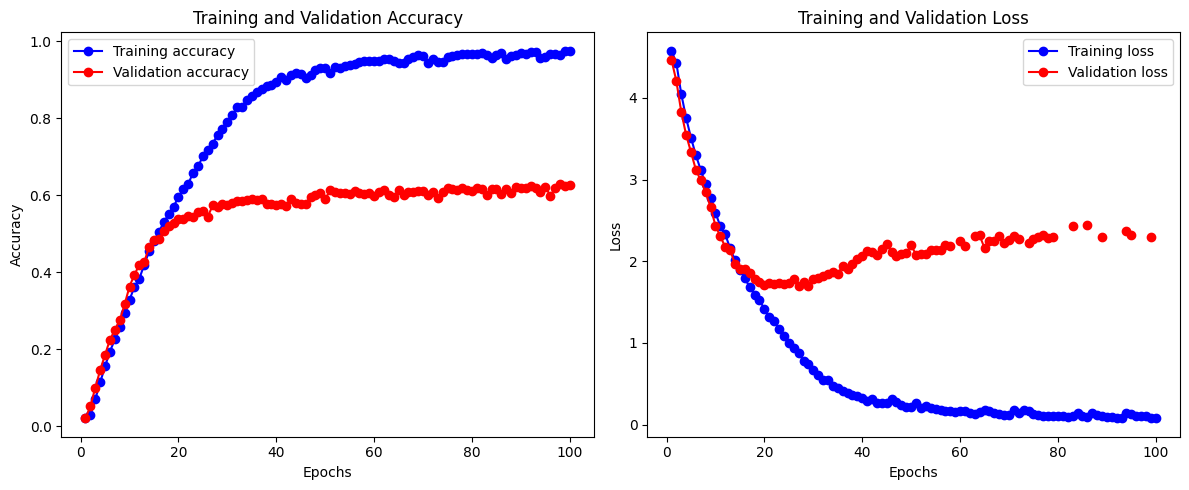

In [19]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
accuracy = history.history['accuracy']
loss = history.history['loss']

# Check if validation data was used during training
if 'val_accuracy' in history.history:
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    has_validation = True
else:
    has_validation = False

# Create epochs range
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
if has_validation:
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
if has_validation:
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()